In [3]:
# %matplotlib widget
%matplotlib inline
# %matplotlib qt5

In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
import json
from scipy.fft import fft, fftfreq
import Pyro4.util

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

Could not import QickInstrument (will only work if running on rfsoc). If running on rfsoc, try install/update qick package
Warning failed to import AWG81180A
Warning failed to import Tek5014
Warning failed to import Tek70001
Warning failed to import M8195A


c:\ProgramData\Anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


# Load experiments

In [5]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.four_qubit.fourQ_state_tomo
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_ramsey
imported experiments.three_qubit.threeQ_state_tomo
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.amplitude_rabi_f0g1
imported experiments.two_qubit.amprabi_opt_ctrl_state_prep
imported experiments.two_qubit.crosstalk_echo_calib
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.length_rabi_F0G1
imported exper

In [6]:
"""Reopen saved data"""
def prev_data(expt_path, filename=None):
    temp_data_file = expt_path
    if filename is not None: temp_data_file = os.path.join(expt_path, filename)
    print(temp_data_file)
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [7]:
# expt_path=os.path.join(os.getcwd(), 'data', 'data_240617')
data_path = 'S:\\QRAM\\qram_4QR2\\'
expt_path = os.path.join(data_path, 'data', 'data_250119')
print('Data will be stored in', expt_path)

Data will be stored in S:\QRAM\qram_4QR2\data\data_250119


In [8]:
# config_file = 'config_zcu216.yml'
# config_file = 'config_q3diamond.yml'
# config_file = 'config_q3diamond_full688_reset.yml'
config_file = 'config_q3diamond_full688and638_reset.yml'
# config_path = os.path.join(os.getcwd(), config_file)

# config_file = 'config.yml'
config_path = os.path.join('s:\\Connie\\experiments\\qram_tprocv1_expts\\configs\\', config_file)

print('Config will be', config_path)

Config will be s:\Connie\experiments\qram_tprocv1_expts\configs\config_q3diamond_full688and638_reset.yml


# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [9]:
import yaml
print('Using config file', config_path)
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

Using config file s:\Connie\experiments\qram_tprocv1_expts\configs\config_q3diamond_full688and638_reset.yml


In [10]:
# im = InstrumentManager(ns_address='192.168.14.1') # Chicago lab
# im = InstrumentManager(ns_address='192.168.137.1') # SLAC lab
# im = InstrumentManager(ns_address='10.108.30.56') # Spilker Fermium
im = InstrumentManager(ns_address='10.108.30.75') # Spilker Vibranium
# print(im)
print(im.keys())

dict_keys(['Pyro.NameServer', 'Qick_QRAM'])


In [11]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())

QICK running on ZCU216, software version 0.2.272

Firmware configuration (built Sat Oct  5 10:21:47 2024):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_signal_gen_v6 - envelope memory 32768 samples (4.762 us)
		fs=6881.280 MHz, fabric=430.080 MH

In [ ]:
lo1 = im[yaml_cfg.aliases.readout_LO]
# lo1 = SignalCore(name="SignalCore", address='10003494')
lo1.open_device()
print(lo1.get_id())

# TURN OFF
lo1.set_standby(True)
lo1.set_output_state(False)

# print(lo1.get_device_status().pll_status.crs_pll_ld)

# # TURN ON
# lo1.set_standby(False)
# lo1.set_output_state(True)
# # lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
# # lo_power = float(yaml_cfg.hw.lo.readout.power)
# lo_freq = 4385.5e6
# lo_power = 14
# lo1.set_frequency(lo_freq) # Set LO frequency
# print(f'set lo freq to {lo_freq*1e-6} MHz')
# lo1.set_power(lo_power) # Set LO power
# print(f'set lo power to {lo_power} dBm')

# Single qubit RB

In [10]:
qubit_i = 2
# qubits = [2, 1]
# qubit_i = qubits[0]

In [ ]:
rbprog = meas.SimultaneousRBExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"rb1Q_qubit{qubit_i}",
    config_file=config_path,
)

gate_char = None
# gate_char = 'X'

# max_gates = 225

max_gates = 100
# expts = 30
expts = 5

if gate_char is None: step = max_gates // expts
else: step = max_gates // (2*expts)
print('step', step)


rbprog.cfg.expt = dict(
    # start=1, # rb depth start
    start=34, # rb depth start
    step=step, # step rb depth
    # step=5, # step rb depth
    # expts=expts, # number steps
    expts=1, # number steps
    reps=5000, # number averages per unique sequence
    variations=3, # number different sequences per depth
    gate_char=None, # single qubit clifford gate (str) to characterize. if not None, runs interleaved RB instead of regular RB
    qubits=[qubit_i], # the qubits to perform simultaneous RB on (if eg-gf, q should be qA != 1)
    # qubits=qubits,
    # qDrive=qubits[0],
    # singleshot_reps=20000, # reps per state for singleshot calibration
    singleshot_reps=100, # reps per state for singleshot calibration
    post_process='threshold', # 'threshold' (uses single shot binning), 'scale' (scale by ge_avgs), or None

    # thresholds=[0, 613.9114184246247, 507.47891189954305, 0],
    # angles=[0, -101.54512016437148, 72.02480620589141, 0],
    # ge_avgs=[array([0., 0., 0., 0.]), [-101.85060937209302, 466.51286116279067, -154.72153951162792, 742.5887439767441], [21.863250678241997, -256.37994772110693, 120.73579574064026, -794.2915984536081], array([0., 0., 0., 0.])],
    # counts_calib=[[16238, 3110, 527, 125], [3374, 16034, 95, 497], [1968, 395, 14344, 3293], [494, 2404, 2838, 14264]]
)
# rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i] = int(0.8*rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i])
# rbprog.cfg.device.readout.relax_delay = 1
# rbprog.cfg.device.readout.readout_length = 5

print(rbprog.cfg)

import Pyro4.util
try:
    rbprog.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

# rbprog.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
rbprog.analyze(fit=True)
rbprog.display(fit=True, qubit=[qubit_i])

In [ ]:
p_irb = 0.913
p_rb = 0.949  
print(100*meas.fitting.rb_error(p_rb, 2),'% average error')
print(100*(1-meas.fitting.rb_gate_fidelity(p_rb, p_irb, 2)), '% gate error')

In [ ]:
qDrive = qubits[0]
setup_ZZ = 0

In [ ]:
rbprog.save_data()

### EF RB

In [22]:
qubit_i = 3

ZZ_qubit = 0 # for initialization
# ZZ_qubit = None

test_qZZ = ZZ_qubit

In [ ]:
rbprog = meas.SimultaneousRBEFExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"rb1Q_qubit{qubit_i}",
    config_file=config_path,
)

# gate_char = None
gate_char = 'X'

max_gates = 225
# max_gates = 100
# max_gates = 150
# max_gates = 40

expts = 30
# expts = 5

if gate_char is None: step = max_gates // expts
else: step = max_gates // (2*expts)
print('step', step)

rbprog.cfg.expt = dict(
    start=1, # rb depth start
    # start=200, # rb depth start
    step=step, # step rb depth
    # expts=1, # number steps
    expts=expts+1, # number steps
    reps=2000, # number averages per unique sequence
    reps_f=5000,
    # reps=200, # number averages per unique sequence
    # reps_f=500,
    loops=1,
    variations=15, # number different sequences per depth
    gate_char=gate_char, # single qubit clifford gate (str) to characterize. if not None, runs interleaved RB instead of regular RB
    qubits=[qubit_i], # the qubits to perform simultaneous RB on (if eg-gf, q should be qA != 1)
    ZZ_qubit=ZZ_qubit,
    test_qZZ=test_qZZ,
    # qubits=qubits,
    # qDrive=qubits[0],
    singleshot_reps=20000, # reps per state for singleshot calibration
    # singleshot_reps=100, # reps per state for singleshot calibration
    post_process='threshold', # 'threshold' (uses single shot binning), 'scale' (scale by ge_avgs), or None
    measure_f=[qubit_i],

)

# print(rbprog.cfg)

import Pyro4.util
try:
    rbprog.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

# rbprog.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
rbprog.save_data()

In [ ]:
rbprog.analyze(fit=True, separate_correction=True)
rbprog.display(fit=True, show_all_vars=False)

# SWAP RB

## Calibrate swap phase

In [10]:
swap_qubit = 3

# ZZ_qubit = 0 # for tomography pulses
ZZ_qubit = None

test_pi_half = False

use_IQ_pulse = False
use_robust_pulses = True
full_mux_expt = True
resonator_reset = [0, 2, 3]

In [ ]:
phaseprog = meas.EgGfPhaseExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"EgGfPhaseCalib{swap_qubit}",
    config_file=config_path,
)

n_pulses = 8
# n_pulses = 2
if test_pi_half: n_pulses *= 2

qubit = 1

start = 0
span = 180
npts = 10

print('step size', span/npts)

phaseprog.cfg.expt = dict(
    start_phase=start,
    step_phase=span/npts,
    expts_phase=npts+1,
    reps=10000,
    singleshot_reps=10000,
    # singleshot_reps=100,
    swap_qubit=swap_qubit,
    test_pi_half=test_pi_half,
    n_pulses=n_pulses,
    qubit=qubit,
    use_IQ_pulse=use_IQ_pulse,
    use_robust_pulses=use_robust_pulses,
    full_mux_expt=full_mux_expt,
    resonator_reset=resonator_reset,
)
for q in range(4):
    if q != qubit:
        phaseprog.cfg.device.readout.gain[q] = 1e-4

# print(phaseprog.cfg)

import Pyro4.util
try:
    phaseprog.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
phaseprog.save_data()

In [ ]:
if swap_qubit == 2:
    target_X_counts = [1, 0]
elif swap_qubit == 3:
    target_X_counts = [0.78406, 0.21594]
else:
    assert False

phaseprog.analyze(target_X_counts=target_X_counts)
phaseprog.display()

## Calibrate phase between X/2 and X

In [24]:
qubits = [2, 1]
qDrive = 2

# ZZ_qubit = 0 # for tomography pulses
ZZ_qubit = None

test_pi_half = False

use_IQ_pulse = False
use_robust_pulses = True
full_mux_expt = True
resonator_reset = [0, 2, 3]

In [ ]:
phaseprog = meas.EgGfX_Xhalf_PhaseCalib_Experiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"EgGfX_Xhalf_PhaseCalib{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

n_cycles = 16

qubit = 1

start = 0
span = 180
npts = 15

print('step size', span/npts)

phaseprog.cfg.expt = dict(
    start=start,
    step=span/npts,
    expts=npts+1,
    reps=5000,
    loops=1,
    singleshot_reps=10000,
    # singleshot_reps=100,
    n_cycles=n_cycles,

    post_process=None,
    measure_f=False,
    qDrive=qDrive,
    qubits=qubits,

    use_IQ_pulse=use_IQ_pulse,
    use_robust_pulses=use_robust_pulses,
    full_mux_expt=full_mux_expt,
    resonator_reset=resonator_reset,
)
for q in range(4):
    if q not in qubits:
        phaseprog.cfg.device.readout.gain[q] = 1e-4

# print(phaseprog.cfg)

import Pyro4.util
try:
    phaseprog.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
phaseprog.display(fit=False)

## Run RB

In [28]:
def run_rb(qDrive, depths, variations, reps, loops, singleshot_reps, gate_char, validate_variations=False, save_data=True):
    rbprog = meas.SimultaneousRBEgGfExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"rb_EgGf_qubit{qDrive}{1}",
        config_file=config_path,
    )

    rbprog.cfg.expt = dict(
        depths=depths,
        variations=variations,
        reps=reps, # number averages per unique sequence need at least 10,000 for a good amount of error per point!!
        loops=loops,
        gate_char=gate_char, # single qubit clifford gate (str) to characterize. if not None, runs interleaved RB instead of regular RB
        qubits=[0, 1, qDrive],
        qDrive=qDrive,
        singleshot_reps=singleshot_reps, # reps per state for singleshot calibration
        post_process='threshold', # 'threshold' (uses single shot binning), 'scale' (scale by ge_avgs), or None

        measure_f_only=False,
        measure_f=[qDrive],
        add_phase=False,

        # cool_qubits=[0, 1],

        full_mux_expt=full_mux_expt,
        resonator_reset=resonator_reset,
        use_robust_pulses=use_robust_pulses,

        validate_variations=validate_variations,

    )

    print(rbprog.cfg)

    import Pyro4.util
    try:
        rbprog.acquire(progress=True, debug=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))

    filename = rbprog.save_data()
    output_data = rbprog.analyze(fit=True)
    rbprog.display(fit=True, show_all_vars=False)

    return filename, output_data, rbprog

### Test RB

In [143]:
qubits = [2, 1]
qDrive = 2

# qubits = [3, 1]
# qDrive = 3

full_mux_expt = False
resonator_reset = [0, 2, 3] if full_mux_expt else None
use_robust_pulses = True

In [144]:
# depths = [1]
# step = 15
# end = 135
# depths = depths + np.arange(step, end+step, step).tolist()

depths = [0, 1, 5, 10, 15]
print('depths', len(depths))
print(depths)

variations = 5
reps = 4000*10
loops = 1
singleshot_reps = 10000

depths 5
[0, 1, 5, 10, 15]


{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-390.00045219204236, 5795.770150727347, 502.42095511476606, -228.8557536534039], 'gain': [0.6, 0.5, 0.5, 0.3], 'readout_length': [4.5, 16, 6.0, 10], 'frequency_ef': [-390.0004521920423, 5795.76166666, 500.48386902205084, -230.30732892], 'gain_ef': [0.5, 0.6, 0.4, 0.25], 'readout_length_ef': [4.5, 20, 10, 8], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4108.755047003828, 4103.366954082312, 4108.649372291309, 4108.232503550693, 3442.591941352887, 3447.981518133789, 3446.872635941306, 3446.65966586083, 4760.911839134516, 4759.946893523059, 4761.052602755913, 4760.46101643607, 4377.996318964773, 4377.247239665757, 4377.995764386313, 4378.454058265707], 'f_ef': [3882.6760964004225, 0.0, 3882.593023159515, 3882.5465667921762, 3345.3957364303, 3347.511433910277, 3347.003494996075, 3346.9817293387923, 4572.523325892487, 4571.192833780465, 4573.063027684978, 0.0, 4207.223225529803, 4202.994894046

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.70944694469452 	 angle (deg): -41.00767615209502 	 threshold ge: 164.43699529354635
Qubit (1) ge
ge fidelity (%): 72.97910791079106 	 angle (deg): 40.74446966766088 	 threshold ge: 44.41540359790885
Qubit (2) ge
ge fidelity (%): 76.00000000000003 	 angle (deg): -115.44325081150276 	 threshold ge: 40.90972519870471
thresholds=[164.43699529354635, 44.41540359790885, 40.90972519870471, 0],
angles=[-41.00767615209502, 40.74446966766088, -115.44325081150276, 0],
ge_avgs=[array([ 52.65408054, 102.31678249, 155.48815999, 191.73327467]), array([  2.09487725, -34.64103135,  31.2542068 , -59.76141337]), array([-47.01780071,  -6.39164617, -70.26514623,  42.47192018]), array([0., 0., 0., 0.])],
counts_calib=[[7637, 911, 792, 85, 463, 52, 55, 5], [1131, 7131, 165, 1062, 58, 388, 7, 58], [765, 7105, 128, 1525, 32, 347, 7, 91], [1463, 188, 6946, 933, 106, 8, 320, 36], [366, 1866, 1061, 6164, 22, 113, 38, 370], [286, 2031, 780, 6289, 17, 112, 53, 432], [775, 99, 81, 7,

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.31999999999998
Qubit (1) ge
ge fidelity (%): 72.05911491149115
Qubit (2) gf
gf fidelity (%): 50.136481648164796
thresholds_f=[139.42116646315995, 53.906928612168706, -51.94587671564008, 0],
angles_f=[-40.26541937107524, 61.70171522428585, -130.05408914839117, 0],
gf_avgs=[array([ 29.24244421,  95.68100593, 115.26590912, 168.54499537]), array([ 21.66646659, -29.56134062,  40.46524092, -64.47695732]), array([ 41.11051628, -56.61336393,  22.31841826, -34.26070199]), array([0., 0., 0., 0.])],
counts_calib_f=[[7171, 1409, 769, 115, 419, 60, 51, 6], [6798, 1666, 833, 171, 359, 81, 77, 15], [2815, 5240, 440, 992, 122, 277, 42, 72], [1398, 277, 6301, 1161, 169, 23, 586, 85], [1671, 417, 5993, 1261, 117, 21, 432, 88], [1311, 925, 4610, 2521, 69, 43, 335, 186], [862, 173, 80, 18, 6734, 1299, 699, 135], [754, 212, 96, 20, 6206, 1392, 1118, 202], [517, 574, 78, 81, 4118, 3239, 763, 630], [207, 78, 704, 192, 830, 208, 6384, 1397], [247, 103, 571, 224, 774, 221, 6285

  0%|          | 0/5 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_250119\00020_rb_EgGf_qubit21.h5
[ 0.  1.  5. 10. 15.]


  0%|          | 0/5 [00:00<?, ?it/s]

fit1 p1, a, offset [0.44962573 0.22333927 0.76315546]
fit2 a0, b0, c0, p2 [1.66300213e-14 2.83621417e-01 7.00089493e-01 9.66301254e-01]
[ 0  1  5 10 15  0  1  5 10 15  0  1  5 10 15  0  1  5 10 15  0  1  5 10
 15]
flat_probs_eg [0.97986683 0.9871609  0.98641204 0.9986099  0.99016509 0.78287801
 0.80366968 0.81949736 0.7969766  0.76626644 0.41535093 0.64230189
 0.65579483 0.60953236 0.60420304 0.62849318 0.53749722 0.49550013
 0.43958157 0.59150857 0.27683425 0.39204213 0.4920508  0.37443848
 0.4216112 ]
all poplns_2q
 [[[ 0.006 -0.    -0.     0.98   0.     0.009  0.001  0.     0.     0.003
   -0.    -0.   ]
  [ 0.002  0.    -0.     0.987  0.     0.01   0.     0.     0.     0.
    0.     0.   ]
  [-0.    -0.    -0.     0.986  0.007  0.     0.     0.    -0.     0.007
   -0.    -0.   ]
  [-0.    -0.     0.     0.999  0.     0.    -0.    -0.    -0.     0.001
    0.    -0.   ]
  [-0.     0.    -0.     0.99   0.01   0.     0.     0.     0.     0.
   -0.     0.   ]]

 [[ 0.052  0.145  0.014  

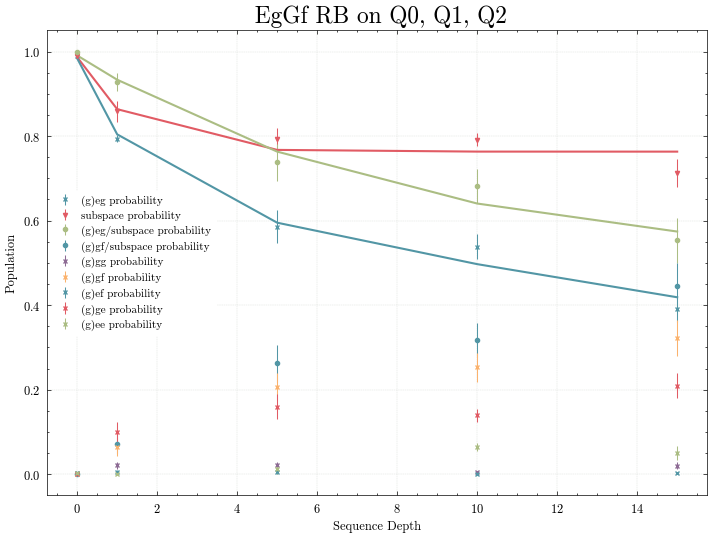

In [146]:
filename, data, rbprog = run_rb(
    qDrive=qDrive,
    depths=depths,
    variations=variations,
    reps=reps,
    loops=loops,
    singleshot_reps=singleshot_reps,
    gate_char=None,
    validate_variations=False,
    save_data=True)

In [ ]:
rbprog = meas.SimultaneousRBEgGfExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"rb_EgGf_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

gate_char = None
# gate_char = 'X'


# # expts = 30
# # expts = 19
# expts = 10

# # if gate_char is None: max_gates = 500
# if gate_char is None: max_gates = 100
# else: max_gates = 300

# step = max_gates // expts
# step = 10
# print('step', step)

rbprog.cfg.expt = dict(
    depths=depths,

    # variations=20,
    variations=20,

    # reps=3000, # number averages per unique sequence need at least 10,000 for a good amount of error per point!!
    # reps_f=3000,
    reps=3000, # number averages per unique sequence need at least 10,000 for a good amount of error per point!!
    # reps_f=1000000,
    # reps=100,
    # loops=10,
    loops=1,
    gate_char=gate_char, # single qubit clifford gate (str) to characterize. if not None, runs interleaved RB instead of regular RB
    qubits=[0, 1, qDrive],
    qDrive=qDrive,
    singleshot_reps=30000, # reps per state for singleshot calibration
    # singleshot_reps_f=15000, # reps per state for singleshot calibration
    # singleshot_reps=800, # reps per state for singleshot calibration
    post_process='threshold', # 'threshold' (uses single shot binning), 'scale' (scale by ge_avgs), or None

    measure_f_only=False,
    measure_f=[qDrive],
    add_phase=True,

    # cool_qubits=[0, 1],

    full_mux_expt=full_mux_expt,
    resonator_reset=resonator_reset,
    use_robust_pulses=True,

    validate_variations=False,

)
# rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i] = int(0.8*rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i])
# rbprog.cfg.device.readout.relax_delay = 1
# rbprog.cfg.device.readout.readout_length = 5

print(rbprog.cfg)

import Pyro4.util
try:
    rbprog.acquire(progress=True, debug=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

# rbprog.go(analyze=False, display=False, progress=True, save=False)

In [39]:
# # TESTING
# rbprog = meas.SimultaneousRBEgGfExperiment(config_file=config_path)
# temp_data, attrs = prev_data('s:\Connie\experiments\qramLL_4QR2\data\data_240617\\00011_rb_EgGf_qubit31.h5')
# rbprog.data = temp_data
# rbprog.cfg = AttrDict(attrs['config'])
# rbprog.calib_order = attrs['calib_order']

rbprog.analyze(fit=True)
rbprog.display(fit=True, show_all_vars=False)

[  1.  30. 100. 300.]
counts calib total shape (1, 12, 16)
[[[23047  1516  2976   232  1825   127   258    19 13164  1674   893
      88 11869  1388   832    92]
  [ 3305 20968   402  3159   240  1526    37   363 12750  1851  1048
     128 11605  1565   933   120]
  [ 1439 21037   177  4769    89  1688    53   748  4697  9494   408
    1326  4099  8300   393  1283]
  [ 4456   314 21277  1422   570    51  1777   133  1922   640 12148
    1139  1772   472 10925   982]
  [  726  3606  2773 20383    74   414   239  1785  1945   714 11812
    1507  1685   500 10541  1296]
  [  811  3911  1114 21812    25   445   103  1779   692  1848  3511
    9957   582  1556  3039  8815]
  [ 3424   249   259    21 21620  1480  2728   219 12103  1776   979
      99 12337  1580  1029    97]
  [  532  2383    25   276  2728 18770   576  4710 11603  1727  1472
     194 11713  1589  1504   198]
  [  430  2438    14   439  1176 18500   297  6706  4448  8022   687
    1848  4449  8074   714  1758]
  [  979    82

  0%|          | 0/4 [00:00<?, ?it/s]

minimization error 0.010313115732202017
counts raw [0.15733333 0.028      0.69266667 0.05233333 0.01666667 0.001
 0.048      0.004      0.07533333 0.011      0.39166667 0.038
 0.07366667 0.01333333 0.36433333 0.03266667]
counts_corrected [[ 9.49075086e-03  1.88145854e-02  2.14636416e-17  9.69708233e-01
   1.98643036e-03  1.66108711e-17  2.65550447e-17  1.18228373e-17
  -5.95579814e-18 -3.63827936e-17 -2.42374309e-17 -4.15023598e-17]]
minimization error 0.015703383956907752
counts raw [0.13866667 0.132      0.61533333 0.05233333 0.015      0.00266667
 0.041      0.003      0.10533333 0.05566667 0.334      0.04033333
 0.08633333 0.04466667 0.3        0.03366667]
counts_corrected [[-9.75671743e-17  6.99345928e-02  9.26098469e-02  8.37455560e-01
  -2.20832993e-16  7.59883668e-17  3.15898712e-17  4.67455033e-17
  -1.35791732e-17 -7.24531592e-17 -1.63251743e-16  1.73092245e-17]]
minimization error 0.006500704272073415
counts raw [0.14366667 0.05566667 0.67       0.05833333 0.015      0.00166

In [ ]:
rbprog.save_data()

### RUN RB

#### Q3

In [64]:
qubits = [3, 1]
qDrive = 3

full_mux_expt = False
resonator_reset = [0, 2, 3] if full_mux_expt else None

use_robust_pulses = True

##### RB

###### First half

In [52]:
depths = [1]
step = 15
end = 135
depths = depths + np.arange(step, end+step, step).tolist()
print('depths', len(depths))
print(depths)

variations = 20
reps = 4000
loops = 20
singleshot_reps = 10000

depths 10
[1, 15, 30, 45, 60, 75, 90, 105, 120, 135]


In [54]:
filename_13_1, data_13_1, rbprog_13_1 = run_rb(
    qDrive=qDrive,
    depths=depths,
    variations=variations,
    reps=reps,
    loops=loops,
    singleshot_reps=singleshot_reps,
    gate_char=None,
    validate_variations=True,
    save_data=True)

{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-390.00045219204236, 5795.770150727347, 502.42095511476606, -228.8557536534039], 'gain': [0.6, 0.5, 0.5, 0.3], 'readout_length': [4.5, 16, 6.0, 10], 'frequency_ef': [-390.0004521920423, 5795.76166666, 500.48386902205084, -230.30732892], 'gain_ef': [0.5, 0.6, 0.4, 0.25], 'readout_length_ef': [4.5, 20, 10, 8], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4108.755047003828, 4103.366954082312, 4108.649372291309, 4108.232503550693, 3442.591941352887, 3447.981518133789, 3446.872635941306, 3446.65966586083, 4760.911839134516, 4759.946893523059, 4761.052602755913, 4760.46101643607, 4377.996318964773, 4377.247239665757, 4377.995764386313, 4378.454058265707], 'f_ef': [3882.6760964004225, 0.0, 3882.593023159515, 3882.5465667921762, 3345.3957364303, 3347.511433910277, 3347.003494996075, 3346.9817293387923, 4572.523325892487, 4571.192833780465, 4573.063027684978, 0.0, 4207.223225529803, 4202.994894046

  0%|          | 0/10 [00:00<?, ?it/s]

gate_list_variations= [[['-X/2', '-X/2'], ['-X/2', '-X/2'], ['X/2,-Y/2,-X/2', 'I'], ['-Y/2,X/2', '-Y/2,X/2'], ['X', 'X'], ['-Y/2,X', '-Y/2,X'], ['X/2', 'X/2'], ['-X/2', '-X/2'], ['I', 'I'], ['-X/2,Y/2,-X/2', '-X/2,Y/2,-X/2'], ['X/2,Y/2', 'X/2,Y/2'], ['-Y/2,-X/2', '-Y/2,-X/2'], ['X/2,-Y/2', 'X/2,-Y/2'], ['-Y/2,X', '-Y/2,X'], ['-Y/2,X', '-Y/2,X'], ['-X/2,-Y/2', '-X/2,-Y/2'], ['X/2,-Y/2,-X/2', 'I'], ['X/2,-Y/2', 'X/2,-Y/2'], ['X', 'X'], ['X/2', 'X/2']], [['-X/2,Y', 'X/2,Y/2,X/2', 'Y', 'X/2', 'X/2,Y/2,X/2', 'I', 'Y/2,X', 'X', 'Y/2', '-Y/2,X/2', '-Y/2,X', 'Y/2,X/2', 'X,Y', '-Y/2', 'X/2,Y/2,-X/2', 'Y/2'], ['Y/2,-X/2', '-X/2,Y', 'X/2,Y/2,X/2', 'X/2,Y/2', 'Y', 'Y/2,X', '-Y/2,X', '-X/2', 'X/2,Y/2', 'X', '-X/2', '-X/2,Y/2,-X/2', '-Y/2,X', '-X/2', '-Y/2', 'Y'], ['-Y/2', '-Y/2,X', 'Y/2,-X/2', 'X', '-X/2,Y', '-Y/2', 'Y/2', '-X/2,Y/2,-X/2', 'Y/2,X', '-X/2', 'X/2,Y/2,-X/2', 'Y', 'X/2,Y', 'X/2,Y', '-Y/2', 'Y/2,X/2'], ['Y', 'X/2,-Y/2', 'I', 'X/2,Y/2,-X/2', 'Y', 'X/2,-Y/2', 'X/2,Y/2', '-X/2,Y/2', 'X/2,Y

  0%|          | 0/20 [00:00<?, ?it/s]

Beginning loop 0


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.4992939293929 	 angle (deg): 98.64025096700959 	 threshold ge: 164.9899235197024
Qubit (1) ge
ge fidelity (%): 76.19907590759078 	 angle (deg): 138.86289736766523 	 threshold ge: 45.37770215565169
Qubit (3) ge
ge fidelity (%): 78.84 	 angle (deg): 160.37316415158497 	 threshold ge: 58.454577611684535
thresholds=[164.9899235197024, 45.37770215565169, 0, 58.454577611684535],
angles=[98.64025096700959, 138.86289736766523, 0, 160.37316415158497],
ge_avgs=[array([  26.61064334, -118.4428076 ,    7.48414392, -244.31277069]), array([-35.67992442,   2.02468718, -65.81425184, -24.29754557]), array([0., 0., 0., 0.]), array([-26.48840156, -22.39360514, -74.42227822, -39.48739274])],
counts_calib=[[7879, 511, 792, 94, 592, 40, 87, 5], [1236, 6915, 126, 1004, 89, 491, 17, 122], [815, 6198, 104, 1786, 75, 567, 40, 415], [1159, 63, 7553, 462, 172, 11, 544, 36], [221, 1217, 1158, 6619, 27, 161, 79, 518], [187, 1161, 894, 6911, 30, 139, 55, 623], [1005, 49, 72, 5, 7771,

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.04999999999998
Qubit (1) ge
ge fidelity (%): 78.16999999999999
Qubit (3) gf
gf fidelity (%): 50.660000000000004
thresholds_f=[134.88702639481437, 56.9679765738657, 0, -55.50168133605652],
angles_f=[100.44643235796684, 160.71758278369848, 0, 32.73779929040875],
gf_avgs=[array([  40.10405253,  -96.68874949,   19.59717033, -207.91422757]), array([-32.34006144, -16.94097202, -74.64480757, -31.7413105 ]), array([0., 0., 0., 0.]), array([-41.2765701 ,  69.81548031, -19.31765041,  55.69763824])],
counts_calib_f=[[7113, 1422, 528, 102, 646, 124, 60, 5], [7034, 1150, 823, 123, 635, 115, 107, 13], [2554, 5414, 405, 692, 278, 514, 61, 82], [1043, 227, 6660, 1245, 195, 30, 505, 95], [1109, 182, 6755, 1067, 193, 24, 589, 81], [514, 784, 2854, 4986, 118, 95, 246, 403], [762, 149, 50, 9, 7092, 1339, 511, 88], [793, 132, 73, 20, 6927, 1063, 877, 115], [362, 534, 53, 71, 2910, 4830, 469, 771], [177, 37, 607, 117, 901, 162, 6773, 1226], [186, 30, 657, 108, 920, 153, 6879

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 1


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.40999999999995 	 angle (deg): 92.41833553721492 	 threshold ge: 162.76923505431412
Qubit (1) ge
ge fidelity (%): 75.51914091409142 	 angle (deg): 135.67024414056905 	 threshold ge: 42.84306449903472
Qubit (3) ge
ge fidelity (%): 77.57938893889393 	 angle (deg): 165.83714478326152 	 threshold ge: 57.555888632520954
thresholds=[162.76923505431412, 42.84306449903472, 0, 57.555888632520954],
angles=[92.41833553721492, 135.67024414056905, 0, 165.83714478326152],
ge_avgs=[array([  41.95441614, -111.70670637,   36.60765434, -238.30822164]), array([-35.76823471,   3.61474344, -63.36346879, -23.34231066]), array([0., 0., 0., 0.]), array([-28.43724004, -17.72039489, -76.49358125, -29.84737441])],
counts_calib=[[7817, 546, 749, 83, 694, 34, 69, 8], [1348, 6701, 125, 1019, 106, 544, 14, 143], [940, 6467, 138, 1526, 79, 579, 10, 261], [1207, 94, 7401, 444, 229, 13, 573, 39], [188, 1127, 1202, 6689, 30, 180, 79, 505], [171, 1166, 853, 6849, 24, 193, 71, 673], [923, 4

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.84000000000002
Qubit (1) ge
ge fidelity (%): 78.76
Qubit (3) gf
gf fidelity (%): 50.080000000000034
thresholds_f=[135.94374389569546, 57.381997726185226, 0, -56.77836758510141],
angles_f=[93.04086421587996, 162.15897446680276, 0, -79.75249357454099],
gf_avgs=[array([  50.62395955,  -88.03678032,   44.84744103, -196.77538097]), array([-32.64634072, -16.46326156, -75.46420208, -30.24439997]), array([0., 0., 0., 0.]), array([-48.64958389, -64.44600073, -44.073814  , -39.13537095])],
counts_calib_f=[[6998, 1584, 536, 130, 563, 128, 48, 13], [7054, 1411, 627, 143, 579, 106, 66, 14], [2491, 5801, 325, 556, 289, 414, 55, 69], [1009, 214, 6629, 1385, 151, 40, 462, 110], [1274, 256, 6485, 1321, 139, 33, 412, 80], [465, 854, 2479, 5433, 98, 72, 212, 387], [832, 194, 47, 6, 6882, 1515, 420, 104], [851, 187, 69, 10, 6708, 1289, 738, 148], [380, 647, 52, 75, 2661, 5198, 382, 605], [219, 46, 598, 144, 960, 213, 6435, 1385], [215, 45, 578, 120, 1011, 167, 6623, 1241],

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 2


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.29924992499248 	 angle (deg): 84.65321585917984 	 threshold ge: 166.37816983099796
Qubit (1) ge
ge fidelity (%): 73.22908990899093 	 angle (deg): 135.8575473941192 	 threshold ge: 41.78439642868098
Qubit (3) ge
ge fidelity (%): 79.58000000000001 	 angle (deg): -30.812620259429853 	 threshold ge: 56.37207976535777
thresholds=[166.37816983099796, 41.78439642868098, 0, 56.37207976535777],
angles=[84.65321585917984, 135.8575473941192, 0, -30.812620259429853],
ge_avgs=[array([  58.94129038, -103.97342721,   70.95123893, -232.29742627]), array([-35.88354826,   4.23688183, -62.72100045, -21.80900496]), array([0., 0., 0., 0.]), array([20.25735433, 24.07481755, 64.16917305, 50.2646262 ])],
counts_calib=[[7895, 449, 820, 81, 635, 41, 66, 13], [1253, 6839, 129, 1058, 72, 525, 13, 111], [917, 6590, 106, 1554, 66, 536, 10, 221], [1433, 77, 7295, 455, 189, 14, 503, 34], [219, 1112, 1149, 6744, 33, 140, 82, 521], [158, 1143, 906, 6996, 22, 160, 60, 555], [955, 60, 97,

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 80.41919791979197
Qubit (1) ge
ge fidelity (%): 79.37
Qubit (3) gf
gf fidelity (%): 46.859999999999964
thresholds_f=[135.64917176789461, 58.29442882214811, 0, -54.27289753239947],
angles_f=[84.31111597859869, 161.03327688586495, 0, 91.99693309128456],
gf_avgs=[array([  64.03743994,  -81.28982388,   74.63459197, -187.66842315]), array([-32.98675651, -16.22505321, -74.85780558, -30.61521548]), array([0., 0., 0., 0.]), array([43.16531318, 67.13210346, 42.37407648, 44.43922229])],
counts_calib_f=[[6843, 1709, 501, 112, 607, 168, 48, 12], [6764, 1508, 710, 154, 636, 132, 77, 19], [2673, 5530, 354, 632, 267, 440, 37, 67], [966, 235, 6332, 1665, 158, 39, 492, 113], [1147, 266, 6380, 1360, 175, 44, 515, 113], [536, 877, 2724, 5089, 110, 100, 220, 344], [815, 204, 91, 28, 6698, 1580, 470, 114], [784, 180, 130, 35, 6481, 1475, 752, 163], [394, 472, 88, 150, 2778, 4933, 484, 701], [169, 50, 638, 168, 962, 263, 6253, 1497], [200, 42, 637, 146, 976, 228, 6435, 1336], [

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 3


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.22932193219326 	 angle (deg): 76.02784684261242 	 threshold ge: 166.41618979201237
Qubit (1) ge
ge fidelity (%): 74.74000000000002 	 angle (deg): 135.48626921603406 	 threshold ge: 43.63487680131035
Qubit (3) ge
ge fidelity (%): 71.99937393739377 	 angle (deg): -69.79458250886532 	 threshold ge: 56.826044752633074
thresholds=[166.41618979201237, 43.63487680131035, 0, 56.826044752633074],
angles=[76.02784684261242, 135.48626921603406, 0, -69.79458250886532],
ge_avgs=[array([  72.93085861,  -95.09286252,  103.04539978, -216.12625868]), array([-36.78145371,   3.79735854, -64.23071078, -23.18988492]), array([0., 0., 0., 0.]), array([ 1.22397507, 32.53525446, 17.19132643, 75.92058538])],
counts_calib=[[7859, 506, 841, 107, 560, 49, 65, 13], [1855, 6166, 155, 994, 103, 564, 13, 150], [970, 6360, 105, 1335, 74, 622, 37, 497], [1194, 91, 7186, 525, 205, 19, 721, 59], [264, 1080, 1175, 6425, 38, 191, 126, 701], [192, 1265, 853, 6607, 33, 196, 68, 786], [943, 54,

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 79.58
Qubit (1) ge
ge fidelity (%): 73.14999999999999
Qubit (3) gf
gf fidelity (%): 44.39999999999998
thresholds_f=[134.5439768050741, 61.44249061855681, 0, -49.91587075872137],
angles_f=[78.21689070130488, 161.16857101701274, 0, 144.78433930147645],
gf_avgs=[array([  73.86936179,  -73.78975962,   95.35036187, -176.76515058]), array([-35.06650389, -18.1222283 , -73.61780306, -31.2697631 ]), array([0., 0., 0., 0.]), array([ 79.87174862,  -2.65967152,  61.89651802, -15.34716135])],
counts_calib_f=[[6412, 1740, 766, 184, 640, 187, 54, 17], [6929, 1359, 763, 152, 596, 129, 58, 14], [2402, 4915, 592, 1036, 316, 453, 136, 150], [1125, 295, 6143, 1576, 190, 55, 488, 128], [1126, 249, 6470, 1295, 196, 38, 511, 115], [558, 832, 2594, 5024, 130, 121, 300, 441], [884, 213, 44, 10, 6674, 1759, 320, 96], [824, 186, 63, 10, 6793, 1394, 606, 124], [437, 653, 44, 40, 2852, 5236, 298, 440], [207, 51, 658, 169, 1035, 278, 6046, 1556], [221, 50, 578, 118, 1080, 235, 6435, 12

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 4


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.18929392939293 	 angle (deg): 68.22357667254535 	 threshold ge: 168.48405259132124
Qubit (1) ge
ge fidelity (%): 76.02 	 angle (deg): 135.9103397746276 	 threshold ge: 44.16970681876796
Qubit (3) ge
ge fidelity (%): 78.259499949995 	 angle (deg): -57.868374930328706 	 threshold ge: 57.82091031418975
thresholds=[168.48405259132124, 44.16970681876796, 0, 57.82091031418975],
angles=[68.22357667254535, 135.9103397746276, 0, -57.868374930328706],
ge_avgs=[array([  82.71318777,  -85.36670456,  130.5876547 , -205.20439978]), array([-36.13979782,   2.98755316, -64.14237654, -24.13903611]), array([0., 0., 0., 0.]), array([ 7.07187132, 31.32478239, 33.46557744, 73.34841016])],
counts_calib=[[7989, 440, 790, 67, 608, 27, 70, 9], [1395, 6826, 129, 912, 100, 531, 14, 93], [982, 6372, 124, 1677, 65, 519, 14, 247], [1218, 71, 7572, 423, 179, 10, 510, 17], [236, 1146, 1238, 6663, 27, 135, 88, 467], [184, 1215, 903, 6945, 31, 148, 56, 518], [927, 46, 81, 14, 7767, 415, 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 80.61885288528853
Qubit (1) ge
ge fidelity (%): 77.89999999999999
Qubit (3) gf
gf fidelity (%): 45.27650065006503
thresholds_f=[135.86548917143483, 58.23854120465769, 0, -55.141062689101304],
angles_f=[69.40143727684311, 161.6771438742006, 0, -72.25198910574832],
gf_avgs=[array([  83.58099313,  -60.84738423,  121.507867  , -161.75788292]), array([-32.8510411 , -17.36259736, -74.5050465 , -31.15677879]), array([0., 0., 0., 0.]), array([-61.81893857, -52.87198869, -54.90213735, -31.26132392])],
counts_calib_f=[[6725, 1796, 520, 143, 589, 154, 59, 14], [6857, 1574, 677, 145, 564, 113, 55, 15], [2601, 5245, 464, 907, 272, 404, 44, 63], [1008, 294, 6352, 1610, 144, 34, 453, 105], [1169, 261, 6460, 1344, 158, 36, 483, 89], [511, 778, 2734, 5193, 94, 92, 210, 388], [810, 235, 59, 24, 6695, 1615, 442, 120], [833, 201, 90, 17, 6667, 1323, 713, 156], [412, 669, 50, 86, 2778, 5092, 379, 534], [217, 59, 638, 185, 1007, 248, 6083, 1563], [215, 58, 657, 153, 984, 182, 6

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 5


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.56923492349235 	 angle (deg): 60.35896279988958 	 threshold ge: 162.11563708264967
Qubit (1) ge
ge fidelity (%): 76.34911691169115 	 angle (deg): 135.8100191642482 	 threshold ge: 43.21062228584888
Qubit (3) ge
ge fidelity (%): 77.85941494149414 	 angle (deg): 149.15006299957972 	 threshold ge: 57.73135789922389
thresholds=[162.11563708264967, 43.21062228584888, 0, 57.73135789922389],
angles=[60.35896279988958, 135.8100191642482, 0, 149.15006299957972],
ge_avgs=[array([  96.13934313,  -71.24773459,  159.09476975, -181.88474501]), array([-35.85053487,   3.61738269, -64.0407905 , -23.78685337]), array([0., 0., 0., 0.]), array([-22.12671865, -25.94100212, -64.2385902 , -51.09448776])],
counts_calib=[[7876, 505, 761, 76, 645, 37, 89, 11], [1351, 6791, 123, 980, 99, 516, 15, 125], [872, 6162, 105, 1970, 57, 586, 14, 234], [1184, 71, 7543, 455, 179, 8, 533, 27], [255, 1150, 1185, 6614, 29, 164, 90, 513], [183, 1101, 877, 7009, 33, 166, 56, 575], [942, 38, 83,

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.76923392339235
Qubit (1) ge
ge fidelity (%): 72.89894489448943
Qubit (3) gf
gf fidelity (%): 46.240000000000016
thresholds_f=[137.98835352527897, 57.79223326565446, 0, -53.403345782675544],
angles_f=[59.1719507980468, 162.53560731458904, 0, -136.97994636396132],
gf_avgs=[array([  89.35154001,  -48.42797265,  144.99291049, -141.663433  ]), array([-34.57866538, -18.11448527, -73.00281001, -30.2033235 ]), array([0., 0., 0., 0.]), array([ 20.43073995, -78.47131164,   3.70131489, -62.85991977])],
counts_calib_f=[[6607, 1579, 825, 201, 573, 137, 66, 12], [6721, 1409, 876, 197, 588, 115, 72, 22], [2495, 5054, 594, 976, 262, 388, 112, 119], [1099, 295, 6319, 1534, 183, 42, 431, 97], [1126, 303, 6406, 1359, 193, 36, 485, 92], [536, 850, 2619, 5061, 111, 114, 295, 414], [722, 203, 92, 25, 6624, 1657, 560, 117], [671, 159, 131, 32, 6672, 1335, 842, 158], [378, 578, 69, 113, 2908, 4784, 463, 707], [212, 59, 617, 170, 1048, 268, 6120, 1506], [213, 50, 626, 148, 1045

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 6


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 79.7790819081908 	 angle (deg): 51.79197635429925 	 threshold ge: 175.16708126179
Qubit (1) ge
ge fidelity (%): 72.57853685368538 	 angle (deg): 135.77506591696414 	 threshold ge: 41.14137571255421
Qubit (3) ge
ge fidelity (%): 79.80999999999999 	 angle (deg): -158.79352173716458 	 threshold ge: 57.05864629354504
thresholds=[175.16708126179, 41.14137571255421, 0, 57.05864629354504],
angles=[51.79197635429925, 135.77506591696414, 0, -158.79352173716458],
ge_avgs=[array([ 106.24574595,  -58.5129348 ,  184.89998046, -158.43584124]), array([-36.05151862,   2.09187851, -62.48489347, -23.63584651]), array([0., 0., 0., 0.]), array([-33.43360007,  -2.12358382, -81.07210355,  16.3603709 ])],
counts_calib=[[7582, 411, 1001, 76, 627, 43, 234, 26], [1179, 6677, 184, 1181, 81, 488, 25, 185], [893, 6368, 138, 1576, 80, 553, 28, 364], [1129, 86, 7473, 503, 186, 18, 550, 55], [195, 1051, 1158, 6731, 27, 142, 90, 606], [156, 1132, 794, 6890, 20, 190, 68, 750], [905, 60, 12

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 80.61887988798883
Qubit (1) ge
ge fidelity (%): 78.79936593659366
Qubit (3) gf
gf fidelity (%): 45.576488648864895
thresholds_f=[137.05212880140752, 57.4644655529084, 0, -53.42726060873508],
angles_f=[52.89610385063336, 162.3374473561093, 0, -52.11666743339138],
gf_avgs=[array([  98.25882685,  -35.07275405,  162.92716266, -120.56753676]), array([-32.67802318, -17.24343011, -74.78394299, -30.65082708]), array([0., 0., 0., 0.]), array([-77.44963275, -25.52758308, -63.65391558,  -7.79556477])],
counts_calib_f=[[6752, 1802, 496, 115, 633, 144, 47, 11], [6776, 1458, 774, 181, 573, 123, 90, 25], [2654, 5448, 427, 694, 264, 388, 60, 65], [1010, 259, 6373, 1619, 146, 52, 440, 101], [1174, 237, 6480, 1350, 157, 35, 472, 95], [522, 863, 2773, 5047, 92, 106, 222, 375], [835, 201, 59, 13, 6600, 1692, 487, 113], [817, 171, 80, 17, 6604, 1368, 782, 161], [407, 602, 77, 62, 2751, 4896, 486, 719], [190, 46, 675, 138, 976, 229, 6239, 1507], [225, 58, 664, 179, 1049, 206, 6

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 7


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.59 	 angle (deg): 44.17773150431215 	 threshold ge: 166.2154143120798
Qubit (1) ge
ge fidelity (%): 76.21762176217625 	 angle (deg): 136.14644400839796 	 threshold ge: 43.87430854563433
Qubit (3) ge
ge fidelity (%): 76.94000000000001 	 angle (deg): 106.33038868530426 	 threshold ge: 57.7266837259343
thresholds=[166.2154143120798, 43.87430854563433, 0, 57.7266837259343],
angles=[44.17773150431215, 136.14644400839796, 0, 106.33038868530426],
ge_avgs=[array([ 111.24410962,  -41.86409407,  205.21977865, -133.18040116]), array([-35.51406456,   3.23323343, -63.57649129, -23.72806439]), array([0., 0., 0., 0.]), array([  2.52281523, -33.6373235 , -10.96989814, -79.68812308])],
counts_calib=[[7963, 492, 725, 68, 642, 37, 67, 6], [1509, 6842, 99, 920, 83, 426, 15, 106], [930, 7012, 94, 1232, 68, 494, 11, 159], [1238, 76, 7559, 399, 199, 16, 478, 35], [218, 1090, 1140, 6839, 30, 142, 86, 455], [175, 1169, 881, 7103, 22, 139, 50, 461], [978, 51, 61, 5, 7634, 492, 7

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.75999999999996
Qubit (1) ge
ge fidelity (%): 78.82932893289332
Qubit (3) gf
gf fidelity (%): 44.05651665166514
thresholds_f=[133.12006627987552, 57.42627623150746, 0, -51.343492020567254],
angles_f=[44.32009314810206, 161.18727129513283, 0, 57.3825864669745],
gf_avgs=[array([ 99.42769175, -18.45524081, 178.38837959, -95.563828  ]), array([-32.10787476, -16.58388076, -74.16942816, -30.91322954]), array([0., 0., 0., 0.]), array([ 3.98102315, 78.97541969, 15.57689174, 60.85560069])],
counts_calib_f=[[6646, 1953, 513, 123, 543, 147, 51, 24], [6841, 1521, 671, 148, 576, 102, 115, 26], [2522, 5413, 441, 646, 234, 428, 166, 150], [931, 282, 6239, 1775, 155, 48, 448, 122], [1043, 233, 6546, 1396, 167, 39, 461, 115], [535, 885, 2623, 4924, 118, 80, 355, 480], [787, 200, 65, 12, 6333, 1670, 745, 188], [890, 220, 83, 14, 6477, 1306, 825, 185], [388, 529, 55, 61, 2741, 4944, 500, 782], [203, 71, 603, 170, 1021, 257, 6093, 1582], [220, 75, 690, 141, 925, 198, 6434, 

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 8


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.31889988998896 	 angle (deg): 35.58715845039786 	 threshold ge: 163.20570020518846
Qubit (1) ge
ge fidelity (%): 75.94000000000001 	 angle (deg): 136.2084663628827 	 threshold ge: 43.31455065703485
Qubit (3) ge
ge fidelity (%): 79.49 	 angle (deg): 101.29192537910104 	 threshold ge: 57.069247948195596
thresholds=[163.20570020518846, 43.31455065703485, 0, 57.069247948195596],
angles=[35.58715845039786, 136.2084663628827, 0, 101.29192537910104],
ge_avgs=[array([ 116.20715854,  -25.67977258,  221.84848401, -101.27572605]), array([-36.66714802,   3.60427322, -65.20934226, -23.75861202]), array([0., 0., 0., 0.]), array([  4.11538522, -32.25503184,  -5.97311689, -82.78010895])],
counts_calib=[[7809, 438, 899, 72, 661, 41, 71, 9], [1305, 7007, 97, 869, 96, 524, 10, 92], [996, 6941, 88, 1243, 63, 498, 9, 162], [1120, 82, 7582, 521, 168, 12, 469, 46], [196, 1236, 1168, 6694, 29, 170, 69, 438], [155, 1243, 880, 6970, 27, 144, 55, 526], [914, 52, 122, 7, 7532, 523

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.21925692569255
Qubit (1) ge
ge fidelity (%): 78.49
Qubit (3) gf
gf fidelity (%): 49.46999999999999
thresholds_f=[135.87910972126943, 56.74421838284093, 0, -56.1062426356126],
angles_f=[36.40352964077458, 161.61210830833897, 0, 144.11822329806313],
gf_avgs=[array([102.57766744,  -6.07928003, 189.28087634, -70.01064356]), array([-32.58692026, -16.85754666, -74.19657995, -30.6894724 ]), array([0., 0., 0., 0.]), array([78.47112498, 17.19879333, 57.58465492,  2.08963222])],
counts_calib_f=[[7221, 1348, 564, 101, 596, 109, 51, 10], [7087, 1241, 761, 122, 617, 87, 72, 13], [2728, 5271, 444, 749, 288, 396, 45, 79], [1014, 231, 6753, 1243, 171, 30, 480, 78], [1120, 192, 6815, 1100, 183, 25, 498, 67], [596, 900, 2885, 4914, 98, 78, 209, 320], [881, 161, 64, 8, 6950, 1292, 558, 86], [896, 147, 90, 16, 6759, 1100, 868, 124], [420, 563, 76, 89, 3006, 4695, 491, 660], [190, 49, 648, 119, 1069, 205, 6548, 1172], [238, 44, 727, 87, 1018, 166, 6650, 1070], [114, 174, 35

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 9


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.04930893089309 	 angle (deg): 26.843718170008316 	 threshold ge: 164.64951850813242
Qubit (1) ge
ge fidelity (%): 75.43856585658563 	 angle (deg): 137.40251510148488 	 threshold ge: 43.448391138873475
Qubit (3) ge
ge fidelity (%): 78.43937593759382 	 angle (deg): 102.66089754493895 	 threshold ge: 57.78135705750009
thresholds=[164.64951850813242, 43.448391138873475, 0, 57.78135705750009],
angles=[26.843718170008316, 137.40251510148488, 0, 102.66089754493895],
ge_avgs=[array([118.36247627,  -9.10512308, 232.69533611, -66.96834768]), array([-35.9002458 ,   2.94929731, -64.67799314, -23.51086657]), array([0., 0., 0., 0.]), array([  2.44179421, -33.62014202,  -8.51129206, -82.37794932])],
counts_calib=[[7764, 542, 901, 86, 573, 31, 95, 8], [1216, 6821, 170, 1106, 86, 476, 17, 108], [961, 6454, 120, 1339, 71, 543, 27, 485], [1119, 67, 7494, 465, 179, 20, 598, 58], [193, 1134, 1194, 6615, 30, 192, 97, 545], [147, 1261, 833, 6700, 27, 180, 52, 800], [944, 48, 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 80.75918391839184
Qubit (1) ge
ge fidelity (%): 67.17
Qubit (3) gf
gf fidelity (%): 51.926794679467946
thresholds_f=[138.4758112421651, 65.8069965953245, 0, -56.011311937081445],
angles_f=[27.830625923848142, 161.7038406245924, 0, 107.50334467007163],
gf_avgs=[array([102.40337048,   7.39528596, 198.01601237, -43.08087388]), array([-39.93115872, -19.44382157, -74.13858781, -30.75430339]), array([0., 0., 0., 0.]), array([53.69174992, 58.73639247, 45.68154711, 33.33644512])],
counts_calib_f=[[6438, 1404, 1093, 225, 664, 113, 57, 6], [6464, 1255, 1273, 236, 580, 104, 74, 14], [2464, 5869, 324, 542, 265, 459, 31, 46], [1361, 287, 6190, 1344, 213, 45, 460, 100], [1382, 239, 6451, 1139, 196, 29, 487, 77], [649, 1255, 2361, 4947, 137, 123, 184, 344], [845, 200, 37, 7, 7080, 1495, 300, 36], [760, 158, 108, 11, 7190, 1181, 497, 95], [430, 643, 34, 19, 2991, 5328, 266, 289], [223, 44, 636, 115, 1390, 264, 6143, 1185], [244, 45, 684, 113, 1359, 268, 6223, 1064], [121,

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 10


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.42999999999998 	 angle (deg): 19.597010138356765 	 threshold ge: 166.4242115860621
Qubit (1) ge
ge fidelity (%): 74.82900390039003 	 angle (deg): 133.17391668654832 	 threshold ge: 41.96232767657287
Qubit (3) ge
ge fidelity (%): 79.47 	 angle (deg): -140.89899636012416 	 threshold ge: 57.513248291767255
thresholds=[166.4242115860621, 41.96232767657287, 0, 57.513248291767255],
angles=[19.597010138356765, 133.17391668654832, 0, -140.89899636012416],
ge_avgs=[array([118.93736628,   8.18956158, 240.58294682, -35.11932865]), array([-37.69649461,   4.50253902, -64.20576596, -23.75273343]), array([0., 0., 0., 0.]), array([-31.06240645,  11.14556019, -70.40374906,  43.11854635])],
counts_calib=[[7880, 479, 892, 79, 553, 35, 80, 2], [1218, 6790, 144, 1108, 82, 532, 20, 106], [967, 6873, 109, 1302, 67, 520, 9, 153], [1186, 80, 7581, 450, 197, 13, 460, 33], [195, 1213, 1201, 6634, 32, 169, 96, 460], [175, 1289, 905, 6888, 33, 155, 39, 516], [948, 42, 93, 9, 7618, 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.41000000000001
Qubit (1) ge
ge fidelity (%): 74.22999999999999
Qubit (3) gf
gf fidelity (%): 50.97999999999998
thresholds_f=[135.13696948360513, 58.355703564196034, 0, -59.325516295647404],
angles_f=[20.584807913289023, 161.98996395004826, 0, -143.80444529905728],
gf_avgs=[array([100.40679059,  23.49820014, 200.97437077, -14.27223806]), array([-34.5765041 , -17.69918465, -73.65195465, -30.40313574]), array([0., 0., 0., 0.]), array([ 41.61707937, -69.83458491,  20.66144264, -54.49987392])],
counts_calib_f=[[6814, 1512, 782, 143, 541, 127, 68, 13], [6874, 1637, 653, 122, 540, 107, 52, 15], [2449, 5761, 352, 681, 246, 388, 65, 58], [1135, 268, 6410, 1464, 145, 31, 447, 100], [1225, 259, 6438, 1359, 134, 32, 441, 112], [514, 938, 2356, 5418, 107, 93, 201, 373], [827, 188, 92, 13, 6726, 1612, 435, 107], [823, 190, 121, 21, 6377, 1234, 1024, 210], [376, 606, 56, 99, 2801, 5053, 420, 589], [233, 67, 610, 146, 1038, 275, 6172, 1459], [218, 44, 632, 108, 951, 21

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 11


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.16922692269229 	 angle (deg): 12.243735309459012 	 threshold ge: 171.77797084928497
Qubit (1) ge
ge fidelity (%): 72.24722472247225 	 angle (deg): 136.6502320251322 	 threshold ge: 42.501936155540356
Qubit (3) ge
ge fidelity (%): 77.90838083808379 	 angle (deg): -77.89972659728664 	 threshold ge: 56.809935668755415
thresholds=[171.77797084928497, 42.501936155540356, 0, 56.809935668755415],
angles=[12.243735309459012, 136.6502320251322, 0, -77.89972659728664],
ge_avgs=[array([ 1.17342961e+02,  2.67613384e+01,  2.41613968e+02, -2.06314255e-01]), array([-36.4656011 ,   2.52026016, -63.7728103 , -23.2575717 ]), array([0., 0., 0., 0.]), array([-3.72719561, 31.94198454,  6.72196117, 80.68181143])],
counts_calib=[[7648, 464, 1000, 99, 528, 40, 196, 25], [1313, 6678, 164, 1154, 88, 429, 20, 154], [908, 6692, 130, 1434, 55, 509, 33, 239], [1194, 82, 7342, 468, 165, 22, 700, 27], [223, 1193, 1291, 6559, 27, 135, 89, 483], [150, 1134, 837, 7102, 24, 151, 53, 549],

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.15925092509254
Qubit (1) ge
ge fidelity (%): 76.14000000000001
Qubit (3) gf
gf fidelity (%): 50.12000000000001
thresholds_f=[136.6003171714949, 56.50304904530104, 0, -57.705870981806555],
angles_f=[12.230653684016492, 161.46837261019536, 0, 68.80920806236554],
gf_avgs=[array([ 97.1634    ,  36.68086664, 201.08888864,  14.15317388]), array([-33.50309456, -16.80155814, -74.10300705, -30.4110237 ]), array([0., 0., 0., 0.]), array([ 3.7239546 , 80.74296306, 13.06969146, 56.6367249 ])],
counts_calib_f=[[7065, 1452, 591, 116, 474, 108, 150, 44], [6991, 1335, 768, 178, 466, 98, 141, 23], [2355, 5476, 396, 705, 302, 406, 218, 142], [1055, 227, 6484, 1437, 165, 41, 473, 118], [1159, 249, 6437, 1306, 164, 37, 537, 111], [489, 914, 2455, 5289, 90, 80, 240, 443], [845, 209, 60, 14, 6186, 1372, 1083, 231], [860, 190, 79, 21, 6239, 1267, 1123, 221], [393, 578, 72, 92, 2360, 4636, 895, 974], [195, 48, 634, 116, 970, 209, 6535, 1293], [216, 48, 668, 131, 804, 151, 6710

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 12


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.48000000000003 	 angle (deg): 1.9798986691766236 	 threshold ge: 173.02206204811512
Qubit (1) ge
ge fidelity (%): 78.37000000000002 	 angle (deg): 131.54506576472681 	 threshold ge: 41.527197561193844
Qubit (3) ge
ge fidelity (%): 78.66945494549456 	 angle (deg): 178.73622190948254 	 threshold ge: 55.26009539540177
thresholds=[173.02206204811512, 41.527197561193844, 0, 55.26009539540177],
angles=[1.9798986691766236, 131.54506576472681, 0, 178.73622190948254],
ge_avgs=[array([111.35045166,  37.46649595, 243.48800304,  32.89856534]), array([-39.15941819,   6.7733456 , -65.98834566, -23.50322159]), array([0., 0., 0., 0.]), array([-30.36523265, -10.62865472, -80.61917161, -11.7372901 ])],
counts_calib=[[8111, 470, 694, 72, 545, 43, 59, 6], [1356, 7058, 102, 830, 84, 470, 16, 84], [829, 6757, 99, 1655, 49, 467, 5, 139], [1081, 92, 7662, 542, 151, 17, 429, 26], [199, 1127, 1173, 6821, 26, 146, 82, 426], [120, 1266, 732, 7234, 13, 136, 37, 462], [871, 57, 66, 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.20931993199319
Qubit (1) ge
ge fidelity (%): 77.63926492649263
Qubit (3) gf
gf fidelity (%): 50.46999999999997
thresholds_f=[137.95993148505445, 58.81328394551837, 0, -56.49374400372925],
angles_f=[3.5327300062491713, 159.01760823568634, 0, -4.056040175073662],
gf_avgs=[array([ 88.40417272,  51.05381237, 197.75527055,  44.30291042]), array([-34.36962977, -13.72157407, -75.49065739, -29.49195985]), array([0., 0., 0., 0.]), array([-76.00503808,  28.04697852, -49.99742376,  29.89117189])],
counts_calib_f=[[7242, 1344, 603, 112, 522, 115, 56, 6], [7319, 1198, 638, 97, 573, 97, 64, 14], [2709, 5584, 374, 586, 270, 376, 45, 56], [1089, 187, 6754, 1233, 167, 28, 457, 85], [1161, 183, 6923, 1008, 187, 31, 449, 58], [567, 926, 2675, 5098, 100, 79, 210, 345], [865, 148, 62, 7, 7094, 1326, 422, 76], [833, 120, 87, 19, 7012, 1186, 638, 105], [431, 611, 39, 43, 3065, 4887, 386, 538], [240, 59, 673, 138, 1152, 214, 6335, 1189], [240, 52, 659, 134, 1069, 181, 6599, 10

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 13


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.67938393839385 	 angle (deg): -4.68671917372953 	 threshold ge: 168.2849563698512
Qubit (1) ge
ge fidelity (%): 75.0891189118912 	 angle (deg): 130.72281284642676 	 threshold ge: 40.927258738622335
Qubit (3) ge
ge fidelity (%): 77.65931193119314 	 angle (deg): -3.489403978445335 	 threshold ge: 54.12863176847574
thresholds=[168.2849563698512, 40.927258738622335, 0, 54.12863176847574],
angles=[-4.68671917372953, 130.72281284642676, 0, -3.489403978445335],
ge_avgs=[array([104.11126165,  56.65014522, 237.68920818,  67.60108025]), array([-39.22964134,   6.43918661, -64.50919874, -22.92735111]), array([0., 0., 0., 0.]), array([29.22686377, 11.94541693, 79.2793403 , 14.99746654])],
counts_calib=[[7892, 599, 781, 99, 531, 39, 57, 2], [1297, 6996, 111, 970, 84, 418, 23, 101], [873, 6369, 102, 1832, 51, 493, 13, 267], [1284, 100, 7434, 541, 161, 14, 429, 37], [181, 1160, 1170, 6906, 24, 132, 58, 369], [150, 1164, 813, 7281, 23, 105, 50, 414], [783, 53, 65, 5, 77

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.55931293129312
Qubit (1) ge
ge fidelity (%): 78.38999999999999
Qubit (3) gf
gf fidelity (%): 50.9
thresholds_f=[136.28944007761177, 56.470217054433775, 0, -55.786228046927675],
angles_f=[-5.016470715473469, 156.73575667745536, 0, 10.528782856203746],
gf_avgs=[array([ 79.48793271,  60.04634197, 190.00982967,  69.74777055]), array([-33.36079827, -13.20715348, -73.06580775, -30.27746535]), array([0., 0., 0., 0.]), array([-64.89819727,  47.30433922, -39.32801172,  42.55189764])],
counts_calib_f=[[7228, 1412, 554, 99, 547, 94, 56, 10], [7059, 1297, 806, 127, 514, 110, 77, 10], [2624, 5614, 365, 639, 264, 382, 48, 64], [995, 249, 6669, 1361, 160, 38, 423, 105], [1144, 212, 6667, 1188, 188, 32, 501, 68], [500, 909, 2646, 5217, 94, 74, 215, 345], [780, 185, 61, 12, 6969, 1351, 520, 122], [680, 121, 207, 36, 6782, 1114, 913, 147], [367, 466, 110, 153, 2820, 4690, 521, 873], [187, 46, 702, 154, 971, 237, 6437, 1266], [191, 45, 721, 185, 975, 178, 6532, 1173], [89

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 14


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.1792279227923 	 angle (deg): -13.884094622233933 	 threshold ge: 174.7254635745714
Qubit (1) ge
ge fidelity (%): 74.43000000000002 	 angle (deg): 130.23008332922097 	 threshold ge: 40.86702979719573
Qubit (3) ge
ge fidelity (%): 79.35000000000005 	 angle (deg): 132.66577531797245 	 threshold ge: 56.13392931777669
thresholds=[174.7254635745714, 40.86702979719573, 0, 56.13392931777669],
angles=[-13.884094622233933, 130.23008332922097, 0, 132.66577531797245],
ge_avgs=[array([ 96.62192844,  68.46308661, 225.84459038, 100.40439566]), array([-40.62761477,   6.37488303, -65.42668059, -22.93961404]), array([0., 0., 0., 0.]), array([-13.53063483, -29.94796833, -47.72164915, -67.0448528 ])],
counts_calib=[[7764, 521, 834, 93, 557, 36, 169, 26], [1202, 6949, 117, 993, 78, 513, 14, 134], [929, 6421, 109, 1338, 62, 566, 34, 541], [1173, 79, 7231, 520, 191, 13, 737, 56], [170, 1254, 1205, 6492, 24, 188, 95, 572], [157, 1368, 850, 6685, 30, 166, 56, 688], [764, 59, 70

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 80.68925792579257
Qubit (1) ge
ge fidelity (%): 77.27931493149315
Qubit (3) gf
gf fidelity (%): 50.34999999999998
thresholds_f=[140.43370022870707, 59.34866062531222, 0, -55.87321431662781],
angles_f=[-13.577392713608946, 159.30295445209683, 0, -106.92396248116945],
gf_avgs=[array([ 72.85361158,  70.74720745, 177.83691729,  96.10149841]), array([-34.12105041, -14.47293195, -74.87175513, -29.8689388 ]), array([0., 0., 0., 0.]), array([-13.08089984, -80.32386774, -20.50428226, -55.92732657])],
counts_calib_f=[[7220, 1364, 535, 126, 602, 98, 48, 7], [7182, 1341, 625, 99, 590, 91, 62, 10], [2808, 5681, 278, 424, 276, 436, 42, 55], [1096, 239, 6635, 1276, 182, 39, 449, 84], [1285, 203, 6679, 1127, 178, 25, 427, 76], [529, 1064, 2623, 4944, 122, 105, 201, 412], [961, 151, 53, 11, 7034, 1282, 441, 67], [884, 137, 110, 29, 6897, 1089, 751, 103], [392, 644, 65, 59, 2745, 5164, 366, 565], [234, 52, 667, 133, 1144, 232, 6320, 1218], [242, 39, 680, 135, 1008, 166, 661

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 15


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 78.92999999999999 	 angle (deg): -21.60850032054153 	 threshold ge: 177.24624103994972
Qubit (1) ge
ge fidelity (%): 60.75796779677967 	 angle (deg): 135.92699963334027 	 threshold ge: 49.078331983511404
Qubit (3) ge
ge fidelity (%): 78.25839783978397 	 angle (deg): -48.183839051782414 	 threshold ge: 56.06252740338779
thresholds=[177.24624103994972, 49.078331983511404, 0, 56.06252740338779],
angles=[-21.60850032054153, 135.92699963334027, 0, -48.183839051782414],
ge_avgs=[array([ 90.33152265,  83.4361225 , 204.592372  , 128.69480311]), array([-44.41158299,  -3.66761392, -65.08140195, -23.6791833 ]), array([0., 0., 0., 0.]), array([13.61988079, 28.47500628, 46.98025107, 65.76537633])],
counts_calib=[[6653, 408, 1867, 159, 749, 43, 113, 8], [1305, 6895, 150, 920, 101, 557, 8, 64], [887, 7035, 132, 1195, 64, 567, 8, 112], [1465, 102, 7185, 457, 234, 16, 513, 28], [337, 1493, 1299, 6087, 45, 209, 89, 441], [221, 1501, 784, 6638, 30, 223, 70, 533], [912, 65, 2

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.44999999999997
Qubit (1) ge
ge fidelity (%): 80.88000000000002
Qubit (3) gf
gf fidelity (%): 50.759999999999984
thresholds_f=[139.08506139878193, 57.58253872225558, 0, -55.465618897102615],
angles_f=[-21.527159117527656, 159.91147466966862, 0, 132.14915337375325],
gf_avgs=[array([ 59.91361744,  80.03735984, 163.70142663, 120.97730651]), array([-32.57277624, -13.78751335, -76.6192617 , -29.89623626]), array([0., 0., 0., 0.]), array([73.30198946, 31.49819235, 55.93488845, 12.31075724])],
counts_calib_f=[[7303, 1427, 488, 77, 575, 88, 34, 8], [7272, 1189, 650, 120, 603, 101, 58, 7], [2751, 5674, 262, 473, 267, 469, 47, 57], [942, 195, 6888, 1263, 145, 24, 463, 80], [1057, 167, 6898, 1113, 187, 30, 484, 64], [550, 844, 2687, 5149, 114, 96, 206, 354], [831, 152, 61, 12, 7153, 1272, 435, 84], [889, 157, 66, 16, 6952, 1148, 673, 99], [419, 613, 42, 54, 2928, 4946, 400, 598], [202, 47, 648, 119, 1037, 230, 6477, 1240], [221, 29, 671, 118, 1073, 153, 6692, 1043]

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 16


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.87 	 angle (deg): -29.73557399800777 	 threshold ge: 162.06202945494422
Qubit (1) ge
ge fidelity (%): 77.49925092509248 	 angle (deg): 129.6879240779497 	 threshold ge: 40.394163225550734
Qubit (3) ge
ge fidelity (%): 72.47999999999998 	 angle (deg): -121.09757260818218 	 threshold ge: 54.1918764558729
thresholds=[162.06202945494422, 40.394163225550734, 0, 54.1918764558729],
angles=[-29.73557399800777, 129.6879240779497, 0, -121.09757260818218],
ge_avgs=[array([ 72.25687077,  92.09329848, 182.70126729, 155.18058524]), array([-39.52501713,   7.4316365 , -64.75381463, -22.96963219]), array([0., 0., 0., 0.]), array([-24.56032419,  20.47165977, -48.60773519,  60.33932728])],
counts_calib=[[8026, 527, 650, 75, 600, 43, 74, 5], [1835, 6490, 135, 715, 113, 567, 21, 124], [865, 6505, 99, 1678, 68, 557, 20, 208], [1175, 73, 7470, 507, 189, 15, 537, 34], [264, 1163, 1106, 6666, 30, 180, 69, 522], [134, 1291, 763, 6988, 26, 165, 50, 583], [949, 61, 81, 4, 7621, 51

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 80.02
Qubit (1) ge
ge fidelity (%): 78.47931593159319
Qubit (3) gf
gf fidelity (%): 49.20999999999999
thresholds_f=[131.22826421258176, 55.62263803401359, 0, -56.04236149933271],
angles_f=[-29.413028415105817, 160.55601560348003, 0, 160.13965287940692],
gf_avgs=[array([ 48.67731708,  88.39514747, 141.48202627, 140.71572004]), array([-32.64530135, -15.52268003, -73.28589673, -29.8695701 ]), array([0., 0., 0., 0.]), array([ 79.19951432,  -9.50914919,  55.31125028, -18.13788588])],
counts_calib_f=[[6851, 1632, 532, 113, 649, 144, 64, 15], [6872, 1322, 815, 159, 605, 106, 103, 18], [2553, 5641, 340, 574, 267, 500, 46, 79], [991, 240, 6448, 1530, 163, 48, 494, 86], [1065, 210, 6607, 1311, 136, 35, 551, 85], [456, 841, 2595, 5278, 97, 85, 235, 413], [820, 252, 55, 13, 6771, 1464, 511, 114], [770, 171, 78, 16, 6539, 1318, 940, 168], [381, 608, 41, 57, 2551, 5123, 439, 800], [206, 38, 641, 127, 894, 182, 6516, 1396], [247, 62, 610, 159, 898, 201, 6596, 1227], [95,

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 17


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.10927392739266 	 angle (deg): -38.94802041240578 	 threshold ge: 172.273560926657
Qubit (1) ge
ge fidelity (%): 75.06902090209026 	 angle (deg): 133.9257340470112 	 threshold ge: 42.03749923057191
Qubit (3) ge
ge fidelity (%): 77.96000000000001 	 angle (deg): 95.3281939200537 	 threshold ge: 55.82788408483011
thresholds=[172.273560926657, 42.03749923057191, 0, 55.82788408483011],
angles=[-38.94802041240578, 133.9257340470112, 0, 95.3281939200537],
ge_avgs=[array([ 58.72757981, 100.40142091, 160.59790774, 182.74147663]), array([-36.6916211 ,   4.37706444, -63.32875062, -23.27813725]), array([0., 0., 0., 0.]), array([  7.76974342, -32.23708516,   3.1726318 , -81.52871774])],
counts_calib=[[7879, 595, 703, 85, 479, 26, 215, 18], [1272, 7070, 109, 818, 69, 401, 40, 221], [986, 7105, 83, 1079, 65, 360, 30, 292], [1184, 86, 7393, 508, 177, 25, 582, 45], [201, 1229, 1191, 6554, 32, 160, 91, 542], [157, 1156, 904, 6914, 27, 162, 71, 609], [888, 66, 94, 9, 6883,

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.38921592159215
Qubit (1) ge
ge fidelity (%): 74.25
Qubit (3) gf
gf fidelity (%): 51.38
thresholds_f=[134.23673128191598, 60.25015932292301, 0, -57.56301860287961],
angles_f=[-37.077285179119755, 161.0162930136782, 0, -44.57334914579626],
gf_avgs=[array([ 35.35972388,  95.16689928, 122.047122  , 160.67405535]), array([-36.54487715, -16.46849504, -76.21495433, -30.11538094]), array([0., 0., 0., 0.]), array([-76.19038141, -28.9934011 , -57.26190285, -10.34474443])],
counts_calib_f=[[6784, 1303, 953, 156, 632, 110, 49, 13], [6617, 1159, 1168, 206, 659, 86, 91, 14], [2181, 4723, 763, 1442, 275, 447, 69, 100], [977, 186, 6695, 1220, 200, 45, 583, 94], [1269, 302, 6429, 1163, 201, 64, 493, 79], [581, 1060, 2519, 4957, 126, 132, 231, 394], [744, 151, 140, 25, 6967, 1439, 447, 87], [723, 137, 168, 20, 6953, 1169, 713, 117], [394, 627, 108, 127, 2815, 5079, 374, 476], [232, 59, 648, 139, 1183, 271, 6286, 1182], [207, 51, 626, 106, 1050, 172, 6689, 1099], [111, 19

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 18


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.32000000000005 	 angle (deg): -46.05063239382527 	 threshold ge: 169.15753333036366
Qubit (1) ge
ge fidelity (%): 76.11000000000001 	 angle (deg): 129.73170025002236 	 threshold ge: 38.135904142823
Qubit (3) ge
ge fidelity (%): 73.74927392739278 	 angle (deg): 167.84183655514832 	 threshold ge: 55.21982219119565
thresholds=[169.15753333036366, 38.135904142823, 0, 55.21982219119565],
angles=[-46.05063239382527, 129.73170025002236, 0, 167.84183655514832],
ge_avgs=[array([ 45.06954327, 111.59421737, 135.14908647, 205.03943025]), array([-38.69118313,   6.74959829, -63.51233685, -23.11399123]), array([0., 0., 0., 0.]), array([-29.61204674, -15.85686354, -74.52812829, -25.53373932])],
counts_calib=[[7665, 647, 798, 100, 645, 48, 90, 7], [1575, 6587, 132, 965, 128, 456, 14, 143], [955, 6716, 80, 1471, 63, 496, 12, 207], [1122, 75, 7460, 565, 189, 15, 533, 41], [236, 1058, 1262, 6701, 39, 126, 78, 500], [167, 1198, 848, 6997, 49, 154, 51, 536], [856, 49, 73, 5,

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 80.72920492049207
Qubit (1) ge
ge fidelity (%): 77.14999999999998
Qubit (3) gf
gf fidelity (%): 51.92000000000001
thresholds_f=[134.03602273454905, 56.16795699646195, 0, -58.200413176764144],
angles_f=[-46.06591696835528, 160.62655107693058, 0, -85.16776923696334],
gf_avgs=[array([ 22.0812144 ,  98.07330825,  96.68371281, 175.50453198]), array([-32.96914847, -15.06836917, -73.65640267, -29.3754238 ]), array([0., 0., 0., 0.]), array([-39.26752282, -70.89752441, -37.00518039, -44.13655203])],
counts_calib_f=[[6993, 1528, 537, 124, 621, 129, 52, 16], [7008, 1512, 643, 124, 521, 105, 73, 14], [2414, 5812, 306, 627, 248, 474, 44, 75], [1103, 247, 6434, 1431, 171, 39, 468, 107], [1213, 251, 6430, 1291, 203, 27, 479, 106], [493, 937, 2518, 5232, 100, 121, 206, 393], [828, 220, 51, 12, 6821, 1452, 515, 101], [866, 151, 78, 23, 6669, 1219, 839, 155], [381, 678, 39, 66, 2536, 5149, 415, 736], [220, 59, 652, 153, 962, 191, 6433, 1330], [175, 36, 609, 127, 865, 160, 6

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 19


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.1792809280928 	 angle (deg): -54.945242418996656 	 threshold ge: 162.79570976753396
Qubit (1) ge
ge fidelity (%): 73.91739173917394 	 angle (deg): 136.3729111503588 	 threshold ge: 45.28240460910755
Qubit (3) ge
ge fidelity (%): 72.32000000000001 	 angle (deg): -45.28945021246229 	 threshold ge: 53.140509133288234
thresholds=[162.79570976753396, 45.28240460910755, 0, 53.140509133288234],
angles=[-54.945242418996656, 136.3729111503588, 0, -45.28945021246229],
ge_avgs=[array([ 28.43514805, 112.75698842, 104.59907547, 221.30939848]), array([-37.62979282,   3.26798372, -65.20695237, -23.0182635 ]), array([0., 0., 0., 0.]), array([10.71353883, 30.47572256, 43.53838037, 63.63390387])],
counts_calib=[[7719, 552, 892, 107, 613, 58, 55, 4], [1778, 6379, 166, 903, 108, 555, 9, 102], [925, 6939, 112, 1195, 62, 594, 9, 164], [1206, 118, 7182, 700, 214, 16, 514, 50], [247, 1305, 1064, 6564, 34, 202, 85, 499], [203, 1467, 846, 6662, 42, 170, 62, 548], [900, 77, 69, 1

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 80.52920492049202
Qubit (1) ge
ge fidelity (%): 78.66932193219321
Qubit (3) gf
gf fidelity (%): 51.110000000000014
thresholds_f=[136.8688889333398, 55.89954785475901, 0, -57.39038519231865],
angles_f=[-54.03111951464956, 159.77807046086477, 0, 15.366488049069714],
gf_avgs=[array([  6.99975369, 100.97373097,  70.55002236, 188.54315224]), array([-33.01351527, -14.42152251, -73.73319601, -29.42114531]), array([0., 0., 0., 0.]), array([-61.3522011 ,  52.4714943 , -35.97666932,  45.49787384])],
counts_calib_f=[[6966, 1586, 516, 116, 611, 121, 70, 14], [6889, 1400, 759, 140, 595, 118, 81, 18], [2411, 5693, 365, 698, 252, 441, 52, 88], [1000, 224, 6506, 1480, 167, 34, 496, 93], [1077, 224, 6654, 1274, 160, 34, 491, 86], [486, 805, 2583, 5310, 99, 80, 212, 425], [880, 200, 49, 13, 6738, 1493, 508, 119], [835, 221, 76, 12, 6478, 1393, 834, 151], [413, 618, 46, 84, 2483, 5015, 488, 853], [208, 52, 651, 141, 937, 212, 6412, 1387], [216, 42, 672, 147, 875, 179, 6698, 

  0%|          | 0/10 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_250119\00014_rb_EgGf_qubit31.h5
[  1.  15.  30.  45.  60.  75.  90. 105. 120. 135.]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

fit1 p1, a, offset [0.99042934 0.88213172 0.08763511]
fit2 a0, b0, c0, p2 [0.06243052 0.00570229 0.90459136 0.98885887]
[  1  15  30  45  60  75  90 105 120 135   1  15  30  45  60  75  90 105
 120 135   1  15  30  45  60  75  90 105 120 135   1  15  30  45  60  75
  90 105 120 135   1  15  30  45  60  75  90 105 120 135   1  15  30  45
  60  75  90 105 120 135   1  15  30  45  60  75  90 105 120 135   1  15
  30  45  60  75  90 105 120 135   1  15  30  45  60  75  90 105 120 135
   1  15  30  45  60  75  90 105 120 135   1  15  30  45  60  75  90 105
 120 135   1  15  30  45  60  75  90 105 120 135   1  15  30  45  60  75
  90 105 120 135   1  15  30  45  60  75  90 105 120 135   1  15  30  45
  60  75  90 105 120 135   1  15  30  45  60  75  90 105 120 135   1  15
  30  45  60  75  90 105 120 135   1  15  30  45  60  75  90 105 120 135
   1  15  30  45  60  75  90 105 120 135   1  15  30  45  60  75  90 105
 120 135]
flat_probs_eg [0.96985256 0.97244602 0.97691062 0.95290482 0.970575

In [55]:
print("Saved data", filename_13_1)

Saved data S:\QRAM\qram_4QR2\data\data_250119\00014_rb_EgGf_qubit31.h5


###### Second half

In [56]:
step = 50
end = 300
depths = np.arange(150, end+step, step)

variations = 20
reps = 10000
loops = 20
singleshot_reps = 10000

print('depths', len(depths))
print(depths)

depths 4
[150 200 250 300]


In [57]:
filename_13_2, data_13_2, rbprog_13_2 = run_rb(
    qDrive=qDrive,
    depths=depths,
    variations=variations,
    reps=reps,
    loops=loops,
    singleshot_reps=singleshot_reps,
    gate_char=None,
    validate_variations=True,
    save_data=True)

{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-390.00045219204236, 5795.770150727347, 502.42095511476606, -228.8557536534039], 'gain': [0.6, 0.5, 0.5, 0.3], 'readout_length': [4.5, 16, 6.0, 10], 'frequency_ef': [-390.0004521920423, 5795.76166666, 500.48386902205084, -230.30732892], 'gain_ef': [0.5, 0.6, 0.4, 0.25], 'readout_length_ef': [4.5, 20, 10, 8], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4108.755047003828, 4103.366954082312, 4108.649372291309, 4108.232503550693, 3442.591941352887, 3447.981518133789, 3446.872635941306, 3446.65966586083, 4760.911839134516, 4759.946893523059, 4761.052602755913, 4760.46101643607, 4377.996318964773, 4377.247239665757, 4377.995764386313, 4378.454058265707], 'f_ef': [3882.6760964004225, 0.0, 3882.593023159515, 3882.5465667921762, 3345.3957364303, 3347.511433910277, 3347.003494996075, 3346.9817293387923, 4572.523325892487, 4571.192833780465, 4573.063027684978, 0.0, 4207.223225529803, 4202.994894046

  0%|          | 0/4 [00:00<?, ?it/s]

gate_list_variations= [[['X/2,-Y/2', 'X', 'X/2,Y/2', 'Y/2,X', 'Y/2,-X/2', 'I', 'X/2,Y/2,X/2', 'X', 'X/2,Y', '-X/2,Y/2', '-Y/2,X', '-X/2,Y/2', 'X/2', 'Y/2', 'X/2,-Y/2,-X/2', '-X/2,Y/2,-X/2', 'X/2,Y/2', 'X/2', 'X/2,Y/2,-X/2', 'X/2,Y/2,-X/2', 'X,Y', 'Y/2,X', 'X/2,Y/2,-X/2', 'X/2', 'X/2,-Y/2,-X/2', '-Y/2,-X/2', 'Y', '-Y/2,-X/2', '-X/2,-Y/2', '-Y/2,X/2', 'Y/2,X', 'Y/2,-X/2', '-X/2,-Y/2', 'Y', 'X/2,Y/2,-X/2', 'Y/2,X', '-X/2,-Y/2', 'X/2,Y/2,X/2', '-Y/2', '-Y/2', '-X/2,Y/2', '-X/2', '-Y/2,X/2', '-X/2,Y/2', '-Y/2', '-X/2', '-Y/2,X/2', 'X/2,Y/2,X/2', '-X/2,Y/2', 'X/2', 'X/2,Y/2,-X/2', 'X/2,Y', 'X/2', '-X/2,-Y/2', 'X/2,Y/2,-X/2', 'Y/2,X/2', '-Y/2', '-X/2,Y', 'X/2,-Y/2,-X/2', 'X/2', 'X/2,-Y/2,-X/2', 'Y/2', 'X', 'Y', 'X/2,Y', '-X/2,-Y/2', 'X/2,-Y/2,-X/2', 'X', 'Y/2,X/2', '-X/2', 'X/2,Y/2,X/2', 'Y/2', 'X/2,Y/2,X/2', 'X/2,Y/2,X/2', '-X/2,Y/2,-X/2', 'Y/2', 'Y/2', 'X/2,Y/2', 'X/2', 'X', 'X/2,Y/2', 'Y/2,X', 'Y/2', '-X/2,-Y/2', 'X', 'X', 'X/2,Y/2', 'Y/2,X/2', '-Y/2', '-X/2,Y/2', '-Y/2', 'Y/2,-X/2', 'X/2'

  0%|          | 0/20 [00:00<?, ?it/s]

Beginning loop 0


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.18999999999998 	 angle (deg): -67.32215953771659 	 threshold ge: 165.94776552959848
Qubit (1) ge
ge fidelity (%): 75.22999999999998 	 angle (deg): 130.69244833746595 	 threshold ge: 40.56170128096195
Qubit (3) ge
ge fidelity (%): 77.85934393439344 	 angle (deg): -171.81625300511237 	 threshold ge: 55.98113554300431
thresholds=[165.94776552959848, 40.56170128096195, 0, 55.98113554300431],
angles=[-67.32215953771659, 130.69244833746595, 0, -171.81625300511237],
ge_avgs=[array([  1.03284175, 118.37342294,  51.65876469, 239.53018546]), array([-39.22391202,   6.35956155, -64.22240372, -22.71161581]), array([0., 0., 0., 0.]), array([-32.50137155,  -5.62857464, -81.58761676,   1.43064857])],
counts_calib=[[7783, 581, 784, 79, 652, 39, 74, 8], [1298, 6973, 122, 884, 96, 519, 7, 101], [890, 7003, 85, 1244, 58, 554, 7, 159], [1263, 82, 7389, 557, 186, 14, 469, 40], [207, 1121, 1111, 6847, 38, 130, 90, 456], [169, 1264, 843, 6964, 32, 134, 47, 547], [878, 69, 53, 

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.13901090109013
Qubit (1) ge
ge fidelity (%): 78.24999999999997
Qubit (3) gf
gf fidelity (%): 45.399999999999984
thresholds_f=[136.8460513046414, 57.90678526990181, 0, -58.07080696138229],
angles_f=[-66.6429312429935, 159.7111328454908, 0, 95.70616624288456],
gf_avgs=[array([-15.77315586,  98.84605029,  29.41063119, 203.47464291]), array([-33.57161917, -14.46028836, -75.39822244, -29.92318021]), array([0., 0., 0., 0.]), array([36.04834312, 70.79976208, 33.7555155 , 47.85357958])],
counts_calib_f=[[7031, 1536, 588, 123, 568, 107, 37, 10], [7051, 1235, 779, 162, 563, 111, 81, 18], [2365, 4293, 889, 1509, 247, 359, 188, 150], [1017, 201, 6664, 1352, 163, 41, 464, 98], [1113, 204, 6605, 1328, 178, 27, 472, 73], [522, 877, 2653, 5128, 105, 96, 229, 390], [751, 142, 68, 16, 7069, 1372, 483, 99], [843, 157, 94, 12, 6774, 1248, 742, 130], [355, 496, 91, 118, 2636, 5098, 437, 769], [204, 52, 657, 138, 1203, 222, 6248, 1276], [187, 51, 661, 130, 1128, 212, 6419, 1

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 1


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.53999999999999 	 angle (deg): -75.29605075293165 	 threshold ge: 163.4760485701458
Qubit (1) ge
ge fidelity (%): 72.99 	 angle (deg): 131.23701599264564 	 threshold ge: 39.60462894705209
Qubit (3) ge
ge fidelity (%): 75.93 	 angle (deg): 39.01701747320365 	 threshold ge: 57.68881913287986
thresholds=[163.4760485701458, 39.60462894705209, 0, 57.68881913287986],
angles=[-75.29605075293165, 131.23701599264564, 0, 39.01701747320365],
ge_avgs=[array([-12.67900521, 118.32864711,  19.26448365, 240.05580058]), array([-38.5500177 ,   4.763781  , -63.06667296, -23.20488942]), array([0., 0., 0., 0.]), array([ 30.62736462, -13.29698109,  67.38373369, -43.07978213])],
counts_calib=[[7563, 555, 992, 108, 630, 51, 82, 19], [1388, 6531, 160, 1129, 105, 508, 22, 157], [979, 6208, 108, 1505, 69, 601, 43, 487], [1155, 95, 7209, 561, 233, 27, 653, 67], [180, 1072, 1258, 6484, 33, 209, 94, 670], [191, 1165, 977, 6530, 38, 167, 114, 818], [894, 56, 110, 8, 7433, 454, 948, 97

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.0
Qubit (1) ge
ge fidelity (%): 78.84000000000003
Qubit (3) gf
gf fidelity (%): 50.446724672467234
thresholds_f=[138.2004526433921, 59.13050425665102, 0, -56.88453638503043],
angles_f=[-74.26963042095016, 161.03317858962197, 0, 115.71942784632117],
gf_avgs=[array([-28.69523582,  98.04715029,   1.04750297, 203.64542062]), array([-34.00855706, -15.73008138, -76.8693346 , -30.46047386]), array([0., 0., 0., 0.]), array([61.70312087, 51.04251749, 50.37398059, 27.52271526])],
counts_calib_f=[[7002, 1552, 564, 126, 572, 131, 46, 7], [7084, 1383, 709, 139, 531, 101, 41, 12], [2500, 5650, 395, 755, 215, 374, 46, 65], [1001, 197, 6664, 1385, 160, 29, 458, 106], [1057, 210, 6728, 1258, 149, 29, 489, 80], [451, 897, 2509, 5382, 105, 95, 192, 369], [802, 183, 52, 12, 6981, 1536, 358, 76], [799, 144, 67, 10, 6920, 1296, 661, 103], [367, 609, 36, 102, 2638, 5367, 330, 551], [216, 49, 651, 146, 1085, 228, 6270, 1355], [207, 40, 665, 106, 1038, 197, 6542, 1205], [90, 15

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 2


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.24923592359234 	 angle (deg): -83.05747817981792 	 threshold ge: 167.89593535218356
Qubit (1) ge
ge fidelity (%): 76.58000000000003 	 angle (deg): 133.71263614492545 	 threshold ge: 40.28404242266759
Qubit (3) ge
ge fidelity (%): 76.70000000000002 	 angle (deg): 22.341163160253572 	 threshold ge: 56.50770219148437
thresholds=[167.89593535218356, 40.28404242266759, 0, 56.50770219148437],
angles=[-83.05747817981792, 133.71263614492545, 0, 22.341163160253572],
ge_avgs=[array([-31.65157395, 115.31392229, -15.83709682, 245.18948676]), array([-37.41320873,   4.9554732 , -64.6766696 , -23.56151491]), array([0., 0., 0., 0.]), array([ 33.72315199,  -5.53106471,  78.25741781, -23.83328587])],
counts_calib=[[7611, 642, 850, 121, 634, 36, 93, 13], [1260, 6718, 148, 1128, 104, 503, 17, 122], [917, 6520, 106, 1632, 61, 494, 16, 254], [993, 94, 7461, 666, 191, 18, 540, 37], [155, 985, 1213, 6890, 31, 169, 85, 472], [149, 987, 915, 7206, 21, 150, 54, 518], [816, 67, 10

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 79.83000000000001
Qubit (1) ge
ge fidelity (%): 77.02000000000002
Qubit (3) gf
gf fidelity (%): 44.73000000000001
thresholds_f=[134.7148654690161, 58.45911400503836, 0, -51.46446777577383],
angles_f=[-82.44716744505692, 161.35809206293496, 0, -25.06431544164885],
gf_avgs=[array([-41.65155702,  93.43173097, -27.87479182, 197.33619493]), array([-33.53526725, -16.20148288, -74.95962425, -30.1760582 ]), array([0., 0., 0., 0.]), array([-79.36120948,  14.56034467, -59.36777408,  23.91077404])],
counts_calib_f=[[6648, 1717, 586, 161, 643, 147, 73, 25], [6868, 1501, 651, 169, 619, 101, 76, 15], [2666, 5025, 527, 923, 240, 448, 64, 107], [971, 257, 6328, 1555, 196, 36, 534, 123], [1097, 203, 6538, 1296, 178, 48, 530, 110], [571, 852, 2633, 5077, 115, 105, 249, 398], [848, 236, 42, 10, 6670, 1729, 369, 96], [809, 186, 63, 16, 6669, 1464, 645, 148], [406, 715, 60, 81, 2519, 5281, 349, 589], [192, 45, 684, 168, 1101, 286, 6040, 1484], [217, 52, 667, 135, 1080, 213, 62

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 3


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.71 	 angle (deg): -91.72666155313757 	 threshold ge: 167.91430287782822
Qubit (1) ge
ge fidelity (%): 75.48999999999998 	 angle (deg): 132.14067841307943 	 threshold ge: 41.125866943952246
Qubit (3) ge
ge fidelity (%): 76.58000000000001 	 angle (deg): -79.73914574726989 	 threshold ge: 56.32835322142799
thresholds=[167.91430287782822, 41.125866943952246, 0, 56.32835322142799],
angles=[-91.72666155313757, 132.14067841307943, 0, -79.73914574726989],
ge_avgs=[array([-47.50320789, 110.64329103, -51.40238799, 239.99054392]), array([-38.81044203,   5.66519316, -65.04241331, -23.32490197]), array([0., 0., 0., 0.]), array([-2.78450661, 33.50132705,  5.87216631, 81.32161748])],
counts_calib=[[7593, 649, 821, 101, 657, 59, 104, 16], [1289, 6770, 130, 1035, 94, 546, 13, 123], [970, 6364, 123, 1480, 73, 562, 26, 402], [1056, 116, 7385, 600, 235, 13, 546, 49], [199, 1087, 1218, 6641, 39, 179, 108, 529], [158, 1215, 1019, 6791, 25, 164, 77, 551], [823, 60, 100, 11, 7

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.71000000000001
Qubit (1) ge
ge fidelity (%): 78.72000000000003
Qubit (3) gf
gf fidelity (%): 43.57639263926394
thresholds_f=[139.17885663460467, 58.415395170395605, 0, -49.716783510844934],
angles_f=[-91.63853542893548, 161.70335801389834, 0, -178.38440656357622],
gf_avgs=[array([-54.90392019,  84.49642931, -58.07226787, 195.25598712]), array([-33.21607886, -15.89320335, -75.68399559, -29.93536283]), array([0., 0., 0., 0.]), array([ 61.81542836, -51.74478238,  40.28072608, -51.13739825])],
counts_calib_f=[[6683, 1900, 542, 129, 538, 156, 38, 14], [6952, 1507, 695, 148, 519, 113, 43, 23], [2657, 5165, 496, 834, 266, 440, 47, 95], [944, 270, 6296, 1725, 163, 29, 465, 108], [1154, 244, 6413, 1426, 154, 39, 468, 102], [491, 684, 2753, 5208, 101, 97, 264, 402], [795, 234, 39, 16, 6692, 1758, 383, 83], [898, 218, 65, 15, 6703, 1432, 553, 116], [442, 640, 49, 72, 2733, 5096, 382, 586], [189, 49, 666, 168, 995, 256, 6086, 1591], [249, 61, 684, 136, 1100, 219, 6

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 4


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.2889528952895 	 angle (deg): -100.285316047127 	 threshold ge: 162.02050992250304
Qubit (1) ge
ge fidelity (%): 74.66904690469049 	 angle (deg): 132.91120406567177 	 threshold ge: 42.14145885816192
Qubit (3) ge
ge fidelity (%): 77.04924592459248 	 angle (deg): -58.09162766627139 	 threshold ge: 57.22831824445606
thresholds=[162.02050992250304, 42.14145885816192, 0, 57.22831824445606],
angles=[-100.285316047127, 132.91120406567177, 0, -58.09162766627139],
ge_avgs=[array([-62.09759421, 100.39256129, -85.18664219, 227.62873611]), array([-38.1533809 ,   5.46594037, -64.48593032, -22.86014763]), array([0., 0., 0., 0.]), array([ 9.6893722 , 32.98162692, 35.20978441, 73.96853249])],
counts_calib=[[7682, 646, 834, 93, 613, 56, 72, 4], [1241, 6712, 154, 1127, 91, 560, 12, 103], [971, 6731, 121, 1417, 71, 542, 8, 139], [1217, 94, 7321, 559, 213, 12, 546, 38], [214, 1145, 1223, 6599, 39, 174, 82, 524], [171, 1166, 885, 6947, 29, 148, 77, 577], [888, 55, 86, 6, 768

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.27999999999999
Qubit (1) ge
ge fidelity (%): 79.73937293729375
Qubit (3) gf
gf fidelity (%): 51.21654865486549
thresholds_f=[139.251122784573, 56.34857781606548, 0, -58.43182612222897],
angles_f=[-99.60041288234312, 159.39393514453883, 0, -51.63008344076015],
gf_avgs=[array([-67.12525781,  76.11857742, -85.30382467, 183.59200854]), array([-33.24981732, -14.03637186, -75.27736779, -29.83856694]), array([0., 0., 0., 0.]), array([-70.98224308, -40.62081843, -54.59668617, -19.92507738])],
counts_calib_f=[[7268, 1359, 535, 75, 592, 116, 50, 5], [7260, 1113, 740, 142, 554, 90, 88, 13], [2652, 5607, 380, 566, 263, 434, 38, 60], [958, 190, 6812, 1293, 192, 31, 443, 81], [996, 159, 7017, 1098, 157, 24, 477, 72], [519, 778, 2884, 5103, 90, 88, 224, 314], [874, 178, 46, 13, 6909, 1377, 499, 104], [815, 133, 96, 14, 6857, 1125, 819, 141], [431, 647, 61, 70, 2708, 4894, 456, 733], [232, 47, 736, 149, 848, 188, 6559, 1241], [219, 49, 662, 100, 857, 140, 6841, 1132], 

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 5


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.75999999999998 	 angle (deg): -109.14890382259344 	 threshold ge: 170.4330148471761
Qubit (1) ge
ge fidelity (%): 76.6 	 angle (deg): 129.59950167270944 	 threshold ge: 39.86111985032653
Qubit (3) ge
ge fidelity (%): 75.53000000000002 	 angle (deg): 167.3014154449461 	 threshold ge: 58.52522151507113
thresholds=[170.4330148471761, 39.86111985032653, 0, 58.52522151507113],
angles=[-109.14890382259344, 129.59950167270944, 0, 167.3014154449461],
ge_avgs=[array([ -76.20614544,   92.42082373, -117.98689754,  212.74419588]), array([-40.10372393,   8.08125278, -65.34949148, -22.43617833]), array([0., 0., 0., 0.]), array([-31.32298005, -17.09918154, -77.76691074, -27.56456774])],
counts_calib=[[7840, 646, 704, 87, 600, 49, 66, 8], [1444, 6895, 129, 863, 77, 478, 10, 104], [1018, 6922, 104, 1297, 62, 405, 10, 182], [1194, 95, 7455, 550, 186, 20, 464, 36], [227, 1151, 1245, 6617, 37, 151, 84, 488], [171, 1182, 902, 7011, 40, 140, 51, 503], [965, 60, 72, 7, 7513, 

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.40927392739275
Qubit (1) ge
ge fidelity (%): 79.50935793579355
Qubit (3) gf
gf fidelity (%): 50.590000000000025
thresholds_f=[136.41818490027342, 58.39266038332325, 0, -55.91959589901417],
angles_f=[-108.80414563353109, 160.6417536556962, 0, 34.181164721962475],
gf_avgs=[array([ -76.30591281,   65.18684855, -112.73471961,  172.17039124]), array([-33.26092697, -14.71269823, -76.22784948, -29.80855448]), array([0., 0., 0., 0.]), array([-39.70991855,  69.77866379, -18.13731326,  55.12830114])],
counts_calib_f=[[7137, 1500, 507, 107, 578, 116, 47, 8], [6939, 1234, 849, 169, 639, 89, 73, 8], [2645, 5805, 275, 433, 283, 458, 37, 64], [999, 197, 6706, 1351, 155, 33, 473, 86], [1116, 195, 6758, 1179, 184, 22, 457, 89], [413, 870, 2640, 5341, 91, 89, 209, 347], [772, 151, 80, 18, 7042, 1342, 498, 97], [780, 153, 90, 13, 6891, 1215, 733, 125], [386, 620, 42, 36, 2655, 5297, 367, 597], [205, 55, 626, 145, 1060, 238, 6378, 1293], [228, 44, 672, 127, 964, 173, 6601,

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 6


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.44999999999999 	 angle (deg): -117.48715782919038 	 threshold ge: 162.7251659455755
Qubit (1) ge
ge fidelity (%): 74.44903890389037 	 angle (deg): 133.2595966165005 	 threshold ge: 43.24730203737218
Qubit (3) ge
ge fidelity (%): 77.30934993499349 	 angle (deg): -41.56517830689341 	 threshold ge: 57.79669099971074
thresholds=[162.7251659455755, 43.24730203737218, 0, 57.79669099971074],
angles=[-117.48715782919038, 133.2595966165005, 0, -41.56517830689341],
ge_avgs=[array([ -87.8834843 ,   79.09794493, -147.89348611,  194.43919834]), array([-38.52273921,   5.25010914, -64.76590264, -22.63783422]), array([0., 0., 0., 0.]), array([18.48978242, 28.1080624 , 55.26719105, 60.72062477])],
counts_calib=[[7717, 557, 839, 88, 674, 43, 76, 6], [1324, 6885, 138, 873, 110, 548, 16, 106], [1044, 6997, 107, 1150, 74, 500, 10, 118], [1216, 100, 7188, 593, 219, 20, 624, 40], [230, 1206, 1244, 6545, 38, 144, 91, 502], [201, 1224, 905, 6807, 28, 192, 69, 574], [823, 48, 74

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.80000000000001
Qubit (1) ge
ge fidelity (%): 78.82929292929293
Qubit (3) gf
gf fidelity (%): 47.13639463946392
thresholds_f=[138.6916138596864, 57.86087458657218, 0, -57.35225530217443],
angles_f=[-116.50152660041398, 160.8805595642851, 0, 43.74210647787728],
gf_avgs=[array([ -87.11974725,   53.66759298, -137.40787315,  154.52323994]), array([-33.4888515 , -14.52952433, -76.16773895, -29.32463343]), array([0., 0., 0., 0.]), array([-30.11584593,  74.71110956, -12.30580142,  57.6664026 ])],
counts_calib_f=[[7002, 1563, 562, 125, 561, 133, 47, 7], [6962, 1371, 751, 137, 549, 105, 105, 20], [2662, 5105, 558, 956, 212, 384, 54, 69], [975, 226, 6773, 1321, 159, 26, 432, 88], [1089, 207, 6777, 1227, 156, 24, 443, 77], [473, 628, 2783, 5320, 81, 83, 271, 361], [736, 176, 58, 11, 7001, 1455, 467, 96], [777, 166, 89, 17, 6749, 1214, 852, 136], [389, 644, 57, 69, 2656, 5140, 384, 661], [193, 45, 621, 136, 1018, 199, 6527, 1261], [242, 35, 640, 115, 1011, 174, 6586

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 7


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.50999999999998 	 angle (deg): -125.61024747682002 	 threshold ge: 168.0735785955871
Qubit (1) ge
ge fidelity (%): 74.79904090409038 	 angle (deg): 132.0377303632629 	 threshold ge: 42.58084797048251
Qubit (3) ge
ge fidelity (%): 75.79999999999998 	 angle (deg): 54.095563178783046 	 threshold ge: 57.72442788786074
thresholds=[168.0735785955871, 42.58084797048251, 0, 57.72442788786074],
angles=[-125.61024747682002, 132.0377303632629, 0, 54.095563178783046],
ge_avgs=[array([ -99.70115195,   65.81655289, -177.10091693,  173.8865597 ]), array([-38.84914043,   5.352053  , -64.66665034, -23.28325257]), array([0., 0., 0., 0.]), array([ 32.99963581, -15.74363366,  61.48956273, -55.09450833])],
counts_calib=[[7675, 636, 797, 111, 639, 40, 94, 8], [1362, 6722, 143, 966, 107, 543, 15, 142], [1032, 6456, 117, 1226, 89, 595, 39, 446], [1166, 115, 7286, 523, 217, 14, 622, 57], [243, 1135, 1344, 6394, 28, 184, 97, 575], [162, 1196, 896, 6759, 39, 169, 90, 689], [853, 4

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.12926392639264
Qubit (1) ge
ge fidelity (%): 80.13000000000001
Qubit (3) gf
gf fidelity (%): 54.34713571357137
thresholds_f=[138.70987730395268, 58.7107379072755, 0, -59.882676806749984],
angles_f=[-124.65381348429813, 159.7990446005709, 0, 32.62334566227261],
gf_avgs=[array([ -94.15307431,   41.4444759 , -156.25940535,  131.29207048]), array([-34.39149536, -14.38868434, -76.41861343, -29.85244865]), array([0., 0., 0., 0.]), array([-47.34673877,  66.10017535, -23.55318963,  50.86990224])],
counts_calib_f=[[6971, 1605, 548, 117, 606, 109, 37, 7], [6603, 1417, 971, 202, 562, 102, 124, 19], [2021, 5752, 443, 971, 235, 424, 53, 101], [899, 201, 6714, 1371, 142, 39, 515, 119], [1104, 226, 6497, 1333, 166, 38, 532, 104], [506, 977, 2352, 5291, 109, 104, 241, 420], [681, 154, 165, 37, 6772, 1531, 531, 129], [723, 163, 206, 34, 6608, 1294, 827, 145], [319, 568, 95, 135, 2434, 5279, 392, 778], [221, 69, 763, 183, 971, 230, 6163, 1400], [200, 46, 754, 142, 941, 2

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 8


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 78.55 	 angle (deg): -134.34230150393677 	 threshold ge: 167.4949439445386
Qubit (1) ge
ge fidelity (%): 72.10861686168617 	 angle (deg): 131.60369634523684 	 threshold ge: 40.20051729414631
Qubit (3) ge
ge fidelity (%): 76.63000000000002 	 angle (deg): 37.53440192521167 	 threshold ge: 58.68505744319893
thresholds=[167.4949439445386, 40.20051729414631, 0, 58.68505744319893],
angles=[-134.34230150393677, 131.60369634523684, 0, 37.53440192521167],
ge_avgs=[array([-110.18693126,   54.41765376, -197.63253792,  143.89424023]), array([-41.10492743,   5.37296214, -65.87397015, -22.52145727]), array([0., 0., 0., 0.]), array([ 30.85999336, -11.49087839,  69.67782539, -41.31389596])],
counts_calib=[[7479, 440, 936, 87, 610, 28, 367, 53], [1380, 6504, 190, 982, 118, 482, 50, 294], [896, 6399, 136, 1438, 50, 446, 58, 577], [1099, 69, 7276, 415, 187, 13, 890, 51], [212, 1013, 1424, 6219, 38, 127, 168, 799], [190, 1120, 982, 6566, 26, 145, 104, 867], [923, 57, 107, 6, 

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 80.59921092109211
Qubit (1) ge
ge fidelity (%): 75.39999999999996
Qubit (3) gf
gf fidelity (%): 52.39
thresholds_f=[141.02227132905503, 60.43085986200385, 0, -59.63500768460318],
angles_f=[-133.06533168066164, 159.60640081020387, 0, -142.1633404436659],
gf_avgs=[array([ -99.89875289,   29.49390644, -173.03133748,  107.73993509]), array([-35.99828283, -14.85841678, -74.57723096, -29.20089325]), array([0., 0., 0., 0.]), array([ 42.5364952 , -70.22932966,  20.73663792, -53.29727539])],
counts_calib_f=[[7043, 1372, 658, 114, 558, 117, 112, 26], [6316, 1316, 1141, 226, 576, 104, 261, 60], [2219, 5205, 568, 1064, 224, 425, 124, 171], [1138, 255, 6444, 1461, 140, 18, 451, 93], [1121, 196, 6709, 1199, 120, 23, 548, 84], [504, 827, 2559, 5056, 110, 89, 328, 527], [846, 182, 85, 17, 6830, 1415, 512, 113], [787, 169, 116, 27, 6842, 1220, 710, 129], [357, 533, 109, 135, 2735, 5073, 432, 626], [184, 33, 564, 121, 968, 205, 6589, 1336], [212, 46, 630, 126, 993, 179, 651

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 9


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.5694659465947 	 angle (deg): -142.1153435789509 	 threshold ge: 167.99547307479853
Qubit (1) ge
ge fidelity (%): 75.55903390339034 	 angle (deg): 131.54597318885723 	 threshold ge: 41.477598410219926
Qubit (3) ge
ge fidelity (%): 77.35937393739374 	 angle (deg): -44.92573870532504 	 threshold ge: 57.480635722714936
thresholds=[167.99547307479853, 41.477598410219926, 0, 57.480635722714936],
angles=[-142.1153435789509, 131.54597318885723, 0, -44.92573870532504],
ge_avgs=[array([-110.40339428,   34.274489  , -217.40611027,  117.52781968]), array([-39.37982755,   5.96376767, -65.41049748, -23.41102496]), array([0., 0., 0., 0.]), array([13.76780163, 29.28514974, 48.94655192, 64.37282738])],
counts_calib=[[7978, 534, 857, 81, 425, 35, 75, 15], [1381, 6946, 146, 963, 69, 389, 15, 91], [954, 6937, 91, 1177, 63, 453, 16, 309], [1145, 95, 7428, 518, 157, 25, 556, 76], [221, 1101, 1312, 6691, 29, 127, 69, 450], [157, 1179, 862, 6916, 24, 146, 56, 660], [859, 43, 8

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.47
Qubit (1) ge
ge fidelity (%): 80.16941394139414
Qubit (3) gf
gf fidelity (%): 51.50661066106609
thresholds_f=[136.65228146003534, 57.37662145109475, 0, -55.21549413491917],
angles_f=[-141.36323459329077, 159.33091428394616, 0, -114.72220128593713],
gf_avgs=[array([ -98.99034906,   15.3945322 , -186.24079009,   85.13735622]), array([-32.83529419, -14.29110044, -75.63424359, -30.43709146]), array([0., 0., 0., 0.]), array([ -2.49418275, -80.94024337, -13.49258072, -57.05239731])],
counts_calib_f=[[7320, 1394, 461, 107, 570, 89, 52, 7], [7355, 1144, 668, 105, 571, 76, 73, 8], [2694, 5719, 297, 541, 236, 395, 44, 74], [992, 196, 6773, 1290, 160, 25, 481, 83], [1168, 174, 6888, 1079, 137, 26, 453, 75], [530, 829, 2666, 5229, 78, 90, 216, 362], [822, 157, 50, 8, 7171, 1248, 462, 82], [790, 135, 58, 8, 6958, 1160, 780, 111], [373, 655, 56, 48, 2861, 5020, 400, 587], [192, 41, 571, 90, 916, 148, 6796, 1246], [206, 31, 588, 103, 930, 147, 7003, 992], [102, 145

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 10


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.86915891589156 	 angle (deg): -150.40290892368506 	 threshold ge: 174.37581045453194
Qubit (1) ge
ge fidelity (%): 76.74 	 angle (deg): 131.1106719811486 	 threshold ge: 40.896577936592834
Qubit (3) ge
ge fidelity (%): 78.34 	 angle (deg): 23.652200153337006 	 threshold ge: 56.97183733218999
thresholds=[174.37581045453194, 40.896577936592834, 0, 56.97183733218999],
angles=[-150.40290892368506, 131.1106719811486, 0, 23.652200153337006],
ge_avgs=[array([-119.45627164,   22.40882779, -232.30388965,   86.5076191 ]), array([-39.69458503,   5.86042897, -65.81113563, -24.06628075]), array([0., 0., 0., 0.]), array([ 32.54736286,  -2.30839076,  79.19126374, -22.73723698])],
counts_calib=[[7825, 544, 707, 73, 538, 38, 253, 22], [1261, 6868, 147, 1146, 74, 376, 17, 111], [959, 6866, 99, 1312, 56, 386, 32, 290], [1037, 83, 7594, 481, 150, 10, 602, 43], [193, 1074, 1236, 6753, 35, 143, 95, 471], [153, 1147, 894, 7064, 22, 133, 59, 528], [849, 48, 65, 4, 7218, 431, 1

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.72000000000004
Qubit (1) ge
ge fidelity (%): 79.28930393039302
Qubit (3) gf
gf fidelity (%): 49.93000000000001
thresholds_f=[138.16437806689558, 56.684442791424765, 0, -55.6436313513248],
angles_f=[-148.13451393566584, 160.0169799019413, 0, -160.3331520318426],
gf_avgs=[array([-101.51984711,    1.22587207, -194.59896411,   59.08475644]), array([-33.28284613, -15.43952262, -74.97842262, -30.60147923]), array([0., 0., 0., 0.]), array([ 58.49915273, -55.63231123,  34.14374552, -46.92770862])],
counts_calib_f=[[7323, 1251, 570, 97, 591, 100, 57, 11], [7336, 1026, 768, 95, 594, 90, 76, 15], [2796, 5294, 437, 680, 270, 386, 53, 84], [994, 165, 6934, 1159, 165, 19, 474, 90], [1171, 180, 6915, 1007, 147, 32, 474, 74], [471, 780, 2752, 5225, 94, 90, 224, 364], [861, 143, 55, 15, 7166, 1204, 462, 94], [857, 146, 74, 13, 6879, 1121, 772, 138], [419, 587, 38, 40, 2894, 5012, 348, 662], [207, 24, 669, 116, 893, 156, 6836, 1099], [239, 32, 663, 103, 888, 157, 6801, 1

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 11


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.38929592959296 	 angle (deg): -157.15488032605293 	 threshold ge: 171.16349495276214
Qubit (1) ge
ge fidelity (%): 74.69893289328932 	 angle (deg): 128.47814167068267 	 threshold ge: 37.66397476474837
Qubit (3) ge
ge fidelity (%): 77.88932893289335 	 angle (deg): 34.56544986798999 	 threshold ge: 57.77569319621263
thresholds=[171.16349495276214, 37.66397476474837, 0, 57.77569319621263],
angles=[-157.15488032605293, 128.47814167068267, 0, 34.56544986798999],
ge_avgs=[array([-118.05985514,    5.83305405, -239.46059197,   56.97775666]), array([-40.29898812,   6.23878728, -63.98080185, -23.55665776]), array([0., 0., 0., 0.]), array([ 31.65888359,  -9.03668662,  73.23384258, -37.68034395])],
counts_calib=[[7690, 575, 923, 96, 575, 33, 97, 11], [1244, 6697, 160, 1177, 86, 504, 14, 118], [900, 6066, 145, 1980, 81, 445, 27, 356], [1131, 89, 7546, 491, 182, 10, 518, 33], [187, 1135, 1317, 6540, 37, 142, 98, 544], [157, 943, 914, 7144, 35, 137, 82, 588], [801, 41

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.56000000000003
Qubit (1) ge
ge fidelity (%): 72.68000000000002
Qubit (3) gf
gf fidelity (%): 47.12
thresholds_f=[140.35567313686255, 60.92140116781462, 0, -57.01207992162357],
angles_f=[-157.69998596343135, 160.76235171822532, 0, 75.07520352081434],
gf_avgs=[array([-100.20752048,  -12.38470535, -203.08947656,   29.81028936]), array([-36.54667663, -16.74366097, -75.85196942, -30.4601777 ]), array([0., 0., 0., 0.]), array([13.11974296, 78.59871192, 19.33756831, 55.27103995])],
counts_calib_f=[[6566, 1518, 943, 176, 578, 123, 79, 17], [6619, 1320, 1083, 200, 559, 117, 81, 21], [2241, 4804, 776, 1182, 266, 419, 177, 135], [1036, 225, 6476, 1355, 225, 46, 537, 100], [1350, 279, 6471, 1140, 186, 38, 450, 86], [534, 751, 3011, 4826, 120, 90, 301, 367], [797, 144, 82, 32, 6979, 1489, 406, 71], [775, 140, 118, 17, 6954, 1263, 632, 101], [424, 568, 99, 121, 2919, 4846, 455, 568], [257, 54, 631, 134, 1104, 239, 6299, 1282], [326, 77, 707, 127, 1112, 237, 6237, 117

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 12


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.27999999999999 	 angle (deg): -165.87172871204095 	 threshold ge: 171.077354972804
Qubit (1) ge
ge fidelity (%): 74.64909790979097 	 angle (deg): 129.78784119357223 	 threshold ge: 41.28444441312126
Qubit (3) ge
ge fidelity (%): 78.2894109410941 	 angle (deg): -103.08684135509093 	 threshold ge: 57.03500458488282
thresholds=[171.077354972804, 41.28444441312126, 0, 57.03500458488282],
angles=[-165.87172871204095, 129.78784119357223, 0, -103.08684135509093],
ge_avgs=[array([-118.67282822,  -11.68357475, -245.09393886,   20.1375369 ]), array([-39.85636391,   5.89638767, -64.21383278, -23.35097282]), array([0., 0., 0., 0.]), array([-19.42262816,  26.16228402, -31.04964466,  76.17844258])],
counts_calib=[[7890, 488, 760, 76, 617, 43, 110, 16], [1307, 7014, 126, 864, 98, 440, 17, 134], [951, 6392, 117, 1391, 77, 582, 40, 450], [1271, 76, 7329, 478, 208, 28, 550, 60], [237, 1296, 1314, 6268, 30, 196, 104, 555], [176, 1188, 900, 6818, 35, 157, 76, 650], [840, 5

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.13
Qubit (1) ge
ge fidelity (%): 76.86000000000003
Qubit (3) gf
gf fidelity (%): 49.30669366936694
thresholds_f=[142.12555987006485, 56.82259053003766, 0, -56.70620667459306],
angles_f=[-165.85926904422138, 158.62439306536592, 0, 68.16885091672579],
gf_avgs=[array([ -97.63086469,  -27.58490499, -204.33833777,   -0.70118271]), array([-34.31685229, -14.44423423, -74.84294665, -30.30633687]), array([0., 0., 0., 0.]), array([ 4.36297872, 79.23810065, 13.90037653, 55.4304502 ])],
counts_calib_f=[[6765, 1570, 676, 177, 577, 125, 92, 18], [6391, 1201, 1241, 261, 609, 104, 162, 31], [2426, 5669, 355, 630, 325, 418, 90, 87], [895, 235, 6585, 1430, 185, 42, 512, 116], [995, 205, 6639, 1310, 179, 36, 533, 103], [438, 776, 2478, 5427, 112, 104, 231, 434], [781, 182, 100, 14, 6838, 1379, 578, 128], [775, 155, 153, 35, 6419, 1184, 1085, 194], [360, 691, 73, 93, 2552, 5080, 463, 688], [195, 58, 745, 140, 951, 203, 6346, 1362], [214, 46, 697, 143, 902, 169, 6579, 1250]

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 13


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.16000000000003 	 angle (deg): -174.09539901132408 	 threshold ge: 165.49914374558472
Qubit (1) ge
ge fidelity (%): 76.08 	 angle (deg): 130.93759506517335 	 threshold ge: 39.939235579709106
Qubit (3) ge
ge fidelity (%): 76.74 	 angle (deg): -77.73792414052338 	 threshold ge: 57.23004668265575
thresholds=[165.49914374558472, 39.939235579709106, 0, 57.23004668265575],
angles=[-174.09539901132408, 130.93759506517335, 0, -77.73792414052338],
ge_avgs=[array([-116.82651939,  -31.8158966 , -243.198283  ,  -18.74638878]), array([-39.85619683,   5.98896246, -65.23176531, -23.26658391]), array([0., 0., 0., 0.]), array([-5.22279277, 33.26367425,  5.25217285, 81.4594485 ])],
counts_calib=[[7679, 588, 869, 100, 610, 54, 79, 21], [1310, 6804, 163, 1020, 70, 447, 22, 164], [1049, 6695, 116, 1363, 84, 353, 33, 307], [1107, 54, 7556, 475, 173, 19, 564, 52], [236, 1254, 1409, 6234, 44, 169, 127, 527], [166, 1008, 992, 6876, 31, 160, 80, 687], [852, 42, 116, 11, 7626, 455

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.72927192719273
Qubit (1) ge
ge fidelity (%): 78.04925192519251
Qubit (3) gf
gf fidelity (%): 49.74653565356537
thresholds_f=[139.467870448747, 57.90811337481158, 0, -56.971790754811195],
angles_f=[-174.4661764153843, 159.17237436559552, 0, -93.18081243380091],
gf_avgs=[array([ -92.44789059,  -42.95324081, -203.65307728,  -32.17913871]), array([-34.13573265, -14.04369271, -75.82306541, -29.90222938]), array([0., 0., 0., 0.]), array([-31.05816143, -75.23971928, -32.47647555, -49.71796558])],
counts_calib_f=[[7131, 1473, 542, 110, 503, 106, 113, 22], [7203, 1297, 658, 115, 508, 100, 95, 24], [2581, 5624, 378, 581, 231, 310, 141, 154], [1003, 197, 6740, 1251, 182, 30, 502, 95], [1239, 247, 6587, 1153, 166, 29, 498, 81], [540, 1096, 2531, 4962, 108, 94, 289, 380], [782, 151, 47, 10, 6207, 1249, 1292, 262], [896, 236, 80, 10, 6538, 1208, 867, 165], [367, 572, 63, 63, 2478, 4190, 1030, 1237], [248, 51, 667, 142, 1090, 220, 6307, 1275], [234, 48, 687, 116, 854,

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 14


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 80.26912191219118 	 angle (deg): 176.89933275416175 	 threshold ge: 196.11198390497782
Qubit (1) ge
ge fidelity (%): 67.49849084908492 	 angle (deg): 132.87884092037257 	 threshold ge: 44.39288491146828
Qubit (3) ge
ge fidelity (%): 78.27849184918489 	 angle (deg): 44.87823789255602 	 threshold ge: 56.00006806928307
thresholds=[196.11198390497782, 44.39288491146828, 0, 56.00006806928307],
angles=[176.89933275416175, 132.87884092037257, 0, 44.87823789255602],
ge_avgs=[array([-114.33267127,  -47.72708039, -244.31111462,  -54.76797938]), array([-40.27848973,   2.01338328, -63.7230162 , -23.2346237 ]), array([0., 0., 0., 0.]), array([ 31.58381956, -11.50732458,  67.23079043, -47.00310622])],
counts_calib=[[7206, 513, 1264, 122, 650, 45, 178, 22], [1166, 6747, 193, 1116, 88, 530, 25, 135], [904, 6695, 138, 1487, 72, 480, 20, 204], [1381, 87, 7320, 540, 199, 10, 435, 28], [216, 1304, 1299, 6485, 38, 143, 87, 428], [153, 1312, 889, 6841, 31, 167, 58, 549], [904, 

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.97934793479348
Qubit (1) ge
ge fidelity (%): 78.15855385538552
Qubit (3) gf
gf fidelity (%): 51.27691569156916
thresholds_f=[138.91670039151649, 58.32084189624277, 0, -60.95140261142838],
angles_f=[177.42475024350458, 160.42525625119322, 0, 40.8669696484929],
gf_avgs=[array([ -84.82152069,  -56.47750847, -196.14314993,  -61.48440789]), array([-34.45529326, -15.02020625, -75.16938534, -29.49762292]), array([0., 0., 0., 0.]), array([-37.6832561 ,  72.46051668, -17.56561729,  55.05436098])],
counts_calib_f=[[6959, 1686, 577, 109, 461, 118, 72, 18], [6925, 1674, 643, 156, 414, 118, 55, 15], [2324, 5771, 338, 717, 205, 403, 121, 121], [960, 286, 6430, 1574, 135, 33, 476, 106], [1132, 329, 6213, 1557, 165, 50, 443, 111], [423, 853, 2274, 5598, 90, 95, 254, 413], [785, 185, 56, 8, 6703, 1619, 523, 121], [746, 182, 76, 23, 6215, 1388, 1111, 259], [338, 597, 48, 66, 2305, 4651, 748, 1247], [181, 40, 617, 131, 881, 198, 6480, 1472], [196, 63, 654, 157, 879, 181, 

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 15


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.33926992699267 	 angle (deg): 168.1846189072053 	 threshold ge: 170.36398144813916
Qubit (1) ge
ge fidelity (%): 74.05000000000001 	 angle (deg): 133.56378321541007 	 threshold ge: 41.80419080263432
Qubit (3) ge
ge fidelity (%): 76.21837783778376 	 angle (deg): -62.89334825855386 	 threshold ge: 55.32304082988998
thresholds=[170.36398144813916, 41.80419080263432, 0, 55.32304082988998],
angles=[168.1846189072053, 133.56378321541007, 0, -62.89334825855386],
ge_avgs=[array([ -99.95878755,  -62.31857221, -231.19321049,  -89.77164117]), array([-38.0820223 ,   4.90291438, -64.59081113, -22.96931329]), array([0., 0., 0., 0.]), array([ 3.37490387, 33.13942402, 25.45813125, 76.28148285])],
counts_calib=[[7639, 626, 881, 113, 552, 53, 121, 15], [1329, 6803, 134, 954, 100, 490, 22, 168], [1019, 6858, 107, 1232, 70, 392, 23, 299], [1159, 114, 7381, 528, 171, 26, 581, 40], [224, 1202, 1250, 6556, 31, 164, 89, 484], [166, 1209, 893, 6899, 28, 155, 69, 581], [766, 54,

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.82916191619164
Qubit (1) ge
ge fidelity (%): 75.36999999999999
Qubit (3) gf
gf fidelity (%): 44.706545654565495
thresholds_f=[139.81406002119672, 57.28925433538855, 0, -54.099710006199345],
angles_f=[168.6859212451032, 158.9451426886435, 0, 179.80591537884254],
gf_avgs=[array([ -78.4349974 ,  -68.34507055, -187.65193343,  -90.19667764]), array([-35.39069668, -14.32682183, -74.65473537, -29.4420224 ]), array([0., 0., 0., 0.]), array([ 67.70128088, -45.00471579,  45.20116558, -45.08093332])],
counts_calib_f=[[6455, 1860, 655, 165, 577, 159, 100, 29], [6470, 1371, 936, 239, 586, 122, 225, 51], [2333, 4973, 551, 1015, 257, 433, 177, 261], [964, 312, 6075, 1716, 197, 48, 525, 163], [1096, 235, 6328, 1402, 155, 32, 624, 128], [466, 806, 2415, 5223, 107, 104, 321, 558], [672, 207, 78, 14, 6578, 1789, 530, 132], [780, 213, 102, 24, 6434, 1422, 834, 191], [357, 628, 68, 110, 2582, 4932, 512, 811], [190, 51, 631, 177, 923, 213, 6190, 1625], [199, 43, 648, 144, 88

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 16


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.71999999999994 	 angle (deg): 159.96768568177862 	 threshold ge: 165.47389058712184
Qubit (1) ge
ge fidelity (%): 76.42999999999999 	 angle (deg): 132.58352558545158 	 threshold ge: 42.38797904541207
Qubit (3) ge
ge fidelity (%): 77.23 	 angle (deg): 121.90675019425345 	 threshold ge: 57.568231832996545
thresholds=[165.47389058712184, 42.38797904541207, 0, 57.568231832996545],
angles=[159.96768568177862, 132.58352558545158, 0, 121.90675019425345],
ge_avgs=[array([ -89.58387135,  -75.35996469, -216.82441722, -121.75302192]), array([-38.99380543,   5.79509213, -65.51197927, -23.05985276]), array([0., 0., 0., 0.]), array([ -6.85230013, -33.63121279, -33.00738623, -75.6400832 ])],
counts_calib=[[7896, 576, 779, 105, 549, 38, 50, 7], [1303, 6786, 133, 992, 100, 482, 21, 183], [959, 6399, 113, 1343, 86, 561, 46, 493], [1161, 86, 7464, 538, 170, 8, 540, 33], [214, 1250, 1219, 6571, 30, 153, 94, 469], [137, 1218, 891, 6762, 29, 191, 73, 699], [768, 29, 82, 7, 7

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.98927792779278
Qubit (1) ge
ge fidelity (%): 77.17920392039201
Qubit (3) gf
gf fidelity (%): 51.64
thresholds_f=[139.26304368317085, 56.94463390186768, 0, -61.29257023231942],
angles_f=[160.45211137895012, 161.88927951698616, 0, -22.654480903335376],
gf_avgs=[array([ -66.92693509,  -76.40166823, -173.02114544, -114.07142301]), array([-33.82648773, -16.64040645, -75.04094744, -30.11990423]), array([0., 0., 0., 0.]), array([-82.05779312,   1.21727681, -57.32893015,  11.53850818])],
counts_calib_f=[[6743, 1740, 597, 176, 526, 149, 61, 8], [6792, 1567, 710, 172, 525, 131, 87, 16], [2264, 6109, 272, 595, 199, 456, 35, 70], [978, 278, 6182, 1745, 152, 43, 499, 123], [1035, 271, 6346, 1482, 168, 45, 541, 112], [422, 904, 2264, 5558, 103, 101, 190, 458], [686, 209, 49, 19, 6576, 1704, 597, 160], [749, 172, 61, 19, 6456, 1506, 836, 201], [327, 638, 46, 78, 2324, 5495, 337, 755], [164, 43, 559, 168, 934, 231, 6214, 1687], [180, 35, 653, 159, 873, 225, 6347, 1528]

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 17


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 80.44 	 angle (deg): 152.6468118039028 	 threshold ge: 171.6337094237405
Qubit (1) ge
ge fidelity (%): 75.20900290029003 	 angle (deg): 137.53122033295003 	 threshold ge: 45.49385451892023
Qubit (3) ge
ge fidelity (%): 77.70934393439343 	 angle (deg): -75.98140197968719 	 threshold ge: 57.62506707042519
thresholds=[171.6337094237405, 45.49385451892023, 0, 57.62506707042519],
angles=[152.6468118039028, 137.53122033295003, 0, -75.98140197968719],
ge_avgs=[array([ -84.41052887,  -89.76662171, -196.88741476, -147.95256382]), array([-37.20215457,   3.17576063, -66.18259854, -23.3508873 ]), array([0., 0., 0., 0.]), array([-2.71200117, 33.09535885,  9.40502529, 81.62698177])],
counts_calib=[[7661, 543, 761, 85, 706, 45, 175, 24], [1295, 6940, 126, 836, 104, 562, 17, 120], [951, 6646, 114, 1147, 88, 579, 45, 430], [1122, 132, 7411, 614, 176, 12, 479, 54], [214, 1117, 1363, 6495, 24, 158, 107, 522], [152, 1254, 928, 6838, 32, 160, 67, 569], [873, 52, 78, 6, 7841, 4

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.0292899289929
Qubit (1) ge
ge fidelity (%): 79.11925192519256
Qubit (3) gf
gf fidelity (%): 48.906675667566745
thresholds_f=[138.30478858972612, 58.44879821108322, 0, -58.03865239194566],
angles_f=[153.58929623103327, 160.81000359044492, 0, 112.4152359969662],
gf_avgs=[array([ -53.96492916,  -86.19158596, -155.62790384, -136.68119935]), array([-33.99114334, -15.42278132, -76.6524042 , -30.27065293]), array([0., 0., 0., 0.]), array([57.8169712 , 55.19119373, 48.1399275 , 31.73063515])],
counts_calib_f=[[6912, 1645, 588, 131, 549, 120, 40, 15], [6971, 1401, 743, 160, 545, 117, 54, 9], [2397, 5155, 523, 1098, 220, 455, 68, 84], [921, 208, 6533, 1566, 150, 39, 468, 115], [978, 216, 6821, 1298, 159, 37, 416, 75], [434, 727, 2526, 5494, 77, 90, 256, 396], [740, 171, 57, 8, 6984, 1522, 406, 112], [755, 157, 78, 18, 6753, 1343, 755, 141], [321, 526, 63, 91, 2591, 5277, 444, 687], [191, 55, 645, 152, 990, 208, 6310, 1449], [187, 25, 608, 133, 939, 155, 6633, 132

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 18


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.36937693769376 	 angle (deg): 145.0239065137276 	 threshold ge: 169.35497291103667
Qubit (1) ge
ge fidelity (%): 76.52765276527651 	 angle (deg): 136.338283668502 	 threshold ge: 44.33267397192187
Qubit (3) ge
ge fidelity (%): 77.24936293629362 	 angle (deg): 87.5755100766306 	 threshold ge: 58.713411799321264
thresholds=[169.35497291103667, 44.33267397192187, 0, 58.713411799321264],
angles=[145.0239065137276, 136.338283668502, 0, 87.5755100766306],
ge_avgs=[array([ -66.02821056,  -98.12857164, -175.85303632, -174.9604712 ]), array([-36.75874657,   3.46621679, -65.28264627, -23.75537322]), array([0., 0., 0., 0.]), array([ 13.2443958 , -31.83834974,  15.3267109 , -81.01844616])],
counts_calib=[[7914, 534, 814, 99, 514, 46, 71, 8], [1373, 6900, 141, 955, 76, 454, 12, 89], [941, 6682, 117, 1383, 67, 458, 27, 325], [1106, 76, 7725, 441, 163, 11, 450, 28], [197, 1110, 1293, 6808, 30, 122, 66, 374], [135, 1197, 974, 6954, 32, 125, 54, 529], [803, 42, 74, 10, 

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.10936293629362
Qubit (1) ge
ge fidelity (%): 78.32929192919296
Qubit (3) gf
gf fidelity (%): 48.226370637063695
thresholds_f=[142.63099703021553, 59.64040647199832, 0, -55.96080333503208],
angles_f=[144.80163536827533, 162.0888529852456, 0, -158.1192775101521],
gf_avgs=[array([ -40.2913081 ,  -92.37174103, -134.7148411 , -158.97618025]), array([-33.62266865, -16.48460146, -76.12740955, -30.22239136]), array([0., 0., 0., 0.]), array([ 54.64141452, -58.9307714 ,  31.69189211, -49.71409064])],
counts_calib_f=[[7232, 1429, 568, 117, 490, 106, 47, 11], [6813, 1218, 1080, 200, 517, 90, 66, 16], [2493, 4812, 706, 1163, 241, 394, 87, 104], [1039, 185, 6752, 1282, 179, 30, 457, 76], [1185, 204, 6814, 1078, 148, 23, 487, 61], [503, 933, 2589, 5306, 86, 95, 176, 312], [667, 141, 110, 21, 7077, 1305, 573, 106], [754, 119, 102, 19, 7016, 1121, 742, 127], [362, 474, 78, 104, 2773, 5033, 498, 678], [175, 48, 682, 118, 1124, 221, 6474, 1158], [181, 33, 668, 125, 1144, 

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 19


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.47938993899393 	 angle (deg): 135.70652201524385 	 threshold ge: 164.28972127622276
Qubit (1) ge
ge fidelity (%): 76.60905390539057 	 angle (deg): 137.88418870564544 	 threshold ge: 43.66239364767139
Qubit (3) ge
ge fidelity (%): 77.29999999999998 	 angle (deg): -105.24882519686352 	 threshold ge: 56.54343692324557
thresholds=[164.28972127622276, 43.66239364767139, 0, 56.54343692324557],
angles=[135.70652201524385, 137.88418870564544, 0, -105.24882519686352],
ge_avgs=[array([ -48.70073394, -104.83441635, -144.64388437, -198.44009602]), array([-35.55033969,   3.77688267, -65.04554277, -22.88886696]), array([0., 0., 0., 0.]), array([-17.92902402,  27.81095016, -30.92748161,  75.49259313])],
counts_calib=[[7858, 598, 817, 105, 501, 41, 69, 11], [1306, 7035, 125, 898, 75, 475, 10, 76], [981, 6554, 113, 1282, 66, 521, 36, 447], [1108, 68, 7571, 607, 156, 11, 449, 30], [210, 1162, 1266, 6669, 28, 120, 91, 454], [147, 1223, 896, 6830, 26, 142, 64, 672], [785, 

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.84924792479245
Qubit (1) ge
ge fidelity (%): 78.64000000000003
Qubit (3) gf
gf fidelity (%): 51.51000000000001
thresholds_f=[138.20160836230548, 58.03417305558045, 0, -57.927285344705396],
angles_f=[137.05408099945737, 161.0147590158008, 0, -113.16803879005366],
gf_avgs=[array([ -27.51857113,  -99.68792938, -108.6849343 , -175.23368039]), array([-33.9465318 , -15.14482357, -75.40989284, -29.40985776]), array([0., 0., 0., 0.]), array([ -2.25129675, -82.1541201 , -12.80416871, -57.49444353])],
counts_calib_f=[[7180, 1411, 538, 103, 596, 121, 42, 9], [7266, 1292, 693, 126, 487, 78, 48, 10], [2579, 5689, 361, 648, 228, 385, 42, 68], [1050, 217, 6704, 1335, 147, 36, 427, 84], [1291, 221, 6647, 1208, 133, 24, 402, 74], [512, 892, 2583, 5344, 92, 80, 180, 317], [728, 162, 52, 6, 7057, 1417, 473, 105], [742, 134, 74, 12, 6861, 1207, 815, 155], [396, 643, 57, 57, 2625, 5140, 403, 679], [188, 37, 616, 128, 1038, 206, 6467, 1320], [181, 38, 628, 147, 926, 179, 671

  0%|          | 0/4 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_250119\00015_rb_EgGf_qubit31.h5
[150. 200. 250. 300.]


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

fit1 p1, a, offset [0.99193207 0.97533105 0.02485249]
fit2 a0, b0, c0, p2 [0.01479981 0.57002086 1.         0.98106656]
[150 200 250 300 150 200 250 300 150 200 250 300 150 200 250 300 150 200
 250 300 150 200 250 300 150 200 250 300 150 200 250 300 150 200 250 300
 150 200 250 300 150 200 250 300 150 200 250 300 150 200 250 300 150 200
 250 300 150 200 250 300 150 200 250 300 150 200 250 300 150 200 250 300
 150 200 250 300 150 200 250 300]
flat_probs_eg [0.26659974 0.2398146  0.20806668 0.23531677 0.262864   0.26451032
 0.18755632 0.2501271  0.27720783 0.25070431 0.25378719 0.2152673
 0.19836305 0.24787071 0.20750614 0.25025759 0.24913311 0.19835132
 0.29237068 0.26381044 0.15528915 0.19026412 0.17308322 0.10084954
 0.16179471 0.18759521 0.11627621 0.12986541 0.16236602 0.17044057
 0.14798291 0.10305962 0.16935322 0.10821545 0.16477929 0.11637504
 0.17673465 0.14449077 0.12828244 0.16636635 0.11999746 0.03745397
 0.11570099 0.11462801 0.11900625 0.12561708 0.10881745 0.0770864
 0.080

 C:\Users\slab\AppData\Roaming\Python\Python39\site-packages\scipy\optimize\_minpack_py.py: 1010

In [58]:
print("Saved data", filename_13_2)

Saved data S:\QRAM\qram_4QR2\data\data_250119\00015_rb_EgGf_qubit31.h5


##### IRB

###### First half

In [59]:
depths = [1]
step = 9
end = 80
depths = depths + np.arange(step, end+step, step).tolist()
print('depths', len(depths))
print(depths)

variations = 20
reps = 4000
loops = 20
singleshot_reps = 10000

depths 10
[1, 9, 18, 27, 36, 45, 54, 63, 72, 81]


In [60]:
filename_13_irb_1, data_13_irb_1, rbprog_13_irb_1 = run_rb(
    qDrive=qDrive,
    depths=depths,
    variations=variations,
    reps=reps,
    loops=loops,
    singleshot_reps=singleshot_reps,
    gate_char='X',
    validate_variations=True,
    save_data=True)

{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-390.00045219204236, 5795.770150727347, 502.42095511476606, -228.8557536534039], 'gain': [0.6, 0.5, 0.5, 0.3], 'readout_length': [4.5, 16, 6.0, 10], 'frequency_ef': [-390.0004521920423, 5795.76166666, 500.48386902205084, -230.30732892], 'gain_ef': [0.5, 0.6, 0.4, 0.25], 'readout_length_ef': [4.5, 20, 10, 8], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4108.755047003828, 4103.366954082312, 4108.649372291309, 4108.232503550693, 3442.591941352887, 3447.981518133789, 3446.872635941306, 3446.65966586083, 4760.911839134516, 4759.946893523059, 4761.052602755913, 4760.46101643607, 4377.996318964773, 4377.247239665757, 4377.995764386313, 4378.454058265707], 'f_ef': [3882.6760964004225, 0.0, 3882.593023159515, 3882.5465667921762, 3345.3957364303, 3347.511433910277, 3347.003494996075, 3346.9817293387923, 4572.523325892487, 4571.192833780465, 4573.063027684978, 0.0, 4207.223225529803, 4202.994894046

  0%|          | 0/10 [00:00<?, ?it/s]

gate_list_variations= [[['X/2,-Y/2', 'X', '-X/2,-Y/2'], ['-Y/2,X', 'X', 'Y/2'], ['X', 'X', 'I'], ['X/2,Y/2', 'X', '-X/2,Y/2'], ['X/2,Y/2', 'X', '-X/2,Y/2'], ['-Y/2,-X/2', 'X', 'Y/2,X/2'], ['X', 'X', 'I'], ['Y/2', 'X', '-Y/2,X'], ['Y', 'X', 'I'], ['X/2,Y/2,-X/2', 'X', '-X/2,Y/2,-X/2'], ['Y/2,X/2', 'X', '-Y/2,-X/2'], ['-X/2,-Y/2', 'X', 'X/2,-Y/2'], ['X/2,Y/2', 'X', '-X/2,Y/2'], ['-Y/2,X', 'X', 'Y/2'], ['-X/2,-Y/2', 'X', 'X/2,-Y/2'], ['X', 'X', 'I'], ['I', 'X', 'X'], ['Y/2,X', 'X', '-Y/2'], ['X/2', 'X', '-X/2'], ['X/2,Y/2,X/2', 'X', 'I']], [['Y/2', 'X', 'X/2,Y/2,-X/2', 'X', '-X/2', 'X', 'X/2,Y/2,X/2', 'X', 'X', 'X', 'X/2,Y/2,X/2', 'X', '-Y/2,-X/2', 'X', '-Y/2', 'X', '-Y/2,-X/2', 'X', 'X/2,-Y/2'], ['Y/2,-X/2', 'X', '-X/2,-Y/2', 'X', 'X/2,Y/2', 'X', 'X/2,-Y/2,-X/2', 'X', 'X/2,Y/2,-X/2', 'X', 'I', 'X', 'Y/2', 'X', '-X/2,Y/2', 'X', 'X/2', 'X', '-X/2,Y/2'], ['Y/2,-X/2', 'X', 'Y/2,-X/2', 'X', 'X', 'X', 'Y/2,X/2', 'X', 'Y/2,X/2', 'X', 'X', 'X', '-X/2,Y/2,-X/2', 'X', '-X/2,Y/2,-X/2', 'X', '-Y/2,X

  0%|          | 0/20 [00:00<?, ?it/s]

Beginning loop 0


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.40000000000003 	 angle (deg): 125.69551243273331 	 threshold ge: 164.05122395812603
Qubit (1) ge
ge fidelity (%): 77.61 	 angle (deg): 136.9457443707819 	 threshold ge: 43.58830640408502
Qubit (3) ge
ge fidelity (%): 78.51999999999998 	 angle (deg): -29.421893536494252 	 threshold ge: 54.97226162019234
thresholds=[164.05122395812603, 43.58830640408502, 0, 54.97226162019234],
angles=[125.69551243273331, 136.9457443707819, 0, -29.421893536494252],
ge_avgs=[array([ -30.21959841, -114.82428632, -107.90538169, -222.95336404]), array([-35.9971021 ,   4.61381333, -65.47492989, -22.92693898]), array([0., 0., 0., 0.]), array([21.52028027, 23.32739342, 65.66016191, 48.22116488])],
counts_calib=[[7899, 575, 741, 73, 593, 47, 65, 7], [1255, 7053, 98, 855, 98, 537, 7, 97], [862, 6944, 109, 1349, 65, 518, 6, 147], [1118, 82, 7644, 509, 148, 6, 455, 38], [163, 1207, 1234, 6758, 21, 128, 76, 413], [162, 1137, 849, 7200, 17, 121, 49, 465], [741, 41, 65, 6, 7807, 542, 72

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.02000000000001
Qubit (1) ge
ge fidelity (%): 79.26930093009304
Qubit (3) gf
gf fidelity (%): 51.186808680868076
thresholds_f=[140.6134340351101, 55.95570290355922, 0, -57.649640973901825],
angles_f=[125.87995232611347, 161.890930676447, 0, -133.95470514466336],
gf_avgs=[array([  -9.17894161, -101.42618553,  -75.75370376, -193.46339428]), array([-33.0035721 , -15.51502323, -75.14442137, -29.29615934]), array([0., 0., 0., 0.]), array([ 25.62831859, -76.96162929,   7.30431806, -57.95652714])],
counts_calib_f=[[7072, 1516, 533, 147, 529, 147, 47, 9], [6901, 1452, 760, 150, 524, 126, 76, 11], [2475, 5761, 344, 703, 203, 400, 54, 60], [896, 247, 6600, 1566, 169, 35, 401, 86], [1077, 216, 6709, 1265, 185, 18, 451, 79], [450, 819, 2529, 5472, 95, 90, 171, 374], [731, 171, 56, 8, 6965, 1433, 512, 124], [777, 148, 72, 13, 6610, 1244, 965, 171], [349, 625, 53, 60, 2502, 5115, 428, 868], [178, 32, 639, 123, 925, 187, 6553, 1363], [184, 33, 687, 121, 888, 148, 6731,

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 1


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.97999999999996 	 angle (deg): 117.0792491679624 	 threshold ge: 167.6845613955306
Qubit (1) ge
ge fidelity (%): 75.15903690369036 	 angle (deg): 134.56430299632842 	 threshold ge: 42.710133567188564
Qubit (3) ge
ge fidelity (%): 78.18931093109313 	 angle (deg): -102.42457875932334 	 threshold ge: 55.2128094720585
thresholds=[167.6845613955306, 42.710133567188564, 0, 55.2128094720585],
angles=[117.0792491679624, 134.56430299632842, 0, -102.42457875932334],
ge_avgs=[array([ -15.62810876, -118.54074848,  -75.22891483, -235.11502619]), array([-36.82395788,   4.49546564, -64.16576301, -23.26536716]), array([0., 0., 0., 0.]), array([-16.85422601,  27.91576022, -27.57428115,  76.57383102])],
counts_calib=[[7800, 611, 763, 80, 528, 34, 168, 16], [1257, 7074, 112, 949, 64, 419, 22, 103], [990, 7115, 98, 1124, 42, 362, 18, 251], [1172, 106, 7481, 530, 167, 27, 469, 48], [198, 1254, 1246, 6575, 26, 162, 72, 467], [156, 1210, 839, 7013, 22, 150, 51, 559], [856, 39,

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.91934793479349
Qubit (1) ge
ge fidelity (%): 74.96999999999998
Qubit (3) gf
gf fidelity (%): 51.0167496749675
thresholds_f=[141.63328291012095, 56.89160342723452, 0, -59.254115445841904],
angles_f=[118.1423261715369, 160.85412362235664, 0, -150.8071394321774],
gf_avgs=[array([   3.02575615, -101.67415543,  -50.48668082, -201.71610275]), array([-34.47429634, -16.39788722, -72.7459423 , -29.68496079]), array([0., 0., 0., 0.]), array([ 50.25221814, -64.19873845,  27.16330838, -51.29855834])],
counts_calib_f=[[6994, 1513, 678, 149, 448, 105, 91, 22], [6914, 1361, 878, 167, 469, 97, 93, 21], [2343, 5729, 414, 707, 211, 308, 167, 121], [1094, 275, 6375, 1566, 162, 40, 379, 109], [1283, 323, 6307, 1415, 143, 33, 404, 92], [470, 841, 2468, 5378, 87, 82, 283, 391], [711, 171, 56, 6, 6554, 1434, 891, 177], [763, 139, 75, 13, 6704, 1280, 878, 148], [336, 560, 83, 101, 2485, 4792, 583, 1060], [169, 36, 535, 130, 837, 190, 6688, 1415], [188, 59, 627, 105, 911, 186, 

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 2


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.35923292329234 	 angle (deg): 108.2849736798669 	 threshold ge: 169.23173093722284
Qubit (1) ge
ge fidelity (%): 75.53 	 angle (deg): 131.44007331665372 	 threshold ge: 41.809512844697664
Qubit (3) ge
ge fidelity (%): 79.61946094609463 	 angle (deg): 63.38013796990522 	 threshold ge: 57.42283514859785
thresholds=[169.23173093722284, 41.809512844697664, 0, 57.42283514859785],
angles=[108.2849736798669, 131.44007331665372, 0, 63.38013796990522],
ge_avgs=[array([   1.22114674, -120.05805485,  -39.98784074, -244.77222728]), array([-39.13602781,   5.85080063, -64.72771715, -23.1363775 ]), array([0., 0., 0., 0.]), array([ 24.37988086, -22.5629555 ,  47.10157793, -67.89787588])],
counts_calib=[[7977, 468, 697, 73, 535, 37, 199, 14], [1249, 6953, 128, 981, 72, 426, 19, 172], [935, 6784, 99, 1364, 65, 448, 30, 275], [1233, 72, 7556, 430, 146, 15, 511, 37], [174, 1156, 1215, 6756, 31, 172, 59, 437], [151, 1300, 857, 6918, 17, 134, 57, 566], [763, 47, 74, 7, 7093,

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.66999999999999
Qubit (1) ge
ge fidelity (%): 77.72999999999999
Qubit (3) gf
gf fidelity (%): 47.06631863186316
thresholds_f=[138.26240668506617, 57.340507697359044, 0, -55.78362993331393],
angles_f=[110.06264335822382, 162.30948211687405, 0, -111.82086392045287],
gf_avgs=[array([  18.20305282,  -97.85060803,  -21.23546085, -205.83952554]), array([-33.06983008, -16.45731486, -75.19697493, -29.89412028]), array([0., 0., 0., 0.]), array([ -6.66162372, -80.27507384, -15.60794967, -57.93126338])],
counts_calib_f=[[7163, 1515, 553, 110, 430, 96, 117, 16], [7235, 1252, 724, 129, 448, 75, 105, 32], [2761, 5317, 385, 643, 230, 350, 202, 112], [1088, 164, 6725, 1322, 148, 36, 431, 86], [1152, 234, 6777, 1138, 141, 23, 448, 87], [536, 816, 2668, 5015, 99, 114, 337, 415], [655, 144, 67, 12, 6660, 1384, 902, 176], [706, 154, 82, 22, 6899, 1145, 865, 127], [371, 453, 103, 143, 2741, 5001, 468, 720], [206, 41, 641, 140, 1081, 202, 6422, 1267], [193, 38, 638, 124, 960,

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 3


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.52931893189317 	 angle (deg): 102.27541568871777 	 threshold ge: 167.7323546760878
Qubit (1) ge
ge fidelity (%): 76.4092089208921 	 angle (deg): 136.56866773584176 	 threshold ge: 44.36789958083739
Qubit (3) ge
ge fidelity (%): 79.40856185618561 	 angle (deg): -28.938996677582935 	 threshold ge: 56.947640003702645
thresholds=[167.7323546760878, 44.36789958083739, 0, 56.947640003702645],
angles=[102.27541568871777, 136.56866773584176, 0, -28.938996677582935],
ge_avgs=[array([  17.02349689, -116.6924958 ,  -10.99860984, -245.47894797]), array([-35.36152574,   3.69943268, -64.0376744 , -23.44797345]), array([0., 0., 0., 0.]), array([23.09532689, 22.81968073, 66.88896823, 47.03397428])],
counts_calib=[[7981, 560, 696, 69, 587, 28, 71, 8], [1183, 7073, 130, 966, 83, 452, 11, 102], [966, 6554, 101, 1534, 80, 460, 20, 285], [1295, 76, 7578, 487, 130, 15, 391, 28], [196, 1148, 1312, 6701, 30, 135, 71, 407], [158, 1210, 872, 7029, 30, 146, 53, 502], [828, 54, 68

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.55000000000003
Qubit (1) ge
ge fidelity (%): 77.11000000000001
Qubit (3) gf
gf fidelity (%): 50.89999999999999
thresholds_f=[138.56228555160382, 56.51428877873265, 0, -58.036852070020004],
angles_f=[103.48540821955704, 159.93568411087534, 0, -86.07306522335625],
gf_avgs=[array([  32.33102634,  -96.20761404,    6.45417453, -204.11351527]), array([-33.86528789, -15.83722523, -73.9033154 , -30.46079383]), array([0., 0., 0., 0.]), array([-37.38841904, -73.24318454, -35.58849585, -47.02261355])],
counts_calib_f=[[7296, 1297, 640, 126, 488, 92, 54, 7], [7226, 1228, 777, 135, 450, 88, 87, 9], [2758, 5468, 392, 704, 217, 361, 43, 57], [1084, 207, 6668, 1271, 165, 31, 474, 100], [1114, 232, 6754, 1134, 122, 33, 524, 87], [538, 850, 2761, 5063, 107, 89, 229, 363], [759, 184, 55, 10, 7054, 1345, 505, 88], [793, 130, 84, 17, 6749, 1169, 896, 162], [321, 569, 64, 88, 2708, 5090, 436, 724], [244, 77, 651, 163, 941, 214, 6415, 1295], [189, 36, 549, 98, 885, 163, 6931,

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 4


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.89999999999999 	 angle (deg): 92.9227290374087 	 threshold ge: 165.02117620706696
Qubit (1) ge
ge fidelity (%): 70.38871787178718 	 angle (deg): 135.9390476497335 	 threshold ge: 47.078136519856486
Qubit (3) ge
ge fidelity (%): 78.50945994599464 	 angle (deg): -65.26696165496995 	 threshold ge: 56.92090135384367
thresholds=[165.02117620706696, 47.078136519856486, 0, 56.92090135384367],
angles=[92.9227290374087, 135.9390476497335, 0, -65.26696165496995],
ge_avgs=[array([  32.62498777, -110.91559428,   25.75220268, -245.52949653]), array([-39.52962175,   1.41403518, -65.2867506 , -23.5123433 ]), array([0., 0., 0., 0.]), array([ 3.18575684, 32.29274362, 24.16934515, 77.84512884])],
counts_calib=[[7659, 443, 1166, 119, 521, 20, 65, 7], [1352, 7045, 135, 895, 76, 416, 5, 76], [848, 6677, 174, 1688, 60, 412, 7, 134], [1348, 95, 7365, 533, 152, 16, 454, 37], [192, 1233, 1147, 6719, 26, 158, 89, 436], [182, 1415, 812, 6929, 22, 137, 59, 444], [717, 47, 120, 18,

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.17999999999999
Qubit (1) ge
ge fidelity (%): 78.59000000000003
Qubit (3) gf
gf fidelity (%): 50.11668566856685
thresholds_f=[137.15992955218218, 57.3958484637702, 0, -56.42570089690989],
angles_f=[94.17347780415238, 162.8356193170344, 0, 112.30516760412961],
gf_avgs=[array([  44.69699421,  -88.60048234,   36.5835123 , -199.78971954]), array([-32.74346746, -16.24152795, -75.89211888, -29.56887762]), array([0., 0., 0., 0.]), array([58.63674951, 53.98808609, 48.77327673, 29.94463141])],
counts_calib_f=[[7209, 1567, 481, 107, 458, 102, 64, 12], [7216, 1334, 721, 119, 449, 79, 64, 18], [2674, 5787, 343, 589, 197, 328, 21, 61], [1060, 227, 6611, 1399, 169, 29, 414, 91], [1160, 267, 6595, 1301, 172, 30, 390, 85], [507, 932, 2592, 5341, 86, 58, 155, 329], [726, 171, 54, 10, 6979, 1469, 494, 97], [721, 129, 54, 17, 6888, 1219, 837, 135], [367, 541, 42, 62, 2811, 5138, 369, 670], [160, 36, 531, 122, 981, 188, 6615, 1367], [176, 40, 577, 119, 869, 175, 6840, 1204]

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 5


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.35942594259427 	 angle (deg): 85.6283530899466 	 threshold ge: 167.21419674869935
Qubit (1) ge
ge fidelity (%): 74.32 	 angle (deg): 134.95320690999267 	 threshold ge: 43.871085951915596
Qubit (3) ge
ge fidelity (%): 78.78943994399444 	 angle (deg): 1.4162291860347789 	 threshold ge: 57.81216358005972
thresholds=[167.21419674869935, 43.871085951915596, 0, 57.81216358005972],
angles=[85.6283530899466, 134.95320690999267, 0, 1.4162291860347789],
ge_avgs=[array([  49.67200695, -105.63914052,   59.71891635, -237.06055181]), array([-36.47197949,   3.71546397, -63.23205188, -23.08835371]), array([0., 0., 0., 0.]), array([31.09517607,  9.18098926, 81.68434909,  7.93027832])],
counts_calib=[[8040, 504, 800, 71, 482, 28, 68, 7], [1317, 7000, 111, 984, 87, 397, 7, 97], [896, 6946, 111, 1377, 65, 441, 8, 156], [1320, 76, 7093, 355, 223, 8, 872, 53], [235, 1351, 1122, 6443, 37, 152, 77, 583], [164, 1350, 843, 6629, 27, 173, 98, 716], [857, 38, 76, 12, 7868, 385, 70

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.33939693969394
Qubit (1) ge
ge fidelity (%): 80.48000000000002
Qubit (3) gf
gf fidelity (%): 49.06
thresholds_f=[136.10475173547792, 58.209881027388285, 0, -56.5783139382346],
angles_f=[86.9365089666653, 161.7380208916262, 0, 112.56968673411903],
gf_avgs=[array([  57.06081823,  -81.96046577,   63.10316237, -194.86134957]), array([-33.29867967, -15.85224578, -77.18213833, -30.33301356]), array([0., 0., 0., 0.]), array([57.59053352, 55.81577242, 47.86835399, 32.42486265])],
counts_calib_f=[[7359, 1391, 534, 95, 453, 90, 62, 16], [7257, 1197, 733, 116, 525, 91, 69, 12], [2696, 5456, 400, 552, 227, 324, 192, 153], [945, 169, 6905, 1308, 136, 24, 434, 79], [1129, 217, 6894, 1112, 122, 23, 417, 86], [526, 830, 2698, 5191, 73, 78, 247, 357], [751, 150, 38, 12, 7174, 1375, 419, 81], [789, 198, 84, 17, 6099, 1178, 1378, 257], [388, 552, 53, 50, 2361, 4379, 982, 1235], [188, 29, 540, 101, 957, 150, 6791, 1244], [195, 36, 560, 97, 920, 157, 6901, 1134], [85, 155, 

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 6


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.8 	 angle (deg): 78.28088278171063 	 threshold ge: 164.47873205125944
Qubit (1) ge
ge fidelity (%): 76.08896389638964 	 angle (deg): 139.5694440667074 	 threshold ge: 44.395315822496926
Qubit (3) ge
ge fidelity (%): 79.64943894389441 	 angle (deg): -60.79666238460784 	 threshold ge: 56.36272063165255
thresholds=[164.47873205125944, 44.395315822496926, 0, 56.36272063165255],
angles=[78.28088278171063, 139.5694440667074, 0, -60.79666238460784],
ge_avgs=[array([  62.38976954,  -98.48693502,   89.94274197, -231.31200861]), array([-34.90472885,   1.48774305, -64.96485314, -24.12308323]), array([0., 0., 0., 0.]), array([ 3.95248076, 32.61541849, 28.51223867, 76.55392061])],
counts_calib=[[7878, 488, 914, 77, 508, 29, 99, 7], [1176, 6790, 173, 1224, 75, 442, 12, 108], [976, 6659, 119, 1414, 67, 418, 21, 326], [1082, 69, 7662, 480, 128, 35, 506, 38], [191, 1141, 1169, 6767, 22, 152, 83, 475], [142, 1201, 889, 7002, 19, 130, 59, 558], [749, 32, 96, 9, 7744, 465,

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 85.23000000000002
Qubit (1) ge
ge fidelity (%): 75.92891989198918
Qubit (3) gf
gf fidelity (%): 47.81
thresholds_f=[138.49022934096934, 60.355845571790596, 0, -57.61540176786035],
angles_f=[78.83723553649357, 162.7291177658242, 0, 132.09508633826246],
gf_avgs=[array([  66.81161773,  -73.71912381,   88.91486548, -185.73068517]), array([-35.74543514, -18.3380354 , -76.36825993, -30.96799264]), array([0., 0., 0., 0.]), array([72.62891758, 33.80135476, 56.146293  , 15.5565275 ])],
counts_calib_f=[[6948, 1415, 879, 182, 416, 94, 56, 10], [6992, 1311, 884, 189, 475, 80, 57, 12], [2451, 4833, 704, 1157, 226, 338, 160, 131], [925, 205, 6782, 1439, 150, 25, 379, 95], [1157, 177, 6682, 1269, 155, 30, 454, 76], [608, 916, 2579, 5027, 126, 79, 285, 380], [703, 140, 49, 10, 7023, 1497, 481, 97], [712, 118, 76, 24, 6926, 1349, 670, 125], [358, 561, 76, 110, 2728, 5099, 421, 647], [218, 42, 606, 111, 1083, 212, 6426, 1302], [215, 27, 598, 118, 992, 166, 6784, 1100], [123

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 7


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.32940794079406 	 angle (deg): 70.78979358807432 	 threshold ge: 168.04988047618397
Qubit (1) ge
ge fidelity (%): 72.89875187518751 	 angle (deg): 137.03000170659627 	 threshold ge: 44.282567108967875
Qubit (3) ge
ge fidelity (%): 77.22000000000001 	 angle (deg): 118.39003822501627 	 threshold ge: 58.135023028356855
thresholds=[168.04988047618397, 44.282567108967875, 0, 58.135023028356855],
angles=[70.78979358807432, 137.03000170659627, 0, 118.39003822501627],
ge_avgs=[array([  75.22122894,  -88.76870478,  119.06141548, -214.5884013 ]), array([-36.72644047,   1.53188289, -64.20217481, -24.06276916]), array([0., 0., 0., 0.]), array([ -5.02204417, -34.18586563, -28.16069489, -76.9976944 ])],
counts_calib=[[7595, 569, 1091, 140, 499, 28, 66, 12], [1225, 6525, 203, 1418, 78, 410, 30, 111], [670, 5143, 321, 2979, 54, 483, 22, 328], [1172, 60, 7574, 467, 171, 17, 513, 26], [188, 1082, 1238, 6774, 21, 141, 81, 475], [142, 1280, 905, 6987, 28, 130, 53, 475], [83

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.11999999999998
Qubit (1) ge
ge fidelity (%): 69.5
Qubit (3) gf
gf fidelity (%): 48.50637663766377
thresholds_f=[134.1795262168373, 65.63045037454503, 0, -55.68858190635335],
angles_f=[72.25614701266693, 161.94076232493475, 0, 114.8795316073083],
gf_avgs=[array([  76.75778119,  -66.21262048,  110.9501474 , -173.06902453]), array([-39.80339661, -20.38553706, -74.60471639, -31.73296411]), array([0., 0., 0., 0.]), array([61.60979093, 51.44594862, 51.14895989, 28.88892014])],
counts_calib_f=[[6655, 1344, 1061, 178, 581, 114, 58, 9], [6740, 1174, 1216, 227, 472, 75, 79, 17], [2680, 5207, 559, 843, 230, 405, 38, 38], [1259, 276, 6445, 1304, 180, 38, 409, 89], [1480, 305, 6269, 1239, 193, 37, 404, 73], [640, 1204, 2559, 4860, 99, 111, 213, 314], [758, 139, 38, 5, 7263, 1430, 314, 53], [650, 131, 66, 17, 7300, 1213, 548, 75], [330, 568, 25, 24, 3006, 5516, 249, 282], [180, 31, 548, 100, 1485, 270, 6221, 1165], [220, 48, 525, 101, 1290, 210, 6513, 1093], [92, 176

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 8


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.06930493049303 	 angle (deg): 63.906242213693574 	 threshold ge: 171.9811603039739
Qubit (1) ge
ge fidelity (%): 67.60999999999997 	 angle (deg): 140.7113077791694 	 threshold ge: 49.312939258403674
Qubit (3) ge
ge fidelity (%): 79.19999999999999 	 angle (deg): 101.12874865990172 	 threshold ge: 59.178898875709336
thresholds=[171.9811603039739, 49.312939258403674, 0, 59.178898875709336],
angles=[63.906242213693574, 140.7113077791694, 0, 101.12874865990172],
ge_avgs=[array([  86.65509074,  -82.28534479,  143.61561056, -198.58830203]), array([-37.78877583,  -3.60165878, -64.2824871 , -25.27777998]), array([0., 0., 0., 0.]), array([  4.65347565, -33.04457988,  -5.11709395, -82.71365885])],
counts_calib=[[7306, 405, 1463, 115, 565, 34, 100, 12], [1096, 5812, 300, 1984, 94, 515, 31, 168], [795, 6296, 197, 1908, 66, 507, 16, 215], [1298, 66, 7505, 396, 198, 6, 511, 20], [250, 1346, 1301, 6506, 38, 150, 57, 352], [167, 1485, 904, 6754, 28, 164, 51, 447], [824,

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.00000000000001
Qubit (1) ge
ge fidelity (%): 78.49000000000002
Qubit (3) gf
gf fidelity (%): 47.70000000000002
thresholds_f=[138.67390276651793, 57.01489808858136, 0, -54.31666987921214],
angles_f=[63.74082288076561, 162.99057455632672, 0, 92.80892112262784],
gf_avgs=[array([  82.19999761,  -53.66224978,  132.00432337, -154.61466577]), array([-31.89377913, -18.42627376, -74.10834518, -31.34015581]), array([0., 0., 0., 0.]), array([37.31669731, 70.1381    , 36.11997998, 45.74727221])],
counts_calib_f=[[7371, 1369, 510, 113, 490, 100, 39, 8], [7286, 1149, 758, 131, 498, 88, 78, 12], [2926, 5211, 426, 748, 252, 337, 43, 57], [1112, 181, 6824, 1201, 164, 28, 417, 73], [1203, 216, 6926, 1004, 141, 18, 431, 61], [567, 813, 3010, 4954, 87, 74, 218, 277], [776, 136, 48, 14, 7168, 1263, 497, 98], [740, 122, 75, 17, 6925, 1088, 879, 154], [390, 556, 51, 59, 2900, 4980, 455, 609], [194, 28, 626, 97, 1090, 190, 6624, 1151], [183, 25, 622, 94, 941, 151, 6973, 1011],

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 9


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 85.97946494649462 	 angle (deg): 55.187257969112224 	 threshold ge: 173.56982212024184
Qubit (1) ge
ge fidelity (%): 76.90000000000002 	 angle (deg): 137.52656752743152 	 threshold ge: 43.247880519542
Qubit (3) ge
ge fidelity (%): 78.72934893489351 	 angle (deg): 23.615570777575307 	 threshold ge: 56.14356675230956
thresholds=[173.56982212024184, 43.247880519542, 0, 56.14356675230956],
angles=[55.187257969112224, 137.52656752743152, 0, 23.615570777575307],
ge_avgs=[array([  97.70118415,  -64.6112725 ,  176.34194038, -177.70681505]), array([-35.50925788,   2.48321797, -64.66818789, -24.21115558]), array([0., 0., 0., 0.]), array([ 32.16051582,  -4.2238498 ,  78.12266895, -24.3190974 ])],
counts_calib=[[7919, 580, 871, 81, 437, 33, 69, 10], [1186, 6923, 166, 1139, 70, 405, 12, 99], [878, 6855, 127, 1514, 43, 415, 7, 161], [1078, 81, 7719, 572, 130, 9, 387, 24], [179, 1083, 1246, 6922, 23, 117, 61, 369], [154, 1221, 855, 6540, 32, 221, 120, 857], [710, 54, 84,

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.79000000000003
Qubit (1) ge
ge fidelity (%): 77.13920092009197
Qubit (3) gf
gf fidelity (%): 46.90675667566755
thresholds_f=[136.16066490790823, 55.691640310014805, 0, -53.39286144191509],
angles_f=[54.753542004239584, 161.83853704796144, 0, -161.03528282936165],
gf_avgs=[array([  91.17426802,  -40.45340593,  155.89415007, -132.04193336]), array([-33.01099028, -17.5019875 , -73.71475708, -30.85437507]), array([0., 0., 0., 0.]), array([ 47.85941937, -65.06036851,  26.16786965, -57.6063072 ])],
counts_calib_f=[[6654, 1898, 612, 167, 480, 122, 55, 12], [6768, 1500, 857, 193, 484, 91, 88, 19], [2504, 5694, 362, 710, 211, 413, 37, 69], [942, 280, 5935, 1718, 173, 52, 715, 185], [1058, 247, 6502, 1510, 120, 33, 427, 103], [505, 845, 2588, 5143, 94, 88, 267, 470], [697, 189, 61, 14, 6468, 1800, 611, 160], [683, 147, 79, 13, 6465, 1417, 966, 230], [319, 572, 48, 76, 2560, 4980, 503, 942], [159, 53, 564, 168, 904, 235, 6261, 1656], [172, 37, 549, 117, 791, 173, 

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 10


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.51999999999998 	 angle (deg): 46.26716271706848 	 threshold ge: 161.72428535431015
Qubit (1) ge
ge fidelity (%): 77.96000000000001 	 angle (deg): 138.1076628497554 	 threshold ge: 44.256146525203775
Qubit (3) ge
ge fidelity (%): 78.56931893189316 	 angle (deg): 156.39711236877656 	 threshold ge: 55.26267249140733
thresholds=[161.72428535431015, 44.256146525203775, 0, 55.26267249140733],
angles=[46.26716271706848, 138.1076628497554, 0, 156.39711236877656],
ge_avgs=[array([ 106.12781708,  -48.02153763,  197.48291686, -143.50956404]), array([-34.67091436,   2.4140978 , -64.41356501, -24.26527699]), array([0., 0., 0., 0.]), array([-24.26201595, -23.34167227, -70.00889176, -43.33073659])],
counts_calib=[[7930, 604, 748, 79, 511, 56, 64, 8], [1248, 7159, 79, 848, 97, 476, 9, 84], [805, 7054, 70, 1358, 48, 480, 8, 177], [1070, 82, 7564, 618, 151, 7, 478, 30], [186, 1161, 1101, 6856, 31, 129, 50, 486], [135, 1275, 782, 7058, 29, 138, 56, 527], [772, 66, 67, 6, 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.66939293929394
Qubit (1) ge
ge fidelity (%): 78.65927092709266
Qubit (3) gf
gf fidelity (%): 46.88653165316529
thresholds_f=[137.1671424082891, 57.52305806256816, 0, -57.06120638022027],
angles_f=[47.252300741169364, 163.72394054509647, 0, -172.84963060045538],
gf_avgs=[array([  97.11601534,  -25.51653842,  172.44274291, -107.01109812]), array([-33.19807817, -17.63380542, -76.03624245, -30.14113353]), array([0., 0., 0., 0.]), array([ 66.8116952 , -46.04512868,  43.02654243, -43.06129475])],
counts_calib_f=[[6962, 1689, 581, 140, 457, 131, 28, 12], [6862, 1568, 777, 166, 488, 77, 50, 12], [2783, 5700, 320, 563, 205, 333, 42, 54], [988, 244, 6596, 1543, 117, 30, 383, 99], [1088, 234, 6590, 1301, 147, 46, 489, 105], [506, 939, 2516, 5366, 92, 82, 186, 313], [746, 190, 63, 13, 6736, 1592, 544, 116], [692, 180, 63, 19, 6704, 1349, 808, 185], [370, 630, 38, 71, 2459, 5347, 382, 703], [170, 62, 562, 124, 942, 251, 6407, 1482], [200, 51, 572, 144, 872, 181, 662

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 11


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.99000000000004 	 angle (deg): 37.292716253451935 	 threshold ge: 171.6125740826012
Qubit (1) ge
ge fidelity (%): 73.16 	 angle (deg): 140.4833106294861 	 threshold ge: 48.46396995661807
Qubit (3) ge
ge fidelity (%): 79.32999999999998 	 angle (deg): 16.835300833399128 	 threshold ge: 56.56169673937784
thresholds=[171.6125740826012, 48.46396995661807, 0, 56.56169673937784],
angles=[37.292716253451935, 140.4833106294861, 0, 16.835300833399128],
ge_avgs=[array([ 111.15683184,  -33.11657721,  219.73813292, -115.81155036]), array([-36.31074476,   0.91438873, -65.29631139, -22.99365227]), array([0., 0., 0., 0.]), array([ 32.30750299,   1.75435003,  81.6451776 , -13.17474694])],
counts_calib=[[7905, 522, 900, 96, 482, 29, 59, 7], [1174, 6843, 165, 1175, 72, 479, 12, 80], [1033, 7050, 106, 1194, 70, 439, 12, 96], [1354, 97, 7457, 458, 165, 9, 431, 29], [239, 1381, 1117, 6668, 24, 144, 70, 357], [149, 1491, 840, 6744, 27, 171, 52, 526], [812, 54, 60, 4, 7884, 524

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.6
Qubit (1) ge
ge fidelity (%): 79.49942994299433
Qubit (3) gf
gf fidelity (%): 48.85
thresholds_f=[136.83438914029844, 57.06058779746425, 0, -56.743762577475934],
angles_f=[37.63319024049903, 163.3477456871371, 0, -75.61316707770861],
gf_avgs=[array([ 99.15568857, -11.16781831, 189.7674589 , -81.03193162]), array([-32.49786903, -17.10283634, -74.81474442, -29.76007949]), array([0., 0., 0., 0.]), array([-49.92574524, -64.71842933, -43.60421806, -40.07419605])],
counts_calib_f=[[7529, 1252, 482, 91, 524, 92, 29, 1], [7392, 1206, 645, 104, 498, 88, 55, 12], [3061, 5387, 367, 513, 236, 360, 29, 47], [1065, 206, 6935, 1160, 154, 24, 381, 75], [1232, 195, 6831, 1061, 147, 27, 443, 64], [583, 824, 3012, 4874, 93, 74, 211, 329], [713, 125, 57, 6, 7220, 1203, 577, 99], [687, 99, 71, 10, 6970, 1001, 1034, 128], [389, 513, 55, 74, 3038, 4667, 533, 731], [173, 20, 611, 88, 935, 143, 6922, 1108], [200, 34, 611, 91, 883, 134, 7068, 979], [115, 164, 351, 412, 508, 65

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 12


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.78999999999996 	 angle (deg): 29.29835922216001 	 threshold ge: 172.52812721785503
Qubit (1) ge
ge fidelity (%): 76.41893489348935 	 angle (deg): 138.29555153027852 	 threshold ge: 43.407820825299964
Qubit (3) ge
ge fidelity (%): 79.17945194519453 	 angle (deg): 124.52022227555194 	 threshold ge: 59.293059696258034
thresholds=[172.52812721785503, 43.407820825299964, 0, 59.293059696258034],
angles=[29.29835922216001, 138.29555153027852, 0, 124.52022227555194],
ge_avgs=[array([119.63045753, -18.578239  , 232.77085101, -82.06540644]), array([-35.94306816,   2.70024669, -65.48892063, -23.62826285]), array([0., 0., 0., 0.]), array([ -9.6523276 , -32.33746947, -38.15721605, -73.780996  ])],
counts_calib=[[7853, 442, 768, 78, 520, 42, 270, 27], [1253, 6786, 136, 1003, 90, 433, 23, 276], [1007, 6772, 116, 1335, 39, 411, 30, 290], [1000, 55, 7746, 461, 168, 25, 511, 34], [177, 1114, 1189, 6724, 39, 135, 105, 517], [149, 1082, 925, 7009, 27, 136, 74, 598], [819, 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.4
Qubit (1) ge
ge fidelity (%): 76.22912891289128
Qubit (3) gf
gf fidelity (%): 50.22
thresholds_f=[133.7662283044331, 58.488653652177376, 0, -58.28170268050509],
angles_f=[30.895620267184228, 165.1747741525555, 0, 136.12832513642238],
gf_avgs=[array([102.45808473,   2.74431527, 193.74916889, -51.88279399]), array([-34.83000768, -18.94589891, -75.66978034, -29.75547041]), array([0., 0., 0., 0.]), array([75.77675423, 28.91943129, 57.25143747, 11.10975171])],
counts_calib_f=[[6949, 1429, 689, 129, 587, 121, 79, 17], [6902, 1312, 810, 176, 550, 108, 127, 15], [2552, 5474, 417, 682, 254, 423, 70, 128], [1052, 209, 6523, 1391, 177, 28, 526, 94], [1165, 218, 6516, 1237, 164, 47, 532, 121], [497, 867, 2577, 5237, 96, 90, 223, 413], [775, 219, 53, 13, 6943, 1541, 387, 69], [819, 163, 66, 22, 6760, 1343, 685, 142], [398, 558, 74, 94, 2672, 5161, 391, 652], [166, 48, 635, 143, 984, 231, 6390, 1403], [231, 60, 621, 119, 948, 206, 6604, 1211], [72, 148, 324, 495, 4

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 13


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.78000000000002 	 angle (deg): 20.61115371509941 	 threshold ge: 162.51511286449607
Qubit (1) ge
ge fidelity (%): 75.98916691669166 	 angle (deg): 140.20036008763003 	 threshold ge: 45.62778555539424
Qubit (3) ge
ge fidelity (%): 78.24999999999997 	 angle (deg): 98.02471394742268 	 threshold ge: 58.002099007035795
thresholds=[162.51511286449607, 45.62778555539424, 0, 58.002099007035795],
angles=[20.61115371509941, 140.20036008763003, 0, 98.02471394742268],
ge_avgs=[array([ 1.15191093e+02, -2.36558755e-01,  2.42253737e+02, -4.80244989e+01]), array([-33.88020236,   1.91467239, -63.98062462, -23.16373347]), array([0., 0., 0., 0.]), array([  6.59497959, -32.85573792,  -0.36444977, -82.22014264])],
counts_calib=[[7970, 520, 744, 86, 579, 31, 64, 6], [1278, 7005, 156, 965, 92, 407, 12, 85], [975, 6653, 125, 1430, 60, 495, 22, 240], [1270, 80, 7498, 519, 149, 13, 436, 35], [216, 1303, 1210, 6630, 23, 142, 79, 397], [181, 1227, 959, 6991, 26, 129, 49, 438], [834

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.13
Qubit (1) ge
ge fidelity (%): 77.86999999999998
Qubit (3) gf
gf fidelity (%): 48.47646264626464
thresholds_f=[134.52774302658713, 58.248382596884035, 0, -56.472896813153696],
angles_f=[21.39745240192433, 164.11059026870595, 0, -66.87728476528989],
gf_avgs=[array([ 96.97294841,  16.02555478, 197.04621925, -23.18759826]), array([-32.90474704, -17.64617347, -75.30015037, -29.71435023]), array([0., 0., 0., 0.]), array([-61.27274687, -52.83481896, -51.59533727, -30.17135151])],
counts_calib_f=[[7163, 1515, 542, 104, 508, 112, 49, 7], [7230, 1363, 663, 108, 477, 92, 59, 8], [2792, 5513, 372, 590, 229, 388, 42, 74], [1125, 238, 6656, 1334, 129, 21, 413, 84], [1265, 227, 6640, 1221, 143, 31, 390, 83], [491, 911, 2646, 5268, 88, 72, 177, 347], [935, 222, 49, 7, 6833, 1439, 423, 92], [893, 192, 76, 13, 6754, 1210, 730, 132], [366, 617, 40, 50, 2707, 5292, 364, 564], [194, 34, 506, 89, 934, 174, 6750, 1319], [191, 41, 590, 112, 967, 175, 6766, 1158], [85, 157, 

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 14


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.79936893689367 	 angle (deg): 12.381760789792704 	 threshold ge: 164.02589035234348
Qubit (1) ge
ge fidelity (%): 75.28999999999999 	 angle (deg): 141.91492817807978 	 threshold ge: 46.38075414151868
Qubit (3) ge
ge fidelity (%): 77.46999999999997 	 angle (deg): 24.89815026980891 	 threshold ge: 56.7316223410848
thresholds=[164.02589035234348, 46.38075414151868, 0, 56.7316223410848],
angles=[12.381760789792704, 141.91492817807978, 0, 24.89815026980891],
ge_avgs=[array([115.13840861,  15.42218314, 246.10703307, -13.32943234]), array([-34.36168256,   1.1341586 , -64.81835589, -22.73411227]), array([0., 0., 0., 0.]), array([ 31.85233906,  -2.73828652,  77.18097936, -23.77736214])],
counts_calib=[[7987, 479, 842, 49, 539, 22, 76, 6], [1428, 6715, 143, 967, 109, 479, 26, 133], [813, 7193, 98, 1117, 64, 542, 17, 156], [1276, 58, 7610, 430, 159, 7, 425, 35], [220, 1155, 1297, 6639, 30, 114, 95, 450], [169, 1171, 832, 7033, 36, 129, 45, 585], [863, 46, 69, 3, 7

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.27921492149216
Qubit (1) ge
ge fidelity (%): 77.08924992499253
Qubit (3) gf
gf fidelity (%): 43.489999999999995
thresholds_f=[130.44567908973795, 58.757959001370835, 0, -51.647635731573246],
angles_f=[13.368007512295955, 165.48896523973576, 0, -28.6663902323841],
gf_avgs=[array([ 94.84918502,  30.78210159, 200.8278055 ,   5.59695883]), array([-33.52788822, -18.07074443, -76.11709404, -29.09381338]), array([0., 0., 0., 0.]), array([-80.75891684,   9.51171066, -62.29012864,  19.60900024])],
counts_calib_f=[[6868, 1642, 545, 130, 566, 140, 90, 19], [6914, 1447, 729, 144, 575, 100, 69, 22], [2598, 4405, 691, 1244, 280, 452, 155, 175], [1025, 265, 6365, 1477, 186, 41, 537, 104], [1136, 234, 6657, 1249, 145, 25, 477, 77], [530, 879, 2787, 4990, 83, 82, 249, 400], [819, 185, 53, 10, 6787, 1696, 375, 75], [851, 193, 66, 12, 6781, 1328, 631, 138], [397, 685, 62, 86, 2798, 4951, 404, 617], [164, 54, 527, 145, 1010, 237, 6408, 1455], [236, 48, 676, 136, 1017, 156,

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 15


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.14999999999999 	 angle (deg): 4.87391074377392 	 threshold ge: 167.79062645309298
Qubit (1) ge
ge fidelity (%): 69.20847884788476 	 angle (deg): 139.0630036923948 	 threshold ge: 46.761432034523175
Qubit (3) ge
ge fidelity (%): 78.48999999999998 	 angle (deg): 154.39144001652704 	 threshold ge: 57.48630645888238
thresholds=[167.79062645309298, 46.761432034523175, 0, 57.48630645888238],
angles=[4.87391074377392, 139.0630036923948, 0, 154.39144001652704],
ge_avgs=[array([117.20640478,  32.61065297, 243.50823046,  21.84069805]), array([-37.85924002,  -0.48872323, -64.64162769, -23.71864195]), array([0., 0., 0., 0.]), array([-23.85806576, -24.69531377, -69.71722253, -46.67576491])],
counts_calib=[[7293, 493, 1310, 128, 593, 39, 123, 21], [1037, 5883, 283, 1878, 127, 581, 35, 176], [895, 7119, 74, 1110, 67, 478, 18, 239], [1201, 92, 7434, 447, 213, 5, 572, 36], [225, 1205, 1305, 6501, 28, 155, 103, 478], [127, 1063, 846, 7043, 30, 173, 73, 645], [725, 42, 23

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.94000000000004
Qubit (1) ge
ge fidelity (%): 79.61
Qubit (3) gf
gf fidelity (%): 46.85999999999998
thresholds_f=[139.18494808723528, 58.247465767917895, 0, -58.36361201268625],
angles_f=[5.264413325277544, 164.79642122980096, 0, -40.612182544714706],
gf_avgs=[array([ 89.17290716,  44.90622062, 204.2572398 ,  34.30226027]), array([-32.85966795, -17.55930202, -76.59214767, -29.44408706]), array([0., 0., 0., 0.]), array([-78.55844129, -20.90610248, -60.56479044,  -5.47704072])],
counts_calib_f=[[7019, 1685, 483, 130, 515, 118, 42, 8], [6985, 1445, 712, 142, 530, 108, 69, 9], [2353, 4648, 706, 1472, 270, 402, 61, 88], [989, 203, 6617, 1541, 159, 35, 370, 86], [1094, 209, 6607, 1387, 159, 34, 412, 98], [474, 696, 2795, 5287, 101, 81, 201, 365], [787, 181, 54, 17, 6854, 1514, 474, 119], [813, 184, 70, 14, 6615, 1405, 737, 162], [362, 559, 46, 71, 2565, 5442, 358, 597], [231, 52, 764, 171, 956, 208, 6184, 1434], [187, 49, 697, 145, 863, 190, 6621, 1248], [89, 

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 16


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.37941694169415 	 angle (deg): -3.5961816936998456 	 threshold ge: 173.10314087627418
Qubit (1) ge
ge fidelity (%): 77.94927492749274 	 angle (deg): 139.82699721488223 	 threshold ge: 46.62557353579868
Qubit (3) ge
ge fidelity (%): 77.92946194619464 	 angle (deg): 58.25632236335682 	 threshold ge: 56.38054021501705
thresholds=[173.10314087627418, 46.62557353579868, 0, 56.38054021501705],
angles=[-3.5961816936998456, 139.82699721488223, 0, 58.25632236335682],
ge_avgs=[array([106.48301237,  48.32708046, 237.1822767 ,  56.54123669]), array([-35.07154269,   3.31584323, -66.10820476, -22.88711188]), array([0., 0., 0., 0.]), array([ 24.49749548, -21.21308275,  50.51573236, -63.26845524])],
counts_calib=[[8190, 479, 667, 71, 516, 33, 39, 5], [1432, 7112, 116, 811, 67, 389, 7, 66], [911, 6510, 132, 1531, 49, 486, 14, 367], [1175, 73, 7572, 447, 181, 7, 506, 39], [189, 1153, 1384, 6412, 32, 152, 106, 572], [136, 1278, 836, 6896, 33, 135, 61, 625], [914, 56, 92, 9

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.78927892789277
Qubit (1) ge
ge fidelity (%): 76.69000000000003
Qubit (3) gf
gf fidelity (%): 46.14642964296428
thresholds_f=[138.86300454958453, 57.807044366016385, 0, -60.13583856339501],
angles_f=[-2.1291809074543937, 163.10194836613215, 0, -31.518307031382243],
gf_avgs=[array([ 83.77409754,  57.65272641, 195.75701628,  61.81606462]), array([-34.1808158 , -17.42706676, -74.70089023, -29.73650158]), array([0., 0., 0., 0.]), array([-80.49091115, -12.02997433, -60.47050171,   0.24734915])],
counts_calib_f=[[6759, 1624, 679, 196, 552, 120, 55, 15], [6592, 1507, 1001, 212, 473, 109, 94, 12], [2365, 4935, 643, 1065, 257, 401, 192, 142], [979, 254, 6496, 1636, 138, 27, 374, 96], [1065, 257, 6597, 1399, 151, 31, 415, 85], [471, 728, 2620, 5259, 95, 87, 264, 476], [770, 177, 110, 23, 6715, 1520, 547, 138], [784, 150, 150, 28, 6607, 1329, 802, 150], [316, 558, 87, 106, 2334, 4904, 727, 968], [193, 46, 656, 176, 947, 227, 6377, 1378], [178, 40, 601, 137, 902, 14

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 17


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.3 	 angle (deg): -11.122745051341921 	 threshold ge: 164.89463058549723
Qubit (1) ge
ge fidelity (%): 76.64999999999996 	 angle (deg): 140.5982325976737 	 threshold ge: 44.546007791164506
Qubit (3) ge
ge fidelity (%): 77.70940294029404 	 angle (deg): -45.30404403088311 	 threshold ge: 56.5582280605415
thresholds=[164.89463058549723, 44.546007791164506, 0, 56.5582280605415],
angles=[-11.122745051341921, 140.5982325976737, 0, -45.30404403088311],
ge_avgs=[array([ 98.83938068,  65.252472  , 229.74363039,  90.98883502]), array([-34.64683544,   2.26173023, -65.14681325, -22.79280964]), array([0., 0., 0., 0.]), array([13.01803047, 29.56216276, 47.77439385, 64.68937165])],
counts_calib=[[7850, 523, 788, 64, 575, 35, 150, 15], [1333, 6902, 159, 930, 88, 494, 13, 81], [924, 7070, 98, 1124, 82, 455, 15, 232], [1047, 66, 7656, 441, 199, 10, 542, 39], [212, 1081, 1402, 6440, 32, 145, 132, 556], [147, 1076, 903, 6996, 26, 175, 66, 611], [858, 47, 84, 9, 7589, 471, 8

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.07000000000001
Qubit (1) ge
ge fidelity (%): 78.19
Qubit (3) gf
gf fidelity (%): 49.18
thresholds_f=[143.24068976544754, 58.41920562669923, 0, -56.37648557329915],
angles_f=[-10.502680781646985, 164.47512885921955, 0, 61.57088691913045],
gf_avgs=[array([ 75.14380405,  68.97321614, 182.97305398,  88.96340485]), array([-33.61932013, -17.29670036, -76.28917741, -29.15004827]), array([0., 0., 0., 0.]), array([-3.35170293, 80.77957876,  8.67589715, 58.56198812])],
counts_calib_f=[[7079, 1458, 579, 125, 588, 114, 51, 6], [6193, 1152, 1513, 270, 620, 108, 114, 30], [2409, 4889, 643, 1168, 270, 446, 64, 111], [1000, 225, 6654, 1380, 160, 41, 438, 102], [1124, 237, 6601, 1260, 168, 30, 483, 97], [536, 805, 2732, 5029, 103, 92, 344, 359], [851, 182, 87, 16, 6924, 1448, 418, 74], [832, 164, 161, 34, 6708, 1289, 677, 135], [376, 557, 106, 126, 2688, 5047, 414, 686], [178, 43, 739, 146, 938, 202, 6496, 1258], [251, 62, 761, 147, 827, 182, 6571, 1199], [72, 155, 408,

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 18


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.35937793779377 	 angle (deg): -18.874196737885818 	 threshold ge: 168.30401583680103
Qubit (1) ge
ge fidelity (%): 76.01 	 angle (deg): 139.17504941423724 	 threshold ge: 45.199229659353186
Qubit (3) ge
ge fidelity (%): 77.53999999999999 	 angle (deg): 30.412330006098205 	 threshold ge: 56.09224904459394
thresholds=[168.30401583680103, 45.199229659353186, 0, 56.09224904459394],
angles=[-18.874196737885818, 139.17504941423724, 0, 30.412330006098205],
ge_avgs=[array([ 89.41855514,  77.99785478, 212.16216201, 119.9606364 ]), array([-35.4667009 ,   2.66000993, -65.20821593, -23.03478708]), array([0., 0., 0., 0.]), array([ 32.1355527 ,  -6.70523503,  74.56154131, -31.60868896])],
counts_calib=[[7916, 519, 850, 79, 542, 28, 60, 6], [1381, 6886, 138, 926, 97, 468, 14, 90], [843, 6647, 102, 1531, 58, 474, 32, 313], [1194, 71, 7610, 508, 138, 8, 444, 27], [226, 1276, 1265, 6623, 20, 148, 80, 362], [156, 1275, 846, 6928, 24, 165, 61, 545], [976, 60, 85, 10, 7691,

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.41999999999999
Qubit (1) ge
ge fidelity (%): 77.6884818481848
Qubit (3) gf
gf fidelity (%): 47.03650465046507
thresholds_f=[143.05913891497957, 60.83151617220036, 0, -58.231398664929316],
angles_f=[-18.940158102528436, 165.2827309019435, 0, 44.585772032021644],
gf_avgs=[array([ 63.98317923,  79.0738212 , 170.73308408, 115.70609342]), array([-33.55826248, -17.85960428, -76.81498394, -29.22172882]), array([0., 0., 0., 0.]), array([-30.36328702,  73.589219  , -13.25388926,  56.72543942])],
counts_calib_f=[[6871, 1649, 539, 136, 601, 134, 61, 9], [7084, 1391, 698, 133, 528, 89, 67, 10], [2597, 5219, 516, 908, 212, 422, 55, 71], [1062, 209, 6534, 1405, 182, 36, 451, 121], [1219, 212, 6702, 1184, 114, 29, 464, 76], [603, 852, 2732, 5053, 110, 87, 246, 317], [829, 165, 52, 13, 6988, 1472, 399, 82], [824, 167, 78, 16, 6930, 1262, 613, 110], [393, 545, 79, 132, 2647, 5362, 376, 466], [217, 75, 736, 171, 1095, 267, 6067, 1372], [189, 44, 697, 126, 939, 157, 6702,

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 19


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.96999999999997 	 angle (deg): -26.885233978879594 	 threshold ge: 172.5435263839551
Qubit (1) ge
ge fidelity (%): 74.53999999999998 	 angle (deg): 140.7394634987446 	 threshold ge: 46.02359348210307
Qubit (3) ge
ge fidelity (%): 77.43000000000002 	 angle (deg): 90.1663305676009 	 threshold ge: 56.18378729025153
thresholds=[172.5435263839551, 46.02359348210307, 0, 56.18378729025153],
angles=[-26.885233978879594, 140.7394634987446, 0, 90.1663305676009],
ge_avgs=[array([ 77.30388459,  90.7841123 , 192.9362191 , 149.41027836]), array([-34.88470924,   2.08004911, -64.6798881 , -22.27277133]), array([0., 0., 0., 0.]), array([  9.63119258, -31.91041689,   9.48859206, -81.03178506])],
counts_calib=[[7806, 568, 821, 78, 603, 38, 75, 11], [1325, 6902, 150, 968, 91, 464, 17, 83], [853, 7071, 98, 1192, 76, 517, 13, 180], [1265, 114, 7421, 526, 175, 12, 455, 32], [258, 1444, 1328, 6241, 36, 140, 92, 461], [147, 1274, 773, 6991, 27, 156, 72, 560], [939, 67, 73, 4, 77

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.78932493249323
Qubit (1) ge
ge fidelity (%): 78.82000000000001
Qubit (3) gf
gf fidelity (%): 51.28727072707271
thresholds_f=[142.31670083864566, 58.96844711862025, 0, -62.41131832906777],
angles_f=[-27.315609603732565, 162.36608536340458, 0, 175.08065622946074],
gf_avgs=[array([ 53.68016614,  87.40108365, 153.94518234, 139.18631541]), array([-34.05555967, -15.41508306, -76.09279408, -28.77747111]), array([0., 0., 0., 0.]), array([ 77.52226098, -24.76787282,  51.0625666 , -27.04526786])],
counts_calib_f=[[6673, 2014, 492, 127, 506, 147, 33, 8], [6643, 1672, 703, 195, 560, 147, 65, 15], [1930, 5736, 390, 987, 186, 452, 114, 205], [929, 327, 6064, 1805, 166, 41, 521, 147], [995, 274, 6054, 1799, 149, 35, 550, 144], [393, 772, 2268, 5696, 92, 94, 267, 418], [727, 223, 62, 24, 6621, 1808, 408, 127], [821, 190, 76, 14, 6416, 1635, 697, 151], [379, 626, 64, 86, 2535, 5340, 326, 644], [191, 70, 673, 224, 882, 226, 5952, 1782], [217, 57, 732, 217, 792, 221, 6286

  0%|          | 0/10 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_250119\00016_rb_EgGf_qubit31.h5
[ 1.  9. 18. 27. 36. 45. 54. 63. 72. 81.]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

fit1 p1, a, offset [0.98128955 0.90185557 0.07879526]
fit2 a0, b0, c0, p2 [0.00998009 0.94251353 0.03502819 0.92055488]
[ 1  9 18 27 36 45 54 63 72 81  1  9 18 27 36 45 54 63 72 81  1  9 18 27
 36 45 54 63 72 81  1  9 18 27 36 45 54 63 72 81  1  9 18 27 36 45 54 63
 72 81  1  9 18 27 36 45 54 63 72 81  1  9 18 27 36 45 54 63 72 81  1  9
 18 27 36 45 54 63 72 81  1  9 18 27 36 45 54 63 72 81  1  9 18 27 36 45
 54 63 72 81  1  9 18 27 36 45 54 63 72 81  1  9 18 27 36 45 54 63 72 81
  1  9 18 27 36 45 54 63 72 81  1  9 18 27 36 45 54 63 72 81  1  9 18 27
 36 45 54 63 72 81  1  9 18 27 36 45 54 63 72 81  1  9 18 27 36 45 54 63
 72 81  1  9 18 27 36 45 54 63 72 81  1  9 18 27 36 45 54 63 72 81  1  9
 18 27 36 45 54 63 72 81]
flat_probs_eg [0.95743078 0.96960766 0.97820499 0.95868373 0.95731654 0.96377071
 0.98107861 0.95711948 0.98048026 0.94612855 0.96843938 0.95364021
 0.95814448 0.96980735 0.95461943 0.98234832 0.97018166 0.97182553
 0.98320746 0.96353015 0.81870023 0.83149158 0.81880988

In [61]:
print("Saved data", filename_13_irb_1)

Saved data S:\QRAM\qram_4QR2\data\data_250119\00016_rb_EgGf_qubit31.h5


###### Second half

In [65]:
step = 20
end = 150
depths = np.arange(90, end+step, step)

variations = 20
reps = 10000
loops = 20
singleshot_reps = 10000

print('depths', len(depths))
print(depths)

depths 4
[ 90 110 130 150]


In [66]:
filename_13_irb_2, data_13_irb_2, rbprog_13_irb_2 = run_rb(
    qDrive=qDrive,
    depths=depths,
    variations=variations,
    reps=reps,
    loops=loops,
    singleshot_reps=singleshot_reps,
    gate_char='X',
    validate_variations=True,
    save_data=True)

{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-390.00045219204236, 5795.770150727347, 502.42095511476606, -228.8557536534039], 'gain': [0.6, 0.5, 0.5, 0.3], 'readout_length': [4.5, 16, 6.0, 10], 'frequency_ef': [-390.0004521920423, 5795.76166666, 500.48386902205084, -230.30732892], 'gain_ef': [0.5, 0.6, 0.4, 0.25], 'readout_length_ef': [4.5, 20, 10, 8], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4108.755047003828, 4103.366954082312, 4108.649372291309, 4108.232503550693, 3442.591941352887, 3447.981518133789, 3446.872635941306, 3446.65966586083, 4760.911839134516, 4759.946893523059, 4761.052602755913, 4760.46101643607, 4377.996318964773, 4377.247239665757, 4377.995764386313, 4378.454058265707], 'f_ef': [3882.6760964004225, 0.0, 3882.593023159515, 3882.5465667921762, 3345.3957364303, 3347.511433910277, 3347.003494996075, 3346.9817293387923, 4572.523325892487, 4571.192833780465, 4573.063027684978, 0.0, 4207.223225529803, 4202.994894046

  0%|          | 0/4 [00:00<?, ?it/s]

gate_list_variations= [[['X/2,Y/2', 'X', '-X/2', 'X', 'Y/2,-X/2', 'X', 'Y/2', 'X', 'X/2,Y', 'X', 'X', 'X', 'Y/2,X', 'X', 'X/2,Y/2,X/2', 'X', 'Y/2,-X/2', 'X', '-X/2,Y/2,-X/2', 'X', '-X/2', 'X', 'X/2,-Y/2', 'X', '-X/2,Y/2', 'X', 'Y/2,-X/2', 'X', 'X', 'X', '-X/2,-Y/2', 'X', 'X/2,Y/2,X/2', 'X', '-Y/2,X/2', 'X', '-Y/2,X', 'X', '-X/2', 'X', 'X,Y', 'X', 'X/2,Y/2,-X/2', 'X', 'X/2,-Y/2', 'X', 'Y/2,X', 'X', 'Y/2,X/2', 'X', '-X/2,Y', 'X', 'X,Y', 'X', 'Y/2,-X/2', 'X', 'Y/2,X/2', 'X', '-X/2,-Y/2', 'X', '-X/2,Y', 'X', 'X,Y', 'X', 'X/2,Y/2,X/2', 'X', 'X/2,-Y/2,-X/2', 'X', 'X/2,-Y/2,-X/2', 'X', '-X/2,-Y/2', 'X', '-Y/2,X/2', 'X', '-Y/2,X/2', 'X', '-Y/2,X/2', 'X', 'Y', 'X', 'Y/2,X', 'X', '-X/2,Y/2,-X/2', 'X', '-Y/2,X', 'X', 'X/2,Y/2,X/2', 'X', 'I', 'X', 'X/2,Y/2', 'X', '-Y/2', 'X', '-X/2', 'X', 'X/2,Y/2', 'X', '-Y/2,X', 'X', '-X/2', 'X', 'Y/2,X/2', 'X', '-Y/2,-X/2', 'X', 'X/2,Y/2,X/2', 'X', 'Y/2,-X/2', 'X', 'Y', 'X', 'X', 'X', 'X', 'X', 'X/2', 'X', '-X/2,Y', 'X', 'X/2,-Y/2,-X/2', 'X', '-Y/2', 'X', 'I', 

  0%|          | 0/20 [00:00<?, ?it/s]

Beginning loop 0


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.29 	 angle (deg): 2.5679305746105867 	 threshold ge: 166.63491166594804
Qubit (1) ge
ge fidelity (%): 76.47999999999995 	 angle (deg): 41.5352910100819 	 threshold ge: 43.07162344238061
Qubit (3) ge
ge fidelity (%): 79.59000000000005 	 angle (deg): -8.824442915887069 	 threshold ge: 58.55236512313208
thresholds=[166.63491166594804, 43.07162344238061, 0, 58.55236512313208],
angles=[2.5679305746105867, 41.5352910100819, 0, -8.824442915887069],
ge_avgs=[array([109.77146823,  43.51991889, 243.7400848 ,  37.51157685]), array([ -2.22967091, -37.16887764,  27.1715859 , -63.21321453]), array([0., 0., 0., 0.]), array([28.20836514, 14.93296198, 78.96758125, 22.81307858])],
counts_calib=[[8031, 437, 821, 59, 543, 32, 71, 6], [1266, 6861, 136, 1020, 93, 482, 26, 116], [981, 6626, 114, 1381, 83, 496, 19, 300], [1169, 66, 7691, 429, 164, 17, 437, 27], [208, 1082, 1257, 6795, 32, 128, 71, 427], [142, 1051, 938, 7147, 23, 134, 52, 513], [807, 43, 66, 9, 8054, 383, 580,

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.37926792679264
Qubit (1) ge
ge fidelity (%): 74.67000000000003
Qubit (3) gf
gf fidelity (%): 48.73634563456347
thresholds_f=[139.36659081707953, 57.41469999020278, 0, -56.618240187485085],
angles_f=[1.4694324644776184, 69.82357093974478, 0, 105.9277273158851],
gf_avgs=[array([ 87.06986346,  51.35041114, 197.50029493,  48.5176432 ]), array([ 19.66114054, -32.58771494,  33.63483035, -70.61536006]), array([0., 0., 0., 0.]), array([48.80242437, 62.77413662, 41.90009414, 38.58774764])],
counts_calib_f=[[7040, 1387, 700, 125, 583, 84, 71, 10], [7213, 1091, 846, 129, 537, 85, 84, 15], [2493, 4869, 701, 1102, 230, 411, 101, 93], [1222, 213, 6631, 1250, 156, 38, 415, 75], [1115, 166, 6973, 1106, 139, 18, 428, 55], [501, 735, 2881, 5089, 113, 67, 282, 332], [782, 151, 73, 11, 7190, 1274, 443, 76], [846, 177, 88, 19, 6859, 1199, 694, 118], [356, 597, 68, 71, 2851, 5025, 424, 608], [224, 32, 655, 111, 892, 139, 6826, 1121], [225, 53, 734, 129, 962, 166, 6672, 1059]

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 1


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.94000000000003 	 angle (deg): -8.60494324876896 	 threshold ge: 163.26606058067537
Qubit (1) ge
ge fidelity (%): 78.10000000000001 	 angle (deg): 44.823418691059054 	 threshold ge: 42.24318259079249
Qubit (3) ge
ge fidelity (%): 77.36934193419344 	 angle (deg): -160.28303296356347 	 threshold ge: 56.09065017932229
thresholds=[163.26606058067537, 42.24318259079249, 0, 56.09065017932229],
angles=[-8.60494324876896, 44.823418691059054, 0, -160.28303296356347],
ge_avgs=[array([ 99.20390716,  57.79089016, 230.80102916,  77.70469718]), array([ -2.24328808, -34.96153831,  26.24392907, -63.27370346]), array([0., 0., 0., 0.]), array([-32.82382751,  -1.13253844, -80.66974961,  16.01476865])],
counts_calib=[[7843, 569, 778, 91, 595, 30, 84, 10], [1327, 6781, 145, 1090, 76, 437, 18, 126], [930, 6431, 117, 1440, 63, 495, 28, 496], [978, 66, 7786, 503, 177, 12, 448, 30], [164, 981, 1185, 6967, 27, 152, 81, 443], [189, 1162, 942, 7054, 27, 133, 43, 450], [847, 64, 70,

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.86
Qubit (1) ge
ge fidelity (%): 77.87933893389342
Qubit (3) gf
gf fidelity (%): 52.6867526752675
thresholds_f=[135.63821619417988, 57.58736298153602, 0, -56.25032343813051],
angles_f=[-7.877812586405106, 70.1734743764979, 0, 47.5457541120834],
gf_avgs=[array([ 77.0899186 ,  64.52530608, 186.34183632,  79.64214305]), array([ 18.46303571, -32.12230135,  33.01489692, -72.48301325]), array([0., 0., 0., 0.]), array([-24.09882559,  76.7252594 ,  -5.72528332,  56.64188198])],
counts_calib_f=[[7231, 1403, 532, 115, 589, 82, 41, 7], [7122, 1260, 770, 159, 509, 91, 76, 13], [2559, 5836, 331, 550, 215, 404, 41, 64], [1118, 227, 6610, 1351, 150, 37, 415, 92], [1191, 219, 6756, 1148, 155, 32, 419, 80], [478, 746, 2872, 5023, 107, 92, 269, 413], [773, 168, 54, 6, 7050, 1401, 449, 99], [781, 152, 87, 19, 6867, 1150, 797, 147], [377, 623, 37, 55, 2638, 5233, 375, 662], [244, 106, 715, 166, 995, 240, 6316, 1218], [226, 43, 645, 113, 1015, 147, 6720, 1091], [97, 160, 32

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 2


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.88923392339234 	 angle (deg): -16.320403545108338 	 threshold ge: 161.57430678462782
Qubit (1) ge
ge fidelity (%): 75.51000000000003 	 angle (deg): 44.179968200443504 	 threshold ge: 44.096774187894354
Qubit (3) ge
ge fidelity (%): 77.99000000000002 	 angle (deg): 161.3652588019043 	 threshold ge: 57.238391912162264
thresholds=[161.57430678462782, 44.096774187894354, 0, 57.238391912162264],
angles=[-16.320403545108338, 44.179968200443504, 0, 161.3652588019043],
ge_avgs=[array([ 92.21074877,  75.60902569, 213.65648271, 111.1691945 ]), array([ -2.41588151, -37.1177235 ,  25.65774429, -64.39904114]), array([0., 0., 0., 0.]), array([-25.92956738, -21.38615049, -73.27495182, -37.3515984 ])],
counts_calib=[[7784, 546, 811, 80, 581, 37, 145, 16], [1312, 6889, 108, 954, 89, 516, 16, 116], [985, 6564, 99, 1226, 68, 582, 34, 442], [1117, 92, 7297, 571, 175, 26, 650, 72], [231, 1237, 1148, 6500, 24, 206, 85, 569], [174, 1233, 887, 6903, 19, 159, 66, 559], [878, 56

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.70999999999998
Qubit (1) ge
ge fidelity (%): 75.29915291529153
Qubit (3) gf
gf fidelity (%): 48.27653765376535
thresholds_f=[132.21723317319228, 56.85694885470656, 0, -58.487155435637746],
angles_f=[-16.157048166687833, 71.68459823413744, 0, 71.46231173071625],
gf_avgs=[array([ 66.25083039,  76.5678445 , 173.09041932, 107.52078068]), array([ 19.65968986, -32.99553351,  32.41194803, -71.52005895]), array([0., 0., 0., 0.]), array([ 5.88739146, 80.08864902, 13.58847734, 57.12274402])],
counts_calib_f=[[6885, 1560, 699, 134, 531, 130, 48, 13], [6711, 1383, 912, 185, 559, 127, 106, 17], [2317, 4932, 626, 1185, 251, 390, 147, 152], [1071, 278, 6461, 1406, 172, 63, 446, 103], [1063, 225, 6709, 1266, 162, 35, 458, 82], [388, 717, 2521, 5451, 102, 90, 243, 488], [771, 166, 68, 18, 6923, 1453, 498, 103], [739, 136, 101, 23, 6682, 1296, 881, 142], [306, 458, 90, 135, 2610, 5030, 456, 915], [184, 43, 581, 142, 934, 200, 6537, 1379], [230, 42, 623, 128, 1050, 240, 6

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 3


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.42897989798975 	 angle (deg): -25.146263288850914 	 threshold ge: 163.82685572434644
Qubit (1) ge
ge fidelity (%): 77.68923192319232 	 angle (deg): 48.4330559292374 	 threshold ge: 45.1575863606108
Qubit (3) ge
ge fidelity (%): 78.18000000000002 	 angle (deg): -5.461235777752934 	 threshold ge: 54.5938717409697
thresholds=[163.82685572434644, 45.1575863606108, 0, 54.5938717409697],
angles=[-25.146263288850914, 48.4330559292374, 0, -5.461235777752934],
ge_avgs=[array([ 77.74450391,  86.45606389, 197.89725152, 142.85807388]), array([ -1.5777072 , -34.09819819,  25.11379512, -64.19651845]), array([0., 0., 0., 0.]), array([28.80106396, 15.48431442, 80.32098167, 20.40994089])],
counts_calib=[[7955, 652, 651, 85, 546, 37, 63, 11], [1214, 7021, 125, 979, 70, 474, 7, 110], [976, 6931, 103, 1268, 62, 450, 8, 202], [1140, 87, 7501, 618, 177, 18, 423, 36], [176, 1104, 1169, 6881, 31, 128, 53, 458], [153, 1207, 827, 7081, 28, 164, 48, 492], [883, 66, 54, 11, 7745, 

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.73932493249326
Qubit (1) ge
ge fidelity (%): 78.22999999999999
Qubit (3) gf
gf fidelity (%): 51.77707470747076
thresholds_f=[142.44639740418862, 56.277125746642476, 0, -59.13735359786925],
angles_f=[-24.132164331551436, 70.35699497110083, 0, 142.36349123113365],
gf_avgs=[array([ 54.53438184,  86.1576487 , 156.70060709, 131.92765673]), array([ 18.34611958, -32.06531437,  32.70629919, -72.29780049]), array([0., 0., 0., 0.]), array([78.41484614, 18.45764589, 57.40010899,  2.25277722])],
counts_calib_f=[[6905, 1770, 521, 112, 518, 116, 46, 12], [6909, 1617, 643, 137, 505, 105, 65, 19], [2260, 6111, 329, 641, 187, 371, 39, 62], [999, 318, 6315, 1712, 133, 41, 388, 94], [1075, 296, 6399, 1576, 121, 28, 405, 100], [388, 865, 2230, 5763, 100, 116, 168, 370], [876, 201, 50, 8, 6580, 1586, 563, 136], [793, 168, 81, 16, 6521, 1312, 921, 188], [383, 623, 51, 69, 2374, 5281, 436, 783], [212, 52, 625, 192, 862, 232, 6336, 1489], [214, 56, 681, 159, 854, 185, 6487, 13

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 4


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.34921992199217 	 angle (deg): -33.76208516152867 	 threshold ge: 167.63036466980793
Qubit (1) ge
ge fidelity (%): 74.22893989398942 	 angle (deg): 50.74048592967542 	 threshold ge: 47.59839846789074
Qubit (3) ge
ge fidelity (%): 77.37000000000003 	 angle (deg): -112.99811936254734 	 threshold ge: 56.715312420717595
thresholds=[167.63036466980793, 47.59839846789074, 0, 56.715312420717595],
angles=[-33.76208516152867, 50.74048592967542, 0, -112.99811936254734],
ge_avgs=[array([ 67.12587996,  97.21611165, 177.57267229, 171.04800058]), array([  0.46427624, -34.62940425,  25.16063567, -64.84599646]), array([0., 0., 0., 0.]), array([-23.74789453,  23.40250436, -43.14917715,  69.1132334 ])],
counts_calib=[[7695, 535, 871, 106, 614, 38, 128, 13], [1238, 6513, 178, 1039, 110, 573, 51, 298], [967, 6713, 98, 1149, 80, 637, 33, 323], [1161, 96, 7314, 495, 192, 25, 673, 44], [252, 1867, 1167, 5875, 34, 188, 86, 531], [188, 1276, 848, 6457, 41, 189, 117, 884], [836, 

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.16924292429248
Qubit (1) ge
ge fidelity (%): 74.17900190019002
Qubit (3) gf
gf fidelity (%): 43.2
thresholds_f=[141.00581905394574, 60.04423240504787, 0, -59.418918025225906],
angles_f=[-32.396070907677604, 72.11519645163753, 0, -98.7606100450481],
gf_avgs=[array([ 44.50063133,  92.02564045, 138.80638097, 151.8648178 ]), array([ 20.86168359, -34.07920311,  33.62612075, -73.63452799]), array([0., 0., 0., 0.]), array([-24.86016762, -77.72683483, -28.17220826, -56.23463259])],
counts_calib_f=[[6509, 1771, 747, 199, 543, 143, 70, 18], [6609, 1569, 829, 185, 581, 130, 75, 22], [2330, 4524, 764, 1269, 273, 459, 192, 189], [1042, 282, 6108, 1678, 184, 44, 535, 127], [1379, 295, 6163, 1397, 171, 38, 448, 109], [593, 943, 2529, 5006, 125, 129, 263, 412], [724, 205, 143, 40, 6643, 1674, 457, 114], [845, 210, 105, 25, 6571, 1475, 596, 173], [406, 743, 74, 149, 2406, 5247, 384, 591], [183, 47, 636, 180, 1033, 288, 6018, 1615], [301, 57, 564, 177, 1180, 279, 6043, 1

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 5


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.61893889388936 	 angle (deg): -38.43819004096955 	 threshold ge: 169.5175193674646
Qubit (1) ge
ge fidelity (%): 73.64 	 angle (deg): 39.565981532168216 	 threshold ge: 40.32906023218698
Qubit (3) ge
ge fidelity (%): 77.46924892489251 	 angle (deg): 174.68028404712734 	 threshold ge: 56.49784906495282
thresholds=[169.5175193674646, 40.32906023218698, 0, 56.49784906495282],
angles=[-38.43819004096955, 39.565981532168216, 0, 174.68028404712734],
ge_avgs=[array([ 56.89636925, 105.80825724, 159.87735159, 187.54179863]), array([ -1.71177929, -37.26959276,  26.944288  , -60.9473092 ]), array([0., 0., 0., 0.]), array([-30.22709967, -17.30275456, -80.47472754, -21.98152604])],
counts_calib=[[7650, 596, 855, 111, 549, 44, 162, 33], [1203, 6747, 139, 1096, 95, 468, 36, 216], [887, 6682, 107, 1382, 77, 495, 26, 344], [1185, 95, 7312, 544, 182, 15, 615, 52], [230, 1744, 1196, 6032, 20, 150, 96, 532], [136, 1137, 908, 6812, 28, 142, 79, 758], [878, 59, 104, 13, 7425

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 79.82999999999998
Qubit (1) ge
ge fidelity (%): 72.85829282928292
Qubit (3) gf
gf fidelity (%): 48.16999999999995
thresholds_f=[132.02522201102244, 59.49462500247414, 0, -55.23606981769338],
angles_f=[-37.55530118505694, 69.28051499156135, 0, -149.481048583951],
gf_avgs=[array([ 35.285961  ,  96.62621071, 118.10818871, 160.30504175]), array([ 20.8534863 , -33.93507238,  35.27147555, -72.05196577]), array([0., 0., 0., 0.]), array([ 38.78926505, -70.95917404,  18.19594573, -58.81960517])],
counts_calib_f=[[6488, 1668, 792, 191, 614, 181, 52, 14], [6481, 1556, 924, 204, 600, 139, 77, 19], [2523, 5805, 317, 544, 268, 454, 28, 61], [1145, 275, 6182, 1556, 202, 51, 463, 126], [1605, 412, 5764, 1407, 180, 52, 474, 106], [507, 848, 2502, 5245, 107, 117, 232, 442], [813, 237, 100, 19, 6682, 1703, 366, 80], [625, 131, 196, 53, 6703, 1477, 666, 149], [269, 469, 109, 188, 2612, 5276, 410, 667], [177, 76, 736, 215, 1016, 261, 5979, 1540], [299, 81, 673, 162, 1153, 261,

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 6


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.26932593259328 	 angle (deg): -46.30114462769865 	 threshold ge: 160.61940282051853
Qubit (1) ge
ge fidelity (%): 74.73000000000002 	 angle (deg): 44.84151486405285 	 threshold ge: 44.429442542749456
Qubit (3) ge
ge fidelity (%): 77.98924592459244 	 angle (deg): -171.8746542745072 	 threshold ge: 54.870073787490576
thresholds=[160.61940282051853, 44.429442542749456, 0, 54.870073787490576],
angles=[-46.30114462769865, 44.84151486405285, 0, -171.8746542745072],
ge_avgs=[array([ 40.79507301, 109.7407809 , 131.26010774, 204.4108186 ]), array([  0.13014775, -34.02435038,  27.21270083, -60.95749095]), array([0., 0., 0., 0.]), array([-32.94966315,  -9.83284554, -82.22809818,  -2.79724359])],
counts_calib=[[7861, 632, 723, 94, 558, 57, 63, 12], [1195, 6962, 131, 965, 81, 548, 10, 108], [886, 6248, 100, 1635, 66, 512, 21, 532], [1323, 124, 7318, 525, 180, 16, 480, 34], [201, 1614, 1122, 6361, 30, 152, 64, 456], [170, 1200, 828, 7077, 15, 148, 47, 515], [755, 62,

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 80.07914491449145
Qubit (1) ge
ge fidelity (%): 75.72000000000001
Qubit (3) gf
gf fidelity (%): 44.98637663766376
thresholds_f=[130.29455834365996, 57.01826257244605, 0, -54.48835803094579],
angles_f=[-46.96603722943192, 69.94422602464113, 0, 71.48843062441975],
gf_avgs=[array([ 21.00202996,  98.95451932,  93.23773763, 176.32583155]), array([ 19.90857223, -33.01758114,  34.51195838, -73.01885575]), array([0., 0., 0., 0.]), array([15.70333849, 78.03320028, 22.78211953, 56.89114215])],
counts_calib_f=[[6587, 1663, 685, 177, 608, 144, 109, 27], [6708, 1365, 828, 182, 645, 121, 113, 38], [2435, 4516, 683, 1345, 263, 452, 125, 181], [1005, 249, 6406, 1443, 166, 25, 579, 127], [1336, 246, 6275, 1183, 192, 34, 618, 116], [533, 931, 2571, 5089, 89, 122, 243, 422], [778, 236, 80, 21, 6763, 1568, 436, 118], [726, 150, 92, 23, 6725, 1319, 784, 181], [314, 563, 53, 90, 2660, 5132, 452, 736], [223, 76, 683, 155, 1041, 225, 6158, 1439], [243, 45, 528, 126, 904, 211, 667

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 7


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 80.73999999999997 	 angle (deg): -56.525855067201455 	 threshold ge: 158.35653214063996
Qubit (1) ge
ge fidelity (%): 73.81999999999998 	 angle (deg): 46.57578136420003 	 threshold ge: 44.946205887703115
Qubit (3) ge
ge fidelity (%): 77.36933293329332 	 angle (deg): 131.86876607826244 	 threshold ge: 57.69221351623823
thresholds=[158.35653214063996, 44.946205887703115, 0, 57.69221351623823],
angles=[-56.525855067201455, 46.57578136420003, 0, 131.86876607826244],
ge_avgs=[array([ 23.79576324, 113.6738479 ,  94.62795   , 220.79460405]), array([  0.35706612, -34.05402269,  26.03790718, -61.18776708]), array([0., 0., 0., 0.]), array([-12.23523239, -31.74411312, -45.36853538, -68.71230537])],
counts_calib=[[7862, 568, 740, 89, 601, 40, 90, 10], [1314, 6861, 134, 913, 95, 532, 17, 134], [1017, 6525, 108, 1370, 63, 544, 22, 351], [1350, 102, 7197, 519, 223, 15, 571, 23], [221, 1631, 1167, 6181, 35, 171, 89, 505], [169, 1216, 966, 6797, 19, 184, 67, 582], [1024, 7

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.49929792979302
Qubit (1) ge
ge fidelity (%): 76.31928192819278
Qubit (3) gf
gf fidelity (%): 49.779999999999966
thresholds_f=[138.53345764387606, 56.73447207175843, 0, -56.76701527463497],
angles_f=[-55.376858487168214, 69.86478143262309, 0, 9.57712959100156],
gf_avgs=[array([  3.04817981, 102.83353698,  65.2206691 , 192.87985933]), array([ 19.7832984 , -32.10402821,  34.15916585, -71.31323636]), array([0., 0., 0., 0.]), array([-66.96286257,  46.93649601, -42.16988645,  42.75325688])],
counts_calib_f=[[7216, 1364, 597, 109, 561, 91, 50, 12], [7006, 1403, 755, 144, 520, 94, 63, 15], [2828, 5523, 344, 615, 247, 359, 36, 48], [1158, 236, 6365, 1290, 183, 43, 601, 124], [1647, 331, 5964, 1077, 222, 34, 613, 112], [613, 864, 2899, 4796, 119, 84, 266, 359], [799, 167, 60, 11, 7044, 1349, 478, 92], [805, 124, 84, 12, 6807, 1116, 895, 157], [414, 607, 54, 71, 2833, 4937, 420, 664], [205, 38, 619, 141, 933, 184, 6508, 1372], [240, 54, 603, 110, 975, 165, 6683, 1

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 8


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.79941894189422 	 angle (deg): -64.47351984529433 	 threshold ge: 166.33174900432317
Qubit (1) ge
ge fidelity (%): 73.88000000000001 	 angle (deg): 47.47865699569293 	 threshold ge: 44.61729833763027
Qubit (3) ge
ge fidelity (%): 78.35938893889387 	 angle (deg): 6.726032557196054 	 threshold ge: 57.59610081196452
thresholds=[166.33174900432317, 44.61729833763027, 0, 57.59610081196452],
angles=[-64.47351984529433, 47.47865699569293, 0, 6.726032557196054],
ge_avgs=[array([  4.6482877 , 115.07832352,  62.54574537, 236.31863365]), array([  0.58436993, -34.77446956,  26.52571573, -63.06331752]), array([0., 0., 0., 0.]), array([32.24437308,  8.78273613, 81.86839801,  2.93039375])],
counts_calib=[[7750, 513, 1045, 99, 497, 37, 52, 7], [1247, 6608, 170, 1244, 82, 534, 13, 102], [932, 6788, 136, 1488, 58, 443, 3, 152], [1137, 104, 7483, 498, 174, 18, 545, 41], [214, 1470, 1235, 6324, 26, 151, 84, 496], [160, 1214, 907, 7060, 27, 139, 45, 448], [790, 48, 88, 3, 78

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.6692679267927
Qubit (1) ge
ge fidelity (%): 76.78
Qubit (3) gf
gf fidelity (%): 48.15
thresholds_f=[135.52375899735728, 57.960710150713055, 0, -50.97830351572429],
angles_f=[-64.5185579872314, 70.64133163575619, 0, -165.73432622141408],
gf_avgs=[array([-12.91610058, 100.85071671,  34.96638625, 201.32217381]), array([ 18.82111276, -32.21811242,  33.14906986, -72.9984241 ]), array([0., 0., 0., 0.]), array([ 52.91460911, -61.34860858,  29.87412669, -55.49036155])],
counts_calib_f=[[7046, 1591, 512, 100, 571, 123, 46, 11], [7123, 1314, 677, 137, 564, 99, 77, 9], [2746, 5669, 340, 492, 241, 421, 34, 57], [1187, 266, 6340, 1414, 164, 38, 489, 102], [1848, 359, 5886, 1158, 176, 48, 439, 86], [524, 779, 2802, 5116, 112, 100, 208, 359], [744, 177, 44, 18, 6911, 1579, 433, 94], [708, 134, 64, 18, 6931, 1174, 823, 148], [386, 498, 84, 155, 2678, 5102, 395, 702], [186, 47, 539, 121, 1000, 187, 6538, 1382], [242, 40, 525, 110, 913, 162, 6852, 1156], [114, 170, 298, 

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 9


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.36999999999995 	 angle (deg): -73.55698595702893 	 threshold ge: 172.93321504017794
Qubit (1) ge
ge fidelity (%): 74.88999999999997 	 angle (deg): 50.15884954548155 	 threshold ge: 47.37788767439354
Qubit (3) ge
ge fidelity (%): 78.03000000000002 	 angle (deg): 21.47167864057268 	 threshold ge: 57.669567664503454
thresholds=[172.93321504017794, 47.37788767439354, 0, 57.669567664503454],
angles=[-73.55698595702893, 50.15884954548155, 0, 21.47167864057268],
ge_avgs=[array([-11.4330945 , 119.37028748,  24.9147254 , 242.52814812]), array([  0.9255272 , -33.91874494,  25.66670643, -63.57070049]), array([0., 0., 0., 0.]), array([ 33.22666348,  -1.21494092,  79.83872607, -19.54931038])],
counts_calib=[[7871, 546, 782, 90, 614, 37, 52, 8], [1270, 7091, 137, 840, 99, 470, 16, 77], [967, 6600, 119, 1215, 62, 581, 29, 427], [1297, 106, 7444, 513, 165, 17, 427, 31], [241, 1780, 1201, 6090, 27, 170, 72, 419], [216, 1452, 915, 6479, 45, 204, 84, 605], [926, 47, 74, 6

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 79.33
Qubit (1) ge
ge fidelity (%): 71.29999999999997
Qubit (3) gf
gf fidelity (%): 45.47630463046301
thresholds_f=[137.6026893301554, 58.67239479992153, 0, -55.57170671153115],
angles_f=[-72.02386333058891, 71.14650923708959, 0, 127.87536864799864],
gf_avgs=[array([-28.89788915, 101.61137612,   3.69224855, 202.05583329]), array([ 20.51384225, -35.61233442,  33.26094121, -72.94241689]), array([0., 0., 0., 0.]), array([72.73829862, 33.02894878, 58.62757514, 14.88684158])],
counts_calib_f=[[6474, 1505, 808, 193, 552, 144, 259, 65], [6575, 1362, 926, 186, 575, 98, 227, 51], [2364, 4671, 707, 1179, 252, 376, 256, 195], [1113, 249, 6202, 1520, 165, 30, 588, 133], [1469, 317, 6108, 1216, 161, 35, 593, 101], [584, 898, 2556, 4925, 93, 118, 314, 512], [716, 225, 90, 25, 6684, 1521, 613, 126], [702, 165, 97, 27, 6744, 1330, 759, 176], [303, 544, 89, 110, 2707, 5052, 480, 715], [195, 34, 623, 122, 1035, 220, 6396, 1375], [242, 48, 582, 108, 1108, 198, 6518, 1196], [

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 10


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 77.54999999999997 	 angle (deg): -81.91169679304986 	 threshold ge: 171.16485028951612
Qubit (1) ge
ge fidelity (%): 71.82000000000001 	 angle (deg): 48.394526113990366 	 threshold ge: 46.303843551920686
Qubit (3) ge
ge fidelity (%): 77.75000000000003 	 angle (deg): 11.82831334128601 	 threshold ge: 57.67038578809389
thresholds=[171.16485028951612, 46.303843551920686, 0, 57.67038578809389],
angles=[-81.91169679304986, 48.394526113990366, 0, 11.82831334128601],
ge_avgs=[array([-30.3692136 , 120.5613843 , -13.4329898 , 239.73589855]), array([  0.44905101, -35.71754102,  25.13281371, -63.51418275]), array([0., 0., 0., 0.]), array([32.34601826,  4.51839883, 81.68152155, -5.81377113])],
counts_calib=[[7578, 486, 769, 77, 693, 38, 303, 56], [1290, 6784, 134, 937, 107, 462, 44, 242], [991, 6464, 126, 1174, 80, 602, 49, 514], [1263, 129, 7229, 516, 204, 32, 573, 54], [212, 1784, 1203, 5911, 39, 180, 99, 572], [192, 1444, 807, 6474, 27, 213, 84, 759], [1001, 61, 88

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.13999999999999
Qubit (1) ge
ge fidelity (%): 73.81000000000002
Qubit (3) gf
gf fidelity (%): 50.739999999999995
thresholds_f=[142.95881448416043, 56.50737633225137, 0, -58.53310232730995],
angles_f=[-81.77915185547639, 69.9772001008512, 0, -10.182121293696092],
gf_avgs=[array([-43.37407757,  93.91580868, -27.46804211, 204.01225847]), array([ 19.50904691, -33.35802008,  33.2117347 , -70.95928268]), array([0., 0., 0., 0.]), array([-79.65025846,  21.62973267, -54.42281668,  26.16073946])],
counts_calib_f=[[6987, 1481, 714, 145, 489, 118, 56, 10], [7007, 1348, 874, 162, 431, 93, 71, 14], [2593, 5766, 374, 661, 175, 335, 40, 56], [1179, 286, 6225, 1375, 188, 47, 578, 122], [1831, 360, 5778, 1178, 193, 29, 527, 104], [529, 874, 2595, 5296, 102, 93, 178, 333], [786, 153, 68, 10, 6831, 1496, 541, 115], [745, 154, 96, 24, 6538, 1331, 934, 178], [357, 648, 83, 100, 2488, 4954, 520, 850], [242, 58, 582, 132, 1005, 233, 6406, 1342], [277, 51, 533, 118, 986, 211, 65

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 11


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.67927292729269 	 angle (deg): -90.87772768756167 	 threshold ge: 159.77123501386617
Qubit (1) ge
ge fidelity (%): 73.999098909891 	 angle (deg): 47.7845767087691 	 threshold ge: 46.93746748199183
Qubit (3) ge
ge fidelity (%): 78.359401940194 	 angle (deg): 150.37400515565386 	 threshold ge: 59.220431741321406
thresholds=[159.77123501386617, 46.93746748199183, 0, 59.220431741321406],
angles=[-90.87772768756167, 47.7845767087691, 0, 150.37400515565386],
ge_avgs=[array([-45.65889407, 108.61640289, -47.65729414, 239.05655478]), array([  0.12858926, -34.74164385,  25.97352625, -63.22922383]), array([0., 0., 0., 0.]), array([-20.25586849, -27.78722126, -64.90878812, -53.18041364])],
counts_calib=[[7851, 514, 831, 61, 621, 52, 65, 5], [1291, 6769, 137, 1039, 97, 538, 11, 118], [1030, 7021, 81, 1067, 73, 556, 9, 163], [1197, 101, 6774, 403, 318, 22, 1103, 82], [302, 1995, 1194, 5480, 42, 219, 108, 660], [240, 1464, 943, 6119, 49, 257, 111, 817], [884, 48, 58, 3

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.27938193819384
Qubit (1) ge
ge fidelity (%): 77.01000000000003
Qubit (3) gf
gf fidelity (%): 49.716958695869565
thresholds_f=[135.40219991114677, 57.23376131272495, 0, -59.629327997096595],
angles_f=[-88.14425348205856, 70.76445743750504, 0, 11.516822598625808],
gf_avgs=[array([-54.63238531,  85.29766201, -51.06663423, 195.35096968]), array([ 19.09209461, -32.23821325,  33.40148896, -73.24726812]), array([0., 0., 0., 0.]), array([-64.3141203 ,  50.18121965, -39.75042055,  45.17616733])],
counts_calib_f=[[6821, 1884, 534, 128, 475, 117, 37, 4], [6684, 1709, 682, 187, 514, 121, 80, 23], [2281, 5914, 380, 725, 207, 381, 41, 71], [1111, 303, 6144, 1728, 160, 48, 387, 119], [1574, 402, 5845, 1499, 137, 55, 371, 117], [610, 1074, 2329, 5358, 86, 99, 146, 298], [740, 234, 57, 14, 6512, 1909, 400, 134], [738, 224, 68, 23, 6444, 1631, 685, 187], [317, 626, 43, 99, 2428, 5336, 440, 711], [187, 58, 554, 151, 1103, 337, 5872, 1738], [254, 73, 551, 157, 1094, 295, 6

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 12


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.91938293829378 	 angle (deg): -97.17095284734502 	 threshold ge: 168.47490663894973
Qubit (1) ge
ge fidelity (%): 74.41908990899088 	 angle (deg): 43.933821482741216 	 threshold ge: 42.88232839486948
Qubit (3) ge
ge fidelity (%): 77.28999999999999 	 angle (deg): -142.01734387141 	 threshold ge: 58.6135872955043
thresholds=[168.47490663894973, 42.88232839486948, 0, 58.6135872955043],
angles=[-97.17095284734502, 43.933821482741216, 0, -142.01734387141],
ge_avgs=[array([-56.78099566, 102.20519631, -73.76598669, 237.20562142]), array([ -0.4074589 , -34.53394619,  26.80808995, -60.75501428]), array([0., 0., 0., 0.]), array([-32.84536829,   8.78720348, -72.40700954,  39.6768641 ])],
counts_calib=[[7970, 500, 816, 88, 533, 21, 67, 5], [1413, 6722, 150, 1051, 85, 449, 16, 114], [948, 6596, 158, 1687, 53, 397, 16, 145], [1244, 125, 7105, 510, 209, 12, 748, 47], [247, 1569, 1174, 6134, 29, 161, 107, 579], [153, 1189, 900, 7057, 27, 138, 59, 477], [782, 32, 64, 6,

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.14999999999999
Qubit (1) ge
ge fidelity (%): 74.49999999999999
Qubit (3) gf
gf fidelity (%): 49.13000000000001
thresholds_f=[136.277646097873, 57.66115911227491, 0, -58.91844894215242],
angles_f=[-95.32886175770453, 68.81245729823955, 0, 8.81764985940837],
gf_avgs=[array([-62.47757135,  80.52999884, -72.48866737, 187.85849255]), array([ 20.6880526 , -32.97591117,  35.21761823, -70.45953794]), array([0., 0., 0., 0.]), array([-66.72896412,  47.44965476, -42.64221627,  43.71323112])],
counts_calib_f=[[6709, 1698, 708, 163, 534, 127, 54, 7], [6778, 1704, 709, 164, 459, 111, 60, 15], [2470, 5568, 401, 817, 193, 430, 46, 75], [1106, 319, 6209, 1636, 163, 47, 404, 116], [1362, 380, 6000, 1520, 153, 42, 449, 94], [489, 1005, 2442, 5383, 96, 85, 168, 332], [787, 206, 57, 14, 6607, 1797, 412, 120], [816, 277, 112, 22, 6375, 1584, 654, 160], [395, 758, 59, 90, 2444, 5355, 344, 555], [202, 61, 673, 208, 1014, 269, 6013, 1560], [241, 55, 578, 161, 986, 211, 6406, 13

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 13


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.84936193619362 	 angle (deg): -103.8506600510474 	 threshold ge: 158.65287819052273
Qubit (1) ge
ge fidelity (%): 71.55 	 angle (deg): 45.489418388370396 	 threshold ge: 45.26600490852631
Qubit (3) ge
ge fidelity (%): 77.54999999999998 	 angle (deg): 47.230338464292664 	 threshold ge: 57.056739829186064
thresholds=[158.65287819052273, 45.26600490852631, 0, 57.056739829186064],
angles=[-103.8506600510474, 45.489418388370396, 0, 47.230338464292664],
ge_avgs=[array([ -70.27673162,   92.48972779, -102.01798611,  221.22548509]), array([  2.06541306, -34.45256165,  27.47582079, -60.3008297 ]), array([0., 0., 0., 0.]), array([ 29.16112399, -15.14997572,  62.88957227, -51.61209557])],
counts_calib=[[7749, 537, 959, 94, 538, 40, 77, 6], [1347, 6992, 120, 872, 92, 472, 13, 92], [985, 6730, 101, 1425, 57, 504, 14, 184], [1347, 129, 6933, 517, 219, 22, 780, 53], [252, 1457, 1190, 6317, 33, 183, 72, 496], [186, 1314, 861, 6717, 27, 199, 81, 615], [921, 60, 73, 14, 7

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.0492799279928
Qubit (1) ge
ge fidelity (%): 78.96000000000005
Qubit (3) gf
gf fidelity (%): 48.49661066106611
thresholds_f=[134.74456619348268, 56.64491662621705, 0, -55.098001449223915],
angles_f=[-103.15782488526344, 68.86329842047346, 0, -119.97706992094331],
gf_avgs=[array([-73.23238054,  70.23537098, -97.79247634, 175.29566896]), array([ 19.53367581, -31.42678091,  35.24632882, -72.06953864]), array([0., 0., 0., 0.]), array([ 3.05874695e-03, -8.11262029e+01, -1.22109774e+01, -5.99513057e+01])],
counts_calib_f=[[7025, 1625, 483, 125, 555, 119, 50, 18], [7162, 1318, 682, 139, 532, 102, 55, 10], [2617, 5570, 369, 665, 244, 411, 46, 78], [1044, 230, 6540, 1502, 135, 29, 413, 107], [1467, 311, 6301, 1223, 143, 31, 442, 82], [532, 870, 2716, 5086, 125, 95, 210, 366], [815, 188, 47, 8, 6768, 1525, 526, 123], [736, 135, 62, 11, 6687, 1281, 906, 182], [339, 637, 34, 57, 2457, 5355, 401, 720], [204, 60, 620, 120, 954, 226, 6419, 1397], [238, 53, 590, 119, 92

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 14


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.16 	 angle (deg): -113.1730964850699 	 threshold ge: 162.11862721895162
Qubit (1) ge
ge fidelity (%): 74.98905190519052 	 angle (deg): 45.104607039414475 	 threshold ge: 43.62078518524607
Qubit (3) ge
ge fidelity (%): 77.95934193419339 	 angle (deg): 18.474240355415766 	 threshold ge: 56.60707247650281
thresholds=[162.11862721895162, 43.62078518524607, 0, 56.60707247650281],
angles=[-113.1730964850699, 45.104607039414475, 0, 18.474240355415766],
ge_avgs=[array([ -81.90390572,   81.48664732, -134.22414819,  203.7173966 ]), array([  0.42683135, -34.36532547,  27.21010645, -61.24657801]), array([0., 0., 0., 0.]), array([ 3.23474718e+01,  6.24717773e-02,  7.98457212e+01, -1.58064782e+01])],
counts_calib=[[7836, 519, 817, 112, 585, 51, 70, 10], [1285, 6979, 118, 940, 94, 460, 20, 104], [958, 6617, 105, 1560, 68, 474, 11, 207], [1234, 101, 7533, 477, 157, 8, 456, 34], [194, 1497, 1183, 6397, 26, 146, 84, 473], [161, 1207, 826, 7092, 29, 148, 47, 490], [847, 4

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.43
Qubit (1) ge
ge fidelity (%): 79.029400940094
Qubit (3) gf
gf fidelity (%): 51.540000000000006
thresholds_f=[140.6490765389584, 57.71569251896231, 0, -54.556355617004314],
angles_f=[-114.07150090227331, 69.40701713653725, 0, 68.76118248268699],
gf_avgs=[array([ -83.2516526 ,   57.14429428, -130.33586925,  162.54299776]), array([ 18.33193307, -31.28131317,  34.14629806, -73.37040016]), array([0., 0., 0., 0.]), array([ 6.66003637, 79.66674988, 16.44362583, 54.49374797])],
counts_calib_f=[[7320, 1401, 496, 91, 536, 90, 55, 11], [7411, 1153, 684, 105, 489, 86, 66, 6], [2582, 5694, 388, 620, 228, 362, 61, 65], [1088, 180, 6829, 1229, 169, 31, 389, 85], [1482, 241, 6634, 993, 167, 25, 407, 51], [653, 841, 3118, 4677, 109, 77, 228, 297], [770, 142, 43, 16, 7245, 1213, 483, 88], [763, 134, 70, 16, 6954, 1165, 771, 127], [409, 585, 42, 56, 2746, 5127, 458, 577], [187, 36, 624, 131, 1062, 175, 6666, 1119], [242, 44, 530, 96, 941, 151, 7002, 994], [120, 178, 28

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 15


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.90936493649363 	 angle (deg): -122.86918793936408 	 threshold ge: 172.25270938108784
Qubit (1) ge
ge fidelity (%): 76.26923392339233 	 angle (deg): 43.85869643573326 	 threshold ge: 44.101670982567924
Qubit (3) ge
ge fidelity (%): 77.7 	 angle (deg): 80.22877034650364 	 threshold ge: 58.69722297643388
thresholds=[172.25270938108784, 44.101670982567924, 0, 58.69722297643388],
angles=[-122.86918793936408, 43.85869643573326, 0, 80.22877034650364],
ge_avgs=[array([ -97.38969045,   68.90990289, -169.78700326,  180.95117959]), array([ -2.04526492, -35.75213072,  26.15111379, -62.84698966]), array([0., 0., 0., 0.]), array([ 14.93790335, -29.91161009,  23.58461081, -80.12101087])],
counts_calib=[[8124, 498, 645, 89, 530, 44, 64, 6], [1402, 6961, 115, 883, 72, 461, 11, 95], [1011, 6766, 101, 1470, 53, 444, 12, 143], [1281, 84, 7545, 402, 200, 6, 463, 19], [234, 1410, 1235, 6439, 35, 149, 86, 412], [180, 1273, 836, 7035, 22, 142, 46, 466], [858, 37, 70, 4, 7844, 

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.86934193419341
Qubit (1) ge
ge fidelity (%): 78.21999999999998
Qubit (3) gf
gf fidelity (%): 50.19999999999999
thresholds_f=[138.54491073690136, 58.069314796260834, 0, -56.94632975869601],
angles_f=[-122.9820494896588, 71.71116540809132, 0, -76.99765823046643],
gf_avgs=[array([ -93.24382424,   42.6571021 , -155.68058509,  138.86725868]), array([ 19.06687041, -32.80676455,  32.88811102, -74.62567023]), array([0., 0., 0., 0.]), array([-52.3653415 , -63.67445305, -46.62221871, -38.80289312])],
counts_calib_f=[[7209, 1447, 532, 127, 536, 98, 41, 10], [7305, 1274, 672, 112, 471, 77, 81, 8], [2699, 5668, 364, 587, 206, 371, 43, 62], [1070, 211, 6709, 1322, 172, 26, 419, 71], [1623, 293, 6246, 1152, 158, 26, 436, 66], [547, 978, 2593, 5185, 111, 85, 211, 290], [764, 127, 47, 7, 7201, 1288, 493, 73], [781, 128, 72, 15, 7047, 1095, 748, 114], [380, 593, 59, 51, 2650, 5273, 378, 616], [190, 47, 631, 117, 1014, 222, 6525, 1254], [256, 50, 581, 114, 1053, 177, 6657

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 16


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.65 	 angle (deg): -130.9289428269691 	 threshold ge: 163.06729160789422
Qubit (1) ge
ge fidelity (%): 77.58999999999997 	 angle (deg): 47.83574035539245 	 threshold ge: 45.677692252919016
Qubit (3) ge
ge fidelity (%): 79.77936693669365 	 angle (deg): 73.55644919217937 	 threshold ge: 56.024166336379274
thresholds=[163.06729160789422, 45.677692252919016, 0, 56.024166336379274],
angles=[-130.9289428269691, 47.83574035539245, 0, 73.55644919217937],
ge_avgs=[array([-107.87725065,   51.68634696, -194.67648097,  151.78789768]), array([ -1.52670739, -34.10162291,  25.7561424 , -64.22815803]), array([0., 0., 0., 0.]), array([ 19.02254411, -26.89863971,  33.75213512, -76.80541061])],
counts_calib=[[7984, 566, 638, 61, 638, 45, 57, 11], [1164, 7215, 108, 829, 76, 517, 8, 83], [894, 6699, 78, 1551, 56, 520, 9, 193], [1156, 129, 7426, 509, 190, 15, 542, 33], [222, 1788, 1084, 6184, 21, 166, 81, 454], [172, 1236, 852, 6999, 16, 159, 62, 504], [844, 59, 67, 16, 7760,

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.20920292029204
Qubit (1) ge
ge fidelity (%): 77.45926492649264
Qubit (3) gf
gf fidelity (%): 49.589999999999975
thresholds_f=[138.20261193247234, 55.38425463977223, 0, -57.71681735233338],
angles_f=[-130.93272544227656, 70.72426283810995, 0, 23.097299740112174],
gf_avgs=[array([-100.26955058,   29.09964146, -170.88960789,  110.5316356 ]), array([ 18.24283688, -32.09558643,  32.44682834, -72.71094728]), array([0., 0., 0., 0.]), array([-50.59283202,  64.27795419, -27.70827954,  54.51814007])],
counts_calib_f=[[6737, 1741, 561, 143, 594, 142, 68, 14], [6780, 1551, 706, 182, 554, 123, 78, 26], [2316, 5650, 410, 824, 226, 418, 56, 100], [998, 271, 6180, 1755, 163, 45, 450, 138], [1341, 309, 6199, 1349, 160, 41, 483, 118], [463, 891, 2455, 5413, 95, 109, 205, 369], [754, 239, 60, 13, 6567, 1716, 536, 115], [821, 209, 92, 20, 6298, 1454, 885, 221], [371, 654, 55, 102, 2340, 5106, 493, 879], [207, 57, 685, 188, 926, 256, 6083, 1598], [274, 60, 697, 176, 963, 23

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 17


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.58937893789377 	 angle (deg): -140.95425495987794 	 threshold ge: 164.35111357640073
Qubit (1) ge
ge fidelity (%): 75.07999999999998 	 angle (deg): 45.851860137487094 	 threshold ge: 43.47334905264342
Qubit (3) ge
ge fidelity (%): 78.58000000000003 	 angle (deg): 57.17429660947784 	 threshold ge: 57.201457006184135
thresholds=[164.35111357640073, 43.47334905264342, 0, 57.201457006184135],
angles=[-140.95425495987794, 45.851860137487094, 0, 57.17429660947784],
ge_avgs=[array([-111.87293661,   35.09398263, -214.6547801 ,  118.46103915]), array([ -1.61365412, -34.83115231,  25.48883538, -62.75177272]), array([0., 0., 0., 0.]), array([ 27.36080544, -20.02399336,  54.98592093, -62.84757917])],
counts_calib=[[7916, 553, 820, 77, 533, 37, 57, 7], [1234, 6863, 124, 1042, 98, 507, 14, 118], [977, 6250, 99, 1894, 61, 489, 14, 216], [1260, 106, 7420, 544, 153, 15, 467, 35], [198, 1451, 1145, 6428, 37, 158, 65, 518], [161, 1177, 950, 6896, 19, 149, 74, 574], [980, 

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.21000000000002
Qubit (1) ge
ge fidelity (%): 78.15
Qubit (3) gf
gf fidelity (%): 49.829999999999984
thresholds_f=[138.5889167916731, 57.12257572776623, 0, -54.91982008236674],
angles_f=[-139.96777200897316, 72.56789144331871, 0, -76.27591890792415],
gf_avgs=[array([-102.31814913,   13.78176946, -187.06734537,   84.97606122]), array([ 19.6280285 , -31.39261214,  32.86997754, -73.56488802]), array([0., 0., 0., 0.]), array([-59.21712746, -56.90496033, -53.33979752, -32.83914646])],
counts_calib_f=[[6930, 1729, 468, 105, 568, 145, 39, 16], [6830, 1417, 752, 146, 600, 154, 77, 24], [2427, 5806, 345, 646, 206, 434, 45, 91], [1086, 274, 6213, 1665, 155, 49, 437, 121], [1544, 381, 6081, 1265, 164, 43, 443, 79], [521, 821, 2466, 5343, 112, 114, 216, 407], [817, 230, 54, 14, 6614, 1668, 488, 115], [760, 169, 78, 17, 6613, 1352, 856, 155], [407, 700, 52, 76, 2499, 5091, 432, 743], [224, 56, 632, 161, 978, 252, 6086, 1611], [257, 60, 533, 122, 949, 223, 6562, 1294]

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 18


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.10000000000002 	 angle (deg): -148.8039475347789 	 threshold ge: 167.13184503672835
Qubit (1) ge
ge fidelity (%): 76.23 	 angle (deg): 47.03116587980722 	 threshold ge: 43.26608181387159
Qubit (3) ge
ge fidelity (%): 78.0 	 angle (deg): 19.873240120086464 	 threshold ge: 57.299830313060156
thresholds=[167.13184503672835, 43.26608181387159, 0, 57.299830313060156],
angles=[-148.8039475347789, 47.03116587980722, 0, 19.873240120086464],
ge_avgs=[array([-119.55564783,   20.92591708, -229.0934788 ,   87.25407106]), array([ -1.56998682, -34.16553141,  25.00520149, -62.69502891]), array([0., 0., 0., 0.]), array([ 3.32719787e+01, -1.18981120e-02,  8.07469413e+01, -1.71725202e+01])],
counts_calib=[[7836, 567, 721, 91, 649, 40, 81, 15], [1268, 6791, 116, 1052, 96, 525, 17, 135], [1025, 6733, 93, 1292, 79, 542, 9, 227], [1183, 103, 7487, 470, 198, 11, 511, 37], [210, 1504, 1165, 6355, 31, 167, 71, 497], [144, 1094, 1012, 6937, 30, 181, 73, 529], [944, 69, 82, 18, 7

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.83
Qubit (1) ge
ge fidelity (%): 77.60930993099309
Qubit (3) gf
gf fidelity (%): 47.68000000000001
thresholds_f=[142.0261427774326, 56.65527191769871, 0, -52.21354696350849],
angles_f=[-147.70870949483086, 73.66539591687334, 0, 27.20142428585961],
gf_avgs=[array([-105.08845094,   -2.63366331, -200.10377764,   57.41231939]), array([ 20.34106099, -32.00386558,  32.50877004, -73.52108844]), array([0., 0., 0., 0.]), array([-40.14601652,  70.87251888, -19.01209129,  60.01049251])],
counts_calib_f=[[7020, 1546, 550, 116, 570, 129, 59, 10], [7042, 1345, 742, 140, 570, 88, 64, 9], [2740, 5403, 420, 679, 240, 387, 45, 86], [1062, 262, 6571, 1386, 161, 30, 431, 97], [1563, 285, 6314, 1117, 170, 28, 451, 72], [553, 837, 2789, 5033, 116, 103, 213, 356], [820, 158, 65, 10, 6943, 1353, 550, 101], [863, 157, 88, 15, 6841, 1090, 819, 127], [444, 608, 44, 64, 2757, 4798, 517, 768], [247, 48, 779, 148, 954, 208, 6262, 1354], [318, 51, 705, 148, 1114, 187, 6363, 1114], [1

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 19


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.65897389738973 	 angle (deg): -156.40460661252584 	 threshold ge: 162.5807166248857
Qubit (1) ge
ge fidelity (%): 73.24887788778878 	 angle (deg): 49.13086088465614 	 threshold ge: 44.36761860135779
Qubit (3) ge
ge fidelity (%): 77.93933293329331 	 angle (deg): 8.001913606792105 	 threshold ge: 55.71868007444063
thresholds=[162.5807166248857, 44.36761860135779, 0, 55.71868007444063],
angles=[-156.40460661252584, 49.13086088465614, 0, 8.001913606792105],
ge_avgs=[array([-120.23616606,    2.47330926, -237.01776903,   53.48275601]), array([  1.1443212 , -33.57433792,  25.78439721, -62.05059811]), array([0., 0., 0., 0.]), array([31.99311429,  9.24112591, 81.89469564,  2.22621644])],
counts_calib=[[7566, 551, 958, 98, 662, 40, 108, 17], [1250, 6826, 117, 926, 118, 563, 21, 179], [830, 6029, 126, 1738, 75, 575, 41, 586], [1175, 98, 7342, 448, 188, 36, 652, 61], [234, 1737, 1148, 5994, 36, 191, 103, 557], [150, 1112, 727, 6903, 28, 152, 94, 834], [874, 50, 81,

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 79.59
Qubit (1) ge
ge fidelity (%): 71.2390649064907
Qubit (3) gf
gf fidelity (%): 47.43000000000001
thresholds_f=[135.3170302151186, 58.368149805507414, 0, -54.97347947557759],
angles_f=[-154.52912702250376, 71.35142291296647, 0, 170.86212174505494],
gf_avgs=[array([-103.05514139,  -12.33509023, -196.11533944,   31.99429016]), array([ 21.4051521 , -33.24760998,  33.76049609, -69.85806468]), array([0., 0., 0., 0.]), array([ 74.96892791, -31.27332531,  51.7316655 , -35.01108967])],
counts_calib_f=[[6553, 1691, 713, 192, 612, 161, 69, 9], [6860, 1498, 668, 158, 588, 139, 66, 23], [2348, 5195, 493, 985, 277, 477, 92, 133], [1226, 401, 5902, 1581, 200, 69, 491, 130], [1457, 340, 5960, 1319, 206, 57, 534, 127], [570, 990, 2491, 4996, 85, 117, 272, 479], [829, 272, 69, 30, 6545, 1733, 415, 107], [724, 141, 121, 24, 6629, 1386, 775, 200], [318, 547, 79, 127, 2448, 5157, 453, 871], [203, 67, 564, 150, 1047, 297, 6128, 1544], [249, 39, 548, 131, 978, 230, 6439, 138

  0%|          | 0/4 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_250119\00017_rb_EgGf_qubit31.h5
[ 90. 110. 130. 150.]


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

fit1 p1, a, offset [0.98613715 0.84876456 0.01393045]
fit2 a0, b0, c0, p2 [0.01671654 0.43076975 1.         0.9698986 ]
[ 90 110 130 150  90 110 130 150  90 110 130 150  90 110 130 150  90 110
 130 150  90 110 130 150  90 110 130 150  90 110 130 150  90 110 130 150
  90 110 130 150  90 110 130 150  90 110 130 150  90 110 130 150  90 110
 130 150  90 110 130 150  90 110 130 150  90 110 130 150  90 110 130 150
  90 110 130 150  90 110 130 150]
flat_probs_eg [0.21680342 0.16739002 0.21797333 0.21184634 0.19043163 0.21303
 0.22956458 0.22285352 0.23319466 0.20888523 0.17537901 0.18242001
 0.18974902 0.22147859 0.2043178  0.22304868 0.14239484 0.21663356
 0.22634389 0.19918163 0.13101944 0.12065077 0.16109758 0.14516721
 0.14771355 0.16898123 0.12749332 0.1578254  0.14294746 0.10992172
 0.16816103 0.11910873 0.13684787 0.15223399 0.09636348 0.11972809
 0.13873545 0.1574287  0.15833754 0.14923188 0.11008944 0.11445376
 0.09590449 0.12252776 0.11468383 0.11118682 0.12419658 0.11139765
 0.1198

In [68]:
print("Saved data", filename_13_irb_2)

Saved data S:\QRAM\qram_4QR2\data\data_250119\00017_rb_EgGf_qubit31.h5


#### Q2

In [23]:
qubits = [2, 1]
qDrive = 2

# qubits = [3, 1]
# qDrive = 3

full_mux_expt = False
resonator_reset = [0, 2, 3] if full_mux_expt else None

use_robust_pulses = True

##### RB

###### First half

In [48]:
depths = [1]
step = 15
end = 135
depths = depths + np.arange(step, end+step, step).tolist()
print('depths', len(depths))
print(depths)

variations = 20
reps = 4000
loops = 20
singleshot_reps = 10000

depths 10
[1, 15, 30, 45, 60, 75, 90, 105, 120, 135]


In [49]:
# depths = [1, 5, 15, 45]
# loops = 1
# variations = 10

In [50]:
depths = [1]
step = 6
end = 60
depths = depths + np.arange(step, end+step, step).tolist()
print('depths', len(depths))
print(depths)

variations = 20
reps = 4000
loops = 20
singleshot_reps = 10000

depths 11
[1, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60]


{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-390.00045219204236, 5795.770150727347, 502.42095511476606, -228.8557536534039], 'gain': [0.6, 0.8, 0.5, 0.3], 'readout_length': [4.5, 12, 8.0, 10], 'frequency_ef': [-390.0004521920423, 5795.770150727347, 500.48386902205084, -230.30732892], 'gain_ef': [0.5, 0.5, 0.6, 0.25], 'readout_length_ef': [4.5, 16, 8, 8], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4108.755047003828, 4103.366954082312, 4108.649372291309, 4108.232503550693, 3442.591941352887, 3447.981518133789, 3446.872635941306, 3446.65966586083, 4760.911839134516, 4759.946893523059, 4761.052602755913, 4760.46101643607, 4377.996318964773, 4377.247239665757, 4377.995764386313, 4378.454058265707], 'f_ef': [3882.6760964004225, 0.0, 3882.593023159515, 3882.5465667921762, 3345.3957364303, 3347.507450556916, 3347.003494996075, 3346.9817293387923, 4572.330827468564, 4570.954403324034, 4572.82121588348, 0.0, 4207.223225529803, 4202.9948940

  0%|          | 0/20 [00:00<?, ?it/s]

Beginning loop 0


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.96 	 angle (deg): 117.64190983169371 	 threshold ge: 164.60613687055954
Qubit (1) ge
ge fidelity (%): 76.85000000000004 	 angle (deg): 80.02839558121362 	 threshold ge: 83.68722104285278
Qubit (2) ge
ge fidelity (%): 80.84929792979297 	 angle (deg): 179.29625453589307 	 threshold ge: 30.334931938137743
thresholds=[164.60613687055954, 83.68722104285278, 30.334931938137743, 0],
angles=[117.64190983169371, 80.02839558121362, 179.29625453589307, 0],
ge_avgs=[array([ -14.69650384, -115.40450152,  -76.71144964, -233.81711172]), array([ 42.56000035, -54.52405247,  50.49252488, -99.64237851]), array([ -2.86891485, -54.94916363, -58.40657445, -55.63134898]), array([0., 0., 0., 0.])],
counts_calib=[[7885, 638, 778, 82, 510, 43, 57, 7], [988, 7388, 100, 874, 68, 485, 4, 93], [483, 7423, 69, 1396, 29, 431, 7, 162], [1132, 107, 7528, 607, 143, 13, 433, 37], [161, 1295, 849, 7144, 17, 119, 33, 382], [66, 988, 463, 7872, 8, 143, 26, 434], [848, 61, 74, 8, 7532, 649, 7

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.77
Qubit (1) ge
ge fidelity (%): 79.01937493749377
Qubit (2) gf
gf fidelity (%): 71.5776117611761
thresholds_f=[140.2890492356323, 43.97977762904321, -67.60710718642822, 0],
angles_f=[119.60089858941575, 44.033211248060894, -83.00652653600162, 0],
gf_avgs=[array([   6.05450449, -102.03766823,  -49.12520955, -199.16798423]), array([ -1.22512767, -33.94663896,  28.38311443, -62.57217164]), array([   6.6217415 , -103.76349255,   13.98897278,  -43.70565277]), array([0., 0., 0., 0.])],
counts_calib_f=[[8222, 467, 614, 27, 605, 19, 44, 2], [7968, 484, 825, 36, 550, 29, 102, 6], [1888, 5959, 283, 1174, 136, 402, 43, 115], [1201, 51, 7812, 267, 156, 10, 490, 13], [1403, 84, 7483, 350, 139, 9, 511, 21], [446, 1114, 2313, 5376, 50, 133, 190, 378], [943, 57, 64, 1, 7862, 316, 739, 18], [855, 57, 75, 7, 7219, 417, 1286, 84], [221, 679, 24, 127, 1685, 5194, 410, 1660], [255, 17, 736, 49, 1251, 77, 7302, 313], [261, 12, 777, 69, 1205, 83, 7190, 403], [85, 188, 279, 6

  0%|          | 0/11 [00:00<?, ?it/s]

Beginning loop 1


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.94934793479348 	 angle (deg): 110.51782446935282 	 threshold ge: 163.85194420093924
Qubit (1) ge
ge fidelity (%): 76.05917991799178 	 angle (deg): 80.33164830479255 	 threshold ge: 84.02597860705498
Qubit (2) ge
ge fidelity (%): 80.10927792779277 	 angle (deg): -145.3216378016668 	 threshold ge: 30.04172604412284
thresholds=[163.85194420093924, 84.02597860705498, 30.04172604412284, 0],
angles=[110.51782446935282, 80.33164830479255, -145.3216378016668, 0],
ge_avgs=[array([   4.29668495, -118.47987605,  -42.36496997, -243.16388003]), array([ 42.88830955, -54.45385532,  50.60127084, -99.72709734]), array([-34.11679972, -44.98633987, -79.79371139, -13.3836607 ]), array([0., 0., 0., 0.])],
counts_calib=[[7892, 646, 716, 78, 541, 49, 69, 9], [1044, 7358, 91, 833, 70, 517, 6, 81], [568, 7398, 74, 1253, 36, 547, 6, 118], [1238, 99, 7403, 607, 178, 9, 426, 40], [173, 1317, 823, 7030, 30, 132, 41, 454], [121, 1230, 556, 7444, 17, 138, 31, 463], [813, 60, 62, 9, 7

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.64999999999996
Qubit (1) ge
ge fidelity (%): 75.18918491849183
Qubit (2) gf
gf fidelity (%): 73.56999999999998
thresholds_f=[137.12724603826305, 43.633764663580294, -72.88551740092464, 0],
angles_f=[111.64946204267476, 43.780240845551134, -46.96686651707742, 0],
gf_avgs=[array([  20.63803495,  -99.82741056,  -19.89839146, -201.95306918]), array([  0.12821837, -34.11694885,  28.17340112, -60.99275231]), array([-56.48810985, -89.4864784 , -13.73826151, -43.69599687]), array([0., 0., 0., 0.])],
counts_calib_f=[[8032, 521, 716, 48, 543, 31, 105, 4], [7309, 997, 885, 96, 510, 45, 140, 18], [1713, 6049, 226, 1357, 106, 400, 29, 120], [1303, 114, 7344, 592, 176, 21, 418, 32], [1411, 122, 7155, 536, 165, 8, 552, 51], [299, 1012, 1553, 6329, 49, 117, 154, 487], [876, 131, 46, 6, 7425, 676, 791, 49], [772, 74, 98, 5, 6763, 502, 1661, 125], [176, 630, 35, 160, 1464, 4434, 509, 2592], [205, 24, 739, 70, 1227, 104, 7136, 495], [238, 28, 716, 57, 1174, 80, 7160, 547]

  0%|          | 0/11 [00:00<?, ?it/s]

Beginning loop 2


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.08 	 angle (deg): 102.37567253490427 	 threshold ge: 162.55981726001266
Qubit (1) ge
ge fidelity (%): 76.23919591959198 	 angle (deg): 80.47584404994336 	 threshold ge: 83.54828164250384
Qubit (2) ge
ge fidelity (%): 79.98 	 angle (deg): 85.78990149523717 	 threshold ge: 30.716842803670893
thresholds=[162.55981726001266, 83.54828164250384, 30.716842803670893, 0],
angles=[102.37567253490427, 80.47584404994336, 85.78990149523717, 0],
ge_avgs=[array([  18.62401056, -116.72237279,   -9.20956889, -243.57354074]), array([ 43.87160279, -54.51076956,  51.34035138, -99.02694889]), array([ 56.36895004,   0.84026229,  60.44166692, -54.48608238]), array([0., 0., 0., 0.])],
counts_calib=[[7932, 635, 735, 57, 532, 35, 62, 12], [1084, 7396, 88, 749, 82, 507, 12, 82], [523, 7477, 52, 1289, 34, 494, 6, 125], [1254, 87, 7423, 596, 164, 14, 432, 30], [164, 1248, 921, 7046, 15, 127, 45, 434], [126, 1274, 485, 7438, 11, 158, 23, 485], [856, 62, 38, 1, 7766, 591, 634, 52], [

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.72946294629462
Qubit (1) ge
ge fidelity (%): 76.72999999999998
Qubit (2) gf
gf fidelity (%): 71.3476087608761
thresholds_f=[137.04410236284346, 43.017286163191635, -70.96817371981739, 0],
angles_f=[103.63466252226772, 41.815146488547164, -124.46616247143334, 0],
gf_avgs=[array([  33.58354964,  -94.71090883,    6.93162352, -204.58588285]), array([ -0.72431542, -34.98869951,  28.59653913, -61.21852   ]), array([ 74.13785533, -74.28431391,  40.03614422, -24.603186  ]), array([0., 0., 0., 0.])],
counts_calib_f=[[8280, 479, 653, 34, 479, 23, 48, 4], [7885, 686, 801, 63, 436, 31, 88, 10], [1862, 5704, 294, 1406, 121, 403, 53, 157], [1334, 82, 7524, 406, 169, 11, 455, 19], [1327, 166, 7150, 684, 155, 15, 468, 35], [385, 1055, 2054, 5762, 46, 131, 183, 384], [835, 73, 61, 5, 7669, 506, 803, 48], [807, 100, 90, 9, 6995, 569, 1303, 127], [217, 713, 25, 125, 1559, 5113, 359, 1889], [213, 8, 713, 42, 1364, 67, 7205, 388], [215, 54, 683, 98, 1253, 159, 6901, 637], [

  0%|          | 0/11 [00:00<?, ?it/s]

Beginning loop 3


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.49999999999997 	 angle (deg): 94.95225117932854 	 threshold ge: 164.54310512005515
Qubit (1) ge
ge fidelity (%): 73.34900990099008 	 angle (deg): 78.75437384678045 	 threshold ge: 83.74143000487143
Qubit (2) ge
ge fidelity (%): 79.8 	 angle (deg): 174.1206882162863 	 threshold ge: 32.7372498169743
thresholds=[164.54310512005515, 83.74143000487143, 32.7372498169743, 0],
angles=[94.95225117932854, 78.75437384678045, 174.1206882162863, 0],
ge_avgs=[array([  34.75644247, -112.97513929,   23.45244009, -243.43257214]), array([ 44.06818161, -54.92066739,  52.43232835, -96.98685518]), array([  2.921326  , -57.26579203, -52.17809154, -62.93965606]), array([0., 0., 0., 0.])],
counts_calib=[[7904, 511, 898, 82, 496, 38, 60, 11], [1198, 7325, 106, 790, 71, 431, 6, 73], [637, 7367, 82, 1313, 48, 447, 4, 102], [1378, 80, 7441, 498, 154, 11, 401, 37], [275, 1449, 1036, 6669, 29, 141, 47, 354], [115, 1165, 615, 7520, 7, 139, 31, 408], [807, 54, 78, 10, 7853, 500, 643, 

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.38999999999996
Qubit (1) ge
ge fidelity (%): 77.93999999999997
Qubit (2) gf
gf fidelity (%): 72.33999999999999
thresholds_f=[137.85554444791316, 44.15738619221386, -70.82732891144812, 0],
angles_f=[96.05915429858355, 41.2761528076978, -177.46639138633952, 0],
gf_avgs=[array([  46.22926411,  -89.50221042,   34.10016013, -203.76797243]), array([ -0.82035845, -35.00984159,  29.5216097 , -61.6435446 ]), array([103.46535964,  14.8513716 ,  41.94822848,  17.57342205]), array([0., 0., 0., 0.])],
counts_calib_f=[[8338, 462, 574, 33, 507, 22, 62, 2], [7834, 744, 702, 54, 499, 40, 111, 16], [1885, 6199, 210, 1015, 128, 394, 35, 134], [1306, 76, 7603, 414, 152, 10, 413, 26], [1419, 87, 7391, 456, 151, 10, 449, 37], [334, 1214, 1659, 6126, 36, 124, 128, 379], [874, 53, 44, 4, 7912, 403, 673, 37], [878, 69, 82, 4, 7154, 550, 1190, 73], [199, 688, 44, 125, 1552, 5293, 368, 1731], [213, 31, 713, 83, 1419, 122, 6952, 467], [248, 67, 687, 150, 1350, 188, 6534, 776], [56

  0%|          | 0/11 [00:00<?, ?it/s]

Beginning loop 4


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.36000000000003 	 angle (deg): 85.94664381499447 	 threshold ge: 160.80815482673367
Qubit (1) ge
ge fidelity (%): 75.94999999999999 	 angle (deg): 78.12780643102974 	 threshold ge: 84.84342559682965
Qubit (2) ge
ge fidelity (%): 80.07000000000002 	 angle (deg): -21.872327409113474 	 threshold ge: 32.271915356429425
thresholds=[160.80815482673367, 84.84342559682965, 32.271915356429425, 0],
angles=[85.94664381499447, 78.12780643102974, -21.872327409113474, 0],
ge_avgs=[array([  49.76593531, -103.82744182,   59.25136758, -237.68399233]), array([ 43.12537282, -52.79721202,  52.60977802, -97.91244251]), array([-15.73050309,  51.29768592,  35.41437876,  71.82910846]), array([0., 0., 0., 0.])],
counts_calib=[[8037, 599, 658, 93, 521, 33, 43, 16], [1104, 7446, 86, 784, 58, 463, 6, 53], [584, 7517, 76, 1200, 38, 477, 5, 103], [1317, 105, 7411, 535, 168, 11, 416, 37], [251, 1919, 832, 6380, 21, 144, 52, 401], [108, 1210, 517, 7492, 8, 174, 25, 466], [815, 62, 74, 

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.09941394139418
Qubit (1) ge
ge fidelity (%): 79.22934493449345
Qubit (2) gf
gf fidelity (%): 70.7675777577758
thresholds_f=[135.08069429254718, 42.90192106726446, -67.14283284308654, 0],
angles_f=[86.7422538945551, 43.222968495636145, 79.94239546238856, 0],
gf_avgs=[array([  60.38408582,  -79.51024964,   66.68215999, -190.15856563]), array([ -0.69637776, -33.79497976,  29.20774464, -61.89938755]), array([-36.94927592,  95.85251005, -26.56381904,  37.29796766]), array([0., 0., 0., 0.])],
counts_calib_f=[[8224, 508, 630, 33, 516, 29, 59, 1], [7822, 653, 845, 51, 491, 41, 94, 3], [1877, 5751, 334, 1458, 98, 293, 50, 139], [1184, 57, 7840, 331, 141, 5, 424, 18], [1502, 68, 7488, 329, 141, 6, 447, 19], [332, 951, 2003, 6063, 43, 81, 144, 383], [907, 105, 59, 14, 7587, 471, 815, 42], [856, 80, 64, 11, 7088, 422, 1379, 100], [214, 653, 30, 130, 1752, 4949, 401, 1871], [276, 38, 628, 62, 1386, 107, 7062, 441], [229, 14, 704, 37, 1176, 67, 7387, 386], [67, 189, 

  0%|          | 0/11 [00:00<?, ?it/s]

Beginning loop 5


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.49999999999999 	 angle (deg): 76.0993988179969 	 threshold ge: 173.11950244323717
Qubit (1) ge
ge fidelity (%): 72.76000000000002 	 angle (deg): 79.5710833373439 	 threshold ge: 84.29543322333373
Qubit (2) ge
ge fidelity (%): 80.02999999999999 	 angle (deg): -39.62513809456807 	 threshold ge: 30.287700452393068
thresholds=[173.11950244323717, 84.29543322333373, 30.287700452393068, 0],
angles=[76.0993988179969, 79.5710833373439, -39.62513809456807, 0],
ge_avgs=[array([  68.50818082,  -97.96190904,   99.86694219, -224.67108321]), array([ 42.92802485, -54.73176907,  50.75517065, -97.25764276]), array([-33.23648035,  44.03074727,   9.2346467 ,  79.19731713]), array([0., 0., 0., 0.])],
counts_calib=[[7811, 615, 696, 91, 580, 46, 138, 23], [1073, 7388, 80, 824, 74, 449, 10, 102], [588, 7273, 67, 1263, 28, 513, 10, 258], [1502, 107, 7020, 585, 154, 20, 558, 54], [203, 1315, 865, 6789, 22, 125, 70, 611], [119, 1206, 524, 7304, 16, 150, 51, 630], [830, 58, 74, 7

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.53917791779178
Qubit (1) ge
ge fidelity (%): 76.61924492449246
Qubit (2) gf
gf fidelity (%): 73.32999999999998
thresholds_f=[137.2738060335178, 45.35637798333951, -67.74607857981455, 0],
angles_f=[77.05337100681827, 44.70411271674642, 119.88863924909258, 0],
gf_avgs=[array([  73.76942569,  -72.5616369 ,   98.99682156, -182.29976093]), array([  0.71804537, -34.41721829,  28.53848753, -61.95179312]), array([31.64764915, 99.54563011,  0.31051159, 45.02366355]), array([0., 0., 0., 0.])],
counts_calib_f=[[8060, 404, 656, 37, 676, 39, 122, 6], [7854, 394, 883, 30, 612, 38, 178, 11], [1802, 6108, 208, 1087, 138, 454, 46, 157], [1194, 101, 7565, 421, 221, 17, 455, 26], [1310, 137, 7192, 606, 154, 19, 552, 30], [361, 1097, 1627, 6206, 47, 119, 122, 421], [819, 32, 57, 1, 8181, 351, 535, 24], [851, 87, 79, 7, 7404, 482, 1025, 65], [206, 669, 33, 122, 1693, 5603, 291, 1383], [258, 14, 740, 37, 1376, 58, 7207, 310], [266, 27, 749, 65, 1019, 98, 7286, 490], [72, 178

  0%|          | 0/11 [00:00<?, ?it/s]

Beginning loop 6


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.05000000000004 	 angle (deg): 68.37508072992325 	 threshold ge: 165.86966641111997
Qubit (1) ge
ge fidelity (%): 75.9892909290929 	 angle (deg): 79.35815784317512 	 threshold ge: 85.4092857923284
Qubit (2) ge
ge fidelity (%): 80.0693069306931 	 angle (deg): 170.9358213952113 	 threshold ge: 29.890369620759472
thresholds=[165.86966641111997, 85.4092857923284, 29.890369620759472, 0],
angles=[68.37508072992325, 79.35815784317512, 170.9358213952113, 0],
ge_avgs=[array([  82.42615637,  -85.09692475,  130.09830644, -205.35020058]), array([ 43.19712089, -54.68529414,  51.30697884, -97.8455927 ]), array([  7.07105777, -57.79080386, -47.17285151, -66.44449048]), array([0., 0., 0., 0.])],
counts_calib=[[8104, 622, 604, 87, 454, 36, 79, 14], [1103, 7557, 73, 658, 65, 460, 8, 76], [654, 7703, 58, 1026, 28, 430, 3, 98], [1367, 87, 7410, 571, 156, 14, 362, 33], [163, 1199, 886, 7106, 26, 145, 53, 422], [104, 1319, 483, 7483, 12, 164, 24, 411], [870, 67, 69, 8, 7850, 

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.37935593559354
Qubit (1) ge
ge fidelity (%): 77.47917691769179
Qubit (2) gf
gf fidelity (%): 73.42800680068008
thresholds_f=[136.74716167984866, 42.427240485432876, -70.01353977232357, 0],
angles_f=[69.06484764023506, 44.34705653684199, 85.15095535298832, 0],
gf_avgs=[array([  81.49019508,  -59.08168119,  121.57362967, -163.8568898 ]), array([  0.46022767, -33.2550707 ,  28.80665266, -60.96267556]), array([-30.11276009,  98.63543186, -24.79900907,  35.99870858]), array([0., 0., 0., 0.])],
counts_calib_f=[[7878, 629, 769, 55, 567, 40, 55, 7], [7515, 904, 919, 86, 424, 48, 97, 7], [1540, 6068, 228, 1476, 129, 396, 44, 119], [1105, 115, 7545, 612, 145, 11, 439, 28], [1147, 85, 7527, 577, 134, 12, 481, 37], [301, 848, 1765, 6361, 37, 118, 160, 410], [819, 89, 83, 9, 7655, 557, 741, 47], [795, 81, 106, 13, 7053, 594, 1263, 95], [197, 620, 27, 121, 1611, 5130, 363, 1931], [183, 7, 727, 33, 1290, 59, 7351, 350], [195, 13, 731, 70, 1147, 107, 7298, 439], [43, 1

  0%|          | 0/11 [00:00<?, ?it/s]

Beginning loop 7


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.62945194519452 	 angle (deg): 59.821482421840095 	 threshold ge: 169.7616225921777
Qubit (1) ge
ge fidelity (%): 77.64865586558658 	 angle (deg): 79.21019430647402 	 threshold ge: 83.05970513531254
Qubit (2) ge
ge fidelity (%): 81.55 	 angle (deg): -48.47495505333598 	 threshold ge: 33.08209560468485
thresholds=[169.7616225921777, 83.05970513531254, 33.08209560468485, 0],
angles=[59.821482421840095, 79.21019430647402, -48.47495505333598, 0],
ge_avgs=[array([  91.61827663,  -70.97555507,  159.29919522, -187.36337062]), array([ 43.81350483, -53.87466218,  52.33981587, -98.61439623]), array([-38.34766656,  38.8221701 ,  -0.7943465 ,  81.23110875]), array([0., 0., 0., 0.])],
counts_calib=[[7976, 552, 841, 71, 471, 29, 55, 5], [1024, 7278, 106, 987, 55, 461, 4, 85], [598, 7284, 82, 1419, 38, 451, 3, 125], [1072, 70, 7778, 527, 145, 11, 371, 26], [197, 1199, 1015, 7031, 17, 134, 39, 368], [79, 1006, 517, 7806, 12, 122, 23, 435], [835, 47, 89, 6, 7744, 551, 67

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.3693479347935
Qubit (1) ge
ge fidelity (%): 78.52000000000001
Qubit (2) gf
gf fidelity (%): 73.9378457845785
thresholds_f=[137.7685321199345, 42.11544635408568, -71.02626625971958, 0],
angles_f=[61.0726618641876, 43.180991088106765, -93.83985123482294, 0],
gf_avgs=[array([  91.14329928,  -47.10092366,  144.4942432 , -143.63709602]), array([ -0.80019701, -33.88270439,  28.71664317, -61.58243967]), array([  26.52559186, -102.45322807,   22.26026363,  -38.90406884]), array([0., 0., 0., 0.])],
counts_calib_f=[[8181, 433, 686, 26, 583, 35, 51, 5], [7921, 541, 862, 53, 489, 29, 99, 6], [1744, 6046, 242, 1366, 92, 354, 32, 124], [1184, 69, 7757, 379, 137, 14, 436, 24], [1170, 124, 7436, 648, 127, 13, 444, 38], [308, 939, 1753, 6345, 41, 92, 143, 379], [918, 101, 76, 3, 7556, 478, 821, 47], [851, 76, 102, 9, 7040, 407, 1405, 110], [206, 651, 38, 169, 1492, 4961, 435, 2048], [222, 20, 736, 60, 1337, 78, 7135, 412], [234, 17, 714, 98, 1098, 97, 7165, 577], [61, 1

  0%|          | 0/11 [00:00<?, ?it/s]

Beginning loop 8


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.80937393739379 	 angle (deg): 51.048602046680564 	 threshold ge: 164.87426080205202
Qubit (1) ge
ge fidelity (%): 75.94000000000003 	 angle (deg): 79.35255413173643 	 threshold ge: 83.00342837564116
Qubit (2) ge
ge fidelity (%): 80.47 	 angle (deg): 23.86480534364029 	 threshold ge: 29.586543829924892
thresholds=[164.87426080205202, 83.00342837564116, 29.586543829924892, 0],
angles=[51.048602046680564, 79.35255413173643, 23.86480534364029, 0],
ge_avgs=[array([ 102.40561476,  -57.23793336,  185.97288169, -160.61408965]), array([ 43.45532594, -54.33755988,  51.82071747, -98.83381801]), array([25.80259239, 48.35969784, 76.29437978, 26.02191314]), array([0., 0., 0., 0.])],
counts_calib=[[7755, 661, 822, 122, 513, 53, 55, 19], [975, 7515, 83, 804, 52, 470, 11, 90], [468, 7423, 54, 1422, 25, 465, 6, 137], [1115, 94, 7395, 707, 177, 20, 442, 50], [199, 1157, 970, 7049, 16, 142, 47, 420], [102, 1168, 508, 7583, 10, 161, 26, 442], [829, 77, 70, 9, 7591, 699, 657

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.41000000000001
Qubit (1) ge
ge fidelity (%): 77.70999999999997
Qubit (2) gf
gf fidelity (%): 74.93787278727872
thresholds_f=[139.1822788858916, 43.865762695933924, -71.93373229048223, 0],
angles_f=[51.5765751056777, 44.859377470094906, -165.02260850969986, 0],
gf_avgs=[array([  96.7728534 ,  -32.89576918,  166.67067142, -121.01083799]), array([ -0.4101118 , -33.49830692,  28.08351127, -61.85240686]), array([107.31532494,  -7.5755535 ,  44.39532449,   9.25720228]), array([0., 0., 0., 0.])],
counts_calib_f=[[8366, 391, 574, 18, 560, 29, 59, 3], [7916, 621, 825, 45, 442, 38, 100, 13], [1734, 6151, 214, 1294, 106, 353, 28, 120], [1353, 58, 7577, 420, 160, 11, 409, 12], [1354, 116, 7340, 571, 136, 16, 436, 31], [295, 1040, 1646, 6331, 42, 121, 130, 395], [888, 54, 70, 3, 7757, 448, 746, 34], [911, 161, 82, 14, 6766, 757, 1193, 116], [196, 747, 35, 142, 1581, 5304, 333, 1662], [222, 21, 645, 38, 1235, 71, 7369, 399], [216, 20, 654, 53, 969, 74, 7487, 527], [4

  0%|          | 0/11 [00:00<?, ?it/s]

Beginning loop 9


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.80000000000001 	 angle (deg): 41.80721545333774 	 threshold ge: 171.9953989230404
Qubit (1) ge
ge fidelity (%): 75.47905590559061 	 angle (deg): 80.18030617798955 	 threshold ge: 84.33863085119344
Qubit (2) ge
ge fidelity (%): 80.46923092309231 	 angle (deg): -162.354826298709 	 threshold ge: 30.76166147502998
thresholds=[171.9953989230404, 84.33863085119344, 30.76166147502998, 0],
angles=[41.80721545333774, 80.18030617798955, -162.354826298709, 0],
ge_avgs=[array([ 113.77392533,  -42.79768567,  210.49645441, -129.29952808]), array([ 43.52473736, -55.44425643,  51.1911354 , -99.73719192]), array([-21.14508059, -52.63504577, -74.61157864, -35.62806542]), array([0., 0., 0., 0.])],
counts_calib=[[7726, 645, 686, 86, 576, 44, 177, 60], [977, 7512, 78, 854, 61, 424, 8, 86], [604, 7270, 72, 1133, 44, 549, 13, 315], [1152, 115, 7324, 627, 170, 17, 534, 61], [154, 1130, 945, 6841, 25, 146, 87, 672], [130, 1298, 514, 7316, 15, 177, 34, 516], [836, 58, 65, 6, 778

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.52000000000001
Qubit (1) ge
ge fidelity (%): 77.37999999999998
Qubit (2) gf
gf fidelity (%): 74.16794579457948
thresholds_f=[134.24860014333368, 42.53474925934399, -70.53296775831609, 0],
angles_f=[42.435019915628764, 43.48913660212394, 166.9154277013036, 0],
gf_avgs=[array([ 99.21528965, -16.24536476, 183.98429703, -93.74517098]), array([ -0.61447497, -34.81514804,  28.31371377, -62.25655188]), array([96.14444988, 41.24596424, 33.56524695, 26.70108926]), array([0., 0., 0., 0.])],
counts_calib_f=[[8001, 507, 778, 34, 561, 39, 73, 7], [7594, 492, 1118, 69, 559, 23, 132, 13], [1645, 5995, 216, 1446, 108, 414, 33, 143], [1145, 87, 7653, 479, 149, 9, 451, 27], [1229, 128, 7355, 634, 122, 14, 483, 35], [270, 980, 1643, 6317, 35, 130, 145, 480], [852, 30, 93, 3, 7870, 309, 810, 33], [820, 54, 104, 4, 7090, 413, 1425, 90], [184, 621, 35, 153, 1710, 4965, 415, 1917], [227, 3, 631, 30, 1257, 53, 7539, 260], [219, 24, 614, 62, 1095, 100, 7351, 535], [70, 162, 165

  0%|          | 0/11 [00:00<?, ?it/s]

Beginning loop 10


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 85.2 	 angle (deg): 32.90485193286398 	 threshold ge: 164.80474649054898
Qubit (1) ge
ge fidelity (%): 75.53999999999995 	 angle (deg): 79.91910477904821 	 threshold ge: 83.60002073728927
Qubit (2) ge
ge fidelity (%): 81.11000000000004 	 angle (deg): -78.93841501841639 	 threshold ge: 29.915832420284715
thresholds=[164.80474649054898, 83.60002073728927, 29.915832420284715, 0],
angles=[32.90485193286398, 79.91910477904821, -78.93841501841639, 0],
ge_avgs=[array([114.45081954, -24.47857713, 227.20923625, -97.43881397]), array([ 43.67284986, -54.36788125,  51.50244965, -98.40805429]), array([-54.2084452 ,  13.01869093, -43.56385236,  67.46784585]), array([0., 0., 0., 0.])],
counts_calib=[[7969, 576, 795, 64, 497, 29, 59, 11], [1042, 7420, 92, 819, 67, 394, 17, 149], [664, 7226, 64, 1216, 52, 513, 16, 249], [1235, 104, 7236, 601, 178, 11, 571, 64], [203, 1134, 1023, 6793, 21, 153, 92, 581], [111, 1139, 522, 7345, 16, 166, 44, 657], [778, 52, 53, 5, 7749, 625, 

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.62917391739175
Qubit (1) ge
ge fidelity (%): 71.81999999999998
Qubit (2) gf
gf fidelity (%): 71.92999999999999
thresholds_f=[140.72466374368105, 45.10687348271785, -70.41012618254614, 0],
angles_f=[34.39452731136081, 44.74347525140958, -85.41254864242653, 0],
gf_avgs=[array([104.42788148,  -4.36367844, 194.85688401, -66.26902258]), array([  2.11995194, -35.13806466,  28.29238187, -61.07717915]), array([  14.16341871, -104.53752828,   19.11058731,  -42.88108718]), array([0., 0., 0., 0.])],
counts_calib_f=[[7733, 467, 902, 54, 605, 34, 199, 6], [7531, 451, 1143, 75, 546, 27, 218, 9], [1658, 5618, 349, 1491, 131, 395, 110, 248], [1363, 102, 7128, 384, 197, 8, 785, 33], [1324, 63, 7472, 382, 151, 5, 572, 31], [290, 864, 1786, 6021, 36, 110, 213, 680], [847, 62, 76, 8, 7678, 439, 844, 46], [850, 72, 79, 12, 7315, 501, 1095, 76], [228, 765, 36, 124, 1719, 5222, 308, 1598], [279, 15, 757, 40, 1447, 88, 7075, 299], [267, 21, 772, 106, 1367, 143, 6787, 537], [73

  0%|          | 0/11 [00:00<?, ?it/s]

Beginning loop 11


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.33999999999995 	 angle (deg): 25.114556014522897 	 threshold ge: 166.14110939398435
Qubit (1) ge
ge fidelity (%): 78.21000000000001 	 angle (deg): 79.72045002929343 	 threshold ge: 84.09984301509911
Qubit (2) ge
ge fidelity (%): 79.92000000000002 	 angle (deg): -5.9073013062458255 	 threshold ge: 30.45651721842141
thresholds=[166.14110939398435, 84.09984301509911, 30.45651721842141, 0],
angles=[25.114556014522897, 79.72045002929343, -5.9073013062458255, 0],
ge_avgs=[array([116.4703801 ,  -7.12350217, 234.98295007, -62.67556577]), array([  43.64934148,  -54.03650798,   52.02399116, -100.21290833]), array([-2.77413145, 55.13517766, 51.73675765, 60.77535077]), array([0., 0., 0., 0.])],
counts_calib=[[7979, 612, 695, 80, 526, 41, 56, 11], [1125, 7445, 84, 737, 58, 478, 5, 68], [610, 7484, 54, 1221, 43, 469, 6, 113], [1093, 75, 7632, 564, 160, 15, 433, 28], [158, 1059, 981, 7161, 20, 153, 46, 422], [91, 1074, 507, 7731, 12, 135, 15, 435], [976, 80, 75, 6, 76

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.64999999999999
Qubit (1) ge
ge fidelity (%): 73.49
Qubit (2) gf
gf fidelity (%): 73.34783978397843
thresholds_f=[137.9982760507966, 45.30983354550456, -72.98308208832532, 0],
angles_f=[26.41506470674024, 43.66373121224926, -165.3267554520615, 0],
gf_avgs=[array([101.14633553,  11.63086093, 201.64470955, -38.2899047 ]), array([  1.42386181, -35.31268692,  28.53055223, -61.18359436]), array([105.581826  ,  -8.30290045,  44.87489048,   7.59297022]), array([0., 0., 0., 0.])],
counts_calib_f=[[7962, 482, 879, 51, 529, 28, 63, 6], [7695, 723, 925, 82, 435, 41, 88, 11], [1721, 6041, 244, 1336, 113, 386, 30, 129], [1355, 102, 7323, 519, 191, 12, 464, 34], [1277, 131, 7291, 625, 156, 21, 458, 41], [338, 1101, 1606, 6272, 44, 115, 106, 418], [862, 89, 57, 4, 7785, 496, 661, 46], [802, 61, 61, 6, 7282, 567, 1098, 123], [221, 698, 22, 125, 1620, 5428, 291, 1595], [218, 9, 689, 24, 1539, 83, 7068, 370], [211, 19, 628, 44, 1394, 115, 6998, 591], [59, 183, 178, 565, 3

  0%|          | 0/11 [00:00<?, ?it/s]

Beginning loop 12


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 85.33943594359435 	 angle (deg): 16.84967928829199 	 threshold ge: 164.96119320432274
Qubit (1) ge
ge fidelity (%): 75.21999999999998 	 angle (deg): 78.88204223286652 	 threshold ge: 85.53650915378489
Qubit (2) ge
ge fidelity (%): 80.17999999999998 	 angle (deg): 76.29545198308655 	 threshold ge: 30.372573941756613
thresholds=[164.96119320432274, 85.53650915378489, 30.372573941756613, 0],
angles=[16.84967928829199, 78.88204223286652, 76.29545198308655, 0],
ge_avgs=[array([115.79506867,   9.28030203, 244.71716585, -29.76557967]), array([ 43.74105477, -54.7351618 ,  52.34505925, -98.517499  ]), array([ 55.13323836,  10.59019821,  68.2477238 , -43.18903043]), array([0., 0., 0., 0.])],
counts_calib=[[8039, 591, 705, 86, 460, 39, 68, 12], [1110, 7613, 72, 574, 60, 432, 18, 121], [577, 7585, 64, 1201, 30, 421, 10, 112], [1329, 104, 7363, 558, 171, 12, 429, 34], [242, 1390, 988, 6622, 29, 147, 70, 512], [92, 1148, 490, 7498, 24, 127, 33, 588], [754, 60, 78, 2, 74

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.02999999999999
Qubit (1) ge
ge fidelity (%): 77.23
Qubit (2) gf
gf fidelity (%): 74.33
thresholds_f=[136.20005124714015, 44.07048740834898, -69.27058834017174, 0],
angles_f=[18.448594974172156, 42.62103737280199, -31.230983090072296, 0],
gf_avgs=[array([ 96.83257431,  25.49907366, 202.02677815,  -9.59350109]), array([  0.42228938, -34.02507137,  29.10315467, -60.41792081]), array([-77.75248987, -70.6128487 , -23.59971363, -37.77672453]), array([0., 0., 0., 0.])],
counts_calib_f=[[8241, 418, 616, 29, 608, 30, 57, 1], [7890, 615, 819, 61, 466, 39, 103, 7], [1718, 6091, 222, 1270, 122, 402, 33, 142], [1275, 115, 7472, 479, 181, 6, 446, 26], [1433, 96, 7398, 401, 141, 10, 497, 24], [368, 1035, 1679, 6278, 42, 77, 138, 383], [970, 62, 67, 5, 7807, 369, 676, 44], [962, 83, 85, 5, 7086, 478, 1225, 76], [213, 664, 28, 135, 1725, 5158, 387, 1690], [248, 41, 702, 79, 1511, 142, 6761, 516], [213, 23, 631, 79, 1316, 99, 7125, 514], [72, 220, 190, 697, 300, 934, 184

  0%|          | 0/11 [00:00<?, ?it/s]

Beginning loop 13


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.44939393939391 	 angle (deg): 9.44681886111568 	 threshold ge: 166.5290676722421
Qubit (1) ge
ge fidelity (%): 76.85 	 angle (deg): 78.11356162797087 	 threshold ge: 81.10226112722823
Qubit (2) ge
ge fidelity (%): 79.75999999999999 	 angle (deg): -93.14803457306856 	 threshold ge: 28.902794992088147
thresholds=[166.5290676722421, 81.10226112722823, 28.902794992088147, 0],
angles=[9.44681886111568, 78.11356162797087, -93.14803457306856, 0],
ge_avgs=[array([113.63757692,  24.57077909, 245.14674399,   2.68915572]), array([ 44.13480109, -52.61208508,  53.40445996, -96.65142784]), array([-55.76559984,  -1.12300708, -58.74742295,  53.09302026]), array([0., 0., 0., 0.])],
counts_calib=[[7834, 645, 827, 80, 503, 42, 61, 8], [1067, 7240, 122, 997, 58, 423, 7, 86], [597, 7048, 70, 1683, 33, 435, 6, 128], [1108, 107, 7563, 639, 126, 9, 416, 32], [130, 1027, 968, 7261, 16, 136, 56, 406], [101, 1087, 542, 7724, 11, 115, 22, 398], [788, 58, 80, 19, 7494, 676, 786, 99

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.71936693669366
Qubit (1) ge
ge fidelity (%): 78.17999999999998
Qubit (2) gf
gf fidelity (%): 72.02000000000001
thresholds_f=[137.4632014666645, 42.420845507472436, -70.61302842269912, 0],
angles_f=[10.42742410633893, 43.14745365736158, 175.09713201963694, 0],
gf_avgs=[array([ 92.15685384,  37.36704197, 199.45080847,  17.62182648]), array([-6.02957477e-02, -3.38713236e+01,  2.93210224e+01, -6.14115539e+01]), array([98.17601355, 28.69309292, 37.66000207, 23.50198918]), array([0., 0., 0., 0.])],
counts_calib_f=[[8010, 622, 652, 63, 540, 40, 66, 7], [7494, 912, 874, 96, 451, 57, 100, 16], [1716, 6084, 245, 1305, 108, 360, 32, 150], [1149, 65, 7691, 422, 187, 10, 454, 22], [1276, 116, 7401, 610, 132, 15, 417, 33], [323, 1028, 1762, 6224, 45, 108, 133, 377], [1011, 78, 83, 4, 7483, 526, 755, 60], [883, 88, 88, 10, 6917, 622, 1258, 134], [234, 927, 24, 177, 1547, 5113, 318, 1660], [206, 14, 711, 49, 1360, 108, 7136, 416], [228, 29, 740, 91, 1113, 115, 7084, 60

  0%|          | 0/11 [00:00<?, ?it/s]

Beginning loop 14


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.74935093509349 	 angle (deg): 1.298777134800953 	 threshold ge: 163.57381035193157
Qubit (1) ge
ge fidelity (%): 76.16 	 angle (deg): 77.41431459757575 	 threshold ge: 82.89324759902044
Qubit (2) ge
ge fidelity (%): 80.53923192319232 	 angle (deg): 80.05250033663972 	 threshold ge: 30.463107312436186
thresholds=[163.57381035193157, 82.89324759902044, 30.463107312436186, 0],
angles=[1.298777134800953, 77.41431459757575, 80.05250033663972, 0],
ge_avgs=[array([108.06403509,  38.587678  , 241.17386838,  35.56983575]), array([ 44.15557287, -52.38929501,  54.19707876, -97.36518852]), array([ 53.86525956,   4.28670688,  63.36630057, -49.88659809]), array([0., 0., 0., 0.])],
counts_calib=[[7748, 682, 797, 108, 562, 35, 54, 14], [978, 7429, 96, 893, 56, 468, 4, 76], [464, 7419, 52, 1388, 33, 500, 4, 140], [1157, 105, 7499, 649, 152, 13, 387, 38], [242, 1315, 911, 6945, 27, 144, 37, 379], [110, 1144, 469, 7654, 15, 129, 28, 451], [822, 70, 73, 6, 7601, 685, 677, 

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.55939293929394
Qubit (1) ge
ge fidelity (%): 77.87
Qubit (2) gf
gf fidelity (%): 74.98000000000002
thresholds_f=[134.19385652331263, 42.080197188511555, -70.2011372431342, 0],
angles_f=[2.6492815957872016, 41.111123451785964, 22.41195044313493, 0],
gf_avgs=[array([ 85.81532395,  50.66291628, 194.98595615,  45.61140904]), array([  0.0729438 , -33.99845638,  29.97625176, -60.09499972]), array([-103.18797413,   21.08299829,  -43.70716017,   -3.44773914]), array([0., 0., 0., 0.])],
counts_calib_f=[[8252, 426, 651, 36, 536, 24, 70, 5], [7869, 537, 885, 57, 487, 41, 113, 11], [1659, 6110, 248, 1369, 95, 345, 22, 152], [1156, 111, 7511, 533, 180, 12, 464, 33], [1293, 113, 7394, 545, 127, 11, 491, 26], [308, 1091, 1786, 6135, 44, 96, 134, 406], [926, 96, 85, 6, 7572, 487, 780, 48], [824, 80, 84, 5, 7084, 525, 1297, 101], [185, 613, 39, 169, 1532, 4914, 416, 2132], [217, 13, 655, 31, 1291, 82, 7361, 350], [236, 23, 638, 57, 1096, 106, 7316, 528], [64, 193, 170, 

  0%|          | 0/11 [00:00<?, ?it/s]

Beginning loop 15


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.55937293729372 	 angle (deg): -7.455972042020955 	 threshold ge: 169.419787915913
Qubit (1) ge
ge fidelity (%): 74.43 	 angle (deg): 77.83463991335123 	 threshold ge: 87.55046799745767
Qubit (2) ge
ge fidelity (%): 79.729299929993 	 angle (deg): -22.754122815537997 	 threshold ge: 27.691643419324564
thresholds=[169.419787915913, 87.55046799745767, 27.691643419324564, 0],
angles=[-7.455972042020955, 77.83463991335123, -22.754122815537997, 0],
ge_avgs=[array([102.75464689,  55.52596281, 234.05362663,  72.7091686 ]), array([ 45.03015893, -55.50665838,  54.27689921, -98.40005909]), array([-21.46129569,  52.45549695,  28.22454626,  73.29470366]), array([0., 0., 0., 0.])],
counts_calib=[[7848, 605, 804, 110, 533, 46, 43, 11], [1103, 7485, 95, 757, 69, 419, 9, 63], [564, 7596, 45, 1210, 25, 465, 1, 94], [1301, 105, 7372, 592, 180, 7, 404, 39], [187, 1313, 896, 6975, 22, 166, 48, 393], [137, 1464, 481, 7366, 6, 154, 21, 371], [854, 73, 73, 12, 7782, 657, 496, 5

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.59000000000003
Qubit (1) ge
ge fidelity (%): 72.13884288428841
Qubit (2) gf
gf fidelity (%): 70.78
thresholds_f=[139.97017943354646, 45.335083420890456, -66.14274087332049, 0],
angles_f=[-7.365617873177743, 43.034033739007235, -69.26778508569609, 0],
gf_avgs=[array([ 77.39889385,  63.80584001, 188.35302272,  78.14856599]), array([  2.6298718 , -35.19353913,  30.17555923, -60.91091561]), array([ -16.27416343, -102.32473792,    5.05979081,  -45.9619275 ]), array([0., 0., 0., 0.])],
counts_calib_f=[[7803, 410, 1016, 60, 564, 16, 127, 4], [8335, 268, 748, 30, 505, 11, 100, 3], [1961, 5899, 284, 1142, 144, 356, 47, 167], [1345, 51, 7628, 249, 183, 9, 520, 15], [1408, 83, 7452, 313, 174, 5, 532, 33], [401, 1165, 1878, 5892, 55, 98, 139, 372], [920, 47, 65, 2, 7981, 264, 699, 22], [796, 35, 116, 9, 7364, 245, 1379, 56], [197, 617, 56, 157, 1682, 4619, 522, 2150], [256, 15, 706, 31, 1623, 54, 7114, 201], [262, 11, 758, 33, 1317, 70, 7260, 289], [65, 180, 196, 6

  0%|          | 0/11 [00:00<?, ?it/s]

Beginning loop 16


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.52941794179421 	 angle (deg): -16.52481334525504 	 threshold ge: 163.97110044399204
Qubit (1) ge
ge fidelity (%): 78.44000000000003 	 angle (deg): 77.69823927288137 	 threshold ge: 81.99115862361064
Qubit (2) ge
ge fidelity (%): 80.88000000000002 	 angle (deg): 2.4908499183630837 	 threshold ge: 30.123359321915913
thresholds=[163.97110044399204, 81.99115862361064, 30.123359321915913, 0],
angles=[-16.52481334525504, 77.69823927288137, 2.4908499183630837, 0],
ge_avgs=[array([ 89.87205463,  71.86552446, 219.84574421, 110.42672033]), array([ 43.15471096, -52.25750404,  53.04072385, -97.59215988]), array([ 5.61475854, 54.70468812, 61.26826749, 52.28370814]), array([0., 0., 0., 0.])],
counts_calib=[[7951, 622, 758, 72, 475, 33, 77, 12], [1022, 7304, 83, 933, 66, 474, 10, 108], [505, 7343, 68, 1479, 26, 445, 5, 129], [1026, 79, 7636, 674, 160, 11, 378, 36], [164, 1089, 974, 7123, 18, 147, 60, 425], [80, 1114, 456, 7692, 12, 126, 30, 490], [799, 58, 91, 6, 7580

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.63943194319432
Qubit (1) ge
ge fidelity (%): 78.19000000000004
Qubit (2) gf
gf fidelity (%): 72.69768576857686
thresholds_f=[137.71774174688326, 42.177173219235996, -71.66384659794925, 0],
angles_f=[-15.941417588171626, 39.105358207269184, -46.19499788393634, 0],
gf_avgs=[array([ 65.42862243,  76.53119501, 175.23551397, 107.89634595]), array([ -1.55121335, -35.58106796,  29.38619233, -60.72801994]), array([-58.38534898, -89.40392604, -15.11003723, -44.28473389]), array([0., 0., 0., 0.])],
counts_calib_f=[[8392, 423, 577, 23, 507, 24, 52, 2], [7770, 832, 726, 64, 451, 54, 93, 10], [1852, 5899, 244, 1396, 117, 302, 47, 143], [1229, 99, 7524, 455, 199, 11, 452, 31], [1363, 150, 7123, 758, 145, 16, 398, 47], [339, 1080, 1707, 6215, 52, 97, 126, 384], [851, 43, 59, 4, 7930, 372, 698, 43], [827, 78, 82, 11, 6964, 581, 1342, 115], [186, 670, 48, 168, 1617, 4894, 450, 1967], [234, 18, 699, 39, 1506, 54, 7158, 292], [242, 30, 699, 76, 1223, 94, 7094, 542], [64, 

  0%|          | 0/11 [00:00<?, ?it/s]

Beginning loop 17


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 79.21999999999998 	 angle (deg): -24.645567078275953 	 threshold ge: 170.45673241159938
Qubit (1) ge
ge fidelity (%): 72.05 	 angle (deg): 78.09424158660366 	 threshold ge: 83.99378861746897
Qubit (2) ge
ge fidelity (%): 78.41 	 angle (deg): 141.44209538295115 	 threshold ge: 30.157548116753304
thresholds=[170.45673241159938, 83.99378861746897, 30.157548116753304, 0],
angles=[-24.645567078275953, 78.09424158660366, 141.44209538295115, 0],
ge_avgs=[array([ 82.68575601,  88.28119493, 198.67386136, 141.49631693]), array([ 43.26820111, -53.104764  ,  52.29405534, -95.91418793]), array([ 30.20219768, -44.55218141, -11.16015439, -77.52158747]), array([0., 0., 0., 0.])],
counts_calib=[[7614, 634, 613, 87, 725, 61, 219, 47], [1138, 7057, 66, 686, 102, 689, 26, 236], [441, 7192, 57, 1226, 36, 679, 16, 353], [1534, 131, 6853, 673, 175, 13, 559, 62], [150, 1204, 915, 6780, 23, 162, 85, 681], [76, 1129, 424, 7563, 10, 152, 39, 607], [861, 85, 75, 15, 7556, 712, 615, 8

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.8
Qubit (1) ge
ge fidelity (%): 70.93999999999998
Qubit (2) gf
gf fidelity (%): 74.15
thresholds_f=[140.99980266494515, 42.90038938166587, -68.86015063799299, 0],
angles_f=[-24.405544957963528, 39.235615184655266, 85.10048000105387, 0],
gf_avgs=[array([ 54.96605065,  85.40718763, 157.24164009, 131.81338784]), array([-4.87179858e-02, -3.70800623e+01,  2.82192894e+01, -6.01641609e+01]), array([-29.83880207, 100.4025546 , -24.38862828,  36.82276937]), array([0., 0., 0., 0.])],
counts_calib_f=[[7966, 395, 926, 41, 512, 29, 124, 7], [8092, 386, 853, 33, 490, 19, 119, 8], [1776, 6216, 200, 1172, 111, 364, 38, 123], [1525, 94, 7264, 410, 179, 15, 487, 26], [1293, 76, 7531, 394, 161, 9, 512, 24], [333, 1102, 1643, 6174, 54, 86, 155, 453], [909, 52, 87, 1, 7828, 277, 815, 31], [847, 65, 104, 12, 7144, 422, 1312, 94], [199, 735, 36, 155, 1622, 5091, 349, 1813], [251, 13, 683, 45, 1504, 80, 7116, 308], [216, 16, 718, 32, 1169, 77, 7370, 402], [57, 244, 187, 761, 2

  0%|          | 0/11 [00:00<?, ?it/s]

Beginning loop 18


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.81999999999994 	 angle (deg): -33.37659294042208 	 threshold ge: 169.24774311479214
Qubit (1) ge
ge fidelity (%): 74.88 	 angle (deg): 77.74216344729129 	 threshold ge: 85.43477400279231
Qubit (2) ge
ge fidelity (%): 80.50999999999998 	 angle (deg): 46.79224321915247 	 threshold ge: 28.121660312038955
thresholds=[169.24774311479214, 85.43477400279231, 28.121660312038955, 0],
angles=[-33.37659294042208, 77.74216344729129, 46.79224321915247, 0],
ge_avgs=[array([ 67.80850224,  96.97750391, 178.7721254 , 170.07950847]), array([ 43.79625743, -53.55566633,  53.32966343, -97.43492683]), array([41.69898548, 35.74331371, 79.92028877, -4.94719963]), array([0., 0., 0., 0.])],
counts_calib=[[7887, 691, 614, 85, 536, 59, 112, 16], [984, 7520, 77, 762, 64, 486, 11, 96], [472, 7598, 39, 1114, 34, 519, 7, 217], [1357, 123, 7220, 640, 196, 13, 416, 35], [178, 1572, 834, 6689, 24, 159, 61, 483], [69, 1177, 367, 7724, 20, 157, 19, 467], [775, 65, 54, 7, 7678, 647, 657, 11

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.47
Qubit (1) ge
ge fidelity (%): 66.48999999999998
Qubit (2) gf
gf fidelity (%): 74.99
thresholds_f=[135.25192536891268, 39.64100337738431, -69.9178354468089, 0],
angles_f=[-31.203139709953216, 39.180343420297575, 178.7098639355061, 0],
gf_avgs=[array([ 41.21691773,  92.09157236, 136.58597402, 149.85626896]), array([ -2.10680439, -36.97627198,  24.2411221 , -58.45006881]), array([103.19362042,  19.65688889,  39.40913275,  18.22040301]), array([0., 0., 0., 0.])],
counts_calib_f=[[8190, 363, 788, 28, 532, 28, 66, 5], [7777, 522, 1091, 66, 404, 25, 104, 11], [1741, 5919, 212, 1487, 95, 353, 34, 159], [2200, 102, 6722, 337, 161, 6, 455, 17], [1458, 116, 7283, 527, 134, 5, 460, 17], [387, 1096, 1670, 6214, 33, 95, 105, 400], [856, 81, 88, 6, 7589, 423, 909, 48], [720, 44, 91, 7, 6990, 378, 1671, 99], [197, 555, 36, 153, 1538, 4790, 470, 2261], [243, 26, 544, 78, 1263, 96, 7259, 491], [209, 32, 651, 77, 1029, 116, 7275, 611], [44, 147, 153, 591, 206, 589, 189

  0%|          | 0/11 [00:00<?, ?it/s]

Beginning loop 19


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.5 	 angle (deg): -42.23464225014737 	 threshold ge: 168.6584722823007
Qubit (1) ge
ge fidelity (%): 67.41000000000001 	 angle (deg): 78.51213605502299 	 threshold ge: 80.92121586393722
Qubit (2) ge
ge fidelity (%): 81.00999999999998 	 angle (deg): 5.169830045492365 	 threshold ge: 31.55505511151337
thresholds=[168.6584722823007, 80.92121586393722, 31.55505511151337, 0],
angles=[-42.23464225014737, 78.51213605502299, 5.169830045492365, 0],
ge_avgs=[array([ 53.48765275, 104.5591254 , 152.50489088, 194.45162467]), array([ 44.31297387, -52.13001394,  52.53867651, -92.60451438]), array([ 9.46754186, 52.41447474, 65.70205903, 47.32658771]), array([0., 0., 0., 0.])],
counts_calib=[[7774, 584, 776, 82, 528, 44, 167, 45], [968, 7297, 111, 1007, 63, 469, 7, 78], [504, 7207, 61, 1465, 35, 461, 10, 257], [1907, 127, 6617, 571, 162, 12, 549, 55], [239, 1098, 857, 7128, 25, 123, 55, 475], [133, 984, 434, 7687, 11, 141, 31, 579], [715, 67, 69, 18, 7608, 645, 803, 75],

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.60000000000001
Qubit (1) ge
ge fidelity (%): 67.77915791579161
Qubit (2) gf
gf fidelity (%): 75.00999999999999
thresholds_f=[135.36110877364726, 43.56699047216898, -73.10063413786507, 0],
angles_f=[-39.89025394785513, 39.64928389083697, 76.46512923338435, 0],
gf_avgs=[array([ 28.42291085,  98.69913712, 112.97618444, 169.37221324]), array([  0.19054531, -36.5531391 ,  26.97720877, -58.7518317 ]), array([-43.68312376,  98.03681717, -28.47907449,  34.87676098]), array([0., 0., 0., 0.])],
counts_calib_f=[[8143, 394, 698, 32, 521, 35, 169, 8], [7768, 682, 786, 62, 520, 43, 127, 12], [1598, 6013, 247, 1272, 116, 428, 76, 250], [1953, 146, 6685, 486, 208, 11, 483, 28], [1268, 136, 6800, 664, 207, 23, 827, 75], [320, 1035, 1517, 6170, 38, 135, 172, 613], [825, 71, 106, 7, 7799, 539, 607, 46], [782, 116, 87, 16, 7074, 824, 1002, 99], [203, 713, 26, 111, 1557, 5489, 291, 1610], [278, 18, 587, 34, 1540, 99, 7009, 435], [220, 29, 629, 75, 1297, 153, 6901, 696], [68

  0%|          | 0/11 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_250119\00035_rb_EgGf_qubit21.h5
[ 1.  6. 12. 18. 24. 30. 36. 42. 48. 54. 60.]


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

fit1 p1, a, offset [0.99132446 0.94335469 0.01004287]
fit2 a0, b0, c0, p2 [0.01205144 0.41487482 0.47691405 0.9160179 ]
[ 1  6 12 18 24 30 36 42 48 54 60  1  6 12 18 24 30 36 42 48 54 60  1  6
 12 18 24 30 36 42 48 54 60  1  6 12 18 24 30 36 42 48 54 60  1  6 12 18
 24 30 36 42 48 54 60  1  6 12 18 24 30 36 42 48 54 60  1  6 12 18 24 30
 36 42 48 54 60  1  6 12 18 24 30 36 42 48 54 60  1  6 12 18 24 30 36 42
 48 54 60  1  6 12 18 24 30 36 42 48 54 60  1  6 12 18 24 30 36 42 48 54
 60  1  6 12 18 24 30 36 42 48 54 60  1  6 12 18 24 30 36 42 48 54 60  1
  6 12 18 24 30 36 42 48 54 60  1  6 12 18 24 30 36 42 48 54 60  1  6 12
 18 24 30 36 42 48 54 60  1  6 12 18 24 30 36 42 48 54 60  1  6 12 18 24
 30 36 42 48 54 60  1  6 12 18 24 30 36 42 48 54 60  1  6 12 18 24 30 36
 42 48 54 60]
flat_probs_eg [0.8087417  0.80791243 0.82238611 0.93370407 0.81038275 0.84557256
 0.85423974 0.85190137 0.93064759 0.82695872 0.92355697 0.84945574
 0.85474171 0.88025735 0.83183183 0.92876476 0.87928079 0.795

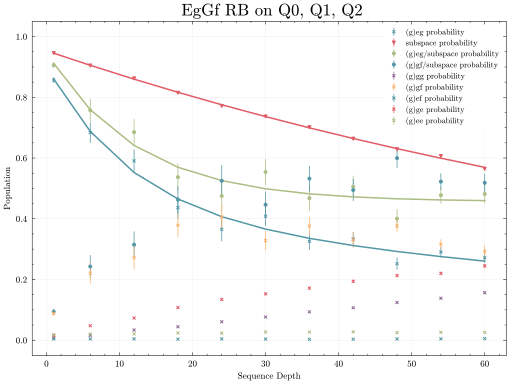

In [51]:
filename_12_1, data_12_1, rbprog_12_1 = run_rb(
    qDrive=qDrive,
    depths=depths,
    variations=variations,
    reps=reps,
    loops=loops,
    singleshot_reps=singleshot_reps,
    gate_char=None,
    validate_variations=False,
    save_data=True)

In [52]:
print("Saved data", filename_12_1)

Saved data S:\QRAM\qram_4QR2\data\data_250119\00035_rb_EgGf_qubit21.h5


###### Second half

In [ ]:
step = 50
end = 300
depths = np.arange(150, end+step, step)

variations = 20
reps = 10000
loops = 20
singleshot_reps = 10000

print('depths', len(depths))
print(depths)

depths 4
[150 200 250 300]


In [ ]:
filename_12_2, data_12_2, rbprog_12_2 = run_rb(
    qDrive=qDrive,
    depths=depths,
    variations=variations,
    reps=reps,
    loops=loops,
    singleshot_reps=singleshot_reps,
    gate_char=None,
    validate_variations=True,
    save_data=True)

In [ ]:
print("Saved data", filename_12_2)

Saved data S:\QRAM\qram_4QR2\data\data_250119\00013_rb_EgGf_qubit21.h5


##### IRB

###### First half

In [ ]:
depths = [1]
step = 9
end = 80
depths = depths + np.arange(step, end+step, step).tolist()
print('depths', len(depths))
print(depths)

variations = 20
reps = 4000
loops = 20
singleshot_reps = 10000

depths 10
[1, 9, 18, 27, 36, 45, 54, 63, 72, 81]


{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-390.00045219204236, 5795.770150727347, 502.42095511476606, -228.8557536534039], 'gain': [0.6, 0.5, 0.5, 0.3], 'readout_length': [4.5, 16, 6.0, 10], 'frequency_ef': [-390.0004521920423, 5794.28348406068, 500.48386902205084, -230.30732892], 'gain_ef': [0.5, 0.6, 0.4, 0.25], 'readout_length_ef': [4.5, 6, 10, 8], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4108.755047003828, 4103.366954082312, 4108.649372291309, 4108.232503550693, 3442.591941352887, 3447.981518133789, 3446.872635941306, 3446.65966586083, 4760.911839134516, 4759.946893523059, 4761.052602755913, 4760.46101643607, 4377.996318964773, 4377.247239665757, 4377.995764386313, 4378.454058265707], 'f_ef': [3882.6760964004225, 0.0, 3882.593023159515, 3882.5465667921762, 3345.3957364303, 3347.507450556916, 3347.003494996075, 3346.9817293387923, 4572.330827468564, 4570.954403324034, 4572.82121588348, 0.0, 4207.223225529803, 4202.99489404

  0%|          | 0/10 [00:00<?, ?it/s]

gate_list_variations= [[['I', 'X', 'X'], ['-X/2,Y/2', 'X', 'X/2,Y/2'], ['X/2,Y/2,X/2', 'X', 'I'], ['-Y/2,X/2', 'X', 'Y/2,-X/2'], ['X/2,Y/2,X/2', 'X', 'I'], ['-X/2,-Y/2', 'X', 'X/2,-Y/2'], ['-X/2,Y/2', 'X', 'X/2,Y/2'], ['-Y/2', 'X', 'Y/2,X'], ['-Y/2,-X/2', 'X', 'Y/2,X/2'], ['X,Y', 'X', 'Y'], ['X,Y', 'X', 'Y'], ['X/2,-Y/2,-X/2', 'X', 'X/2,Y/2,X/2'], ['X/2,Y/2,X/2', 'X', 'I'], ['X/2,Y/2', 'X', '-X/2,Y/2'], ['-X/2,-Y/2', 'X', 'X/2,-Y/2'], ['-Y/2,-X/2', 'X', 'Y/2,X/2'], ['X/2,-Y/2,-X/2', 'X', 'X/2,Y/2,X/2'], ['Y', 'X', 'I'], ['X/2,Y/2,-X/2', 'X', '-X/2,Y/2,-X/2'], ['X/2,Y', 'X', '-X/2,Y']], [['-Y/2,X/2', 'X', 'Y/2,-X/2', 'X', 'X/2,-Y/2,-X/2', 'X', 'X/2,Y/2,X/2', 'X', 'X/2,Y/2', 'X', 'X/2,Y/2,X/2', 'X', '-Y/2,X/2', 'X', '-Y/2,X', 'X', '-Y/2,X/2', 'X', 'I'], ['-Y/2,X', 'X', '-Y/2', 'X', 'X/2,Y/2,-X/2', 'X', 'X/2', 'X', 'X/2,Y/2', 'X', 'X/2,Y/2,-X/2', 'X', 'X/2,Y/2,X/2', 'X', 'Y/2,-X/2', 'X', 'Y/2', 'X', 'X/2,Y'], ['X/2,-Y/2,-X/2', 'X', '-X/2,-Y/2', 'X', '-X/2,-Y/2', 'X', '-Y/2,X', 'X', 'I', '

  0%|          | 0/20 [00:00<?, ?it/s]

Beginning loop 0


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.51938993899387 	 angle (deg): 30.776552344413723 	 threshold ge: 161.30536354243753
Qubit (1) ge
ge fidelity (%): 70.67999999999996 	 angle (deg): 124.0197310861571 	 threshold ge: 46.41917542841135
Qubit (2) ge
ge fidelity (%): 74.22000000000004 	 angle (deg): 7.101013349941174 	 threshold ge: 32.160520710152866
thresholds=[161.30536354243753, 46.41917542841135, 32.160520710152866, 0],
angles=[30.776552344413723, 124.0197310861571, 7.101013349941174, 0],
ge_avgs=[array([110.7866542 , -21.88052692, 220.29628365, -87.10064146]), array([-29.46441302, -13.1581115 , -49.64720503, -43.05811522]), array([14.4006815 , 46.60700049, 64.65664579, 40.3463866 ]), array([0., 0., 0., 0.])],
counts_calib=[[7274, 1061, 913, 127, 496, 68, 57, 4], [1121, 7063, 130, 933, 90, 529, 12, 122], [667, 7094, 120, 1404, 61, 502, 9, 143], [1444, 202, 6539, 1082, 164, 26, 458, 85], [184, 1445, 808, 6816, 21, 160, 62, 504], [170, 1380, 676, 7069, 17, 168, 34, 486], [811, 129, 71, 12

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.58926592659267
Qubit (1) ge
ge fidelity (%): 60.97
Qubit (2) gf
gf fidelity (%): 62.72
thresholds_f=[133.34336981768172, 52.92026241559374, -47.86183663528621, 0],
angles_f=[33.29899152236443, 105.55447475238687, -65.14661219008931, 0],
gf_avgs=[array([101.27288357,  -2.25686671, 188.74884638, -59.71563017]), array([-54.22937048, -21.16717005, -63.88548958, -55.85789821]), array([-23.04131592, -66.03038952,  -6.78298141, -30.93006204]), array([0., 0., 0., 0.])],
counts_calib_f=[[6761, 733, 1560, 182, 512, 72, 159, 21], [6087, 1112, 1688, 288, 515, 94, 186, 30], [1887, 5078, 584, 1618, 179, 404, 74, 176], [1533, 213, 6487, 872, 236, 26, 554, 79], [1645, 240, 6269, 1004, 200, 27, 522, 93], [443, 1350, 1772, 5582, 67, 143, 162, 481], [701, 190, 161, 36, 6165, 966, 1533, 248], [661, 117, 185, 30, 5817, 910, 1971, 309], [203, 622, 63, 189, 1614, 4705, 561, 2043], [248, 42, 616, 84, 1523, 232, 6420, 835], [222, 51, 599, 87, 1447, 247, 6406, 941], [67, 208, 20

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 1


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.22926292629258 	 angle (deg): 22.595896580467773 	 threshold ge: 164.1849486396709
Qubit (1) ge
ge fidelity (%): 70.70891889188921 	 angle (deg): 122.29037638223126 	 threshold ge: 44.33557272281919
Qubit (2) ge
ge fidelity (%): 74.72846384638467 	 angle (deg): -125.34145787850574 	 threshold ge: 37.360691916001876
thresholds=[164.1849486396709, 44.33557272281919, 37.360691916001876, 0],
angles=[22.595896580467773, 122.29037638223126, -125.34145787850574, 0],
ge_avgs=[array([115.76779595,  -7.7506903 , 234.10602844, -57.00019877]), array([-30.0146425 , -12.663227  , -48.77837381, -42.35555556]), array([-47.48021715, -19.93983397, -77.02052946,  21.71749913]), array([0., 0., 0., 0.])],
counts_calib=[[7340, 868, 926, 118, 568, 75, 87, 18], [1173, 6806, 165, 1104, 92, 491, 24, 145], [857, 6505, 171, 1545, 67, 492, 36, 327], [1431, 158, 6738, 757, 181, 18, 634, 83], [332, 1470, 1157, 6045, 46, 158, 115, 677], [198, 1081, 947, 6697, 25, 153, 115, 784], [741,

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.83
Qubit (1) ge
ge fidelity (%): 61.06999999999998
Qubit (2) gf
gf fidelity (%): 62.440000000000005
thresholds_f=[132.37349971860928, 58.931822837578494, -44.18658665076916, 0],
angles_f=[22.922242741815854, 109.89565253446682, -93.37487448288374, 0],
gf_avgs=[array([ 96.76547706,   9.79954262, 197.05566614, -32.6105801 ]), array([-51.0690083 , -21.09365214, -63.67590874, -55.92808833]), array([ 10.82119059, -65.05178079,   8.57802422, -27.01324242]), array([0., 0., 0., 0.])],
counts_calib_f=[[6875, 959, 1197, 150, 591, 91, 119, 18], [6929, 799, 1239, 142, 636, 69, 169, 17], [1936, 5589, 415, 1230, 157, 474, 56, 143], [1932, 198, 6443, 552, 273, 14, 548, 40], [2010, 254, 6121, 702, 248, 40, 555, 70], [539, 1646, 1712, 5279, 77, 190, 156, 401], [660, 93, 146, 13, 6949, 743, 1274, 122], [771, 130, 166, 25, 6435, 838, 1436, 199], [224, 555, 62, 119, 2021, 4955, 561, 1503], [299, 65, 604, 86, 1845, 280, 6170, 651], [314, 73, 628, 100, 1825, 289, 6047, 724],

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 2


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.05926392639262 	 angle (deg): 14.901186755971992 	 threshold ge: 163.53680227878286
Qubit (1) ge
ge fidelity (%): 68.97879387938792 	 angle (deg): 122.46534983760343 	 threshold ge: 42.860708675648674
Qubit (2) ge
ge fidelity (%): 74.37000000000002 	 angle (deg): 149.82460228317993 	 threshold ge: 37.54171069103842
thresholds=[163.53680227878286, 42.860708675648674, 37.54171069103842, 0],
angles=[14.901186755971992, 122.46534983760343, 149.82460228317993, 0],
ge_avgs=[array([114.09500174,   8.80077576, 237.54766577, -24.05017641]), array([-28.81802942, -13.20372417, -47.00520743, -41.7900105 ]), array([ 13.90862637, -47.66146674, -30.04200819, -73.2160885 ]), array([0., 0., 0., 0.])],
counts_calib=[[7233, 846, 1017, 154, 554, 84, 92, 20], [1149, 6602, 211, 1285, 79, 518, 22, 134], [781, 6431, 155, 1880, 49, 459, 19, 226], [1344, 163, 5926, 754, 296, 36, 1323, 158], [275, 1339, 1151, 6498, 30, 124, 85, 498], [145, 975, 831, 7011, 23, 178, 89, 748], [787,

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.77000000000001
Qubit (1) ge
ge fidelity (%): 59.78812781278129
Qubit (2) gf
gf fidelity (%): 65.13744674467445
thresholds_f=[136.9682091385626, 53.601136855703395, -46.8972612366845, 0],
angles_f=[15.772928129199547, 107.63342808102556, -164.90990436494982, 0],
gf_avgs=[array([ 97.96815072,  24.05107258, 199.85787735,  -4.72882373]), array([-53.46121036, -20.95368828, -64.37380917, -55.28504927]), array([ 67.63395716, -11.14477227,  29.33716494,  -0.81860645]), array([0., 0., 0., 0.])],
counts_calib_f=[[6585, 768, 1598, 185, 586, 57, 200, 21], [5983, 1179, 1726, 321, 452, 86, 221, 32], [1739, 5142, 501, 1732, 154, 403, 74, 255], [1620, 205, 6660, 712, 191, 25, 527, 60], [1492, 251, 6398, 969, 212, 33, 559, 86], [440, 1267, 1702, 5784, 66, 136, 131, 474], [642, 144, 149, 28, 6198, 989, 1632, 218], [694, 105, 174, 25, 5815, 871, 2013, 303], [189, 600, 53, 179, 1682, 4697, 588, 2012], [253, 27, 680, 61, 1517, 150, 6613, 699], [261, 161, 599, 215, 1459, 391

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 3


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.66936993699369 	 angle (deg): 6.845384412316631 	 threshold ge: 164.32554946834824
Qubit (1) ge
ge fidelity (%): 71.68999999999998 	 angle (deg): 124.10369414786504 	 threshold ge: 46.57756417648331
Qubit (2) ge
ge fidelity (%): 74.0 	 angle (deg): -154.53650165820474 	 threshold ge: 35.63237247459067
thresholds=[164.32554946834824, 46.57756417648331, 35.63237247459067, 0],
angles=[6.845384412316631, 124.10369414786504, -154.53650165820474, 0],
ge_avgs=[array([112.78649674,  25.69493509, 239.32774928,  10.50413517]), array([-30.65307792, -13.2714293 , -50.93952712, -43.23022863]), array([-30.87548676, -43.39695605, -76.70744357, -21.5720643 ]), array([0., 0., 0., 0.])],
counts_calib=[[7410, 874, 955, 119, 517, 49, 66, 10], [1263, 6857, 134, 770, 118, 523, 41, 294], [784, 6982, 105, 1125, 72, 491, 30, 411], [1283, 171, 6765, 787, 198, 32, 679, 85], [203, 1582, 1040, 6139, 24, 174, 112, 726], [237, 1302, 843, 6601, 18, 183, 96, 720], [810, 73, 103, 6, 743

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.31923892389241
Qubit (1) ge
ge fidelity (%): 61.34000000000002
Qubit (2) gf
gf fidelity (%): 63.209999999999944
thresholds_f=[133.76442704074944, 54.8276447956379, -43.373704938248835, 0],
angles_f=[7.019648938138024, 108.0699557031243, -130.7086155258238, 0],
gf_avgs=[array([ 90.53133082,  36.15701802, 196.27010224,  23.13711925]), array([-52.09332729, -20.75168958, -63.43473196, -55.51247526]), array([ 49.02083805, -44.92630566,  24.39118057, -16.30039508]), array([0., 0., 0., 0.])],
counts_calib_f=[[6825, 744, 1510, 141, 558, 65, 140, 17], [6840, 689, 1514, 154, 560, 52, 171, 20], [2009, 5201, 512, 1464, 152, 429, 57, 176], [1618, 203, 6767, 550, 249, 18, 551, 44], [1697, 170, 6661, 661, 179, 22, 548, 62], [532, 1293, 2045, 5274, 61, 141, 209, 445], [787, 115, 174, 20, 6505, 704, 1560, 135], [781, 86, 175, 21, 6233, 601, 1913, 190], [248, 598, 58, 165, 2007, 4591, 628, 1705], [246, 25, 667, 56, 1553, 168, 6752, 533], [273, 31, 589, 72, 1446, 164, 670

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 4


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.99934693469345 	 angle (deg): -2.3594306033288457 	 threshold ge: 168.31012669408378
Qubit (1) ge
ge fidelity (%): 70.5 	 angle (deg): 124.70647583353725 	 threshold ge: 46.25314504575919
Qubit (2) ge
ge fidelity (%): 75.1289798979898 	 angle (deg): 148.50640814955835 	 threshold ge: 35.28969284874047
thresholds=[168.31012669408378, 46.25314504575919, 35.28969284874047, 0],
angles=[-2.3594306033288457, 124.70647583353725, 148.50640814955835, 0],
ge_avgs=[array([108.31528307,  39.34698582, 238.60536679,  44.7153445 ]), array([-29.92123508, -12.77917583, -50.27049359, -42.16014153]), array([ 17.90206196, -48.02703798, -25.94716923, -74.89113597]), array([0., 0., 0., 0.])],
counts_calib=[[7469, 910, 831, 126, 521, 68, 68, 7], [1169, 7204, 122, 793, 80, 513, 9, 110], [859, 7009, 104, 1298, 64, 523, 10, 133], [1534, 189, 6654, 871, 178, 20, 494, 60], [239, 1601, 952, 6364, 21, 124, 86, 613], [114, 1269, 636, 7079, 15, 160, 62, 665], [853, 100, 77, 12, 6884, 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.48999999999998
Qubit (1) ge
ge fidelity (%): 61.75999999999999
Qubit (2) gf
gf fidelity (%): 62.03700670067009
thresholds_f=[132.59784459099725, 53.63169113553998, -41.81774427500514, 0],
angles_f=[-0.22750637454569883, 107.62678551410667, 137.8865781619696, 0],
gf_avgs=[array([ 84.94687301,  48.83210883, 191.30458712,  49.25442938]), array([-52.5591847 , -20.61751888, -63.8515191 , -56.15781129]), array([43.63997839, 49.7121751 , 15.56914118, 24.33628037]), array([0., 0., 0., 0.])],
counts_calib_f=[[6752, 681, 1575, 166, 593, 46, 171, 16], [6727, 700, 1687, 170, 486, 46, 163, 21], [2071, 4994, 617, 1559, 153, 377, 77, 152], [1569, 132, 6925, 503, 220, 11, 592, 48], [1703, 183, 6724, 594, 173, 28, 544, 51], [476, 1212, 1916, 5435, 84, 194, 212, 471], [751, 103, 162, 17, 6511, 595, 1705, 156], [733, 92, 175, 28, 6154, 614, 1992, 212], [203, 583, 63, 154, 1853, 4648, 718, 1778], [276, 43, 587, 57, 1546, 155, 6794, 542], [293, 50, 676, 96, 1472, 238, 6452,

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 5


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.23925692569253 	 angle (deg): -9.21966669440614 	 threshold ge: 160.94265955754236
Qubit (1) ge
ge fidelity (%): 71.75896789678968 	 angle (deg): 125.21524764798923 	 threshold ge: 44.91370138643659
Qubit (2) ge
ge fidelity (%): 76.15893689368937 	 angle (deg): 29.590110921382532 	 threshold ge: 35.72606167003215
thresholds=[160.94265955754236, 44.91370138643659, 35.72606167003215, 0],
angles=[-9.21966669440614, 125.21524764798923, 29.590110921382532, 0],
ge_avgs=[array([101.19283336,  53.21910695, 227.48444161,  73.71837315]), array([-28.71697689, -12.52380142, -49.87678669, -42.50280326]), array([33.07459441, 35.8100344 , 78.97890787,  9.7432337 ]), array([0., 0., 0., 0.])],
counts_calib=[[7303, 952, 869, 120, 570, 82, 85, 19], [1024, 7008, 139, 1072, 74, 520, 10, 153], [707, 7056, 111, 1379, 64, 520, 8, 155], [1358, 193, 6695, 977, 163, 19, 515, 80], [192, 1479, 949, 6609, 25, 157, 71, 518], [143, 1158, 643, 7326, 17, 155, 42, 516], [813, 103, 98, 9,

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 80.23
Qubit (1) ge
ge fidelity (%): 59.31999999999999
Qubit (2) gf
gf fidelity (%): 63.649999999999984
thresholds_f=[141.61041105091275, 54.57743115578985, -46.47181946405108, 0],
angles_f=[-8.431051862298787, 107.03315814768595, -0.8463417464952898, 0],
gf_avgs=[array([ 77.49758032,  60.04468698, 183.88384544,  75.81336259]), array([-52.9517121 , -21.26876055, -63.32929783, -55.14218915]), array([-67.99229329,  -8.38301429, -29.21545   ,  -7.81018242]), array([0., 0., 0., 0.])],
counts_calib_f=[[6789, 799, 1524, 162, 528, 63, 123, 12], [6524, 1002, 1520, 232, 489, 67, 143, 23], [1908, 5379, 503, 1517, 149, 366, 46, 132], [1809, 206, 6601, 616, 209, 27, 481, 51], [1697, 264, 6440, 896, 186, 30, 437, 50], [506, 1445, 1856, 5468, 49, 153, 148, 375], [903, 129, 192, 29, 6300, 679, 1606, 162], [757, 104, 181, 16, 6054, 790, 1865, 233], [254, 740, 72, 187, 1794, 4583, 640, 1730], [271, 55, 801, 108, 1586, 198, 6307, 674], [311, 61, 706, 147, 1493, 243, 6157, 88

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 6


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 80.67916191619162 	 angle (deg): -16.903308728996507 	 threshold ge: 169.38623896606688
Qubit (1) ge
ge fidelity (%): 69.60887588758877 	 angle (deg): 124.19773166128697 	 threshold ge: 45.71406701291262
Qubit (2) ge
ge fidelity (%): 76.16888888888889 	 angle (deg): -123.30288706792194 	 threshold ge: 35.009943629754446
thresholds=[169.38623896606688, 45.71406701291262, 35.009943629754446, 0],
angles=[-16.903308728996507, 124.19773166128697, -123.30288706792194, 0],
ge_avgs=[array([ 94.83809219,  69.2984911 , 213.36859877, 105.31828936]), array([-29.53212354, -13.66230189, -49.12038364, -42.48800608]), array([-48.13354362, -18.94355182, -77.3418    ,  25.5168866 ]), array([0., 0., 0., 0.])],
counts_calib=[[7199, 936, 856, 151, 590, 77, 158, 33], [995, 7141, 121, 1005, 74, 406, 24, 234], [660, 7054, 111, 1466, 49, 469, 15, 176], [1464, 179, 6448, 894, 171, 28, 700, 116], [198, 1486, 844, 6511, 20, 169, 90, 682], [202, 1334, 696, 6798, 20, 175, 65, 710], [87

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.25
Qubit (1) ge
ge fidelity (%): 60.97999999999999
Qubit (2) gf
gf fidelity (%): 62.780000000000015
thresholds_f=[134.45062910561654, 56.24463780345142, -45.467844822982556, 0],
angles_f=[-15.445382396612867, 109.25555558770287, 53.807803367366446, 0],
gf_avgs=[array([ 66.09678944,  72.87944016, 172.02278444, 102.14660658]), array([-51.76757824, -20.51522062, -64.00848714, -55.55688394]), array([-46.10315908,  48.94515241, -23.61832826,  18.21474616]), array([0., 0., 0., 0.])],
counts_calib_f=[[6771, 863, 1432, 173, 571, 66, 111, 13], [6544, 1085, 1455, 244, 461, 69, 124, 18], [1888, 5426, 518, 1390, 150, 420, 59, 149], [1750, 213, 6634, 673, 191, 23, 470, 46], [1630, 264, 6496, 866, 190, 34, 464, 56], [486, 1360, 1853, 5535, 54, 143, 151, 418], [750, 81, 163, 26, 6549, 740, 1520, 171], [762, 132, 158, 20, 6114, 867, 1705, 242], [237, 666, 56, 179, 1825, 4767, 597, 1673], [270, 18, 667, 88, 1617, 176, 6517, 647], [262, 67, 634, 109, 1538, 257, 6255, 878

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 7


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.24 	 angle (deg): -24.419633550453568 	 threshold ge: 156.79677844303166
Qubit (1) ge
ge fidelity (%): 72.93893489348935 	 angle (deg): 117.14689696323903 	 threshold ge: 42.68222545918574
Qubit (2) ge
ge fidelity (%): 73.9 	 angle (deg): -114.03434905569958 	 threshold ge: 33.07401083704799
thresholds=[156.79677844303166, 42.68222545918574, 33.07401083704799, 0],
angles=[-24.419633550453568, 117.14689696323903, -114.03434905569958, 0],
ge_avgs=[array([ 80.0540411 ,  82.20191621, 195.23565391, 134.49821136]), array([-33.51711585, -10.28724739, -50.49856507, -43.40503746]), array([-49.53520239, -12.96457434, -69.93786495,  32.78672008]), array([0., 0., 0., 0.])],
counts_calib=[[7281, 954, 892, 136, 569, 68, 92, 8], [1244, 6976, 119, 964, 76, 491, 12, 118], [704, 6830, 131, 1587, 50, 484, 19, 195], [1257, 167, 6825, 947, 139, 21, 569, 75], [218, 1058, 1104, 6787, 32, 163, 80, 558], [105, 983, 677, 7513, 16, 100, 61, 545], [833, 107, 81, 19, 6246, 812, 167

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.83999999999997
Qubit (1) ge
ge fidelity (%): 57.73824182418241
Qubit (2) gf
gf fidelity (%): 58.57000000000001
thresholds_f=[138.82614867156863, 54.40997122833471, -40.82706952029868, 0],
angles_f=[-24.453815553258178, 106.3884506834769, 150.4120874819388, 0],
gf_avgs=[array([ 54.47495217,  78.75388242, 156.53129653, 125.16432467]), array([-52.23977998, -21.63341053, -62.06500944, -55.04153776]), array([50.71969105, 37.05147399, 20.89008734, 20.1142235 ]), array([0., 0., 0., 0.])],
counts_calib_f=[[6623, 917, 1492, 194, 536, 50, 169, 19], [6876, 687, 1566, 152, 483, 53, 163, 20], [2138, 5000, 574, 1477, 189, 390, 68, 164], [1912, 226, 6487, 572, 200, 17, 534, 52], [1702, 235, 6468, 666, 200, 32, 635, 62], [555, 1355, 1937, 5324, 71, 150, 179, 429], [800, 46, 185, 17, 6825, 420, 1612, 95], [767, 89, 192, 26, 6328, 641, 1790, 167], [264, 626, 69, 176, 2042, 4491, 663, 1669], [283, 80, 814, 137, 1656, 220, 6243, 567], [307, 30, 759, 73, 1560, 159, 6587, 52

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 8


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.7793669366937 	 angle (deg): -31.836880365909607 	 threshold ge: 159.7450732146054
Qubit (1) ge
ge fidelity (%): 70.5 	 angle (deg): 121.97863296086568 	 threshold ge: 43.95739341634986
Qubit (2) ge
ge fidelity (%): 72.31 	 angle (deg): 171.26503179986156 	 threshold ge: 32.297976006483324
thresholds=[159.7450732146054, 43.95739341634986, 32.297976006483324, 0],
angles=[-31.836880365909607, 121.97863296086568, 171.26503179986156, 0],
ge_avgs=[array([ 67.36707004,  92.37652113, 176.81064096, 160.33197822]), array([-29.41399086, -12.66156899, -47.85359204, -42.19560212]), array([ -2.2202981 , -51.47612789, -50.33659045, -58.86901156]), array([0., 0., 0., 0.])],
counts_calib=[[7214, 1170, 827, 141, 490, 68, 79, 11], [1146, 7004, 154, 1054, 73, 432, 13, 124], [820, 6807, 156, 1523, 48, 479, 9, 158], [1505, 234, 6460, 1148, 136, 22, 426, 69], [192, 1102, 959, 7082, 18, 128, 65, 454], [162, 1051, 735, 7365, 10, 134, 44, 499], [762, 114, 88, 10, 6948, 1091, 82

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.97999999999999
Qubit (1) ge
ge fidelity (%): 60.780000000000015
Qubit (2) gf
gf fidelity (%): 64.43000000000002
thresholds_f=[133.23097099698214, 51.374486174372116, -45.90503071444489, 0],
angles_f=[-30.77603345211291, 105.80528612750955, -128.18856072974498, 0],
gf_avgs=[array([ 44.90133061,  89.11515521, 136.52447381, 143.68157851]), array([-52.40164308, -21.0904115 , -62.30184021, -56.06464997]), array([ 49.54739772, -48.53466589,  24.81580495, -17.0935027 ]), array([0., 0., 0., 0.])],
counts_calib_f=[[6723, 668, 1729, 155, 509, 47, 149, 20], [6274, 828, 1890, 236, 490, 57, 202, 23], [1872, 4937, 638, 1880, 122, 323, 54, 174], [1471, 221, 6741, 864, 160, 19, 470, 54], [1362, 193, 6846, 923, 128, 15, 468, 65], [416, 1168, 1977, 5713, 55, 130, 151, 390], [757, 121, 173, 34, 6022, 842, 1835, 216], [647, 166, 179, 36, 5655, 899, 2117, 301], [190, 634, 58, 176, 1686, 4830, 573, 1853], [267, 50, 750, 110, 1295, 194, 6491, 843], [228, 53, 728, 123, 1216, 2

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 9


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.56000000000002 	 angle (deg): -40.00699408462716 	 threshold ge: 155.81325588278708
Qubit (1) ge
ge fidelity (%): 69.47882688268827 	 angle (deg): 123.95858545082189 	 threshold ge: 46.64517440658522
Qubit (2) ge
ge fidelity (%): 75.23 	 angle (deg): -134.2342386154523 	 threshold ge: 37.52025764363245
thresholds=[155.81325588278708, 46.64517440658522, 37.52025764363245, 0],
angles=[-40.00699408462716, 123.95858545082189, -134.2342386154523, 0],
ge_avgs=[array([ 52.92815514, 102.27532605, 150.18640463, 183.90492084]), array([-29.68820997, -14.41172338, -48.95201731, -43.01606966]), array([-44.66325008, -26.93912615, -80.91792816,  10.29783033]), array([0., 0., 0., 0.])],
counts_calib=[[7201, 904, 985, 134, 591, 72, 94, 19], [1084, 6823, 159, 1121, 85, 544, 22, 162], [970, 7079, 169, 1025, 71, 544, 14, 128], [1444, 170, 6596, 893, 187, 27, 594, 89], [264, 1163, 1126, 6222, 41, 157, 158, 869], [164, 1130, 805, 6866, 25, 187, 92, 731], [789, 95, 82, 13, 72

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.22928392839286
Qubit (1) ge
ge fidelity (%): 59.058129812981306
Qubit (2) gf
gf fidelity (%): 64.16722472247226
thresholds_f=[136.82276905265059, 54.94430792381544, -46.57739190359227, 0],
angles_f=[-39.466493217197744, 109.34982926161264, -10.513157873115466, 0],
gf_avgs=[array([ 29.8935937 ,  96.01238813, 113.57999986, 164.9159809 ]), array([-52.40865643, -20.8882554 , -64.26549094, -54.65189853]), array([-65.88313327, -22.58321709, -27.18882959, -15.40246009]), array([0., 0., 0., 0.])],
counts_calib_f=[[6780, 646, 1658, 181, 529, 49, 141, 16], [6556, 773, 1744, 201, 498, 50, 156, 22], [1942, 5161, 575, 1597, 134, 381, 52, 158], [1745, 207, 6695, 698, 157, 17, 419, 62], [1536, 345, 6356, 1087, 160, 32, 408, 76], [460, 1320, 1938, 5515, 52, 129, 149, 437], [757, 99, 167, 20, 6395, 791, 1581, 190], [712, 160, 173, 45, 5806, 1000, 1801, 303], [219, 607, 64, 201, 1789, 4689, 579, 1852], [289, 58, 778, 103, 1509, 214, 6291, 758], [283, 60, 769, 125, 1379, 

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 10


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.72 	 angle (deg): -48.75721969429154 	 threshold ge: 158.6481004121349
Qubit (1) ge
ge fidelity (%): 66.66878587858787 	 angle (deg): 106.22585538464145 	 threshold ge: 41.0322351548624
Qubit (2) ge
ge fidelity (%): 76.42999999999999 	 angle (deg): -33.418652586491405 	 threshold ge: 34.91017292457602
thresholds=[158.6481004121349, 41.0322351548624, 34.91017292457602, 0],
angles=[-48.75721969429154, 106.22585538464145, -33.418652586491405, 0],
ge_avgs=[array([ 36.44849906, 106.84737062, 120.02335289, 202.17045427]), array([-41.51259257, -10.85961487, -50.69481617, -42.41188358]), array([-18.26778524,  47.01302333,  25.82728448,  76.10896555]), array([0., 0., 0., 0.])],
counts_calib=[[7120, 973, 1104, 105, 550, 69, 66, 13], [993, 7247, 150, 915, 74, 498, 10, 113], [827, 7072, 115, 1279, 50, 516, 9, 132], [1657, 218, 6404, 880, 158, 26, 571, 86], [225, 1430, 836, 6648, 22, 145, 66, 628], [172, 1280, 703, 6955, 16, 141, 71, 662], [878, 112, 127, 15, 7126, 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.02
Qubit (1) ge
ge fidelity (%): 61.4683618361836
Qubit (2) gf
gf fidelity (%): 64.5772687268727
thresholds_f=[131.9532853300543, 56.00371993206617, -45.0463827635936, 0],
angles_f=[-47.537188592040934, 109.42564474002948, -58.447515139497476, 0],
gf_avgs=[array([ 15.83732453,  96.66460043,  91.13013314, 178.93942996]), array([-51.64938676, -21.08937493, -63.94383039, -55.95152773]), array([-27.53478962, -62.96779834,  -6.85144124, -29.28493825]), array([0., 0., 0., 0.])],
counts_calib_f=[[7012, 673, 1481, 160, 492, 45, 128, 9], [6705, 874, 1529, 178, 492, 74, 135, 13], [1971, 5335, 507, 1469, 150, 401, 40, 127], [1660, 216, 6725, 671, 199, 15, 461, 53], [1560, 260, 6569, 918, 167, 25, 453, 48], [439, 1668, 1616, 5600, 54, 123, 120, 380], [759, 81, 178, 13, 6676, 567, 1595, 131], [745, 125, 162, 24, 6005, 944, 1761, 234], [200, 626, 52, 191, 1637, 4931, 533, 1830], [301, 54, 701, 98, 1527, 219, 6432, 668], [256, 39, 683, 79, 1442, 209, 6534, 758], [79, 

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 11


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.49999999999996 	 angle (deg): -56.81847701170825 	 threshold ge: 163.88135932819895
Qubit (1) ge
ge fidelity (%): 69.13000000000001 	 angle (deg): 100.85069538137294 	 threshold ge: 36.745674924286206
Qubit (2) ge
ge fidelity (%): 75.78999999999998 	 angle (deg): 49.7629166259721 	 threshold ge: 36.77990809227332
thresholds=[163.88135932819895, 36.745674924286206, 36.77990809227332, 0],
angles=[-56.81847701170825, 100.85069538137294, 49.7629166259721, 0],
ge_avgs=[array([ 23.97504812, 111.11355253,  96.06725376, 221.35956918]), array([-43.23910338,  -9.94124228, -49.61078964, -43.18296889]), array([ 44.38850201,  23.28622187,  78.60620933, -17.151849  ]), array([0., 0., 0., 0.])],
counts_calib=[[7474, 906, 891, 120, 477, 59, 59, 14], [1125, 7217, 131, 867, 70, 438, 12, 140], [737, 6367, 161, 2076, 49, 360, 19, 231], [1636, 203, 6676, 844, 149, 18, 424, 50], [193, 1320, 977, 6888, 12, 117, 53, 440], [180, 1317, 787, 7109, 20, 122, 29, 436], [787, 84, 66,

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.36000000000001
Qubit (1) ge
ge fidelity (%): 58.04999999999998
Qubit (2) gf
gf fidelity (%): 64.45738773877387
thresholds_f=[129.76224898744792, 45.18648712714618, -44.294617545039515, 0],
angles_f=[-55.94342321563312, 96.04650388202037, 115.45177915032144, 0],
gf_avgs=[array([  3.56949001,  97.52430369,  66.11011679, 190.04739023]), array([-58.42858171, -20.75989528, -62.04890836, -54.93812952]), array([20.17349089, 63.67174323,  3.2137138 , 28.03768206]), array([0., 0., 0., 0.])],
counts_calib_f=[[6766, 771, 1562, 167, 527, 63, 125, 19], [6593, 871, 1618, 200, 500, 53, 143, 22], [1899, 5368, 459, 1520, 135, 412, 51, 156], [1815, 310, 6247, 961, 169, 34, 416, 48], [1748, 223, 6510, 796, 188, 20, 470, 45], [482, 1434, 1691, 5610, 55, 132, 145, 451], [695, 77, 158, 16, 6631, 688, 1566, 169], [732, 103, 184, 27, 6060, 841, 1772, 281], [201, 597, 54, 156, 1726, 4869, 527, 1870], [240, 36, 717, 79, 1659, 182, 6452, 635], [228, 40, 671, 78, 1569, 225, 6370, 

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 12


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.48939093909391 	 angle (deg): -64.66101516301556 	 threshold ge: 160.91907653204163
Qubit (1) ge
ge fidelity (%): 69.35999999999997 	 angle (deg): 111.24235961515373 	 threshold ge: 39.8816722493349
Qubit (2) ge
ge fidelity (%): 75.74 	 angle (deg): 53.635038766410176 	 threshold ge: 36.79145408353
thresholds=[160.91907653204163, 39.8816722493349, 36.79145408353, 0],
angles=[-64.66101516301556, 111.24235961515373, 53.635038766410176, 0],
ge_avgs=[array([  8.40445224, 113.27101997,  64.68984233, 232.13429096]), array([-38.79629204, -10.36233908, -51.74398706, -43.67042979]), array([ 45.57682648,  20.58659414,  76.90115328, -21.95513261]), array([0., 0., 0., 0.])],
counts_calib=[[6997, 830, 1398, 156, 455, 58, 97, 9], [1112, 6966, 188, 1166, 55, 389, 21, 103], [683, 6883, 138, 1644, 43, 424, 14, 171], [1124, 148, 7183, 913, 134, 20, 425, 53], [171, 1083, 1145, 7004, 14, 103, 64, 416], [112, 996, 750, 7529, 15, 91, 43, 464], [702, 100, 114, 17, 7089, 866, 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.92999999999999
Qubit (1) ge
ge fidelity (%): 58.50000000000002
Qubit (2) gf
gf fidelity (%): 66.72999999999998
thresholds_f=[131.68325107075614, 47.65443849495425, -43.577665925099396, 0],
angles_f=[-64.27149246801918, 99.48810743810034, -156.705322598244, 0],
gf_avgs=[array([ -9.21727041,  98.39512865,  37.80104689, 195.96770803]), array([-57.99619224, -20.82722794, -63.72866614, -55.12687482]), array([ 65.80021217, -17.44190667,  28.20272454,  -1.25401071]), array([0., 0., 0., 0.])],
counts_calib_f=[[6802, 609, 1703, 142, 538, 63, 132, 11], [6690, 834, 1621, 208, 452, 46, 121, 28], [1748, 5260, 535, 1643, 153, 391, 67, 203], [1764, 182, 6737, 599, 206, 20, 455, 37], [1669, 202, 6679, 743, 158, 21, 483, 45], [395, 1325, 1820, 5677, 59, 157, 137, 430], [796, 86, 181, 17, 6385, 628, 1745, 162], [706, 115, 172, 30, 5687, 787, 2204, 299], [179, 499, 65, 200, 1653, 4364, 764, 2276], [256, 27, 796, 91, 1457, 124, 6653, 596], [229, 32, 698, 96, 1455, 161, 662

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 13


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.22000000000004 	 angle (deg): -72.93117386139629 	 threshold ge: 161.9419251610249
Qubit (1) ge
ge fidelity (%): 67.02 	 angle (deg): 108.14857408746693 	 threshold ge: 39.92079014244315
Qubit (2) ge
ge fidelity (%): 75.63000000000001 	 angle (deg): -100.76453660001721 	 threshold ge: 37.37813024326026
thresholds=[161.9419251610249, 39.92079014244315, 37.37813024326026, 0],
angles=[-72.93117386139629, 108.14857408746693, -100.76453660001721, 0],
ge_avgs=[array([ -7.83115412, 114.20510991,  29.98531071, 237.3678487 ]), array([-43.14665137, -10.48796852, -53.29311591, -41.44222533]), array([-49.71020309,   2.93544059, -59.50923842,  54.47708323]), array([0., 0., 0., 0.])],
counts_calib=[[7019, 927, 1231, 157, 528, 57, 76, 5], [1085, 7124, 142, 981, 73, 484, 12, 99], [735, 6985, 148, 1449, 62, 434, 19, 168], [1489, 188, 6793, 913, 161, 18, 384, 54], [269, 1329, 1151, 6645, 26, 121, 65, 394], [124, 1167, 658, 7373, 17, 124, 37, 500], [828, 99, 78, 9, 7226, 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.76000000000002
Qubit (1) ge
ge fidelity (%): 59.00822282228223
Qubit (2) gf
gf fidelity (%): 67.81999999999996
thresholds_f=[137.97624592371142, 46.19088455241659, -45.22831698651585, 0],
angles_f=[-71.2990401944475, 97.6968953786013, 87.72666734212584, 0],
gf_avgs=[array([-25.50454826,  95.30475622,  10.52274197, 201.73692923]), array([-58.64709338, -20.22319425, -63.38603505, -55.28747216]), array([-10.48186292,  67.32179209,  -8.83035485,  25.71996937]), array([0., 0., 0., 0.])],
counts_calib_f=[[6920, 720, 1640, 178, 394, 48, 91, 9], [6695, 786, 1669, 187, 469, 53, 121, 20], [1686, 5499, 457, 1718, 108, 345, 38, 149], [1816, 213, 6716, 696, 153, 15, 346, 45], [1688, 245, 6548, 861, 138, 21, 446, 53], [453, 1480, 1711, 5756, 47, 130, 119, 304], [699, 85, 184, 18, 6564, 651, 1647, 152], [710, 82, 172, 22, 6161, 711, 1931, 211], [231, 623, 68, 212, 1683, 4599, 614, 1970], [292, 57, 797, 124, 1533, 229, 6187, 781], [225, 48, 718, 130, 1422, 204, 6429, 8

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 14


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.92941294129413 	 angle (deg): -82.2044776930414 	 threshold ge: 166.20887118605637
Qubit (1) ge
ge fidelity (%): 68.12841684168416 	 angle (deg): 113.81131650739384 	 threshold ge: 45.406552165398296
Qubit (2) ge
ge fidelity (%): 74.12875787578758 	 angle (deg): -149.40239704724897 	 threshold ge: 35.42472270155222
thresholds=[166.20887118605637, 45.406552165398296, 35.42472270155222, 0],
angles=[-82.2044776930414, 113.81131650739384, -149.40239704724897, 0],
ge_avgs=[array([-24.08769103, 109.96860876,  -5.82428871, 243.37223285]), array([-40.67516128, -11.48409379, -54.91192037, -43.74588842]), array([-35.39710184, -36.30310076, -79.32074015, -10.32921373]), array([0., 0., 0., 0.])],
counts_calib=[[6767, 1048, 1384, 204, 445, 81, 61, 10], [1026, 7215, 141, 986, 70, 436, 18, 108], [669, 7305, 117, 995, 46, 520, 30, 318], [1100, 230, 6858, 1081, 176, 30, 446, 79], [168, 1397, 876, 6756, 18, 166, 63, 556], [137, 1314, 619, 6927, 26, 177, 60, 740], [720, 1

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.3492579257926
Qubit (1) ge
ge fidelity (%): 60.03000000000001
Qubit (2) gf
gf fidelity (%): 67.20767376737675
thresholds_f=[128.0901639760679, 52.936771736360484, -48.147760006490344, 0],
angles_f=[-80.28764260883837, 107.43140072394893, -61.50069282398343, 0],
gf_avgs=[array([-37.8788848 ,  91.61395543, -20.44210137, 193.49103452]), array([-53.08562322, -20.61916099, -63.94663684, -55.21025176]), array([-26.74095941, -64.50179704,  -7.01164743, -28.16387679]), array([0., 0., 0., 0.])],
counts_calib_f=[[6612, 785, 1641, 188, 549, 64, 145, 16], [6313, 917, 1725, 254, 522, 79, 168, 22], [1610, 5568, 455, 1620, 137, 408, 48, 154], [1598, 229, 6592, 887, 165, 25, 438, 66], [1383, 280, 6517, 1086, 147, 33, 460, 94], [367, 1296, 1703, 5848, 47, 161, 143, 435], [678, 237, 140, 44, 5877, 1201, 1524, 299], [659, 99, 185, 25, 5809, 845, 2097, 281], [174, 582, 71, 189, 1522, 4599, 615, 2248], [241, 40, 708, 87, 1335, 205, 6582, 802], [225, 30, 701, 104, 1269, 209,

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 15


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.99000000000001 	 angle (deg): -89.87847423383637 	 threshold ge: 162.16044593727094
Qubit (1) ge
ge fidelity (%): 70.27849184918493 	 angle (deg): 110.82264866903077 	 threshold ge: 42.277673877135605
Qubit (2) ge
ge fidelity (%): 75.94000000000001 	 angle (deg): 146.5765835913699 	 threshold ge: 34.60839018893802
thresholds=[162.16044593727094, 42.277673877135605, 34.60839018893802, 0],
angles=[-89.87847423383637, 110.82264866903077, 146.5765835913699, 0],
ge_avgs=[array([-41.79050572, 106.9588479 , -41.50878213, 239.78293075]), array([-41.249328  , -11.45206877, -53.58897768, -43.89778444]), array([ 17.87413918, -47.3560083 , -26.10496864, -76.38068253]), array([0., 0., 0., 0.])],
counts_calib=[[6951, 1022, 1268, 168, 380, 59, 121, 31], [958, 7375, 116, 947, 54, 364, 17, 169], [731, 7355, 110, 1217, 28, 411, 8, 140], [1098, 153, 7035, 1068, 135, 19, 428, 64], [173, 1358, 875, 7044, 9, 107, 47, 387], [141, 1199, 722, 7259, 18, 159, 48, 454], [660, 112,

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 85.31960096009601
Qubit (1) ge
ge fidelity (%): 60.82000000000001
Qubit (2) gf
gf fidelity (%): 66.91740074007399
thresholds_f=[137.96192502118595, 51.17485040636983, -44.706670965547346, 0],
angles_f=[-88.43197807830164, 104.16911320748555, 152.19773210764797, 0],
gf_avgs=[array([-50.80561585,  83.23106252, -47.72627098, 195.72273907]), array([-54.92287385, -20.37249354, -63.87115328, -55.81608269]), array([56.15723848, 40.92812155, 18.95739912, 21.31298942]), array([0., 0., 0., 0.])],
counts_calib_f=[[7112, 617, 1712, 136, 315, 24, 77, 7], [6854, 781, 1693, 194, 322, 41, 96, 19], [1883, 5505, 512, 1625, 100, 250, 30, 95], [1665, 223, 6901, 737, 111, 12, 309, 42], [1539, 194, 6936, 783, 127, 12, 370, 39], [428, 1297, 1747, 5995, 37, 76, 104, 316], [747, 98, 187, 21, 6237, 670, 1849, 191], [725, 99, 211, 22, 5674, 704, 2288, 277], [189, 575, 59, 211, 1632, 4278, 794, 2262], [214, 28, 677, 73, 1370, 137, 6883, 618], [219, 40, 647, 98, 1352, 200, 6645, 799],

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 16


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.30936593659362 	 angle (deg): -96.70442469431048 	 threshold ge: 173.01082185384527
Qubit (1) ge
ge fidelity (%): 60.85000000000002 	 angle (deg): 108.80251757763324 	 threshold ge: 45.721951166971834
Qubit (2) ge
ge fidelity (%): 75.71999999999998 	 angle (deg): 69.56091167893494 	 threshold ge: 37.08305167093641
thresholds=[173.01082185384527, 45.721951166971834, 37.08305167093641, 0],
angles=[-96.70442469431048, 108.80251757763324, 69.56091167893494, 0],
ge_avgs=[array([-56.85224059, 103.7348225 , -72.11197576, 233.54824045]), array([-42.04265644, -17.23775933, -51.48797237, -44.97919689]), array([ 48.90569197,   6.58318058,  67.29661123, -42.7654376 ]), array([0., 0., 0., 0.])],
counts_calib=[[6687, 803, 1673, 186, 441, 60, 137, 13], [1134, 6781, 170, 1377, 48, 307, 23, 160], [740, 6937, 126, 1781, 22, 268, 6, 120], [1592, 178, 6828, 927, 137, 14, 275, 49], [226, 1386, 934, 6857, 17, 120, 53, 407], [134, 1269, 662, 7339, 14, 96, 48, 438], [654, 86, 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.36
Qubit (1) ge
ge fidelity (%): 57.400000000000006
Qubit (2) gf
gf fidelity (%): 65.10724272427244
thresholds_f=[130.59978759276305, 46.17869504595067, -43.76540677064402, 0],
angles_f=[-96.48944236996077, 97.1935020717916, 32.95315832993688, 0],
gf_avgs=[array([-61.26042923,  75.41182923, -73.77182554, 185.40313712]), array([-59.79224612, -21.00405898, -64.11560912, -55.25824249]), array([-62.8723376 ,  27.54884245, -29.01194313,   5.59898102]), array([0., 0., 0., 0.])],
counts_calib_f=[[6935, 606, 1693, 149, 450, 48, 111, 8], [6766, 794, 1562, 203, 468, 52, 134, 21], [2054, 5328, 471, 1519, 122, 346, 45, 115], [1865, 211, 6509, 640, 211, 23, 495, 46], [1723, 244, 6420, 866, 177, 19, 493, 58], [433, 1551, 1704, 5622, 38, 118, 128, 406], [670, 130, 133, 22, 6375, 754, 1725, 191], [601, 75, 152, 17, 5976, 706, 2210, 263], [172, 481, 54, 164, 1627, 4388, 770, 2344], [236, 20, 591, 39, 1664, 130, 6797, 523], [296, 35, 986, 110, 1473, 161, 6319, 620], [74,

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 17


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.05 	 angle (deg): -105.10287498572788 	 threshold ge: 159.46418252849574
Qubit (1) ge
ge fidelity (%): 67.15000000000005 	 angle (deg): 103.37004530446364 	 threshold ge: 37.557613473104496
Qubit (2) ge
ge fidelity (%): 74.79873787378737 	 angle (deg): -133.05185425059415 	 threshold ge: 34.19852641532171
thresholds=[159.46418252849574, 37.557613473104496, 34.19852641532171, 0],
angles=[-105.10287498572788, 103.37004530446364, -133.05185425059415, 0],
ge_avgs=[array([ -69.53228423,   93.09933546, -103.44557236,  218.76249797]), array([-42.885254  , -11.57264368, -50.61136946, -44.07885662]), array([-43.90448123, -25.23556115, -79.10288513,  12.44168367]), array([0., 0., 0., 0.])],
counts_calib=[[6685, 1038, 1303, 207, 468, 71, 191, 37], [921, 6899, 158, 1096, 70, 437, 36, 383], [617, 6436, 128, 2020, 39, 383, 31, 346], [1204, 172, 6756, 995, 161, 18, 591, 103], [159, 1164, 902, 6792, 15, 109, 87, 772], [119, 1009, 691, 7293, 9, 99, 61, 719], [666, 86, 7

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 85.50953395339536
Qubit (1) ge
ge fidelity (%): 60.11000000000002
Qubit (2) gf
gf fidelity (%): 63.15000000000002
thresholds_f=[136.1661756016624, 47.60515336753365, -42.26462078239577, 0],
angles_f=[-105.18958083385502, 99.82224549138736, 87.04504609434409, 0],
gf_avgs=[array([ -70.32523198,   64.6911657 , -100.40923256,  175.49831845]), array([-58.25751411, -20.43992149, -64.34884411, -55.62351134]), array([-14.69891878,  65.02879115, -12.70914622,  26.48183695]), array([0., 0., 0., 0.])],
counts_calib_f=[[6910, 688, 1733, 184, 362, 35, 78, 10], [7000, 647, 1708, 155, 314, 38, 121, 17], [2003, 5123, 629, 1748, 100, 219, 52, 126], [1667, 194, 6962, 652, 123, 15, 361, 26], [1616, 161, 7085, 603, 149, 10, 352, 24], [491, 1304, 1968, 5738, 42, 107, 95, 255], [692, 68, 191, 19, 6731, 540, 1639, 120], [651, 76, 157, 20, 6367, 577, 1955, 197], [227, 485, 44, 150, 1856, 4767, 680, 1791], [223, 19, 701, 53, 1582, 127, 6852, 443], [224, 23, 704, 74, 1580, 166, 664

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 18


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 87.07999999999998 	 angle (deg): -112.8850021933435 	 threshold ge: 157.46763831474476
Qubit (1) ge
ge fidelity (%): 76.08 	 angle (deg): 123.51840518555782 	 threshold ge: 45.54970540584493
Qubit (2) ge
ge fidelity (%): 74.20000000000002 	 angle (deg): 27.481308423513138 	 threshold ge: 35.39367131626976
thresholds=[157.46763831474476, 45.54970540584493, 35.39367131626976, 0],
angles=[-112.8850021933435, 123.51840518555782, 27.481308423513138, 0],
ge_avgs=[array([ -80.9384241 ,   78.68800695, -133.69411447,  203.66947475]), array([-29.59021955, -11.85011211, -50.93129192, -44.07046248]), array([31.23099164, 37.97111123, 76.40904373, 14.47163511]), array([0., 0., 0., 0.])],
counts_calib=[[7716, 1000, 707, 107, 371, 36, 56, 7], [1238, 7281, 127, 875, 55, 329, 14, 81], [807, 7158, 133, 1425, 36, 305, 8, 128], [1267, 154, 7110, 965, 100, 15, 348, 41], [170, 1059, 1008, 7217, 12, 86, 58, 390], [129, 1010, 729, 7714, 7, 67, 31, 313], [659, 93, 81, 8, 7352, 935,

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.32886388638863
Qubit (1) ge
ge fidelity (%): 59.750000000000014
Qubit (2) gf
gf fidelity (%): 64.41000000000001
thresholds_f=[134.3245009337079, 48.34338272715349, -44.92475874449195, 0],
angles_f=[-112.58320004419606, 100.26070441066832, 134.53696702822836, 0],
gf_avgs=[array([ -80.45704551,   55.46669631, -122.83469472,  157.35665709]), array([-58.73553272, -20.2457822 , -65.17248437, -55.8046503 ]), array([39.56589544, 54.50951943, 11.97527549, 26.46931195]), array([0., 0., 0., 0.])],
counts_calib_f=[[6796, 786, 1663, 191, 391, 29, 132, 12], [6674, 877, 1609, 223, 368, 43, 187, 19], [1983, 5557, 475, 1537, 85, 244, 29, 90], [1645, 187, 6720, 598, 172, 25, 588, 65], [1671, 253, 6766, 803, 132, 14, 322, 39], [480, 1461, 1878, 5647, 33, 80, 126, 295], [791, 104, 186, 31, 6377, 753, 1602, 156], [632, 103, 193, 29, 5919, 781, 2070, 273], [217, 543, 51, 156, 1735, 4887, 595, 1816], [197, 18, 628, 50, 1470, 141, 6842, 654], [176, 58, 597, 121, 1523, 281, 62

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 19


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 86.80960396039606 	 angle (deg): -121.71135103391194 	 threshold ge: 163.5822403367178
Qubit (1) ge
ge fidelity (%): 77.33999999999999 	 angle (deg): 118.92570385221255 	 threshold ge: 45.01538045796902
Qubit (2) ge
ge fidelity (%): 76.04000000000002 	 angle (deg): 20.61062991499639 	 threshold ge: 36.994341939428395
thresholds=[163.5822403367178, 45.01538045796902, 36.994341939428395, 0],
angles=[-121.71135103391194, 118.92570385221255, 20.61062991499639, 0],
ge_avgs=[array([ -89.88017945,   66.55209884, -160.17803944,  180.32361245]), array([-31.84790985, -11.02171274, -50.75040543, -45.22724669]), array([29.23256023, 39.81211883, 78.78476262, 21.17617759]), array([0., 0., 0., 0.])],
counts_calib=[[7629, 1085, 759, 119, 320, 46, 36, 6], [986, 7421, 126, 1059, 37, 289, 4, 78], [779, 7359, 102, 1328, 35, 288, 7, 102], [1124, 148, 7290, 1030, 87, 9, 275, 37], [156, 1153, 1153, 7052, 14, 78, 49, 345], [174, 1153, 830, 7319, 11, 104, 35, 374], [738, 94, 63, 1

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 85.06946394639463
Qubit (1) ge
ge fidelity (%): 58.96
Qubit (2) gf
gf fidelity (%): 62.80715571557156
thresholds_f=[127.89939293800384, 48.89916984552384, -43.32308481632933, 0],
angles_f=[-120.9028822131395, 101.26683354118103, -147.21874248633523, 0],
gf_avgs=[array([ -86.70026331,   42.23313509, -143.85451918,  137.72003683]), array([-58.38485638, -20.65317618, -65.36166527, -55.674186  ]), array([ 60.78639557, -27.84900016,  28.57091117,  -7.10244912]), array([0., 0., 0., 0.])],
counts_calib_f=[[6697, 752, 1811, 175, 418, 33, 104, 10], [6719, 856, 1663, 226, 355, 42, 112, 27], [2008, 5198, 573, 1628, 129, 299, 49, 116], [1730, 138, 6990, 555, 156, 7, 399, 25], [1697, 229, 6788, 781, 114, 17, 339, 35], [519, 1217, 2013, 5677, 45, 81, 100, 348], [669, 82, 162, 21, 6497, 732, 1666, 171], [647, 113, 200, 27, 6180, 806, 1805, 222], [164, 487, 61, 150, 1800, 4834, 638, 1866], [215, 29, 547, 60, 1607, 188, 6697, 657], [177, 39, 564, 68, 1577, 195, 6634, 746],

  0%|          | 0/10 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_250119\00024_rb_EgGf_qubit21.h5
[ 1.  9. 18. 27. 36. 45. 54. 63. 72. 81.]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

fit1 p1, a, offset [9.83929921e-01 9.57755319e-01 1.22225103e-14]
fit2 a0, b0, c0, p2 [1.46670122e-14 4.46208457e-01 5.01076833e-01 8.88061742e-01]
[ 1  9 18 27 36 45 54 63 72 81  1  9 18 27 36 45 54 63 72 81  1  9 18 27
 36 45 54 63 72 81  1  9 18 27 36 45 54 63 72 81  1  9 18 27 36 45 54 63
 72 81  1  9 18 27 36 45 54 63 72 81  1  9 18 27 36 45 54 63 72 81  1  9
 18 27 36 45 54 63 72 81  1  9 18 27 36 45 54 63 72 81  1  9 18 27 36 45
 54 63 72 81  1  9 18 27 36 45 54 63 72 81  1  9 18 27 36 45 54 63 72 81
  1  9 18 27 36 45 54 63 72 81  1  9 18 27 36 45 54 63 72 81  1  9 18 27
 36 45 54 63 72 81  1  9 18 27 36 45 54 63 72 81  1  9 18 27 36 45 54 63
 72 81  1  9 18 27 36 45 54 63 72 81  1  9 18 27 36 45 54 63 72 81  1  9
 18 27 36 45 54 63 72 81]
flat_probs_eg [0.91556823 0.89024502 0.86842181 0.86651266 0.86791693 0.88293972
 0.8818927  0.86457651 0.92960545 0.9063954  0.91657625 0.90787222
 0.8606449  0.73295555 0.88746173 0.92975504 0.90155526 0.92364603
 0.7575972  0.90858838 0.75

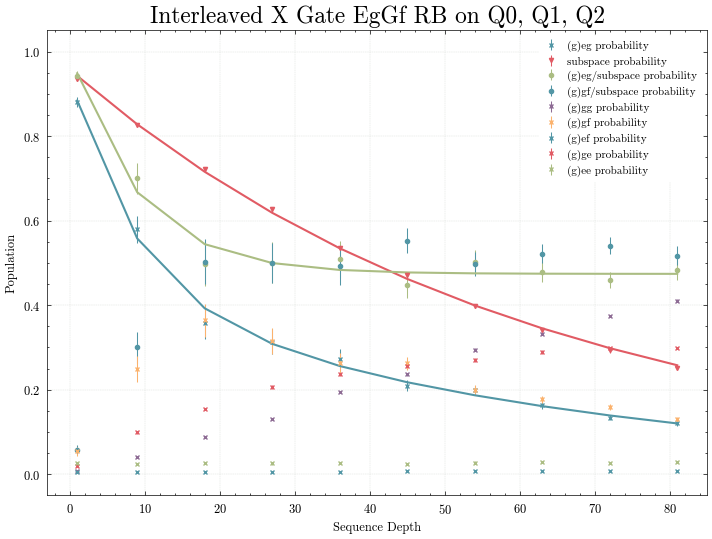

In [ ]:
filename_12_irb_1, data_12_irb_1, rbprog_12_irb_1 = run_rb(
    qDrive=qDrive,
    depths=depths,
    variations=variations,
    reps=reps,
    loops=loops,
    singleshot_reps=singleshot_reps,
    gate_char='X',
    validate_variations=True,
    save_data=True)

In [ ]:
print("Saved data", filename_12_irb_1)

Saved data S:\QRAM\qram_4QR2\data\data_250119\00024_rb_EgGf_qubit21.h5


###### Second half

In [ ]:
step = 20
end = 150
depths = np.arange(90, end+step, step)

variations = 20
reps = 10000
loops = 20
singleshot_reps = 10000

print('depths', len(depths))
print(depths)

depths 4
[ 90 110 130 150]


{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-390.00045219204236, 5795.770150727347, 502.42095511476606, -228.8557536534039], 'gain': [0.6, 0.5, 0.5, 0.3], 'readout_length': [4.5, 16, 6.0, 10], 'frequency_ef': [-390.0004521920423, 5795.76166666, 500.48386902205084, -230.30732892], 'gain_ef': [0.5, 0.6, 0.4, 0.25], 'readout_length_ef': [4.5, 20, 10, 8], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4108.755047003828, 4103.366954082312, 4108.649372291309, 4108.232503550693, 3442.591941352887, 3447.981518133789, 3446.872635941306, 3446.65966586083, 4760.911839134516, 4759.946893523059, 4761.052602755913, 4760.46101643607, 4377.996318964773, 4377.247239665757, 4377.995764386313, 4378.454058265707], 'f_ef': [3882.6760964004225, 0.0, 3882.593023159515, 3882.5465667921762, 3345.3957364303, 3347.511433910277, 3347.003494996075, 3346.9817293387923, 4572.523325892487, 4571.192833780465, 4573.063027684978, 0.0, 4207.223225529803, 4202.994894046

  0%|          | 0/4 [00:00<?, ?it/s]

gate_list_variations= [[['-X/2', 'X', 'Y', 'X', '-Y/2,X', 'X', 'Y', 'X', 'X', 'X', '-Y/2,X', 'X', 'I', 'X', 'X/2,Y/2,-X/2', 'X', '-X/2,Y/2', 'X', 'X/2,Y', 'X', 'Y/2,X/2', 'X', '-X/2', 'X', 'X/2,Y/2', 'X', 'X/2,-Y/2,-X/2', 'X', '-Y/2,X', 'X', 'X/2,Y/2', 'X', 'X/2,Y/2,-X/2', 'X', 'Y', 'X', '-X/2,Y', 'X', 'X/2,Y/2', 'X', '-Y/2,X/2', 'X', '-X/2', 'X', 'Y/2,-X/2', 'X', '-X/2,-Y/2', 'X', 'Y/2,X/2', 'X', 'Y/2,X/2', 'X', 'Y/2,X', 'X', 'X/2,-Y/2', 'X', 'X/2,Y', 'X', 'X/2', 'X', '-Y/2,X', 'X', '-Y/2,X', 'X', 'Y/2,-X/2', 'X', 'X/2,Y/2', 'X', '-X/2,-Y/2', 'X', '-Y/2', 'X', 'X/2,Y', 'X', 'X/2,Y/2,-X/2', 'X', '-X/2,Y', 'X', '-X/2,Y', 'X', '-X/2,Y', 'X', '-X/2,Y/2', 'X', '-X/2,Y/2,-X/2', 'X', 'I', 'X', 'X', 'X', 'Y/2', 'X', '-Y/2,-X/2', 'X', '-Y/2,X/2', 'X', '-Y/2,X', 'X', '-Y/2,-X/2', 'X', 'X/2,Y', 'X', 'Y/2,X/2', 'X', 'X', 'X', 'Y', 'X', '-Y/2,X/2', 'X', '-X/2,Y', 'X', 'X/2', 'X', '-X/2,Y/2', 'X', '-Y/2', 'X', 'Y/2,-X/2', 'X', 'X/2,Y/2', 'X', 'X/2,-Y/2', 'X', 'X/2,-Y/2,-X/2', 'X', 'X/2,-Y/2', 'X', 

  0%|          | 0/20 [00:00<?, ?it/s]

Beginning loop 0


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.08000000000003 	 angle (deg): -119.04601136547919 	 threshold ge: 173.57324549809564
Qubit (1) ge
ge fidelity (%): 75.95 	 angle (deg): 44.082744887382496 	 threshold ge: 44.28777047581526
Qubit (2) ge
ge fidelity (%): 76.28999999999998 	 angle (deg): -55.297936553636376 	 threshold ge: 37.43281356402231
thresholds=[173.57324549809564, 44.28777047581526, 37.43281356402231, 0],
angles=[-119.04601136547919, 44.082744887382496, -55.297936553636376, 0],
ge_avgs=[array([ -91.84491946,   77.76752967, -157.61285608,  196.19164732]), array([  2.88322535, -33.61401497,  31.55100566, -61.37829044]), array([-35.36565627,  37.92418747,  -3.90214482,  83.35977233]), array([0., 0., 0., 0.])],
counts_calib=[[7418, 942, 824, 105, 569, 59, 79, 4], [1092, 7163, 109, 962, 68, 476, 17, 113], [610, 7027, 90, 1570, 42, 474, 10, 177], [1093, 134, 6994, 909, 167, 24, 612, 67], [148, 1006, 923, 6979, 30, 151, 81, 682], [89, 1120, 628, 7461, 13, 149, 40, 500], [779, 85, 104, 14,

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.75999999999999
Qubit (1) ge
ge fidelity (%): 77.9393369336934
Qubit (2) gf
gf fidelity (%): 62.43999999999998
thresholds_f=[141.81117028567763, 57.98046371578112, -47.75064022167575, 0],
angles_f=[-117.92261871972867, 67.15299758388468, 169.33963985856144, 0],
gf_avgs=[array([ -89.38409653,   50.79949197, -144.13872258,  154.11433864]), array([ 22.58333602, -30.42980057,  39.92747723, -71.59531816]), array([68.00832142, 19.55631582, 29.31531901, 12.27291885]), array([0., 0., 0., 0.])],
counts_calib_f=[[7835, 871, 595, 60, 540, 59, 37, 3], [7616, 958, 632, 65, 592, 70, 45, 22], [2383, 6035, 199, 753, 167, 362, 27, 74], [1231, 112, 7326, 652, 163, 12, 460, 44], [1247, 276, 6736, 1104, 148, 19, 393, 77], [423, 946, 2318, 5629, 48, 93, 162, 381], [856, 87, 46, 1, 7773, 641, 548, 48], [863, 98, 60, 12, 7321, 786, 761, 99], [304, 653, 32, 84, 2428, 5286, 338, 875], [237, 27, 736, 83, 1065, 112, 6995, 745], [207, 28, 703, 104, 917, 106, 7053, 882], [90, 200, 2

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 1


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.1491819181918 	 angle (deg): -126.88288080037563 	 threshold ge: 190.84072902349143
Qubit (1) ge
ge fidelity (%): 75.46 	 angle (deg): 44.698889924558706 	 threshold ge: 45.92064889713167
Qubit (2) ge
ge fidelity (%): 74.63 	 angle (deg): 118.75016843150946 	 threshold ge: 36.60453982752723
thresholds=[190.84072902349143, 45.92064889713167, 36.60453982752723, 0],
angles=[-126.88288080037563, 44.698889924558706, 118.75016843150946, 0],
ge_avgs=[array([-105.50597931,   66.05813256, -186.27337236,  173.697167  ]), array([  4.3575883 , -33.93452745,  32.3951319 , -61.6789141 ]), array([ 37.98747184, -35.75067363,  12.07407314, -82.98423304]), array([0., 0., 0., 0.])],
counts_calib=[[7174, 1078, 790, 127, 525, 86, 179, 41], [964, 7016, 129, 875, 73, 482, 47, 414], [621, 7041, 89, 1284, 36, 458, 39, 432], [964, 162, 6750, 1086, 173, 25, 728, 112], [113, 987, 899, 7002, 17, 129, 105, 748], [85, 1203, 539, 7261, 12, 140, 40, 720], [797, 150, 94, 15, 7038, 1156,

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.50000000000001
Qubit (1) ge
ge fidelity (%): 76.34000000000003
Qubit (2) gf
gf fidelity (%): 59.12
thresholds_f=[147.93580602725447, 57.15691135206421, -48.943471958371234, 0],
angles_f=[-126.47054880294934, 67.33324968727105, -74.12043643607839, 0],
gf_avgs=[array([ -95.81548575,   37.66391751, -165.60217974,  132.07667808]), array([ 23.19558949, -30.09609621,  39.51036562, -69.1614868 ]), array([-12.08240068, -70.11217705,  -1.91058096, -34.35532555]), array([0., 0., 0., 0.])],
counts_calib_f=[[7689, 992, 621, 59, 515, 60, 57, 7], [7639, 804, 826, 82, 503, 46, 83, 17], [2479, 5736, 290, 848, 162, 362, 44, 79], [1264, 188, 6974, 967, 149, 23, 393, 42], [1105, 155, 7217, 853, 140, 17, 448, 65], [398, 917, 2318, 5817, 38, 96, 133, 283], [873, 65, 68, 6, 7706, 651, 591, 40], [834, 103, 76, 7, 7278, 748, 849, 105], [302, 641, 38, 93, 2360, 5181, 356, 1029], [216, 19, 850, 68, 949, 81, 7207, 610], [241, 22, 839, 86, 863, 106, 7090, 753], [100, 188, 284, 668

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 2


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 85.14999999999993 	 angle (deg): -135.22296994549873 	 threshold ge: 166.25761375096133
Qubit (1) ge
ge fidelity (%): 76.36000000000001 	 angle (deg): 44.23293848893645 	 threshold ge: 45.95041913685722
Qubit (2) ge
ge fidelity (%): 73.98000000000003 	 angle (deg): 69.32496979509763 	 threshold ge: 38.775494966213586
thresholds=[166.25761375096133, 45.95041913685722, 38.775494966213586, 0],
angles=[-135.22296994549873, 44.23293848893645, 69.32496979509763, 0],
ge_avgs=[array([-111.08956823,   46.67147438, -206.75804674,  141.5982364 ]), array([  2.51593949, -34.08744128,  31.30283357, -62.11368983]), array([ 52.40347623,   7.9906153 ,  71.099558  , -41.55241649]), array([0., 0., 0., 0.])],
counts_calib=[[7666, 911, 704, 88, 498, 60, 69, 4], [1350, 7241, 100, 719, 91, 417, 8, 74], [728, 7395, 94, 1113, 45, 466, 6, 153], [1195, 155, 7179, 878, 140, 13, 388, 52], [221, 1267, 1223, 6785, 15, 106, 61, 322], [117, 1222, 728, 7328, 12, 136, 29, 428], [702, 78, 70

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.68935793579355
Qubit (1) ge
ge fidelity (%): 80.00943994399438
Qubit (2) gf
gf fidelity (%): 61.870000000000005
thresholds_f=[141.2642215549911, 58.45973087793456, -49.68682284282927, 0],
angles_f=[-134.3632921940433, 67.94361551835611, 171.50085292994734, 0],
gf_avgs=[array([-103.19076939,   23.17689566, -182.01579797,  103.77359465]), array([ 23.01386916, -30.40514382,  40.23440783, -72.90700337]), array([71.38983346, 16.79282223, 32.05191924, 10.91433024]), array([0., 0., 0., 0.])],
counts_calib_f=[[7972, 831, 494, 43, 564, 48, 44, 4], [7690, 976, 589, 51, 539, 69, 69, 17], [2446, 5795, 232, 763, 191, 441, 35, 97], [1125, 118, 7298, 743, 147, 26, 497, 46], [1062, 183, 7084, 988, 142, 23, 445, 73], [372, 909, 2204, 5825, 58, 124, 159, 349], [778, 123, 62, 8, 7472, 1003, 491, 63], [898, 145, 67, 10, 7004, 1120, 643, 113], [265, 587, 22, 92, 2259, 5479, 332, 964], [213, 32, 724, 91, 1029, 162, 6996, 753], [213, 43, 786, 166, 803, 151, 6715, 1123], [70, 

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 3


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.52000000000001 	 angle (deg): -144.03514509819962 	 threshold ge: 169.97409688247473
Qubit (1) ge
ge fidelity (%): 77.87000000000003 	 angle (deg): 45.03176208186883 	 threshold ge: 45.66753532256307
Qubit (2) ge
ge fidelity (%): 76.54999999999997 	 angle (deg): -5.828527343906214 	 threshold ge: 36.630112546172256
thresholds=[169.97409688247473, 45.66753532256307, 36.630112546172256, 0],
angles=[-144.03514509819962, 45.03176208186883, -5.828527343906214, 0],
ge_avgs=[array([-116.8699259 ,   29.79984161, -226.44084153,  109.3051288 ]), array([  2.45513365, -33.3375259 ,  31.40681438, -62.32132334]), array([ 5.18714514, 53.20083793, 60.22639799, 58.81920933]), array([0., 0., 0., 0.])],
counts_calib=[[7678, 964, 666, 97, 466, 60, 60, 9], [1077, 7451, 93, 764, 63, 451, 12, 89], [707, 7385, 83, 1201, 52, 424, 12, 136], [1089, 152, 7215, 915, 132, 12, 434, 51], [183, 1187, 1126, 6966, 19, 108, 54, 357], [141, 1131, 766, 7342, 15, 136, 42, 427], [774, 113, 65

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.72
Qubit (1) ge
ge fidelity (%): 78.85999999999999
Qubit (2) gf
gf fidelity (%): 63.879999999999995
thresholds_f=[141.6975331336301, 58.66281766619725, -49.57915125184341, 0],
angles_f=[-143.66867712110928, 67.90962576577782, 97.83550735739934, 0],
gf_avgs=[array([-103.07515615,    6.86987004, -197.37680753,   76.22072323]), array([ 22.57283732, -30.38557428,  39.4944682 , -72.07861865]), array([ 3.13932783, 73.00271816, -2.46804691, 32.2557016 ]), array([0., 0., 0., 0.])],
counts_calib_f=[[8099, 797, 461, 56, 501, 41, 41, 4], [7576, 1155, 519, 84, 543, 56, 56, 11], [2323, 6077, 210, 749, 153, 378, 33, 77], [1236, 143, 7233, 737, 160, 19, 433, 39], [1159, 181, 7075, 920, 160, 17, 425, 63], [385, 990, 2086, 5830, 50, 115, 136, 408], [796, 101, 47, 3, 7662, 856, 489, 46], [769, 92, 64, 8, 7317, 979, 656, 115], [264, 647, 38, 88, 2300, 5520, 268, 875], [237, 39, 758, 74, 1141, 129, 6897, 725], [187, 52, 809, 164, 898, 160, 6633, 1097], [68, 183, 241, 623, 

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 4


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.1293499349935 	 angle (deg): -153.1317052093786 	 threshold ge: 167.75697907622336
Qubit (1) ge
ge fidelity (%): 78.32000000000001 	 angle (deg): 47.077825243290874 	 threshold ge: 47.02069563568692
Qubit (2) ge
ge fidelity (%): 76.11999999999998 	 angle (deg): 68.71227826051073 	 threshold ge: 36.836416037728156
thresholds=[167.75697907622336, 47.02069563568692, 36.836416037728156, 0],
angles=[-153.1317052093786, 47.077825243290874, 68.71227826051073, 0],
ge_avgs=[array([-120.41627019,   12.08046621, -241.4223089 ,   73.38616281]), array([  3.86199178, -32.81576336,  31.77331202, -62.82861892]), array([ 52.29400309,   8.07633885,  72.21143657, -43.04160109]), array([0., 0., 0., 0.])],
counts_calib=[[7506, 1011, 725, 93, 543, 62, 52, 8], [1046, 7294, 114, 886, 66, 483, 13, 98], [644, 7273, 98, 1274, 51, 494, 12, 154], [989, 134, 7248, 996, 154, 20, 394, 65], [155, 1061, 995, 7085, 17, 126, 89, 472], [118, 1179, 666, 7423, 11, 130, 43, 430], [764, 99, 53

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.32
Qubit (1) ge
ge fidelity (%): 79.07000000000001
Qubit (2) gf
gf fidelity (%): 60.870000000000005
thresholds_f=[146.09461939580322, 58.24757890888445, -49.61005857715716, 0],
angles_f=[-152.5036725923424, 66.50511973371087, 136.5129175127888, 0],
gf_avgs=[array([-103.41261896,   -7.07711577, -204.74796729,   45.66647221]), array([ 21.87131149, -30.92518294,  39.93270026, -72.47368563]), array([46.20213662, 53.88057695, 18.44057331, 27.54772982]), array([0., 0., 0., 0.])],
counts_calib_f=[[7708, 1039, 545, 76, 518, 58, 54, 2], [7505, 1041, 692, 109, 511, 59, 69, 14], [2339, 5964, 244, 770, 159, 409, 36, 79], [1093, 143, 7311, 780, 176, 16, 436, 45], [983, 140, 7239, 1016, 125, 18, 422, 57], [356, 928, 2191, 5887, 50, 107, 140, 341], [865, 116, 47, 8, 7458, 941, 520, 45], [842, 173, 92, 22, 6937, 1089, 733, 112], [267, 678, 35, 96, 2100, 5451, 348, 1025], [215, 28, 848, 129, 1014, 137, 6841, 788], [190, 53, 826, 166, 875, 179, 6560, 1151], [102, 200, 26

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 5


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.23926392639262 	 angle (deg): -160.93327230423793 	 threshold ge: 176.20248548425266
Qubit (1) ge
ge fidelity (%): 72.98 	 angle (deg): 44.05488629974962 	 threshold ge: 45.05158138904194
Qubit (2) ge
ge fidelity (%): 75.13999999999997 	 angle (deg): -54.29942533690202 	 threshold ge: 37.70375027701871
thresholds=[176.20248548425266, 45.05158138904194, 37.70375027701871, 0],
angles=[-160.93327230423793, 44.05488629974962, -54.29942533690202, 0],
ge_avgs=[array([-122.48270036,   -4.68243582, -247.83868285,   38.64445687]), array([  3.33615231, -34.06704627,  30.95970368, -60.79398616]), array([-36.12537271,  38.86804699,  -4.66068573,  82.6548656 ]), array([0., 0., 0., 0.])],
counts_calib=[[7432, 867, 841, 109, 522, 54, 157, 18], [1215, 6978, 121, 987, 79, 455, 28, 137], [745, 6978, 117, 1330, 52, 530, 20, 228], [1213, 148, 6912, 821, 198, 26, 606, 76], [200, 1062, 1202, 6690, 41, 148, 108, 549], [103, 1243, 637, 7152, 14, 133, 61, 657], [841, 95, 86, 5,

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.29000000000002
Qubit (1) ge
ge fidelity (%): 79.34938193819383
Qubit (2) gf
gf fidelity (%): 62.349999999999994
thresholds_f=[140.30591023280257, 57.560935309665744, -49.12047113702427, 0],
angles_f=[-160.54132429007777, 66.63179954069116, -71.02570418516609, 0],
gf_avgs=[array([-101.81964971,  -21.361511  , -207.57470137,   16.00249863]), array([ 21.96342028, -30.49647012,  39.76104518, -71.68706121]), array([-17.27036032, -70.2443514 ,  -4.52975762, -33.18895944]), array([0., 0., 0., 0.])],
counts_calib_f=[[7831, 843, 543, 59, 607, 56, 54, 7], [7544, 972, 660, 88, 555, 75, 86, 20], [2357, 5913, 232, 776, 177, 415, 36, 94], [1093, 154, 7247, 833, 150, 22, 453, 48], [1068, 124, 7313, 806, 118, 21, 487, 63], [375, 845, 2204, 5919, 38, 108, 147, 364], [831, 144, 61, 12, 7507, 878, 513, 54], [797, 85, 62, 10, 7167, 856, 912, 111], [299, 695, 35, 76, 2316, 5313, 318, 948], [228, 45, 840, 157, 977, 119, 6760, 874], [200, 35, 850, 129, 867, 121, 6879, 919], [

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 6


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.3 	 angle (deg): -170.07040799160285 	 threshold ge: 169.00433929553108
Qubit (1) ge
ge fidelity (%): 70.39000000000001 	 angle (deg): 48.01909313526352 	 threshold ge: 49.57803075245822
Qubit (2) ge
ge fidelity (%): 75.04000000000003 	 angle (deg): 171.26964149927147 	 threshold ge: 41.83130174696642
thresholds=[169.00433929553108, 49.57803075245822, 41.83130174696642, 0],
angles=[-170.07040799160285, 48.01909313526352, 171.26964149927147, 0],
ge_avgs=[array([-121.26188017,  -21.26195716, -249.19358828,    1.13379284]), array([  7.56918751, -34.83895231,  31.93456151, -61.91758283]), array([ -5.17784601, -53.54154211, -58.67662024, -61.75701769]), array([0., 0., 0., 0.])],
counts_calib=[[7180, 784, 1111, 139, 591, 71, 106, 18], [1187, 6570, 200, 1368, 90, 480, 10, 95], [813, 7101, 138, 1291, 67, 489, 6, 95], [1274, 139, 7146, 784, 157, 20, 429, 51], [234, 1237, 1097, 6715, 32, 156, 72, 457], [159, 1294, 769, 6963, 30, 170, 61, 554], [899, 93, 93, 12, 7

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.89999999999999
Qubit (1) ge
ge fidelity (%): 76.07924392439247
Qubit (2) gf
gf fidelity (%): 61.38000000000001
thresholds_f=[139.25141837110738, 55.76081113010101, -48.310190741227814, 0],
angles_f=[-168.73982693635486, 68.78586405640402, -138.4944844431907, 0],
gf_avgs=[array([ -98.00748958,  -36.87989703, -207.85811027,  -15.00897323]), array([ 23.99192002, -30.3125383 ,  39.15630169, -69.38005692]), array([ 57.85489902, -42.46937158,  28.68456012, -16.6566293 ]), array([0., 0., 0., 0.])],
counts_calib_f=[[7704, 802, 675, 80, 634, 55, 46, 4], [7455, 947, 771, 99, 538, 68, 98, 24], [2435, 5735, 292, 867, 176, 384, 26, 85], [1173, 235, 6938, 890, 175, 21, 501, 67], [1108, 197, 6984, 1044, 139, 16, 454, 58], [376, 923, 2218, 5812, 60, 103, 157, 351], [780, 122, 69, 7, 7441, 911, 608, 62], [802, 141, 75, 13, 6876, 1034, 906, 153], [287, 655, 25, 95, 2236, 5193, 366, 1143], [209, 38, 740, 120, 1107, 158, 6867, 761], [176, 41, 810, 147, 919, 163, 6706, 1038

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 7


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.6893419341934 	 angle (deg): -177.98515327458742 	 threshold ge: 166.10111026211376
Qubit (1) ge
ge fidelity (%): 74.07999999999998 	 angle (deg): 47.740333073194634 	 threshold ge: 46.60006484039294
Qubit (2) ge
ge fidelity (%): 75.65000000000002 	 angle (deg): 170.35249126385625 	 threshold ge: 42.33933799991276
thresholds=[166.10111026211376, 46.60006484039294, 42.33933799991276, 0],
angles=[-177.98515327458742, 47.740333073194634, 170.35249126385625, 0],
ge_avgs=[array([-112.80125854,  -40.54257352, -247.70337988,  -35.79668828]), array([  4.8022716 , -32.25867925,  30.8611857 , -60.93758269]), array([ -5.45623565, -51.14895236, -58.99745144, -60.25044314]), array([0., 0., 0., 0.])],
counts_calib=[[7588, 798, 837, 100, 551, 59, 57, 10], [1242, 7125, 154, 921, 65, 390, 13, 90], [806, 7147, 133, 1317, 57, 396, 13, 131], [1309, 142, 7217, 810, 125, 20, 342, 35], [210, 1086, 1262, 6890, 19, 123, 53, 357], [151, 1264, 901, 7143, 18, 130, 25, 368], [800, 

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.93
Qubit (1) ge
ge fidelity (%): 79.54000000000002
Qubit (2) gf
gf fidelity (%): 59.980000000000025
thresholds_f=[139.0379413132623, 58.77008508274627, -46.53602114095598, 0],
angles_f=[-177.22112222163184, 68.9091637563195, 140.12387471202152, 0],
gf_avgs=[array([ -90.37280912,  -50.7018047 , -202.98588538,  -45.23572004]), array([ 23.85593939, -30.4476589 ,  40.02367061, -72.36727472]), array([48.60396465, 52.01254486, 19.13189772, 27.39093112]), array([0., 0., 0., 0.])],
counts_calib_f=[[7912, 784, 578, 53, 569, 60, 37, 7], [7591, 996, 612, 76, 565, 69, 71, 20], [2628, 5664, 278, 727, 170, 402, 39, 92], [1064, 128, 7445, 645, 182, 11, 485, 40], [1002, 119, 7372, 719, 150, 15, 567, 56], [357, 953, 2196, 5706, 47, 117, 165, 459], [877, 107, 52, 6, 7642, 822, 442, 52], [814, 119, 61, 9, 7295, 884, 709, 109], [287, 606, 32, 77, 2544, 5326, 331, 797], [195, 31, 730, 90, 970, 119, 7134, 731], [214, 43, 780, 161, 812, 182, 6746, 1062], [83, 157, 240, 550, 2

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 8


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.46000000000002 	 angle (deg): 172.7070278547118 	 threshold ge: 170.95879300903243
Qubit (1) ge
ge fidelity (%): 74.83999999999997 	 angle (deg): 48.554563399489545 	 threshold ge: 47.154543591119804
Qubit (2) ge
ge fidelity (%): 74.51 	 angle (deg): 141.93271660621858 	 threshold ge: 39.32490744226941
thresholds=[170.95879300903243, 47.154543591119804, 39.32490744226941, 0],
angles=[172.7070278547118, 48.554563399489545, 141.93271660621858, 0],
ge_avgs=[array([-104.46980217,  -55.55510948, -242.49631505,  -73.21950579]), array([  5.40835654, -31.76186895,  31.35999089, -61.15120405]), array([ 17.82453608, -45.52310879, -23.82417184, -78.14148106]), array([0., 0., 0., 0.])],
counts_calib=[[7512, 1003, 743, 100, 430, 54, 140, 18], [1182, 7257, 118, 822, 55, 409, 21, 136], [793, 7247, 121, 1231, 39, 458, 10, 101], [1154, 206, 6970, 933, 153, 15, 505, 64], [175, 1092, 1035, 6951, 23, 132, 76, 516], [103, 1149, 647, 7357, 12, 140, 38, 554], [726, 94, 89, 8,

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.59999999999998
Qubit (1) ge
ge fidelity (%): 74.71882688268828
Qubit (2) gf
gf fidelity (%): 61.07999999999998
thresholds_f=[139.85058195843808, 58.649243915690754, -46.22677948546453, 0],
angles_f=[174.3882942552017, 69.5723227482728, 179.02471920173562, 0],
gf_avgs=[array([ -81.51338025,  -62.67208987, -196.38862214,  -73.95940137]), array([ 25.46217363, -32.67667031,  39.957409  , -71.59562946]), array([69.45645299,  7.46246992, 31.27324102,  6.81245781]), array([0., 0., 0., 0.])],
counts_calib_f=[[7328, 848, 1060, 84, 540, 61, 71, 8], [5974, 723, 2252, 249, 543, 66, 168, 25], [2020, 4921, 660, 1647, 182, 376, 52, 142], [1040, 88, 7619, 517, 173, 11, 518, 34], [1110, 110, 7375, 657, 152, 13, 532, 51], [361, 876, 2129, 5803, 52, 140, 195, 444], [796, 80, 100, 2, 7681, 689, 619, 33], [795, 98, 125, 10, 7347, 719, 814, 92], [244, 584, 59, 172, 2274, 5362, 312, 993], [185, 25, 773, 89, 1156, 124, 6948, 700], [191, 22, 786, 70, 1123, 95, 7052, 661], [73, 

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 9


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 85.67945994599458 	 angle (deg): 164.78475952411554 	 threshold ge: 170.97220011792376
Qubit (1) ge
ge fidelity (%): 75.47900190019004 	 angle (deg): 48.0844750294433 	 threshold ge: 48.18804379996294
Qubit (2) ge
ge fidelity (%): 73.81 	 angle (deg): -39.41039994419438 	 threshold ge: 38.56342177939176
thresholds=[170.97220011792376, 48.18804379996294, 38.56342177939176, 0],
angles=[164.78475952411554, 48.0844750294433, -39.41039994419438, 0],
ge_avgs=[array([ -94.15069067,  -68.43183567, -232.342933  , -106.01731187]), array([  5.75571337, -32.31201965,  32.15348873, -61.71678828]), array([-22.3694834 ,  45.53147466,  18.47986831,  79.09792979]), array([0., 0., 0., 0.])],
counts_calib=[[7532, 910, 887, 122, 456, 55, 35, 3], [1213, 6431, 228, 1447, 81, 468, 14, 118], [710, 6102, 239, 2256, 47, 478, 10, 158], [1138, 134, 7221, 934, 121, 18, 374, 60], [195, 1080, 1173, 7065, 21, 91, 51, 324], [150, 989, 724, 7437, 13, 134, 47, 506], [587, 82, 193, 24, 7272,

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.21933893389338
Qubit (1) ge
ge fidelity (%): 77.9693589358936
Qubit (2) gf
gf fidelity (%): 59.0968186818682
thresholds_f=[140.27057428192776, 57.03136196028405, -45.00668095437226, 0],
angles_f=[165.49311279282412, 69.3693924383986, 51.248594440825386, 0],
gf_avgs=[array([ -71.02193546,  -73.52108618, -178.95089153, -101.44725376]), array([ 23.61482354, -29.6913417 ,  39.42569635, -71.68735521]), array([-48.47956872,  49.05221533, -25.52644098,  20.45464808]), array([0., 0., 0., 0.])],
counts_calib_f=[[7805, 868, 585, 54, 591, 53, 41, 3], [7953, 625, 688, 65, 516, 64, 79, 10], [2619, 5687, 306, 782, 165, 334, 29, 78], [1264, 101, 7505, 439, 151, 9, 497, 34], [1214, 113, 7481, 571, 106, 17, 464, 34], [412, 1018, 2210, 5722, 49, 91, 133, 365], [1010, 117, 60, 6, 7622, 591, 551, 43], [1175, 207, 86, 11, 7015, 748, 669, 89], [337, 651, 38, 83, 2504, 5087, 339, 961], [244, 24, 629, 49, 992, 61, 7527, 474], [225, 33, 716, 74, 958, 105, 7206, 683], [83, 196, 

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 10


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.13999999999999 	 angle (deg): 155.84919635020813 	 threshold ge: 173.37324281686884
Qubit (1) ge
ge fidelity (%): 76.86921292129215 	 angle (deg): 48.98097857086354 	 threshold ge: 49.523133277996465
Qubit (2) ge
ge fidelity (%): 75.01888588858888 	 angle (deg): -150.5307960945559 	 threshold ge: 37.94793992948583
thresholds=[173.37324281686884, 49.523133277996465, 37.94793992948583, 0],
angles=[155.84919635020813, 48.98097857086354, -150.5307960945559, 0],
ge_avgs=[array([ -84.73098357,  -84.00910369, -210.52299718, -140.41250094]), array([  5.37527402, -32.09728228,  31.95456783, -62.65276885]), array([-35.77425665, -37.27205296, -82.15219707, -11.06557396]), array([0., 0., 0., 0.])],
counts_calib=[[7628, 1053, 626, 95, 429, 46, 103, 20], [1125, 7355, 104, 782, 68, 442, 11, 113], [728, 7610, 71, 953, 34, 453, 7, 144], [1129, 186, 6930, 1070, 144, 22, 449, 70], [219, 1245, 1040, 6768, 21, 181, 52, 474], [118, 1311, 650, 7168, 14, 149, 38, 552], [818, 1

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.92999999999996
Qubit (1) ge
ge fidelity (%): 76.7491889188919
Qubit (2) gf
gf fidelity (%): 60.196916691669145
thresholds_f=[141.258997289905, 59.69451606395142, -47.73502688016549, 0],
angles_f=[157.76910541540477, 68.00323583949158, -77.4370987497864, 0],
gf_avgs=[array([ -60.80486122,  -84.38225145, -166.94611614, -127.7644741 ]), array([ 23.85601743, -31.68152799,  40.0228502 , -71.7023505 ]), array([ -8.62882012, -71.01538851,  -0.27118171, -33.51141325]), array([0., 0., 0., 0.])],
counts_calib_f=[[7571, 881, 763, 52, 623, 59, 46, 5], [7521, 942, 751, 75, 558, 76, 59, 18], [2588, 5887, 206, 641, 170, 407, 38, 63], [1200, 114, 7365, 712, 143, 16, 417, 33], [1271, 181, 7002, 899, 135, 23, 427, 62], [428, 1053, 2129, 5714, 56, 99, 152, 369], [847, 79, 48, 2, 7804, 686, 500, 34], [798, 131, 57, 9, 7335, 979, 595, 96], [299, 690, 21, 71, 2297, 5623, 256, 743], [259, 35, 649, 113, 1344, 186, 6642, 772], [232, 43, 600, 114, 1156, 170, 6785, 900], [85, 182

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 11


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 86.72948594859486 	 angle (deg): 149.31330809203686 	 threshold ge: 169.76740015702518
Qubit (1) ge
ge fidelity (%): 67.83999999999999 	 angle (deg): 47.812343936419815 	 threshold ge: 48.5127897499824
Qubit (2) ge
ge fidelity (%): 75.33899389938993 	 angle (deg): 44.20828030519498 	 threshold ge: 39.76369621512726
thresholds=[169.76740015702518, 48.5127897499824, 39.76369621512726, 0],
angles=[149.31330809203686, 47.812343936419815, 44.20828030519498, 0],
ge_avgs=[array([ -70.74935926,  -94.95514797, -190.60146013, -166.08047077]), array([  8.62284346, -34.28263687,  31.42695377, -59.44295762]), array([ 43.64900483,  26.43176663,  82.68134672, -11.53650418]), array([0., 0., 0., 0.])],
counts_calib=[[7158, 854, 1290, 166, 408, 50, 66, 8], [925, 5718, 385, 2417, 75, 350, 8, 122], [661, 6209, 192, 2420, 50, 333, 15, 120], [1375, 139, 6861, 810, 167, 16, 555, 77], [269, 1060, 1209, 6907, 14, 117, 66, 358], [171, 1313, 714, 7326, 11, 112, 35, 318], [538, 56, 1

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.88999999999997
Qubit (1) ge
ge fidelity (%): 77.30000000000003
Qubit (2) gf
gf fidelity (%): 66.42000000000002
thresholds_f=[137.21463923203657, 56.98384142911541, -46.640874788034225, 0],
angles_f=[150.10659874175784, 69.39345565050665, 75.07620089005202, 0],
gf_avgs=[array([ -47.45824949,  -93.58662627, -143.54724146, -148.8255225 ]), array([ 24.72195863, -30.7386408 ,  39.78159543, -70.79026426]), array([-25.74110732,  68.43173044, -14.82516367,  27.4750693 ]), array([0., 0., 0., 0.])],
counts_calib_f=[[8049, 532, 694, 51, 584, 37, 53, 0], [7574, 932, 741, 77, 528, 58, 78, 12], [2319, 5934, 244, 835, 151, 426, 28, 63], [1152, 150, 7205, 749, 164, 18, 515, 47], [1160, 178, 7174, 807, 134, 21, 468, 58], [410, 950, 2152, 5806, 48, 113, 127, 394], [809, 164, 60, 10, 7429, 916, 569, 43], [913, 184, 73, 14, 7027, 999, 699, 91], [310, 659, 39, 113, 2289, 5245, 329, 1016], [257, 36, 714, 113, 1176, 156, 6797, 751], [228, 61, 615, 114, 1160, 209, 6648, 965], 

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 12


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.95937493749372 	 angle (deg): 140.1746085643253 	 threshold ge: 171.70236351354984
Qubit (1) ge
ge fidelity (%): 76.87928092809283 	 angle (deg): 48.12167653946212 	 threshold ge: 46.624440033138825
Qubit (2) ge
ge fidelity (%): 74.71000000000004 	 angle (deg): 33.2546569406561 	 threshold ge: 35.82525057225379
thresholds=[171.70236351354984, 46.624440033138825, 35.82525057225379, 0],
angles=[140.1746085643253, 48.12167653946212, 33.2546569406561, 0],
ge_avgs=[array([ -56.9373602 , -105.50332214, -160.44609392, -191.82129038]), array([  4.65713485, -30.58742191,  31.23631156, -60.23295416]), array([37.15133521, 35.15835524, 81.82065947,  5.86667135]), array([0., 0., 0., 0.])],
counts_calib=[[7578, 1099, 598, 94, 459, 86, 76, 10], [1011, 7168, 168, 1066, 53, 425, 9, 100], [679, 7073, 115, 1475, 33, 483, 13, 129], [1176, 174, 6889, 1067, 164, 28, 444, 58], [173, 1180, 1058, 6997, 21, 121, 46, 404], [116, 1324, 572, 7295, 17, 158, 28, 490], [784, 116, 62, 

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.30931393139315
Qubit (1) ge
ge fidelity (%): 79.62932993299327
Qubit (2) gf
gf fidelity (%): 62.037001700169995
thresholds_f=[138.384087159012, 58.679872595454654, -46.624483898923884, 0],
angles_f=[140.79935530227698, 67.33082772759248, 17.09293040389328, 0],
gf_avgs=[array([ -32.94123082,  -98.02230463, -122.332367  , -170.92961122]), array([ 22.77541309, -30.24957664,  40.3860099 , -72.41277069]), array([-70.07116995,  13.00622594, -32.26522324,   1.38070417]), array([0., 0., 0., 0.])],
counts_calib_f=[[7856, 776, 616, 46, 606, 57, 37, 6], [7682, 797, 739, 56, 585, 53, 80, 8], [2421, 5827, 272, 764, 187, 394, 43, 92], [1026, 97, 7204, 587, 192, 20, 813, 61], [1090, 119, 7171, 752, 165, 16, 624, 63], [388, 955, 1983, 5711, 52, 123, 229, 559], [833, 76, 64, 4, 7872, 599, 518, 34], [848, 112, 83, 5, 7242, 823, 770, 117], [307, 783, 42, 104, 2241, 5345, 291, 887], [218, 42, 816, 123, 1161, 174, 6749, 717], [247, 44, 738, 125, 1274, 190, 6631, 751], [80, 

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 13


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.60999999999999 	 angle (deg): 131.73946742201034 	 threshold ge: 165.23176523530256
Qubit (1) ge
ge fidelity (%): 75.75000000000001 	 angle (deg): 49.69273503194843 	 threshold ge: 47.363348036178024
Qubit (2) ge
ge fidelity (%): 75.58999999999999 	 angle (deg): 162.4400769156132 	 threshold ge: 38.18902473067904
thresholds=[165.23176523530256, 47.363348036178024, 38.18902473067904, 0],
angles=[131.73946742201034, 49.69273503194843, 162.4400769156132, 0],
ge_avgs=[array([ -41.35266693, -112.54292627, -128.37684175, -210.08136324]), array([  5.90103837, -30.64343473,  31.44627072, -60.75759721]), array([  2.57534726, -51.13690808, -49.21234297, -67.52507065]), array([0., 0., 0., 0.])],
counts_calib=[[7458, 986, 709, 103, 575, 88, 69, 12], [1060, 7224, 111, 825, 85, 571, 10, 114], [897, 7191, 100, 1108, 83, 479, 20, 122], [1191, 143, 6966, 996, 183, 25, 425, 71], [230, 1122, 1198, 6782, 25, 143, 85, 415], [249, 1302, 921, 6859, 28, 133, 53, 455], [795, 10

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.61000000000004
Qubit (1) ge
ge fidelity (%): 77.8885568556856
Qubit (2) gf
gf fidelity (%): 60.21000000000001
thresholds_f=[135.10059592914803, 56.73180476528387, -46.37251557127425, 0],
angles_f=[132.5659353414293, 67.85340819985629, -57.90397090015147, 0],
gf_avgs=[array([ -17.17453292,  -99.98061679,  -90.66357894, -179.99477996]), array([ 23.63060715, -30.22498428,  39.9645478 , -70.35697769]), array([-30.11891953, -64.30538047,  -9.73680049, -31.80849574]), array([0., 0., 0., 0.])],
counts_calib_f=[[7828, 813, 675, 74, 499, 55, 54, 2], [7457, 890, 812, 82, 595, 68, 72, 24], [2455, 5468, 318, 954, 214, 433, 52, 106], [1058, 145, 7248, 766, 192, 15, 533, 43], [1085, 116, 7289, 749, 146, 15, 540, 60], [353, 986, 1830, 6073, 45, 138, 136, 439], [837, 236, 50, 8, 7270, 1034, 505, 60], [769, 88, 79, 4, 7205, 777, 957, 121], [300, 644, 36, 105, 2328, 4962, 400, 1225], [235, 82, 792, 160, 1106, 223, 6630, 772], [267, 90, 969, 180, 1056, 211, 6337, 890], [9

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 14


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.38 	 angle (deg): 123.52010271394724 	 threshold ge: 166.0743007772416
Qubit (1) ge
ge fidelity (%): 75.15901690169015 	 angle (deg): 49.03291069308807 	 threshold ge: 47.34346426097383
Qubit (2) ge
ge fidelity (%): 74.22999999999999 	 angle (deg): 64.97196681261931 	 threshold ge: 36.29598987807131
thresholds=[166.0743007772416, 47.34346426097383, 36.29598987807131, 0],
angles=[123.52010271394724, 49.03291069308807, 64.97196681261931, 0],
ge_avgs=[array([ -23.61776353, -117.06717431,  -98.65067077, -230.3431589 ]), array([  6.2546729 , -31.44415699,  31.64882297, -60.69069664]), array([ 49.95270353,  11.12982393,  72.17434938, -36.4638395 ]), array([0., 0., 0., 0.])],
counts_calib=[[7422, 957, 833, 132, 503, 81, 64, 8], [1180, 7245, 130, 787, 78, 442, 17, 121], [827, 7276, 116, 1139, 41, 476, 12, 113], [1139, 129, 7056, 924, 163, 23, 498, 68], [161, 1043, 1045, 6894, 30, 177, 85, 565], [152, 1174, 706, 7013, 21, 176, 72, 686], [743, 90, 74, 8, 7215, 94

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.25930393039303
Qubit (1) ge
ge fidelity (%): 76.13
Qubit (2) gf
gf fidelity (%): 61.920000000000044
thresholds_f=[138.50864816036642, 56.399253936332045, -46.94508709437331, 0],
angles_f=[123.40097970973332, 68.32284541991324, 29.85690703149955, 0],
gf_avgs=[array([  -3.82548329, -103.41557142,  -65.20680651, -196.50177084]), array([ 23.76741346, -30.23329572,  39.60788117, -70.08487899]), array([-66.16001787,  26.57732627, -31.65651449,   6.77144818]), array([0., 0., 0., 0.])],
counts_calib_f=[[7725, 799, 685, 75, 595, 61, 53, 7], [7369, 1123, 695, 91, 509, 68, 115, 30], [2384, 5667, 289, 938, 133, 378, 72, 139], [1207, 131, 7144, 689, 217, 22, 545, 45], [1183, 167, 7055, 788, 168, 23, 547, 69], [416, 980, 2003, 5810, 55, 121, 157, 458], [851, 108, 100, 9, 6259, 661, 1849, 163], [843, 126, 109, 5, 6153, 783, 1790, 191], [305, 554, 38, 123, 2156, 4819, 487, 1518], [257, 33, 993, 130, 973, 124, 6813, 677], [216, 31, 1011, 152, 979, 140, 6640, 831], [93, 

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 15


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 79.00904490449044 	 angle (deg): 116.82343805328088 	 threshold ge: 179.1026301080655
Qubit (1) ge
ge fidelity (%): 72.93999999999996 	 angle (deg): 41.385519576782116 	 threshold ge: 42.95889994232733
Qubit (2) ge
ge fidelity (%): 75.03999999999998 	 angle (deg): -23.43511582971989 	 threshold ge: 38.39917207767927
thresholds=[179.1026301080655, 42.95889994232733, 38.39917207767927, 0],
angles=[116.82343805328088, 41.385519576782116, -23.43511582971989, 0],
ge_avgs=[array([  -6.57814971, -125.87691223,  -64.32189935, -240.07400601]), array([  2.48792252, -35.71450604,  30.97360555, -60.81522185]), array([-8.29395052, 50.46889962, 41.19195703, 71.91938242]), array([0., 0., 0., 0.])],
counts_calib=[[7154, 905, 839, 135, 577, 75, 267, 48], [1121, 7050, 147, 1075, 63, 411, 4, 129], [753, 6961, 110, 1331, 47, 491, 21, 286], [1101, 137, 7090, 866, 159, 25, 543, 79], [139, 1056, 936, 6932, 23, 134, 79, 701], [108, 1114, 711, 7262, 23, 163, 66, 553], [896, 107, 1

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.78923692369237
Qubit (1) ge
ge fidelity (%): 72.79889688968896
Qubit (2) gf
gf fidelity (%): 60.71999999999997
thresholds_f=[142.06606866914777, 60.3803159350946, -46.48166235524684, 0],
angles_f=[116.25843957140304, 67.34267140000563, 163.51695391564581, 0],
gf_avgs=[array([  11.325472  , -104.48501404,  -39.0849013 , -206.66919197]), array([ 23.7159234 , -33.36166445,  39.74874082, -71.76967028]), array([65.53396006, 26.57946738, 29.29277982, 15.85600446]), array([0., 0., 0., 0.])],
counts_calib_f=[[7445, 698, 987, 89, 650, 47, 76, 8], [7141, 953, 1006, 142, 554, 79, 103, 22], [2501, 5390, 366, 968, 202, 440, 40, 93], [1259, 109, 7371, 545, 203, 12, 469, 32], [1298, 288, 6751, 967, 199, 30, 411, 56], [469, 1187, 1914, 5745, 63, 115, 146, 361], [858, 90, 87, 8, 7776, 677, 458, 46], [868, 127, 96, 15, 7287, 934, 583, 90], [286, 644, 46, 122, 2398, 5328, 311, 865], [276, 39, 894, 109, 1287, 133, 6699, 563], [325, 127, 1618, 303, 1110, 220, 5513, 784], [1

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 16


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 80.56907490749074 	 angle (deg): 106.32489954205525 	 threshold ge: 162.8806032871162
Qubit (1) ge
ge fidelity (%): 74.73892289228924 	 angle (deg): 43.648189500019235 	 threshold ge: 43.94752975913967
Qubit (2) ge
ge fidelity (%): 75.28 	 angle (deg): -85.6781966419104 	 threshold ge: 38.01919153270316
thresholds=[162.8806032871162, 43.94752975913967, 38.01919153270316, 0],
angles=[106.32489954205525, 43.648189500019235, -85.6781966419104, 0],
ge_avgs=[array([  10.46603271, -121.4848665 ,  -25.12535601, -243.00186476]), array([  3.0026822 , -33.94284844,  30.94016474, -60.5921952 ]), array([-48.48585524,  16.05265496, -44.42811899,  69.7455337 ]), array([0., 0., 0., 0.])],
counts_calib=[[7216, 934, 778, 119, 611, 99, 206, 37], [1047, 6973, 152, 923, 76, 576, 27, 226], [948, 6985, 124, 1157, 67, 509, 18, 192], [1063, 136, 6878, 950, 191, 21, 674, 87], [178, 1054, 1015, 6817, 28, 166, 96, 646], [110, 1239, 674, 7118, 15, 173, 64, 607], [803, 106, 84, 8, 704

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.76000000000003
Qubit (1) ge
ge fidelity (%): 78.0
Qubit (2) gf
gf fidelity (%): 62.49709870987101
thresholds_f=[142.09351135700922, 58.81594220219308, -48.29511868546564, 0],
angles_f=[107.58082592794541, 66.66887579196693, 2.0222797550161675, 0],
gf_avgs=[array([  27.06814841, -101.73823386,   -6.91976013, -209.00623372]), array([ 21.87719857, -30.68215964,  39.32203003, -71.12811252]), array([-72.15397578,  -5.73398249, -32.23715518,  -7.14344958]), array([0., 0., 0., 0.])],
counts_calib_f=[[7853, 803, 557, 50, 604, 73, 57, 3], [7697, 940, 559, 49, 604, 79, 55, 17], [2398, 5936, 222, 709, 181, 432, 30, 92], [1141, 187, 7119, 813, 192, 19, 481, 48], [1160, 274, 6742, 1127, 143, 24, 460, 70], [402, 1248, 1769, 5937, 33, 140, 102, 369], [897, 131, 55, 6, 7632, 712, 521, 46], [789, 85, 47, 7, 7342, 842, 775, 113], [291, 610, 32, 96, 2262, 5370, 332, 1007], [242, 38, 705, 112, 1019, 146, 6996, 742], [211, 32, 775, 97, 911, 112, 7118, 744], [68, 246, 196, 6

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 17


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 80.21917491749173 	 angle (deg): 99.35249396402628 	 threshold ge: 160.40527883626933
Qubit (1) ge
ge fidelity (%): 75.02000000000005 	 angle (deg): 44.04882706180889 	 threshold ge: 44.34115349119887
Qubit (2) ge
ge fidelity (%): 73.87899289928987 	 angle (deg): 50.97997811490765 	 threshold ge: 37.74078140020832
thresholds=[160.40527883626933, 44.34115349119887, 37.74078140020832, 0],
angles=[99.35249396402628, 44.04882706180889, 50.97997811490765, 0],
ge_avgs=[array([  29.02916252, -120.4395487 ,    9.01197938, -241.97886592]), array([  2.94232968, -34.7717495 ,  31.14018153, -62.04857607]), array([ 46.86484981,  23.37791883,  80.10158372, -17.63671574]), array([0., 0., 0., 0.])],
counts_calib=[[7256, 862, 927, 110, 631, 96, 99, 19], [1276, 6808, 140, 938, 108, 573, 14, 143], [714, 6947, 94, 1282, 76, 575, 27, 285], [1034, 123, 6910, 865, 189, 27, 744, 108], [174, 989, 1086, 6779, 27, 147, 88, 710], [160, 1129, 824, 6975, 24, 143, 78, 667], [944, 87, 99

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 80.40999999999998
Qubit (1) ge
ge fidelity (%): 73.56844384438446
Qubit (2) gf
gf fidelity (%): 59.21999999999999
thresholds_f=[130.94943609420073, 54.75540449309534, -46.822776884640874, 0],
angles_f=[99.52958433422617, 64.85874492646543, 149.92771294562158, 0],
gf_avgs=[array([  41.36946874,  -96.05447214,   23.98994067, -199.58202337]), array([ 22.70901825, -31.57003226,  39.23977936, -66.79338337]), array([57.37863343, 42.01226182, 25.02354173, 23.2775736 ]), array([0., 0., 0., 0.])],
counts_calib_f=[[7343, 752, 973, 75, 690, 58, 105, 4], [7135, 906, 942, 120, 664, 73, 135, 25], [2364, 4804, 534, 1416, 224, 403, 76, 179], [954, 336, 6538, 1239, 166, 42, 621, 104], [877, 185, 6882, 1077, 154, 28, 703, 94], [288, 1041, 1833, 5936, 61, 120, 212, 509], [687, 233, 154, 31, 6628, 1238, 921, 108], [700, 94, 192, 19, 6662, 776, 1351, 206], [243, 552, 48, 185, 2017, 4797, 535, 1623], [208, 15, 675, 76, 1032, 96, 7201, 697], [182, 57, 774, 158, 895, 192, 6707, 1

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 18


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.68999999999997 	 angle (deg): 90.09808482151237 	 threshold ge: 172.23553852013777
Qubit (1) ge
ge fidelity (%): 73.72 	 angle (deg): 40.95597095122584 	 threshold ge: 43.842539888773494
Qubit (2) ge
ge fidelity (%): 75.42896589658967 	 angle (deg): -52.551172715826574 	 threshold ge: 37.44583622194604
thresholds=[172.23553852013777, 43.842539888773494, 37.44583622194604, 0],
angles=[90.09808482151237, 40.95597095122584, -52.551172715826574, 0],
ge_avgs=[array([  45.96484891, -114.57703437,   45.73627627, -248.09652359]), array([  2.83205778, -35.14670783,  31.44656362, -59.98233906]), array([-33.9750408 ,  40.00602214,  -0.88396929,  83.21098942]), array([0., 0., 0., 0.])],
counts_calib=[[7313, 936, 794, 112, 557, 63, 202, 23], [1073, 6760, 178, 1336, 60, 413, 25, 155], [901, 7079, 124, 1211, 59, 455, 12, 159], [1192, 133, 7187, 837, 151, 24, 425, 51], [162, 968, 1044, 7013, 32, 169, 80, 532], [141, 1293, 739, 7108, 20, 138, 57, 504], [792, 117, 76, 7,

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.4689608960896
Qubit (1) ge
ge fidelity (%): 73.53919191919194
Qubit (2) gf
gf fidelity (%): 61.77000000000001
thresholds_f=[135.95933630085648, 57.41361449529033, -47.13582993037764, 0],
angles_f=[90.94079996035556, 67.29442926930619, 162.6844181036129, 0],
gf_avgs=[array([  55.192928  ,  -86.94893654,   53.31467156, -201.32659327]), array([ 22.86307487, -30.77317329,  38.56186903, -68.29210186]), array([63.79871761, 26.57047754, 26.33935967, 14.89201029]), array([0., 0., 0., 0.])],
counts_calib_f=[[7513, 994, 678, 78, 575, 69, 84, 9], [7214, 1021, 883, 114, 571, 70, 106, 21], [2231, 5896, 262, 932, 144, 396, 37, 102], [1318, 214, 6792, 889, 242, 27, 459, 59], [1036, 262, 6724, 1226, 169, 29, 443, 111], [404, 1162, 1801, 5886, 59, 130, 114, 444], [858, 95, 64, 3, 7711, 664, 559, 46], [795, 138, 63, 10, 7102, 1000, 779, 113], [257, 721, 28, 88, 1948, 5711, 294, 953], [224, 43, 649, 96, 1856, 242, 6229, 661], [228, 81, 679, 162, 1333, 255, 6272, 990], [73

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 19


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.61999999999998 	 angle (deg): 82.28285050238587 	 threshold ge: 161.41870490916767
Qubit (1) ge
ge fidelity (%): 76.32000000000001 	 angle (deg): 40.97153430941812 	 threshold ge: 43.22871258856427
Qubit (2) ge
ge fidelity (%): 73.46999999999998 	 angle (deg): 153.71616540785226 	 threshold ge: 35.97728207507066
thresholds=[161.41870490916767, 43.22871258856427, 35.97728207507066, 0],
angles=[82.28285050238587, 40.97153430941812, 153.71616540785226, 0],
ge_avgs=[array([  62.67437598, -102.76867894,   79.98634805, -230.52278423]), array([  1.547693  , -34.8662649 ,  30.89726256, -60.35386747]), array([ 12.3393185 , -51.24227233, -34.26225285, -74.25784596]), array([0., 0., 0., 0.])],
counts_calib=[[7338, 1089, 743, 116, 536, 87, 73, 18], [1152, 7163, 139, 850, 73, 497, 10, 116], [607, 7277, 91, 1249, 54, 545, 7, 170], [1118, 132, 7074, 979, 184, 18, 433, 62], [184, 1098, 887, 7126, 26, 182, 49, 448], [135, 1117, 655, 7360, 18, 157, 50, 508], [941, 113, 7

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 79.61917991799183
Qubit (1) ge
ge fidelity (%): 77.91000000000003
Qubit (2) gf
gf fidelity (%): 62.09999999999998
thresholds_f=[131.76704178079353, 58.193748315198334, -49.774419400946556, 0],
angles_f=[83.43738103072558, 66.76763287467067, -49.38337335990251, 0],
gf_avgs=[array([  68.29617467,  -80.17702504,   80.27670933, -184.3167919 ]), array([ 22.2348091 , -30.67622311,  39.43045304, -70.73415435]), array([-40.97270693, -60.38407438, -14.94112656, -30.03033939]), array([0., 0., 0., 0.])],
counts_calib_f=[[7727, 841, 526, 52, 713, 72, 65, 4], [7344, 1157, 649, 91, 568, 72, 86, 33], [2403, 5846, 226, 794, 183, 436, 26, 86], [1135, 196, 6947, 929, 208, 38, 489, 58], [1066, 232, 6894, 1019, 188, 26, 484, 91], [348, 1229, 1598, 6024, 57, 144, 125, 475], [913, 213, 59, 13, 7119, 1182, 452, 49], [904, 158, 51, 13, 7044, 1011, 716, 103], [268, 840, 21, 90, 1864, 5746, 239, 932], [241, 84, 656, 144, 1299, 341, 6190, 1045], [214, 47, 598, 104, 1737, 293, 6110, 

  0%|          | 0/4 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_250119\00015_rb_EgGf_qubit21.h5
[ 90. 110. 130. 150.]


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

fit1 p1, a, offset [0.9851376  0.7594222  0.00735215]
fit2 a0, b0, c0, p2 [5.41359411e-11 3.42991635e-01 4.19486945e-01 7.50538523e-01]
[ 90 110 130 150  90 110 130 150  90 110 130 150  90 110 130 150  90 110
 130 150  90 110 130 150  90 110 130 150  90 110 130 150  90 110 130 150
  90 110 130 150  90 110 130 150  90 110 130 150  90 110 130 150  90 110
 130 150  90 110 130 150  90 110 130 150  90 110 130 150  90 110 130 150
  90 110 130 150  90 110 130 150]
flat_probs_eg [0.08509369 0.10020104 0.07344219 0.08231028 0.11540178 0.09531916
 0.09462375 0.08806323 0.11117273 0.07137313 0.09641104 0.08567705
 0.09633722 0.09021789 0.1191555  0.08179973 0.08799556 0.1073466
 0.09163967 0.10822886 0.07691559 0.0553755  0.06781053 0.04912843
 0.05003142 0.06796516 0.07482614 0.05791759 0.06778122 0.06372395
 0.06657523 0.05858301 0.0481092  0.06092072 0.0623351  0.05136073
 0.05084562 0.05961312 0.06183248 0.05732453 0.05175891 0.04641122
 0.05113854 0.05927671 0.05236759 0.05635098 0.05260765 

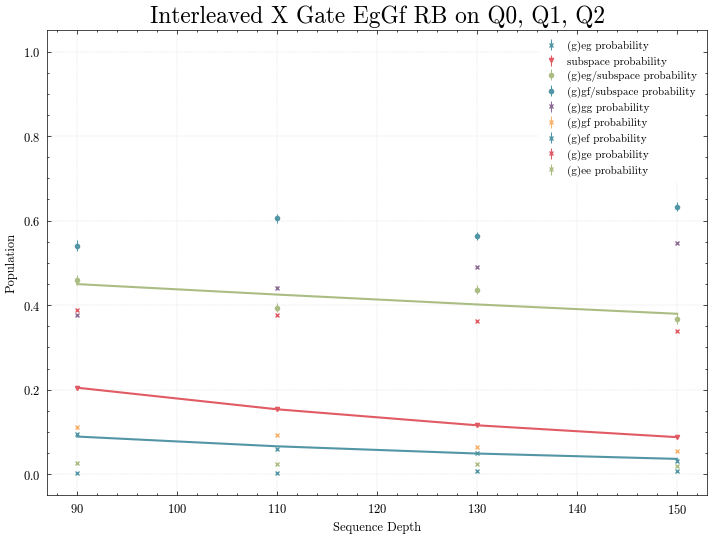

In [ ]:
filename_12_irb_2, data_12_irb_2, rbprog_12_irb_2 = run_rb(
    qDrive=qDrive,
    depths=depths,
    variations=variations,
    reps=reps,
    loops=loops,
    singleshot_reps=singleshot_reps,
    gate_char='X',
    validate_variations=True,
    save_data=True)

In [ ]:
print("Saved data", filename_12_irb_2)

Saved data S:\QRAM\qram_4QR2\data\data_250119\00015_rb_EgGf_qubit21.h5


# Error amplification for leakage

## Using pipi experiment, kind of bad

In [12]:
# qubits = [2, 1] # order doesn't matter if you specify qDrive correctly
# init_state = '|0>|1>'
# wrong_init_state = '|1>|1>'
# setup_ZZ = None
# # measure_qubits = [qubits[0], qubits[1], 3]
# measure_qubits = qubits
# qDrive = qubits[0] # normal new protocol

qubits = [3, 1] # order doesn't matter if you specify qDrive correctly
init_state = '|1>|1>' # for everything else
wrong_init_state = '|0>|1>'
setup_ZZ = 0 # for the amp rabi chevron
# measure_qubits = [qubits[0], qubits[1], 2]
measure_qubits = qubits
qDrive = qubits[0] # normal new protocol

# init_state = '|0>|2>'
# qDrive = qubits[1]


# f0-g1
# # init_state = '|0>|0>'
# # qDrive = 1 # resonator f0-g1

sweep2Q_q = qDrive

full_mux_expt = False
resonator_reset = [0, 2, 3] if full_mux_expt else None
use_robust_pulses = True

test_pi_half = True

In [33]:
# Q3/Q1 sweep
len_sweep=[0.41423002407926174, 0.34269455421503864, 0.29110476429984883, 0.24874669628911195, 0.2199548983178091, 0.2020861425417043, 0.18250152594941127, 0.1676613742325565, 0.15357097763287902, 0.1418394586635039, 0.13117702458358807, 0.12178942465536591, 0.11578401043424631, 0.11075848248788242, 0.10448723704560985, 0.09951109117360128, 0.09664469008168952, 0.09064274972329202, 0.08628864072542938, 0.08199132287522362, 0.07931563419005563, 0.07581421284827643, 0.07386521467198023, 0.069959016045751, 0.06889146706335908, 0.06835413640748393, 0.06446941297141699, 0.06223220891067346, 0.06064569351718567, 0.058670697089451156]
gain_sweep=[2473.9986380682044, 3042.052983424375, 3593.194274447699, 4325.473761803941, 4776.029802485564, 5183.594899286987, 5731.691076853539, 6245.4702710601505, 6884.232273539349, 7416.340893598161, 8018.777776951703, 8568.425353399247, 9146.491300596581, 9561.20309220798, 10069.300827211373, 10554.617670934691, 10781.839645624637, 11776.660968411954, 12415.263855277552, 12841.672671464126, 13360.863255357068, 14115.901515690313, 14619.168722433467, 15171.69890196693, 15248.935502976537, 15730.985700697123, 16637.740831737985, 17205.005889321557, 17839.822043389868, 18530.151534931512]
freq_sweep=[5142.368818005041, 5142.200345806339, 5141.9564793659065, 5141.697539652303, 5141.407972650505, 5141.064440049666, 5140.697574046106, 5140.330040741174, 5139.843429992427, 5139.392529235084, 5138.905333948207, 5138.33833801746, 5137.783555801703, 5137.109798888519, 5136.476127532039, 5135.848148881454, 5135.039412449819, 5134.3543596999425, 5133.570705645279, 5132.701335536354, 5131.796993407784, 5130.97652689619, 5130.0559769829715, 5129.114172858743, 5128.04872429693, 5127.019279680188, 5126.011590712254, 5124.958317604664, 5123.87207987953, 5122.738473714098]

len_sweep = np.array(len_sweep)
gain_sweep = np.array(gain_sweep)
freq_sweep = np.array(freq_sweep)

freq_sweep = [5140.1, 5139.60418056989, 5139.014387532425]
len_sweep = [0.165, 0.15357098, 0.138]
gain_sweep = [6245.47027106, 6792, 7560 ]

print(len_sweep)
print(gain_sweep)
print(freq_sweep)

[0.165, 0.15357098, 0.138]
[6245.47027106, 6792, 7560]
[5140.1, 5139.60418056989, 5139.014387532425]


In [34]:
good_data = False

train_expt = meas.PiTrainEgGfGainSweepExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"eggf_train_Q{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

i_len = 1
pi_freq = freq_sweep[i_len]
pi_gain = gain_sweep[i_len]
pi_len = len_sweep[i_len] 
print(pi_freq, pi_gain, pi_len)

train_expt.cfg.device.qubit.f_EgGf_Q_half[qDrive] = pi_freq
train_expt.cfg.device.qubit.pulses.pi_EgGf_Q.half_gain[qDrive] = pi_gain
train_expt.cfg.device.qubit.pulses.pi_EgGf_Q.half_sigma[qDrive] = pi_len


start_N = 1 # this is the number of pi swap cycles
step_N = 1 if not good_data else 2
expts_N = 20 if not good_data else 10
# start_N = 30 # this is the number of pi swap cycles
# step_N = 30
# expts_N = 2

start_gain = train_expt.cfg.device.qubit.pulses.pi_EgGf_Q.gain[qDrive]
if test_pi_half:
    start_gain = train_expt.cfg.device.qubit.pulses.pi_EgGf_Q.half_gain[qDrive]

train_expt.cfg.expt = dict(
    start_N=start_N,
    step_N=step_N,
    expts_N=expts_N,

    start_gain=start_gain,
    step_gain=0,
    expts_gain=1,

    reps=3000 if not good_data else 3000,
    loops=2,

    pulse_type='flat_top',
    post_process='threshold',
    singleshot_reps=10000,
    measure_f=False,
    init_state=wrong_init_state,
    qDrive=qDrive,
    qubits=qubits,
    measure_qubits=measure_qubits,

    test_pi_half=test_pi_half,
    # test_pi_half=False,

    full_mux_expt=full_mux_expt,
    resonator_reset=resonator_reset,

    use_robust_pulses=use_robust_pulses,
)

print(train_expt.cfg)
try:
    train_expt.acquire(progress=True, debug=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))


5139.60418056989 6792 0.15357098
{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-390.00045219204236, 5795.770150727347, 502.42095511476606, -228.8557536534039], 'gain': [0.6, 0.5, 0.5, 0.3], 'readout_length': [4.5, 16, 6.0, 10], 'frequency_ef': [-390.0004521920423, 5795.76166666, 500.48386902205084, -230.30732892], 'gain_ef': [0.5, 0.6, 0.4, 0.25], 'readout_length_ef': [4.5, 20, 10, 8], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4108.766531009945, 4103.383654420363, 4108.649372291309, 4108.232503550693, 3442.5785669321162, 3447.980836072279, 3446.872635941306, 3446.65966586083, 4760.911839134516, 4759.946893523059, 4761.052602755913, 4760.46101643607, 4377.996318964773, 4377.247239665757, 4377.995764386313, 4378.454058265707], 'f_ef': [3882.6760964004225, 0.0, 3882.593023159515, 3882.5465667921762, 3345.3957364303, 3347.511433910277, 3347.003494996075, 3346.9817293387923, 4572.523325892487, 4571.192833780465, 4573.063027684978, 0.0,

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 72.57000000000001 	 angle (deg): -31.569124510695445 	 threshold ge: 89.75279818802522
Qubit  (1)
ge fidelity (%): 65.29 	 angle (deg): 167.28858316033364 	 threshold ge: 70.57044981776554


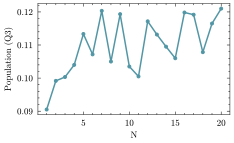

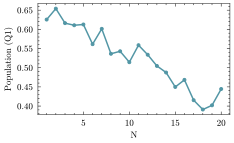

In [35]:
data = train_expt.data
gain_sweep = data["gain_sweep"]
cycle_sweep = data["cycle_sweep"]
data_name = "avgi"

plt.figure()

plot_data = data[data_name][0][:, 0]
scaled_e = np.max(plot_data)
scaled_g = np.min(plot_data)
scale_ge = scaled_e - scaled_g

plt.plot(cycle_sweep, plot_data, 'o-')
plt.xlabel("N")
plt.ylabel(f"Population (Q{qDrive})")
plt.show()


plt.figure()

plot_data = data[data_name][1][:, 0]
scaled_e = np.max(plot_data)
scaled_g = np.min(plot_data)
scale_ge = scaled_e - scaled_g

plt.plot(cycle_sweep, plot_data, 'o-')
plt.xlabel("N")
plt.ylabel(f"Population (Q1)")
plt.show()



# inner_sweep = gain_sweep
# outer_sweep = cycle_sweep

# y_sweep = outer_sweep
# x_sweep = inner_sweep

#         plt.figure(figsize=(8, 9))
#         plt.suptitle(title, fontsize=20)
#         # data_name = "amps"
#         data_name = "avgi"

#         ax_qA = plt.subplot(211, title=f"QA ({qA})")
#         ax_qA.set_ylabel(f"N", fontsize=18)
#         ax_qA.tick_params(axis="both", which="major", labelsize=16)
#         plt.pcolormesh(x_sweep, y_sweep, (plot_data - scaled_g) / scale_ge, cmap="viridis", shading="auto")
#         if fit:
#             plt.axvline(data["best_gain"], color="r", linestyle="--")
#         cbar = plt.colorbar()
#         cbar.ax.tick_params(labelsize=18)

#         ax_qB = plt.subplot(212, title=f"QB ({qB})")
#         ax_qB.set_ylabel(f"N", fontsize=18)
#         ax_qB.set_xlabel("Gain [DAC units]", fontsize=18)
#         ax_qB.tick_params(axis="both", which="major", labelsize=16)
#         plot_data = data[data_name][1]
#         scaled_e = np.max(plot_data)
#         scaled_g = np.min(plot_data)
#         scale_ge = scaled_e - scaled_g
#         plt.pcolormesh(x_sweep, y_sweep, (plot_data - scaled_g) / scale_ge, cmap="viridis", shading="auto")
#         if fit:
#             plt.axvline(data["best_gain"], color="r", linestyle="--")
#         cbar = plt.colorbar()
#         cbar.ax.tick_params(labelsize=18)

#         plt.tight_layout()
#         plt.show()

In [ ]:
print(train_expt.save_data())

Saving S:\QRAM\qram_4QR2\data\data_250119\00071_eggf_train_Q31.h5
S:\QRAM\qram_4QR2\data\data_250119\00071_eggf_train_Q31.h5


## Using RB experiment

### Q3/Q1

In [53]:
# qubits = [2, 1]
# qDrive = 2

qubits = [3, 1]
qDrive = 3

full_mux_expt = False
resonator_reset = [0, 2, 3] if full_mux_expt else None
use_robust_pulses = True

depths 15
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


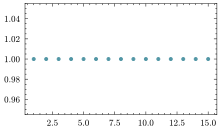

In [54]:
step_1 = 1
end_1 = 15

step_2 = 10
end_2 = 100
range1 = np.arange(1, end_1+step_1, step_1)
range2 = np.arange(range1[-1]+step_2, end_2+step_2, step_2)
# depths = np.concatenate((range1, range2))

depths = range1
# depths = np.arange(0, 50, step=1)

# depths = [1, 2, 3, 4]

print('depths', len(depths))
print(depths)

plt.figure()
plt.plot(depths, np.ones_like(depths), 'o')
plt.show()

In [36]:
import yaml
print('Using config file', config_path)
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

Using config file s:\Connie\experiments\qram_tprocv1_expts\configs\config_q3diamond_full688and638_reset.yml


In [55]:
# opt_lens = [0.18250152594941127, 0.1676613742325565, 0.15357097763287902, 0.1418394586635039, 0.13117702458358807]
# opt_gains = [5657.168161853172, 6150.983353266968, 6782.128457957817, 7245.190247135695, 8029.645379263763]
# opt_freqs = [5140.432737547473, 5140.031785178021, 5139.552491375231, 5139.005373491645, 5138.416254913107]

# opt_lens=[0.19, 0.145]
# opt_gains=[5405.977203702664, 7017.91003749196]
# opt_freqs=[5140.613420923874, 5139.011620794662]

opt_lens = [0.050, 0.060, 0.067, 0.070, 0.080]
opt_gains = [17500, 17833, 15750, 15150, 13200]
opt_freqs = [5123.7, 5122.5, 5126.9, 5128.0, 5131.4]

# opt_freqs = [yaml_cfg.device.qubit.f_EgGf_Q_half[qDrive]]
# opt_gains = [yaml_cfg.device.qubit.pulses.pi_EgGf_Q.half_gain[qDrive]]
# opt_lens = [yaml_cfg.device.qubit.pulses.pi_EgGf_Q.half_sigma[qDrive]]

# opt_gains = [12873.834524359774]
# opt_freqs = [5884.047661301816]
# opt_lens = [0.205]

print("opt_lens =", opt_lens)
print("opt_gains =", opt_gains)
print("opt_freqs =", opt_freqs)

saved_files = []

opt_lens = [0.05, 0.06, 0.067, 0.07, 0.08]
opt_gains = [17500, 17833, 15750, 15150, 13200]
opt_freqs = [5123.7, 5122.5, 5126.9, 5128.0, 5131.4]


Starting 0 with len 0.05 gain 17500 freq 5123.7
Will save to S:\QRAM\qram_4QR2\data\data_250119\00030_leakage_EgGf_qubit31.h5
{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-390.00045219204236, 5795.770150727347, 502.42095511476606, -228.8557536534039], 'gain': [0.6, 0.8, 0.5, 0.3], 'readout_length': [4.5, 12, 8.0, 10], 'frequency_ef': [-390.0004521920423, 5795.770150727347, 500.48386902205084, -230.30732892], 'gain_ef': [0.5, 0.5, 0.6, 0.25], 'readout_length_ef': [4.5, 16, 8, 8], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4108.755047003828, 4103.366954082312, 4108.649372291309, 4108.232503550693, 3442.591941352887, 3447.981518133789, 3446.872635941306, 3446.65966586083, 4760.911839134516, 4759.946893523059, 4761.052602755913, 4760.46101643607, 4377.996318964773, 4377.247239665757, 4377.995764386313, 4378.454058265707], 'f_ef': [3882.6760964004225, 0.0, 3882.593023159515, 3882.5465667921762, 3345.3957364303, 3347.507450556916, 3347.

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 0


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.92931693169314 	 angle (deg): -54.63280388053194 	 threshold ge: 172.7309258406362
Qubit (1) ge
ge fidelity (%): 73.9290789078908 	 angle (deg): 77.46401204368173 	 threshold ge: 84.83765539558502
Qubit (3) ge
ge fidelity (%): 76.33 	 angle (deg): -128.60874974865658 	 threshold ge: 55.57204282055932
thresholds=[172.7309258406362, 84.83765539558502, 0, 55.57204282055932],
angles=[-54.63280388053194, 77.46401204368173, 0, -128.60874974865658],
ge_avgs=[array([ 26.96249334, 115.0652966 , 101.91094602, 220.65599313]), array([ 43.30622857, -53.73594824,  52.96725827, -97.18486883]), array([0., 0., 0., 0.]), array([-26.6202821 ,  19.4136166 , -56.3684709 ,  56.66685967])],
counts_calib=[[7993, 473, 721, 113, 511, 38, 132, 19], [1471, 6810, 142, 838, 87, 452, 29, 171], [837, 6952, 98, 1361, 54, 459, 17, 222], [1363, 98, 7376, 532, 156, 16, 424, 35], [266, 978, 1344, 6242, 48, 211, 175, 736], [203, 1006, 709, 6948, 38, 246, 90, 760], [962, 59, 81, 7, 7811, 489

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.76999999999998
Qubit (1) ge
ge fidelity (%): 71.36000000000003
Qubit (3) gf
gf fidelity (%): 53.37999999999998
thresholds_f=[135.75552050695111, 34.92595020886864, 0, -58.3233259595973],
angles_f=[-50.12587928466231, 32.02361978336425, 0, -2.362991707374719],
gf_avgs=[array([ 10.63296621, 100.25917851,  81.93652554, 185.61559465]), array([ -4.31634264, -40.02970446,  26.19715931, -59.11415174]), array([0., 0., 0., 0.]), array([-77.09231786,  28.0468688 , -49.12816322,  29.20082038])],
counts_calib_f=[[7214, 1271, 743, 135, 450, 99, 75, 13], [6988, 1164, 1030, 168, 422, 83, 124, 21], [2467, 5165, 464, 1295, 171, 255, 55, 128], [1436, 272, 6217, 1198, 175, 39, 565, 98], [1161, 187, 6727, 1097, 153, 26, 553, 96], [523, 830, 2695, 4866, 91, 99, 358, 538], [847, 152, 84, 9, 6571, 1178, 997, 162], [757, 140, 108, 22, 6104, 973, 1621, 275], [352, 538, 63, 150, 2092, 4180, 702, 1923], [192, 32, 532, 115, 1155, 220, 6499, 1255], [251, 39, 551, 112, 1038, 167, 67

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 1


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.02940194019405 	 angle (deg): -56.29774646686395 	 threshold ge: 163.3173317293407
Qubit (1) ge
ge fidelity (%): 72.06923392339235 	 angle (deg): 77.05150364073175 	 threshold ge: 85.65597115101365
Qubit (3) ge
ge fidelity (%): 76.05000000000001 	 angle (deg): -60.6583197488375 	 threshold ge: 55.00164877217121
thresholds=[163.3173317293407, 85.65597115101365, 0, 55.00164877217121],
angles=[-56.29774646686395, 77.05150364073175, 0, -60.6583197488375],
ge_avgs=[array([ 21.78033488, 114.9742377 ,  94.06934957, 223.35780738]), array([ 42.82089615, -53.69164029,  52.54489843, -95.98433337]), array([0., 0., 0., 0.]), array([ 6.34406794, 31.58238747, 30.04708359, 73.74876077])],
counts_calib=[[8072, 540, 696, 75, 528, 30, 53, 6], [1509, 6895, 148, 869, 82, 416, 11, 70], [856, 7222, 83, 1214, 55, 491, 7, 72], [1703, 91, 7036, 510, 163, 13, 455, 29], [259, 959, 1466, 6520, 29, 174, 91, 502], [186, 1208, 803, 7045, 28, 169, 55, 506], [895, 54, 37, 4, 7984, 486, 

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.58000000000001
Qubit (1) ge
ge fidelity (%): 70.87000000000003
Qubit (3) gf
gf fidelity (%): 53.97000000000003
thresholds_f=[131.98216926221454, 40.309964461995605, 0, -58.40698010255282],
angles_f=[-51.86349506755304, 37.55070847673506, 0, 82.80195163371691],
gf_avgs=[array([  6.46790608, 100.75191722,  73.25930029, 185.8224597 ]), array([ -2.86350313, -39.33624944,  25.87063947, -61.42516387]), array([0., 0., 0., 0.]), array([22.44687132, 77.66436013, 26.03723881, 49.23588743])],
counts_calib_f=[[6987, 1514, 627, 151, 519, 92, 91, 19], [6958, 1264, 870, 168, 486, 100, 130, 24], [2126, 5424, 405, 1061, 189, 442, 109, 244], [1481, 326, 5932, 1328, 188, 39, 592, 114], [1231, 237, 6368, 1223, 168, 43, 609, 121], [497, 965, 2361, 5311, 78, 89, 268, 431], [825, 212, 68, 22, 6552, 1493, 677, 151], [727, 147, 101, 21, 6498, 1252, 1031, 223], [309, 406, 69, 194, 2205, 4761, 542, 1514], [201, 46, 603, 143, 1308, 253, 6134, 1312], [227, 38, 574, 106, 1161, 212, 

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 2


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.60999999999997 	 angle (deg): -58.188236010662074 	 threshold ge: 165.0424553573734
Qubit (1) ge
ge fidelity (%): 73.1891129112911 	 angle (deg): 77.56559304258828 	 threshold ge: 82.99503349375209
Qubit (3) ge
ge fidelity (%): 77.21000000000004 	 angle (deg): 116.62582604181814 	 threshold ge: 56.1189609935428
thresholds=[165.0424553573734, 82.99503349375209, 0, 56.1189609935428],
angles=[-58.188236010662074, 77.56559304258828, 0, 116.62582604181814],
ge_avgs=[array([ 18.38001838, 115.72948632,  87.70967677, 227.49553249]), array([ 42.26663996, -53.42368926,  51.71868899, -96.29131329]), array([0., 0., 0., 0.]), array([ -4.24239977, -33.79769297, -26.16946165, -77.53577035])],
counts_calib=[[7905, 560, 767, 90, 524, 47, 90, 17], [1341, 6970, 161, 932, 75, 396, 16, 109], [796, 6893, 96, 1289, 58, 478, 36, 354], [1463, 110, 7148, 575, 147, 13, 498, 46], [278, 1046, 1333, 6523, 33, 167, 94, 526], [140, 1152, 795, 6854, 26, 172, 58, 803], [827, 48, 73, 14,

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.00000000000001
Qubit (1) ge
ge fidelity (%): 69.76999999999998
Qubit (3) gf
gf fidelity (%): 52.19999999999999
thresholds_f=[133.61940297019382, 40.46355744632977, 0, -56.265648822360234],
angles_f=[-54.12621378565064, 36.476578124633036, 0, -146.52144398121797],
gf_avgs=[array([  3.35835868,  99.67664718,  70.74031795, 192.85089081]), array([ -3.53521813, -38.19570678,  25.20036757, -59.4407485 ]), array([0., 0., 0., 0.]), array([ 43.34455582, -68.45665207,  20.51782274, -53.36025008])],
counts_calib_f=[[7402, 1348, 527, 91, 480, 88, 55, 9], [7363, 1040, 798, 117, 505, 76, 87, 14], [2673, 5520, 342, 806, 203, 331, 43, 82], [1822, 323, 6115, 1043, 186, 27, 414, 70], [1358, 214, 6772, 1031, 136, 19, 411, 59], [651, 1005, 2706, 4933, 83, 96, 204, 322], [776, 136, 45, 15, 7192, 1190, 547, 99], [761, 129, 64, 15, 6860, 922, 1084, 165], [350, 609, 33, 86, 2405, 4814, 434, 1269], [266, 52, 547, 95, 1448, 283, 6290, 1019], [201, 45, 542, 81, 1252, 175, 6718, 9

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 3


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.02 	 angle (deg): -60.26614152207895 	 threshold ge: 159.1581649836207
Qubit (1) ge
ge fidelity (%): 74.65919991999203 	 angle (deg): 77.02512403805692 	 threshold ge: 83.4781686575449
Qubit (3) ge
ge fidelity (%): 75.93937493749377 	 angle (deg): -171.103696459869 	 threshold ge: 56.633601475224935
thresholds=[159.1581649836207, 83.4781686575449, 0, 56.633601475224935],
angles=[-60.26614152207895, 77.02512403805692, 0, -171.103696459869],
ge_avgs=[array([ 14.81637981, 114.82358589,  80.11732634, 229.15129624]), array([ 42.37081582, -53.23297895,  52.27567735, -96.22164105]), array([0., 0., 0., 0.]), array([-33.30666693,  -3.88824567, -80.39560687,   3.48257311])],
counts_calib=[[8035, 524, 691, 102, 555, 26, 52, 15], [1471, 6902, 161, 847, 89, 423, 20, 87], [942, 7104, 90, 1206, 46, 481, 4, 127], [1424, 87, 7459, 434, 158, 10, 397, 31], [253, 1136, 1365, 6561, 30, 161, 74, 420], [195, 1195, 737, 7240, 25, 126, 48, 434], [907, 46, 93, 6, 7797, 503, 603,

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.5
Qubit (1) ge
ge fidelity (%): 73.20000000000002
Qubit (3) gf
gf fidelity (%): 52.839999999999996
thresholds_f=[134.41574863377892, 39.86966153461706, 0, -59.11915435993588],
angles_f=[-55.65473279077731, 37.64900503701357, 0, -158.60308157918607],
gf_avgs=[array([  0.52744703, 101.1972474 ,  64.40883285, 194.6851102 ]), array([ -3.56018716, -38.04668763,  26.3251002 , -61.10220401]), array([0., 0., 0., 0.]), array([ 57.56527278, -57.73743674,  31.74678714, -47.6208847 ])],
counts_calib_f=[[7109, 1560, 575, 113, 453, 120, 58, 12], [6954, 1442, 840, 167, 416, 107, 64, 10], [2360, 5623, 366, 1012, 154, 319, 46, 120], [1417, 320, 6226, 1316, 150, 44, 429, 98], [1199, 258, 6525, 1326, 153, 26, 424, 89], [593, 1079, 2383, 5245, 84, 89, 171, 356], [753, 181, 58, 17, 6691, 1450, 708, 142], [761, 147, 73, 17, 6351, 1193, 1205, 253], [342, 596, 52, 98, 2085, 4793, 503, 1531], [219, 54, 539, 110, 1223, 231, 6366, 1258], [181, 47, 577, 102, 978, 222, 6685, 1208],

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 4


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.18941494149416 	 angle (deg): -61.79722544033088 	 threshold ge: 166.82837376414275
Qubit (1) ge
ge fidelity (%): 73.46000000000004 	 angle (deg): 78.16355028805238 	 threshold ge: 84.9464346343074
Qubit (3) ge
ge fidelity (%): 74.28999999999998 	 angle (deg): 73.51714307195907 	 threshold ge: 57.23305776501529
thresholds=[166.82837376414275, 84.9464346343074, 0, 57.23305776501529],
angles=[-61.79722544033088, 78.16355028805238, 0, 73.51714307195907],
ge_avgs=[array([ 11.37468401, 115.95729139,  72.78642721, 230.47639204]), array([ 42.81056527, -53.54762366,  51.69451991, -95.93797876]), array([0., 0., 0., 0.]), array([ 15.68675824, -29.05631074,  28.89193652, -73.68527594])],
counts_calib=[[8129, 539, 637, 93, 512, 31, 54, 5], [1661, 6845, 130, 737, 111, 440, 14, 62], [990, 7227, 84, 1037, 72, 499, 5, 86], [1566, 120, 7233, 438, 174, 13, 420, 36], [300, 1519, 1354, 6195, 46, 136, 77, 373], [204, 1376, 861, 6888, 31, 141, 53, 446], [955, 59, 60, 6, 7894

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.71999999999998
Qubit (1) ge
ge fidelity (%): 74.12
Qubit (3) gf
gf fidelity (%): 53.04000000000002
thresholds_f=[135.85972055947812, 39.470234696531925, 0, -55.66627808693934],
angles_f=[-57.300938194035425, 37.05955858446646, 0, 85.44676956074024],
gf_avgs=[array([ -3.10745637, 100.63674363,  58.16433538, 196.0808055 ]), array([ -2.99513249, -37.58687556,  27.29292281, -60.45996338]), array([0., 0., 0., 0.]), array([28.86082644, 75.04716924, 31.08597941, 47.10582531])],
counts_calib_f=[[7241, 1426, 590, 114, 477, 92, 52, 8], [7004, 1234, 934, 141, 483, 74, 114, 16], [2474, 5551, 392, 961, 165, 301, 57, 99], [1393, 278, 6513, 1245, 135, 28, 340, 68], [1283, 222, 6822, 1062, 118, 33, 385, 75], [495, 992, 2624, 5258, 72, 66, 160, 333], [771, 160, 66, 12, 6872, 1267, 716, 136], [871, 141, 91, 21, 6448, 1081, 1135, 212], [351, 589, 54, 98, 2227, 4599, 561, 1521], [263, 50, 627, 87, 1243, 267, 6246, 1217], [173, 34, 627, 134, 1122, 206, 6703, 1001], [90, 169

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 5


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.60931393139312 	 angle (deg): -63.261612952782095 	 threshold ge: 190.90376145091616
Qubit (1) ge
ge fidelity (%): 66.8 	 angle (deg): 77.06220318449017 	 threshold ge: 89.06343783054078
Qubit (3) ge
ge fidelity (%): 75.76 	 angle (deg): -89.22718265084906 	 threshold ge: 55.41631035960934
thresholds=[190.90376145091616, 89.06343783054078, 0, 55.41631035960934],
angles=[-63.261612952782095, 77.06220318449017, 0, -89.22718265084906],
ge_avgs=[array([ 10.06773321, 122.64841932,  68.00947677, 237.66072446]), array([ 43.61911283, -58.27532477,  52.53704346, -97.09535795]), array([0., 0., 0., 0.]), array([-8.17851676, 32.04148281, -7.53229521, 79.94869147])],
counts_calib=[[7611, 495, 1004, 182, 546, 45, 102, 15], [1403, 6703, 189, 1059, 87, 476, 12, 71], [770, 6801, 111, 1566, 58, 528, 11, 155], [1743, 105, 6997, 501, 182, 14, 421, 37], [349, 1337, 1399, 6210, 32, 169, 80, 424], [300, 1617, 742, 6607, 38, 193, 42, 461], [951, 50, 111, 24, 7955, 481, 388, 40

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.54999999999998
Qubit (1) ge
ge fidelity (%): 59.555955595559574
Qubit (3) gf
gf fidelity (%): 53.02656565656563
thresholds_f=[140.92535633938218, 42.14819101517421, 0, -55.82295097657088],
angles_f=[-59.13538762455514, 37.28713476798008, 0, 48.06186894849897],
gf_avgs=[array([ -5.80772091, 100.69502836,  52.77027844, 198.70906172]), array([  0.80039888, -40.65903933,  24.94993392, -59.04748704]), array([0., 0., 0., 0.]), array([-25.97388173,  76.92465077,  -7.20147372,  56.03045118])],
counts_calib_f=[[6837, 1083, 1295, 218, 438, 73, 46, 10], [6724, 877, 1532, 195, 491, 73, 93, 15], [2012, 4264, 1041, 2018, 202, 294, 63, 106], [1988, 318, 6076, 981, 174, 26, 382, 55], [1262, 166, 6940, 920, 189, 21, 450, 52], [571, 871, 2796, 5087, 75, 79, 209, 312], [850, 113, 105, 12, 7144, 1165, 533, 78], [778, 98, 197, 29, 6858, 974, 929, 137], [356, 568, 90, 172, 2390, 4615, 584, 1225], [238, 39, 716, 125, 1456, 225, 6211, 990], [287, 31, 633, 106, 1266, 170, 6600,

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 6


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.66900390038998 	 angle (deg): -65.6137555147462 	 threshold ge: 164.37442124414574
Qubit (1) ge
ge fidelity (%): 75.93930193019303 	 angle (deg): 77.63116575066591 	 threshold ge: 85.54477613309172
Qubit (3) ge
ge fidelity (%): 76.62958695869591 	 angle (deg): -51.49084210371763 	 threshold ge: 58.98972281940649
thresholds=[164.37442124414574, 85.54477613309172, 0, 58.98972281940649],
angles=[-65.6137555147462, 77.63116575066591, 0, -51.49084210371763],
ge_avgs=[array([  5.57250101, 117.15854768,  59.78573184, 236.74725962]), array([ 42.66126739, -53.43095212,  52.42875548, -97.97154221]), array([0., 0., 0., 0.]), array([13.13939508, 29.46428789, 43.19972031, 67.2429001 ])],
counts_calib=[[8275, 364, 639, 67, 589, 23, 39, 4], [1632, 6747, 160, 816, 81, 490, 18, 56], [918, 6926, 95, 1185, 76, 552, 29, 219], [1433, 60, 7523, 355, 162, 4, 441, 22], [326, 1468, 1314, 6227, 43, 123, 92, 407], [199, 1135, 841, 7201, 20, 142, 54, 408], [885, 36, 56, 7, 8119, 3

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.49
Qubit (1) ge
ge fidelity (%): 74.05827382738276
Qubit (3) gf
gf fidelity (%): 52.34000000000003
thresholds_f=[137.78390691188952, 39.021245763842494, 0, -56.03623316718381],
angles_f=[-61.27774508428691, 39.39772095407623, 0, 78.41164377932121],
gf_avgs=[array([ -7.40962337, 100.54401151,  47.20743119, 200.21217699]), array([ -2.96566698, -36.8970809 ,  26.64232616, -61.21538838]), array([0., 0., 0., 0.]), array([17.52276566, 78.75103572, 23.04535537, 51.81929117])],
counts_calib_f=[[7206, 1274, 734, 125, 505, 86, 63, 7], [7154, 1082, 973, 145, 432, 79, 117, 18], [2538, 5179, 476, 1094, 204, 335, 59, 115], [1299, 214, 6720, 1141, 138, 21, 417, 50], [1091, 167, 7013, 1052, 136, 18, 447, 76], [475, 841, 2691, 5301, 71, 71, 214, 336], [742, 152, 87, 18, 6890, 1186, 779, 146], [770, 123, 108, 17, 6467, 951, 1363, 201], [380, 583, 64, 132, 2249, 4372, 642, 1578], [209, 39, 647, 126, 1136, 200, 6511, 1132], [170, 41, 699, 106, 1003, 146, 6868, 967], [92, 1

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 7


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.03936193619364 	 angle (deg): -66.9386260691023 	 threshold ge: 158.65571649572848
Qubit (1) ge
ge fidelity (%): 77.02938993899392 	 angle (deg): 77.04213559848439 	 threshold ge: 87.46343600024116
Qubit (3) ge
ge fidelity (%): 74.78 	 angle (deg): 144.0672880180626 	 threshold ge: 57.92539388346678
thresholds=[158.65571649572848, 87.46343600024116, 0, 57.92539388346678],
angles=[-66.9386260691023, 77.04213559848439, 0, 144.0672880180626],
ge_avgs=[array([  1.12169016, 117.75291056,  52.55545232, 238.56329674]), array([ 42.41189889, -54.23151552,  52.69880646, -98.93898321]), array([0., 0., 0., 0.]), array([-21.23562432, -25.91389551, -60.07954762, -54.06601872])],
counts_calib=[[8303, 435, 527, 74, 561, 34, 54, 12], [1724, 6794, 135, 650, 100, 512, 12, 73], [811, 7305, 83, 1121, 46, 520, 10, 104], [1396, 80, 7513, 371, 153, 3, 453, 31], [263, 1161, 1144, 6742, 37, 153, 80, 420], [191, 1315, 779, 7005, 22, 165, 47, 476], [857, 32, 50, 10, 8159, 429, 441

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.31
Qubit (1) ge
ge fidelity (%): 73.32000000000001
Qubit (3) gf
gf fidelity (%): 50.519999999999975
thresholds_f=[136.54625363686563, 39.7218158406144, 0, -60.57705343520489],
angles_f=[-62.23641593524094, 35.94978974606056, 0, -84.11805791434894],
gf_avgs=[array([-11.48595014, 101.89330159,  40.75854262, 201.13664081]), array([ -3.48860028, -38.49863585,  26.79292065, -60.45892989]), array([0., 0., 0., 0.]), array([-38.45413812, -73.00652921, -35.72224894, -46.48884845])],
counts_calib_f=[[7153, 1510, 570, 99, 492, 104, 60, 12], [7124, 1321, 749, 180, 426, 86, 105, 9], [2408, 4783, 591, 1528, 188, 305, 59, 138], [1435, 324, 6276, 1365, 140, 32, 353, 75], [1203, 251, 6675, 1244, 117, 38, 399, 73], [487, 1095, 2457, 5260, 69, 89, 178, 365], [775, 167, 57, 6, 6720, 1438, 692, 145], [773, 139, 84, 21, 6383, 1292, 1092, 216], [380, 584, 92, 181, 2176, 4438, 570, 1579], [232, 45, 584, 116, 1216, 280, 6224, 1303], [217, 40, 597, 100, 1102, 190, 6576, 1178], [

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 8


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.78933793379338 	 angle (deg): -68.49853041535216 	 threshold ge: 164.1667729819603
Qubit (1) ge
ge fidelity (%): 75.06916891689167 	 angle (deg): 76.94272416234631 	 threshold ge: 83.66133612039825
Qubit (3) ge
ge fidelity (%): 75.51944594459447 	 angle (deg): 165.97951485234051 	 threshold ge: 57.289437029265514
thresholds=[164.1667729819603, 83.66133612039825, 0, 57.289437029265514],
angles=[-68.49853041535216, 76.94272416234631, 0, 165.97951485234051],
ge_avgs=[array([ -1.12761729, 119.43466462,  46.50777431, 240.35505586]), array([ 42.50979761, -54.09573584,  52.53978323, -97.34309034]), array([0., 0., 0., 0.]), array([-29.26119733, -16.32695908, -75.47558704, -27.86705247])],
counts_calib=[[8000, 486, 757, 79, 570, 32, 65, 11], [1578, 6790, 163, 858, 90, 440, 12, 69], [855, 6509, 94, 1475, 57, 628, 23, 359], [1373, 73, 7485, 443, 153, 11, 436, 26], [258, 1150, 1191, 6783, 24, 131, 68, 395], [193, 1094, 774, 7290, 29, 116, 48, 456], [901, 58, 79, 13

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.02935193519352
Qubit (1) ge
ge fidelity (%): 75.94999999999999
Qubit (3) gf
gf fidelity (%): 51.436529652965305
thresholds_f=[134.57829911792533, 38.69247554745325, 0, -57.05268257633385],
angles_f=[-64.19730897310573, 35.28822412968566, 0, -148.07144672538726],
gf_avgs=[array([-14.13990847, 100.22705499,  34.69035181, 201.22519385]), array([ -3.81389294, -38.89386586,  27.82503894, -61.28571715]), array([0., 0., 0., 0.]), array([ 45.76490797, -67.7746343 ,  22.9666939 , -53.56822762])],
counts_calib_f=[[7325, 1318, 600, 91, 512, 84, 58, 12], [7281, 1141, 826, 122, 461, 67, 83, 19], [2565, 5104, 522, 1074, 213, 330, 61, 131], [1244, 219, 6647, 1198, 158, 39, 428, 67], [1569, 220, 6507, 969, 184, 35, 437, 79], [650, 1027, 2540, 5084, 90, 74, 195, 340], [810, 144, 67, 14, 6941, 1237, 669, 118], [836, 137, 90, 22, 6472, 987, 1267, 189], [368, 515, 77, 131, 2243, 4377, 644, 1645], [264, 47, 573, 118, 1157, 231, 6507, 1103], [205, 41, 671, 106, 1088, 204, 65

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 9


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.70932393239326 	 angle (deg): -70.39299143293012 	 threshold ge: 166.82377329130804
Qubit (1) ge
ge fidelity (%): 75.41928792879285 	 angle (deg): 78.30922735743825 	 threshold ge: 85.20065066410876
Qubit (3) ge
ge fidelity (%): 76.98000000000002 	 angle (deg): -102.3976235220446 	 threshold ge: 58.080858326113315
thresholds=[166.82377329130804, 85.20065066410876, 0, 58.080858326113315],
angles=[-70.39299143293012, 78.30922735743825, 0, -102.3976235220446],
ge_avgs=[array([ -5.0881186 , 118.28921592,  39.16319653, 242.5132597 ]), array([ 43.10677084, -53.50236283,  52.28121834, -97.84005176]), array([0., 0., 0., 0.]), array([-16.67536413,  28.79679072, -27.09346283,  76.19039391])],
counts_calib=[[8171, 432, 623, 85, 606, 29, 46, 8], [1507, 6929, 141, 765, 92, 496, 17, 53], [919, 7046, 91, 1137, 52, 595, 12, 148], [1447, 70, 7448, 407, 181, 7, 418, 22], [253, 1281, 1219, 6623, 35, 151, 79, 359], [188, 1161, 824, 7137, 15, 135, 46, 494], [834, 44, 54, 10

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.27
Qubit (1) ge
ge fidelity (%): 74.42
Qubit (3) gf
gf fidelity (%): 50.86000000000004
thresholds_f=[137.9964740002804, 39.32802544364185, 0, -59.63474023377793],
angles_f=[-65.93817064741961, 38.58614576799677, 0, 79.23197779839046],
gf_avgs=[array([-17.09587062,  99.83689161,  28.99886237, 203.06740926]), array([ -2.86360686, -36.64794075,  27.09663892, -60.55303194]), array([0., 0., 0., 0.]), array([14.36163373, 79.34453596, 19.39035537, 52.90288548])],
counts_calib_f=[[7011, 1592, 641, 120, 446, 110, 72, 8], [6992, 1269, 941, 183, 431, 78, 96, 10], [2355, 5053, 509, 1421, 184, 304, 53, 121], [1282, 270, 6379, 1444, 151, 28, 355, 91], [1170, 240, 6709, 1248, 134, 23, 411, 65], [515, 832, 2553, 5446, 79, 64, 164, 347], [769, 176, 73, 20, 6671, 1372, 767, 152], [782, 146, 99, 22, 6345, 1131, 1271, 204], [346, 591, 76, 139, 2088, 4546, 594, 1620], [257, 57, 566, 125, 1207, 259, 6233, 1296], [205, 36, 650, 118, 1118, 194, 6528, 1151], [87, 139, 305, 515,

  0%|          | 0/15 [00:00<?, ?it/s]

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Beg 0.6293119976956975
Bgf 0.18098896480683824
Bge 0.019315541049260074
Bgg 0.13000343549147253
Geg 0.0037633933185218017
Ggf -2.666607975335642e-17
Ggg -2.992857249731813e-18
ggg 0.13000343549147253
gge 0.019315541049260074
ggf 0.18098896480683824
geg 0.6293119976956975
gee 0.03266319900155314
gef 0.003953468636656834
egg -2.992857249731813e-18
ege -2.27408722772495e-17
egf -2.666607975335642e-17
eeg 0.0037633933185218017
eee 2.124663910051103e-18
eef -3.1142234789191907e-18
bad_subspace 0.8103009625025357
good_subspace 0.0037633933185217752
Bgf_bad_subspace 0.22336017502419278
Beg_bad_subspace 0.7766398249758072
Ggf_good_subspace -7.08564784395977e-15
Geg_good_subspace 1.000000000000007


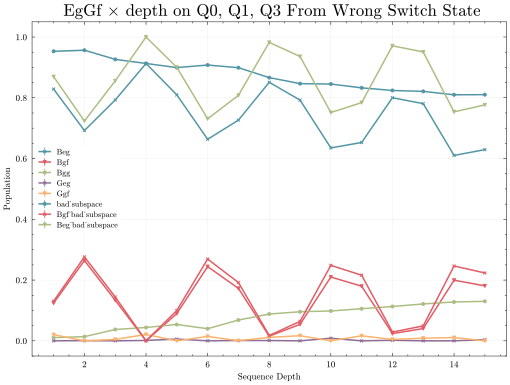

Saving S:\QRAM\qram_4QR2\data\data_250119\00030_leakage_EgGf_qubit31.h5
Starting 1 with len 0.06 gain 17833 freq 5122.5
Will save to S:\QRAM\qram_4QR2\data\data_250119\00031_leakage_EgGf_qubit31.h5
{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-390.00045219204236, 5795.770150727347, 502.42095511476606, -228.8557536534039], 'gain': [0.6, 0.8, 0.5, 0.3], 'readout_length': [4.5, 12, 8.0, 10], 'frequency_ef': [-390.0004521920423, 5795.770150727347, 500.48386902205084, -230.30732892], 'gain_ef': [0.5, 0.5, 0.6, 0.25], 'readout_length_ef': [4.5, 16, 8, 8], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4108.755047003828, 4103.366954082312, 4108.649372291309, 4108.232503550693, 3442.591941352887, 3447.981518133789, 3446.872635941306, 3446.65966586083, 4760.911839134516, 4759.946893523059, 4761.052602755913, 4760.46101643607, 4377.996318964773, 4377.247239665757, 4377.995764386313, 4378.454058265707], 'f_ef': [3882.6760964004225, 0.0, 3882.593

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 0


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.43000000000002 	 angle (deg): -72.04977773909458 	 threshold ge: 165.7398848739463
Qubit (1) ge
ge fidelity (%): 75.08918391839184 	 angle (deg): 78.32827631382419 	 threshold ge: 83.07813822670305
Qubit (3) ge
ge fidelity (%): 76.74950295029504 	 angle (deg): -111.8886970056007 	 threshold ge: 58.51342209900131
thresholds=[165.7398848739463, 83.07813822670305, 0, 58.51342209900131],
angles=[-72.04977773909458, 78.32827631382419, 0, -111.8886970056007],
ge_avgs=[array([ -9.82702974, 117.02630818,  31.37888625, 244.22097569]), array([ 42.66016283, -53.60241932,  51.78759908, -97.78694219]), array([0., 0., 0., 0.]), array([-21.7684444 ,  25.83913197, -39.80287643,  70.72677653])],
counts_calib=[[8146, 422, 714, 82, 541, 29, 54, 12], [1553, 6762, 151, 865, 70, 500, 12, 87], [901, 6770, 98, 1493, 54, 490, 10, 184], [1391, 62, 7511, 376, 173, 4, 460, 23], [296, 995, 1209, 6867, 32, 133, 68, 400], [247, 1201, 746, 7004, 18, 153, 61, 570], [882, 53, 85, 7, 781

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.34934193419343
Qubit (1) ge
ge fidelity (%): 70.05911791179118
Qubit (3) gf
gf fidelity (%): 51.109999999999964
thresholds_f=[138.25091314459684, 38.19097313789651, 0, -59.17432352203227],
angles_f=[-67.76233706701204, 39.058008599118864, 0, -121.02891311592545],
gf_avgs=[array([-20.36422779, 100.56030369,  21.95355463, 204.06232902]), array([ -2.99400049, -36.77790826,  24.64448785, -59.20548462]), array([0., 0., 0., 0.]), array([ 12.08843385, -81.49068975,  -1.7658227 , -58.45966855])],
counts_calib_f=[[7031, 1412, 736, 147, 502, 95, 61, 16], [6900, 1233, 1017, 192, 471, 68, 100, 19], [2263, 4484, 732, 1866, 171, 284, 69, 131], [1563, 305, 6249, 1223, 160, 26, 375, 99], [1085, 193, 6890, 1201, 112, 23, 427, 69], [463, 820, 2584, 5485, 61, 60, 172, 355], [750, 149, 78, 19, 6667, 1293, 880, 164], [819, 130, 122, 25, 6194, 1132, 1338, 240], [338, 563, 76, 187, 2135, 4278, 679, 1744], [275, 50, 594, 105, 1024, 212, 6468, 1272], [218, 41, 674, 106, 1011, 1

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 1


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.74938593859386 	 angle (deg): -74.32699432239238 	 threshold ge: 168.34916962019514
Qubit (1) ge
ge fidelity (%): 74.25000000000004 	 angle (deg): 77.50135871843801 	 threshold ge: 84.09650956876504
Qubit (3) ge
ge fidelity (%): 75.21 	 angle (deg): 5.42430569304818 	 threshold ge: 57.04778766541327
thresholds=[168.34916962019514, 84.09650956876504, 0, 57.04778766541327],
angles=[-74.32699432239238, 77.50135871843801, 0, 5.42430569304818],
ge_avgs=[array([-12.98595217, 116.43353792,  23.2583725 , 245.61042337]), array([ 42.44839748, -53.49787216,  52.00809775, -96.62373323]), array([0., 0., 0., 0.]), array([32.33132904,  6.16889717, 79.69368724,  1.67156403])],
counts_calib=[[8118, 480, 687, 93, 524, 27, 60, 11], [1594, 6724, 180, 885, 93, 444, 16, 64], [886, 7082, 105, 1279, 60, 477, 7, 104], [1499, 73, 7406, 423, 157, 12, 410, 20], [257, 1047, 1403, 6652, 33, 124, 82, 402], [225, 1246, 853, 6949, 22, 144, 47, 514], [868, 49, 77, 11, 7925, 437, 575, 58

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.75937893789379
Qubit (1) ge
ge fidelity (%): 70.83999999999996
Qubit (3) gf
gf fidelity (%): 51.566711671167134
thresholds_f=[135.20238368291427, 39.85461704013174, 0, -58.03438803889095],
angles_f=[-68.93665636636872, 37.45507225715268, 0, -112.7566091676753],
gf_avgs=[array([-24.29254776,  98.26375181,  16.52383944, 204.2437212 ]), array([ -3.59752696, -37.48805516,  25.22641795, -59.56955784]), array([0., 0., 0., 0.]), array([ -2.24723963, -81.82641424, -12.68416611, -56.94521786])],
counts_calib_f=[[7245, 1438, 551, 124, 467, 107, 59, 9], [7187, 1203, 825, 127, 462, 82, 96, 18], [2491, 5367, 434, 1004, 183, 339, 71, 111], [1656, 333, 6107, 1228, 157, 31, 402, 86], [1261, 220, 6752, 1095, 141, 32, 425, 74], [587, 960, 2631, 5137, 76, 68, 211, 330], [749, 155, 63, 16, 6867, 1363, 646, 141], [739, 128, 97, 12, 6567, 1081, 1167, 209], [373, 599, 71, 126, 2260, 4554, 533, 1484], [259, 49, 565, 119, 1296, 252, 6255, 1205], [198, 33, 592, 100, 1278, 196, 6

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 2


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.0094239423942 	 angle (deg): -75.6600622757756 	 threshold ge: 165.74355641513364
Qubit (1) ge
ge fidelity (%): 73.72935193519355 	 angle (deg): 78.14918378809688 	 threshold ge: 85.86245553176839
Qubit (3) ge
ge fidelity (%): 77.00939593959394 	 angle (deg): 78.46184460627445 	 threshold ge: 57.77315029724941
thresholds=[165.74355641513364, 85.86245553176839, 0, 57.77315029724941],
angles=[-75.6600622757756, 78.14918378809688, 0, 78.46184460627445],
ge_avgs=[array([-16.91739038, 116.05080355,  16.27355832, 245.88589812]), array([ 42.92977518, -53.71155499,  51.96837596, -96.78601188]), array([0., 0., 0., 0.]), array([ 15.26010404, -30.38211634,  24.95151549, -77.85508376])],
counts_calib=[[8219, 536, 561, 97, 510, 24, 48, 5], [1419, 7094, 142, 754, 80, 436, 13, 62], [880, 7260, 88, 1133, 54, 497, 5, 83], [1659, 99, 7171, 441, 159, 6, 430, 35], [352, 1726, 1170, 6075, 41, 180, 76, 380], [202, 1310, 791, 6933, 27, 167, 57, 513], [875, 56, 70, 12, 7980, 4

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.2493919391939
Qubit (1) ge
ge fidelity (%): 65.17920892089212
Qubit (3) gf
gf fidelity (%): 51.76677367736775
thresholds_f=[136.77648329127706, 39.710032383833564, 0, -58.70952728494255],
angles_f=[-70.92151257463388, 40.77636577639656, 0, -121.25827767942948],
gf_avgs=[array([-27.03678864,  98.02199906,   9.22409588, 202.86447894]), array([ -3.43906055, -37.09983298,  21.79412765, -58.86237951]), array([0., 0., 0., 0.]), array([ 11.48266379, -80.91890281,  -2.66035443, -57.61952059])],
counts_calib_f=[[7070, 1495, 666, 140, 479, 85, 52, 13], [6997, 1174, 1022, 182, 427, 76, 93, 29], [2414, 5312, 471, 1182, 160, 268, 74, 119], [2041, 393, 5857, 1095, 154, 30, 356, 74], [1193, 191, 6900, 1126, 115, 33, 379, 63], [596, 916, 2627, 5263, 67, 61, 173, 297], [794, 158, 83, 12, 6688, 1356, 748, 161], [768, 113, 116, 13, 6353, 1058, 1375, 204], [368, 567, 60, 150, 2236, 4518, 590, 1511], [259, 48, 573, 98, 1199, 197, 6428, 1198], [239, 34, 608, 102, 976, 162, 6

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 3


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.73999999999995 	 angle (deg): -77.762785887683 	 threshold ge: 165.15194747624588
Qubit (1) ge
ge fidelity (%): 73.7692289228923 	 angle (deg): 77.21414134378485 	 threshold ge: 84.11401126238933
Qubit (3) ge
ge fidelity (%): 76.82 	 angle (deg): 141.2908438051075 	 threshold ge: 56.86621284327664
thresholds=[165.15194747624588, 84.11401126238933, 0, 56.86621284327664],
angles=[-77.762785887683, 77.21414134378485, 0, 141.2908438051075],
ge_avgs=[array([-19.6268856 , 115.56415203,   8.70553922, 246.19597388]), array([ 42.00157287, -53.36003814,  51.80646555, -96.56579105]), array([0., 0., 0., 0.]), array([-20.47698434, -27.15477533, -58.3644347 , -57.51828877])],
counts_calib=[[8053, 551, 655, 110, 519, 42, 57, 13], [1391, 6933, 143, 894, 95, 449, 9, 86], [786, 6906, 91, 1515, 63, 496, 5, 138], [1495, 116, 7218, 530, 175, 9, 431, 26], [285, 1331, 1098, 6643, 29, 131, 70, 413], [173, 1096, 753, 7332, 29, 145, 47, 425], [865, 58, 67, 7, 7784, 544, 616, 59]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.75999999999999
Qubit (1) ge
ge fidelity (%): 74.02000000000001
Qubit (3) gf
gf fidelity (%): 54.627103710371074
thresholds_f=[135.08624326550066, 39.233046247200754, 0, -59.55207155915895],
angles_f=[-73.13756288799233, 37.157009721125945, 0, -139.66240538010817],
gf_avgs=[array([-29.16188784,  97.71851534,   2.72796729, 202.92831867]), array([ -3.49637766, -38.07785963,  26.58644393, -60.87640787]), array([0., 0., 0., 0.]), array([ 36.29369243, -73.84356497,  14.04215081, -54.94777034])],
counts_calib_f=[[7067, 1526, 585, 140, 514, 100, 58, 10], [7016, 1377, 827, 145, 454, 79, 85, 17], [2189, 5700, 419, 1086, 148, 304, 45, 109], [1301, 328, 6317, 1362, 171, 25, 401, 95], [1308, 286, 6463, 1274, 145, 34, 422, 68], [509, 924, 2397, 5456, 83, 74, 177, 380], [860, 200, 73, 14, 6561, 1475, 667, 150], [772, 147, 121, 21, 6391, 1143, 1189, 216], [357, 615, 60, 133, 2095, 4594, 533, 1613], [215, 55, 695, 154, 1164, 302, 6133, 1282], [243, 47, 688, 136, 1075, 1

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 4


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.73904590459045 	 angle (deg): -79.35340401829635 	 threshold ge: 162.30452795466144
Qubit (1) ge
ge fidelity (%): 72.27 	 angle (deg): 77.89173859817687 	 threshold ge: 83.49223792769838
Qubit (3) ge
ge fidelity (%): 77.02944494449446 	 angle (deg): -146.83166552965793 	 threshold ge: 57.92468296081667
thresholds=[162.30452795466144, 83.49223792769838, 0, 57.92468296081667],
angles=[-79.35340401829635, 77.89173859817687, 0, -146.83166552965793],
ge_avgs=[array([-23.01504674, 115.61816056,   1.33748379, 245.16200854]), array([ 42.02203359, -54.30884395,  51.07322575, -96.49920179]), array([0., 0., 0., 0.]), array([-32.14111663,  10.16410127, -73.02294909,  36.88416527])],
counts_calib=[[7983, 429, 781, 116, 571, 30, 74, 16], [1423, 6812, 185, 946, 88, 466, 13, 67], [880, 6966, 120, 1418, 55, 450, 8, 103], [1540, 92, 7311, 410, 155, 8, 457, 27], [258, 1323, 1154, 6608, 23, 133, 78, 423], [182, 1128, 778, 7222, 16, 138, 47, 489], [817, 51, 71, 8, 7903, 475

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.95
Qubit (1) ge
ge fidelity (%): 73.58923992399238
Qubit (3) gf
gf fidelity (%): 52.45000000000002
thresholds_f=[133.06081833532497, 40.0287706168344, 0, -58.66546839634579],
angles_f=[-74.65124355817548, 38.48778633392993, 0, -58.06662517103706],
gf_avgs=[array([-32.28798126,  95.78402496,  -2.76930695, 203.32648567]), array([ -3.10594553, -37.22665282,  26.35364875, -60.64962069]), array([0., 0., 0., 0.]), array([-66.57412677, -47.18541953, -52.18399772, -24.09669972])],
counts_calib_f=[[7133, 1411, 624, 127, 525, 106, 66, 8], [7056, 1188, 882, 167, 506, 84, 97, 20], [2404, 5295, 477, 1101, 180, 355, 58, 130], [1360, 265, 6454, 1234, 158, 36, 414, 79], [1041, 198, 6912, 1186, 120, 24, 447, 72], [485, 978, 2623, 5183, 83, 62, 215, 371], [754, 173, 73, 13, 6836, 1311, 694, 146], [729, 120, 97, 14, 6617, 1024, 1195, 204], [329, 584, 66, 110, 2273, 4541, 582, 1515], [196, 47, 594, 124, 1273, 214, 6369, 1183], [216, 42, 609, 95, 1107, 170, 6704, 1057], [78

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 5


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.23936393639366 	 angle (deg): -81.8588684424782 	 threshold ge: 166.02178405271871
Qubit (1) ge
ge fidelity (%): 74.99924192419245 	 angle (deg): 78.30662711908569 	 threshold ge: 84.97533674363558
Qubit (3) ge
ge fidelity (%): 77.45999999999998 	 angle (deg): 12.957244322295995 	 threshold ge: 55.28627771967456
thresholds=[166.02178405271871, 84.97533674363558, 0, 55.28627771967456],
angles=[-81.8588684424782, 78.30662711908569, 0, 12.957244322295995],
ge_avgs=[array([-26.21377308, 115.40015999,  -7.06570304, 249.25260203]), array([ 42.5353815 , -54.51523133,  51.5090611 , -97.87274531]), array([0., 0., 0., 0.]), array([ 32.61543971,  -1.19017438,  79.52856706, -11.98405579])],
counts_calib=[[8039, 563, 647, 98, 542, 43, 58, 10], [1376, 7260, 111, 700, 72, 407, 11, 63], [844, 6916, 83, 1478, 67, 460, 7, 145], [1428, 98, 7362, 523, 151, 20, 390, 28], [240, 1394, 1154, 6566, 28, 150, 74, 394], [177, 1261, 873, 7119, 15, 108, 41, 406], [809, 54, 59, 9, 78

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.83940794079408
Qubit (1) ge
ge fidelity (%): 72.33936493649364
Qubit (3) gf
gf fidelity (%): 52.06653265326533
thresholds_f=[138.36885011025055, 40.8162244857799, 0, -56.33800225391087],
angles_f=[-76.71826072570452, 38.09994960711647, 0, 171.90792076548368],
gf_avgs=[array([-35.05759414,  94.72836751,  -9.31906071, 203.76523683]), array([ -3.6002139 , -37.87477318,  25.87765215, -60.98833074]), array([0., 0., 0., 0.]), array([ 77.9374917 , -21.00410797,  51.37832392, -24.78029138])],
counts_calib_f=[[7489, 1272, 537, 92, 460, 85, 58, 7], [7446, 1012, 810, 109, 467, 56, 90, 10], [2696, 5404, 428, 886, 176, 271, 50, 89], [1635, 267, 6343, 1131, 146, 26, 391, 61], [1393, 209, 6760, 987, 139, 21, 430, 61], [621, 1084, 2809, 4835, 79, 70, 171, 331], [881, 158, 64, 9, 6989, 1181, 627, 91], [801, 133, 87, 11, 6724, 933, 1142, 169], [405, 563, 63, 79, 2484, 4463, 600, 1343], [269, 56, 592, 105, 1327, 204, 6353, 1094], [240, 30, 583, 85, 1226, 192, 6671, 973], 

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 6


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.88999999999997 	 angle (deg): -82.87315929144886 	 threshold ge: 160.03870339184914
Qubit (1) ge
ge fidelity (%): 76.78999999999998 	 angle (deg): 78.15844772514998 	 threshold ge: 83.20662718166254
Qubit (3) ge
ge fidelity (%): 78.02951395139515 	 angle (deg): 66.99222666001296 	 threshold ge: 57.21530305057497
thresholds=[160.03870339184914, 83.20662718166254, 0, 57.21530305057497],
angles=[-82.87315929144886, 78.15844772514998, 0, 66.99222666001296],
ge_avgs=[array([-30.08756382, 113.93518444, -13.68694103, 245.10623155]), array([ 42.07104807, -53.75092436,  51.59709015, -99.18488554]), array([0., 0., 0., 0.]), array([ 21.87646302, -25.3154709 ,  40.98903418, -70.32488799])],
counts_calib=[[8061, 415, 749, 86, 578, 27, 71, 13], [1362, 6754, 187, 1060, 104, 457, 13, 63], [881, 6705, 103, 1593, 63, 506, 7, 142], [1192, 72, 7634, 470, 153, 6, 442, 31], [305, 1608, 1253, 6166, 29, 143, 83, 413], [189, 1154, 835, 7141, 16, 124, 55, 486], [802, 57, 69, 7, 

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.23901390139012
Qubit (1) ge
ge fidelity (%): 75.63927792779278
Qubit (3) gf
gf fidelity (%): 54.09685568556854
thresholds_f=[136.24397783987888, 39.7663125858334, 0, -59.883356260212736],
angles_f=[-78.48844531259041, 38.14893672121939, 0, -26.680426084826607],
gf_avgs=[array([-37.69470456,  94.06207359, -14.89687041, 206.00145355]), array([ -3.48501599, -37.10858193,  26.94727243, -61.01254515]), array([0., 0., 0., 0.]), array([-82.1946133 ,  -8.53184841, -56.52945065,   4.36539963])],
counts_calib_f=[[7345, 1338, 585, 120, 452, 92, 54, 14], [7181, 1263, 790, 135, 432, 92, 93, 14], [2402, 5536, 425, 1009, 163, 323, 46, 96], [1246, 234, 6620, 1263, 158, 29, 380, 70], [1614, 266, 6384, 1084, 133, 29, 412, 78], [498, 988, 2679, 5201, 62, 73, 152, 347], [775, 130, 64, 8, 6894, 1271, 718, 140], [781, 126, 91, 18, 6443, 1095, 1274, 172], [363, 534, 56, 103, 2280, 4524, 625, 1515], [239, 47, 532, 104, 1237, 240, 6440, 1161], [204, 29, 605, 85, 1127, 193, 6699

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 7


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.34935293529352 	 angle (deg): -85.1158375928702 	 threshold ge: 160.27438945090012
Qubit (1) ge
ge fidelity (%): 74.12999999999998 	 angle (deg): 77.82955882261096 	 threshold ge: 83.52713718794944
Qubit (3) ge
ge fidelity (%): 76.62 	 angle (deg): 0.6677878821043692 	 threshold ge: 56.828873864525015
thresholds=[160.27438945090012, 83.52713718794944, 0, 56.828873864525015],
angles=[-85.1158375928702, 77.82955882261096, 0, 0.6677878821043692],
ge_avgs=[array([-33.52360203, 111.92285369, -22.25369559, 243.80897685]), array([ 42.00628565, -54.40057963,  51.27871091, -97.39461782]), array([0., 0., 0., 0.]), array([31.46449655,  7.41898555, 79.95984137,  6.85374199])],
counts_calib=[[7976, 439, 797, 122, 550, 33, 69, 14], [1457, 6683, 188, 1005, 83, 482, 14, 88], [861, 7044, 99, 1309, 47, 487, 18, 135], [1349, 75, 7490, 424, 175, 5, 457, 25], [320, 1321, 1188, 6525, 31, 135, 71, 409], [142, 1131, 830, 7149, 24, 142, 66, 516], [858, 50, 80, 15, 7755, 460, 73

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.31999999999996
Qubit (1) ge
ge fidelity (%): 75.42999999999996
Qubit (3) gf
gf fidelity (%): 52.57000000000003
thresholds_f=[134.95809947816778, 40.79415571754056, 0, -56.459759778097734],
angles_f=[-80.15767757769105, 40.64391655827968, 0, 43.439367365796215],
gf_avgs=[array([-40.54070716,  93.09611592, -21.52534624, 202.70055355]), array([ -2.86998804, -36.33603263,  26.66492281, -61.68980745]), array([0., 0., 0., 0.]), array([-32.09353861,  74.92615749, -11.60376562,  55.52325704])],
counts_calib_f=[[7288, 1304, 641, 110, 499, 92, 59, 7], [7262, 1040, 852, 137, 557, 66, 73, 13], [2594, 5389, 401, 867, 213, 389, 53, 94], [1254, 186, 6780, 1072, 174, 32, 435, 67], [1382, 202, 6750, 952, 161, 33, 458, 62], [512, 919, 2753, 5057, 96, 73, 204, 386], [896, 145, 63, 13, 6885, 1185, 691, 122], [804, 157, 103, 23, 6520, 1038, 1180, 175], [408, 635, 57, 94, 2349, 4536, 535, 1386], [213, 42, 633, 100, 1335, 238, 6411, 1028], [199, 29, 667, 107, 1068, 160, 6744,

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 8


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.66936793679369 	 angle (deg): -86.79911374784521 	 threshold ge: 160.888272313688
Qubit (1) ge
ge fidelity (%): 74.58907990799082 	 angle (deg): 78.34878180070389 	 threshold ge: 81.76293373722717
Qubit (3) ge
ge fidelity (%): 76.46940694069409 	 angle (deg): -21.849256221347545 	 threshold ge: 55.46447587972671
thresholds=[160.888272313688, 81.76293373722717, 0, 55.46447587972671],
angles=[-86.79911374784521, 78.34878180070389, 0, -21.849256221347545],
ge_avgs=[array([-36.3931788 , 110.2677974 , -28.96208292, 243.14580695]), array([ 42.0147933 , -53.16440467,  51.26163269, -98.00793988]), array([0., 0., 0., 0.]), array([24.97926273, 20.42171722, 69.72196185, 38.36215345])],
counts_calib=[[7967, 468, 805, 110, 525, 42, 66, 17], [1429, 6677, 188, 1076, 86, 434, 16, 94], [834, 6996, 100, 1391, 52, 477, 8, 142], [1308, 84, 7345, 559, 157, 16, 491, 40], [233, 1239, 1149, 6702, 37, 145, 73, 422], [168, 1224, 776, 7099, 24, 144, 61, 504], [838, 56, 92, 6, 767

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.47934193419344
Qubit (1) ge
ge fidelity (%): 70.34771277127716
Qubit (3) gf
gf fidelity (%): 49.45
thresholds_f=[133.54428295457015, 40.36966956612507, 0, -58.93175758813494],
angles_f=[-81.87997949408037, 38.413644024404505, 0, -66.7763233516966],
gf_avgs=[array([-43.24590362,  90.13643292, -27.20852844, 202.53933119]), array([ -3.90879766, -37.78115353,  24.56272425, -60.35844503]), array([0., 0., 0., 0.]), array([-59.84268251, -54.66103149, -49.87908824, -31.44072954])],
counts_calib_f=[[6982, 1660, 544, 131, 500, 113, 61, 9], [7012, 1382, 772, 150, 461, 110, 97, 16], [2465, 5439, 452, 904, 198, 352, 58, 132], [1660, 366, 6018, 1263, 159, 43, 400, 91], [1210, 257, 6511, 1250, 173, 40, 454, 105], [540, 957, 2474, 5280, 77, 97, 177, 398], [734, 161, 62, 17, 6750, 1482, 654, 140], [783, 158, 83, 18, 6313, 1257, 1168, 220], [351, 557, 64, 103, 2184, 4662, 561, 1518], [234, 59, 546, 116, 1285, 257, 6225, 1278], [198, 39, 572, 117, 1232, 221, 6424, 1197], 

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 9


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.34999999999998 	 angle (deg): -88.62050106353486 	 threshold ge: 169.02410511835402
Qubit (1) ge
ge fidelity (%): 77.46 	 angle (deg): 78.25776475029737 	 threshold ge: 86.1205299098387
Qubit (3) ge
ge fidelity (%): 75.51000000000003 	 angle (deg): -37.059979042235696 	 threshold ge: 54.021293916158285
thresholds=[169.02410511835402, 86.1205299098387, 0, 54.021293916158285],
angles=[-88.62050106353486, 78.25776475029737, 0, -37.059979042235696],
ge_avgs=[array([-39.31795239, 109.72534631, -36.1080034 , 243.02083849]), array([ 42.02751335, -53.25125988,  51.70094916, -99.78972854]), array([0., 0., 0., 0.]), array([20.34601914, 25.58415485, 57.89722487, 53.94269831])],
counts_calib=[[8133, 652, 550, 83, 500, 37, 36, 9], [1472, 7059, 122, 728, 76, 483, 6, 54], [829, 7378, 73, 1083, 55, 476, 4, 102], [1286, 116, 7372, 613, 163, 13, 409, 28], [214, 1248, 1107, 6820, 23, 162, 45, 381], [178, 1349, 752, 7217, 17, 125, 25, 337], [860, 60, 59, 7, 7853, 615, 493,

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.09999999999998
Qubit (1) ge
ge fidelity (%): 73.96914391439145
Qubit (3) gf
gf fidelity (%): 52.160000000000004
thresholds_f=[138.90858875236194, 41.029991952197264, 0, -55.73206348690526],
angles_f=[-83.64905741772724, 40.66344921495956, 0, -176.1580778274187],
gf_avgs=[array([-46.38017663,  91.13587728, -33.99411049, 202.42021838]), array([ -2.01267162, -36.73154688,  26.93136216, -61.59523626]), array([0., 0., 0., 0.]), array([ 72.72600647, -36.98556155,  45.33247596, -35.14595256])],
counts_calib_f=[[7435, 1056, 709, 107, 488, 89, 102, 14], [7171, 1000, 978, 124, 518, 80, 119, 10], [2660, 4992, 526, 970, 205, 347, 129, 171], [1297, 208, 6807, 984, 164, 25, 441, 74], [1548, 192, 6690, 831, 177, 14, 489, 59], [530, 711, 3156, 4837, 79, 74, 263, 350], [869, 130, 89, 10, 7035, 1093, 676, 98], [810, 97, 114, 18, 6745, 861, 1166, 189], [368, 571, 56, 103, 2425, 4479, 584, 1414], [258, 28, 669, 105, 1411, 192, 6405, 932], [266, 39, 689, 84, 1210, 161, 6669

  0%|          | 0/15 [00:00<?, ?it/s]

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Beg 0.5903932404919404
Bgf 0.2148466593663426
Bge 0.022629007465893036
Bgg 0.11521116461818008
Geg -7.61036652345413e-17
Ggf 0.017936879048964342
Ggg 6.835285578942898e-18
ggg 0.11521116461818008
gge 0.022629007465893036
ggf 0.2148466593663426
geg 0.5903932404919404
gee 0.03357304307667832
gef 0.005410005932001377
egg 6.835285578942898e-18
ege -3.697802842204143e-18
egf 0.017936879048964342
eeg -7.61036652345413e-17
eee 2.386645515380243e-17
eef 2.0405736751487954e-17
bad_subspace 0.805239899858283
good_subspace 0.017936879048964266
Bgf_bad_subspace 0.26681074721229564
Beg_bad_subspace 0.7331892527877043
Ggf_good_subspace 1.0000000000000042
Geg_good_subspace -4.242859921550052e-15


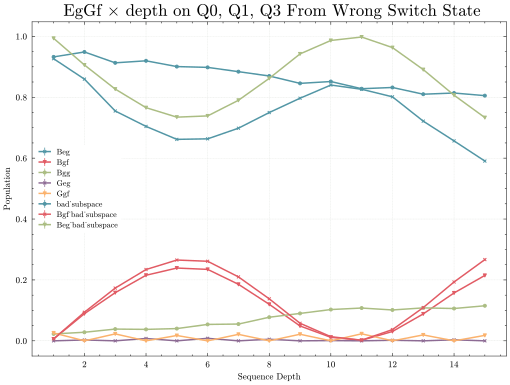

Saving S:\QRAM\qram_4QR2\data\data_250119\00031_leakage_EgGf_qubit31.h5
Starting 2 with len 0.067 gain 15750 freq 5126.9
Will save to S:\QRAM\qram_4QR2\data\data_250119\00032_leakage_EgGf_qubit31.h5
{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-390.00045219204236, 5795.770150727347, 502.42095511476606, -228.8557536534039], 'gain': [0.6, 0.8, 0.5, 0.3], 'readout_length': [4.5, 12, 8.0, 10], 'frequency_ef': [-390.0004521920423, 5795.770150727347, 500.48386902205084, -230.30732892], 'gain_ef': [0.5, 0.5, 0.6, 0.25], 'readout_length_ef': [4.5, 16, 8, 8], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4108.755047003828, 4103.366954082312, 4108.649372291309, 4108.232503550693, 3442.591941352887, 3447.981518133789, 3446.872635941306, 3446.65966586083, 4760.911839134516, 4759.946893523059, 4761.052602755913, 4760.46101643607, 4377.996318964773, 4377.247239665757, 4377.995764386313, 4378.454058265707], 'f_ef': [3882.6760964004225, 0.0, 3882.59

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 0


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.06937993799382 	 angle (deg): -89.94092684853551 	 threshold ge: 170.7812374718232
Qubit (1) ge
ge fidelity (%): 75.85919291929194 	 angle (deg): 79.0533007319411 	 threshold ge: 84.4061403004548
Qubit (3) ge
ge fidelity (%): 77.14000000000001 	 angle (deg): -149.1714589707158 	 threshold ge: 57.46626859571445
thresholds=[170.7812374718232, 84.4061403004548, 0, 57.46626859571445],
angles=[-89.94092684853551, 79.0533007319411, 0, -149.1714589707158],
ge_avgs=[array([-42.89894689, 111.60364291, -42.76253126, 243.91480065]), array([ 42.95491066, -54.4381659 ,  51.6238736 , -99.25868245]), array([0., 0., 0., 0.]), array([-33.09625879,   8.28255928, -74.85535247,  33.20417728])],
counts_calib=[[8088, 501, 683, 93, 515, 28, 77, 15], [1425, 6827, 132, 937, 92, 488, 16, 83], [859, 6894, 99, 1175, 62, 588, 23, 300], [1297, 72, 7464, 542, 169, 11, 415, 30], [212, 1104, 1241, 6798, 24, 147, 81, 393], [174, 1244, 887, 6976, 25, 148, 51, 495], [845, 44, 69, 5, 7893,

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.70999999999998
Qubit (1) ge
ge fidelity (%): 75.44000000000001
Qubit (3) gf
gf fidelity (%): 50.19
thresholds_f=[135.6024380845537, 42.913057849304344, 0, -58.19368666408782],
angles_f=[-84.89474682552226, 38.64914051565765, 0, -148.40377962427112],
gf_avgs=[array([-49.77222779,  91.059833  , -39.92357562, 201.29766505]), array([ -2.61591259, -37.72176356,  27.61550698, -61.89766952]), array([0., 0., 0., 0.]), array([ 48.02619512, -66.22712587,  25.66965468, -52.47532331])],
counts_calib_f=[[7283, 1344, 540, 94, 536, 116, 75, 12], [7326, 1154, 741, 110, 481, 69, 103, 16], [2455, 4829, 656, 1213, 195, 377, 120, 155], [1306, 229, 6697, 1107, 158, 43, 393, 67], [1430, 244, 6655, 1009, 142, 17, 432, 71], [624, 1051, 2711, 4891, 80, 81, 217, 345], [782, 138, 63, 7, 7054, 1333, 517, 106], [793, 132, 86, 10, 6783, 1073, 993, 130], [362, 536, 60, 123, 2387, 4840, 492, 1200], [268, 33, 608, 122, 1487, 303, 6087, 1092], [267, 53, 533, 96, 1422, 192, 6514, 923], [

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 1


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.26933993399335 	 angle (deg): -91.61487212642888 	 threshold ge: 164.75742468241475
Qubit (1) ge
ge fidelity (%): 75.08000000000001 	 angle (deg): 79.1362007734924 	 threshold ge: 84.14839441390254
Qubit (3) ge
ge fidelity (%): 78.56 	 angle (deg): -129.1714055518554 	 threshold ge: 59.832572147333394
thresholds=[164.75742468241475, 84.14839441390254, 0, 59.832572147333394],
angles=[-91.61487212642888, 79.1362007734924, 0, -129.1714055518554],
ge_avgs=[array([-46.80977931, 109.12669884, -50.43772916, 237.81253517]), array([ 43.24355494, -54.03710111,  51.67702108, -97.98097857]), array([0., 0., 0., 0.]), array([-27.52482129,  19.30730534, -58.99591156,  57.93401693])],
counts_calib=[[8165, 393, 698, 70, 564, 26, 74, 10], [1411, 6896, 140, 896, 87, 495, 11, 64], [911, 6637, 104, 1167, 73, 672, 50, 386], [1388, 64, 7554, 353, 196, 7, 418, 20], [264, 1160, 1354, 6492, 42, 157, 86, 445], [230, 1370, 909, 6622, 26, 172, 64, 607], [881, 34, 80, 5, 8018, 334, 

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.78
Qubit (1) ge
ge fidelity (%): 74.36000000000001
Qubit (3) gf
gf fidelity (%): 50.95683468346832
thresholds_f=[138.32190428876245, 41.1324354888057, 0, -60.53210571881637],
angles_f=[-86.26190559081661, 40.891385960691316, 0, 15.47830334094028],
gf_avgs=[array([-52.72378285,  86.79346563, -45.32818119, 199.98894168]), array([ -1.86791843, -35.9699763 ,  26.98278696, -60.95365009]), array([0., 0., 0., 0.]), array([-65.07032046,  49.68047331, -39.28265891,  42.53943698])],
counts_calib_f=[[6990, 1629, 645, 129, 416, 99, 77, 15], [6870, 1368, 969, 207, 382, 67, 110, 27], [2382, 5391, 460, 1096, 136, 318, 80, 137], [1259, 269, 6383, 1464, 152, 32, 350, 91], [1113, 249, 6764, 1280, 125, 26, 377, 66], [462, 937, 2582, 5367, 67, 54, 199, 332], [765, 179, 55, 20, 6719, 1485, 636, 141], [744, 161, 85, 20, 6259, 1291, 1204, 236], [325, 468, 103, 211, 2160, 4746, 535, 1452], [208, 54, 593, 171, 1163, 303, 6058, 1450], [171, 48, 637, 137, 1126, 208, 6432, 1241], 

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 2


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.09 	 angle (deg): -92.93559291567891 	 threshold ge: 164.08353570103154
Qubit (1) ge
ge fidelity (%): 74.95000000000003 	 angle (deg): 79.64806347331012 	 threshold ge: 83.89012163227432
Qubit (3) ge
ge fidelity (%): 77.08945494549455 	 angle (deg): 119.28343617112907 	 threshold ge: 58.52716297774211
thresholds=[164.08353570103154, 83.89012163227432, 0, 58.52716297774211],
angles=[-92.93559291567891, 79.64806347331012, 0, 119.28343617112907],
ge_avgs=[array([-49.60821411, 106.60506483, -56.44229855, 239.87337366]), array([ 43.30574737, -54.4986283 ,  51.34147048, -98.48964748]), array([0., 0., 0., 0.]), array([ -9.24631934, -33.03140576, -33.03828945, -75.45693184])],
counts_calib=[[8091, 476, 715, 90, 514, 18, 87, 9], [1452, 6858, 159, 867, 85, 473, 18, 88], [873, 6856, 93, 1228, 68, 512, 35, 335], [1369, 74, 7425, 482, 167, 5, 451, 27], [336, 1167, 1358, 6476, 36, 133, 78, 416], [185, 1375, 812, 6685, 29, 173, 74, 667], [845, 46, 74, 5, 7984, 396, 59

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.91
Qubit (1) ge
ge fidelity (%): 74.26925692569255
Qubit (3) gf
gf fidelity (%): 49.75635463546354
thresholds_f=[133.12814484646233, 42.93891188519001, 0, -55.7226628438262],
angles_f=[-88.8652487496981, 40.20935349242759, 0, -46.066369749354855],
gf_avgs=[array([-52.99935456,  84.31713003, -50.74308329, 198.22572323]), array([ -2.24909349, -37.15062222,  27.30625023, -62.13509577]), array([0., 0., 0., 0.]), array([-75.62650553, -29.5086688 , -57.40100545, -10.59180777])],
counts_calib_f=[[7244, 1307, 627, 107, 558, 95, 50, 12], [7394, 1007, 719, 124, 609, 51, 83, 13], [2705, 5052, 520, 968, 199, 370, 84, 102], [1355, 211, 6643, 1026, 189, 22, 482, 72], [1951, 258, 6137, 856, 203, 22, 507, 66], [607, 830, 3005, 4725, 84, 82, 268, 399], [793, 149, 55, 5, 7224, 1163, 545, 66], [769, 91, 68, 10, 7014, 929, 978, 141], [387, 552, 62, 67, 2492, 4802, 486, 1152], [214, 30, 605, 116, 1492, 235, 6281, 1027], [230, 28, 595, 84, 1219, 164, 6798, 882], [103, 186, 2

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 3


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.10940694069407 	 angle (deg): -94.93041086474399 	 threshold ge: 169.0265175729496
Qubit (1) ge
ge fidelity (%): 73.12999999999997 	 angle (deg): 79.58666661372595 	 threshold ge: 83.54242863363072
Qubit (3) ge
ge fidelity (%): 76.96999999999998 	 angle (deg): 94.39431478549241 	 threshold ge: 55.93656462196539
thresholds=[169.0265175729496, 83.54242863363072, 0, 55.93656462196539],
angles=[-94.93041086474399, 79.58666661372595, 0, 94.39431478549241],
ge_avgs=[array([-52.30626592, 104.73782229, -63.8635665 , 238.71230832]), array([ 42.79076867, -53.55875231,  50.57517667, -95.9171363 ]), array([0., 0., 0., 0.]), array([  7.5196363 , -33.32636898,   3.73730241, -82.54603141])],
counts_calib=[[8052, 616, 627, 100, 494, 39, 61, 11], [1340, 7000, 141, 908, 62, 463, 13, 73], [813, 6663, 91, 1297, 41, 577, 41, 477], [1564, 110, 7075, 538, 199, 17, 469, 28], [232, 1130, 1238, 6784, 32, 149, 81, 354], [142, 1131, 794, 7196, 23, 156, 42, 516], [853, 67, 63, 10, 

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.58999999999999
Qubit (1) ge
ge fidelity (%): 73.06999999999998
Qubit (3) gf
gf fidelity (%): 50.42999999999998
thresholds_f=[137.68060139580737, 43.49946782678272, 0, -58.912065955804565],
angles_f=[-91.14752469943863, 41.764535705928424, 0, 19.310750475582843],
gf_avgs=[array([-56.79575644,  84.45659776, -59.06458683, 197.72389747]), array([ -1.88838122, -36.02151685,  26.45089888, -61.32821121]), array([0., 0., 0., 0.]), array([-61.36052063,  53.99761436, -36.47524483,  45.2776725 ])],
counts_calib_f=[[7269, 1384, 574, 108, 512, 96, 45, 12], [7178, 1270, 756, 161, 464, 72, 91, 8], [2383, 4714, 645, 1383, 195, 357, 148, 175], [1492, 279, 6290, 1229, 152, 32, 435, 91], [1617, 268, 6322, 1100, 114, 18, 473, 88], [677, 1183, 2353, 5016, 80, 88, 207, 396], [737, 143, 82, 20, 6708, 1221, 893, 196], [703, 126, 99, 13, 6485, 1072, 1297, 205], [357, 632, 58, 103, 2203, 4860, 629, 1158], [260, 55, 601, 127, 1329, 274, 6122, 1232], [229, 36, 566, 114, 1232, 196,

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 4


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.36000000000001 	 angle (deg): -96.3769430562882 	 threshold ge: 168.85783429123
Qubit (1) ge
ge fidelity (%): 71.08885488548853 	 angle (deg): 78.98366285871585 	 threshold ge: 81.49389080539662
Qubit (3) ge
ge fidelity (%): 77.20000000000003 	 angle (deg): 42.5991564696175 	 threshold ge: 57.493913638038215
thresholds=[168.85783429123, 81.49389080539662, 0, 57.493913638038215],
angles=[-96.3769430562882, 78.98366285871585, 0, 42.5991564696175],
ge_avgs=[array([-55.06980029, 104.52623314, -69.81504479, 236.46232395]), array([ 43.33594512, -54.58938855,  51.42312558, -96.13108174]), array([0., 0., 0., 0.]), array([ 30.11297253, -16.00916077,  65.20298242, -48.27512552])],
counts_calib=[[7739, 478, 1006, 124, 536, 32, 66, 19], [1380, 6922, 164, 957, 63, 419, 25, 70], [865, 6647, 122, 1700, 51, 461, 13, 141], [1468, 75, 7438, 445, 162, 2, 385, 25], [206, 916, 1216, 7045, 26, 124, 79, 388], [180, 1034, 855, 7290, 16, 106, 43, 476], [797, 35, 72, 9, 7866, 41

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.02931093109314
Qubit (1) ge
ge fidelity (%): 77.09930593059309
Qubit (3) gf
gf fidelity (%): 50.86999999999999
thresholds_f=[132.81113201636495, 41.079955333826476, 0, -57.10231460421208],
angles_f=[-91.7859549153472, 40.66839631756779, 0, -55.9508850243063],
gf_avgs=[array([-58.47322627,  81.71206064, -62.01294906, 195.23423618]), array([ -2.71541801, -35.98490354,  27.68394861, -62.10332427]), array([0., 0., 0., 0.]), array([-70.00743279, -42.29529992, -55.03485431, -20.13853279])],
counts_calib_f=[[7239, 1344, 591, 118, 556, 90, 53, 9], [7199, 1134, 828, 108, 533, 96, 89, 13], [2682, 5307, 426, 898, 201, 341, 44, 101], [1149, 212, 6724, 1208, 162, 27, 431, 87], [1272, 198, 6805, 1012, 168, 30, 450, 65], [652, 956, 2578, 5080, 80, 86, 188, 380], [775, 142, 65, 10, 6974, 1179, 720, 135], [734, 110, 84, 16, 6572, 992, 1275, 217], [382, 606, 40, 77, 2344, 4584, 564, 1403], [232, 52, 549, 105, 1230, 225, 6407, 1200], [249, 54, 612, 122, 1193, 180, 6567, 1

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 5


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.70939493949396 	 angle (deg): -97.89677789659784 	 threshold ge: 170.50732523670837
Qubit (1) ge
ge fidelity (%): 73.25894589458947 	 angle (deg): 78.84850827096729 	 threshold ge: 83.15617707453754
Qubit (3) ge
ge fidelity (%): 76.36000000000001 	 angle (deg): 11.252375281937027 	 threshold ge: 57.653977158549
thresholds=[170.50732523670837, 83.15617707453754, 0, 57.653977158549],
angles=[-97.89677789659784, 78.84850827096729, 0, 11.252375281937027],
ge_avgs=[array([-58.54826035, 102.52705564, -76.64110333, 232.96903032]), array([ 42.90567141, -55.00778801,  51.38271495, -98.01103611]), array([0., 0., 0., 0.]), array([33.4249332 ,  2.38808275, 80.35738366, -6.94938473])],
counts_calib=[[7873, 464, 923, 122, 516, 37, 55, 10], [1456, 6666, 191, 1057, 84, 464, 8, 74], [868, 7009, 112, 1377, 55, 461, 9, 109], [1292, 76, 7531, 489, 191, 13, 390, 18], [249, 1088, 1340, 6703, 28, 128, 69, 395], [163, 1062, 864, 7280, 23, 119, 44, 445], [863, 51, 90, 10, 7761,

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.82000000000002
Qubit (1) ge
ge fidelity (%): 73.99000000000002
Qubit (3) gf
gf fidelity (%): 52.79670867086706
thresholds_f=[138.2254742346339, 41.26630762174733, 0, -56.88849979619182],
angles_f=[-93.71328612088477, 39.95750884469461, 0, 146.78322066233264],
gf_avgs=[array([-61.39331194,  80.80742453, -68.69189891, 193.26646295]), array([ -2.76762848, -36.47876297,  26.37083066, -60.89203188]), array([0., 0., 0., 0.]), array([80.4566225 , 12.62244882, 57.03383792, -2.7147906 ])],
counts_calib_f=[[7332, 1341, 568, 113, 488, 95, 52, 11], [7160, 1201, 837, 150, 485, 85, 69, 13], [2582, 5490, 365, 915, 186, 341, 49, 72], [1411, 290, 6418, 1265, 147, 27, 381, 61], [1306, 216, 6824, 1065, 119, 24, 398, 48], [599, 996, 2632, 5065, 93, 89, 182, 344], [857, 142, 63, 12, 6860, 1258, 679, 129], [783, 147, 71, 22, 6522, 1043, 1228, 184], [349, 631, 64, 98, 2166, 4709, 576, 1407], [211, 41, 645, 133, 1225, 219, 6366, 1160], [229, 35, 654, 108, 1133, 178, 6653, 1010

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 6


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.01936893689368 	 angle (deg): -99.88808768320239 	 threshold ge: 166.24520952841186
Qubit (1) ge
ge fidelity (%): 72.67999999999999 	 angle (deg): 79.31055027601244 	 threshold ge: 83.70213080067344
Qubit (3) ge
ge fidelity (%): 75.94000000000001 	 angle (deg): -126.04819796130768 	 threshold ge: 54.471895164784065
thresholds=[166.24520952841186, 83.70213080067344, 0, 54.471895164784065],
angles=[-99.88808768320239, 79.31055027601244, 0, -126.04819796130768],
ge_avgs=[array([-61.28195919,  98.51209544, -84.84406889, 233.68281968]), array([ 42.70130203, -53.36991923,  51.01608557, -97.41912545]), array([0., 0., 0., 0.]), array([-27.79076582,  19.97101012, -55.4552137 ,  57.98057568])],
counts_calib=[[7875, 617, 749, 117, 533, 50, 54, 5], [1351, 6739, 183, 1070, 86, 478, 10, 83], [806, 7189, 95, 1276, 52, 464, 6, 112], [1518, 131, 7151, 620, 171, 7, 368, 34], [243, 1126, 1231, 6718, 32, 138, 66, 446], [135, 1165, 831, 7138, 29, 163, 49, 490], [791, 62, 99

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.92999999999999
Qubit (1) ge
ge fidelity (%): 76.08925692569252
Qubit (3) gf
gf fidelity (%): 49.67
thresholds_f=[133.811820016846, 41.94201767717318, 0, -57.52903113608406],
angles_f=[-95.45708091225212, 41.95056830327143, 0, 177.59980100210345],
gf_avgs=[array([-62.56778994,  79.38071425, -72.90910658, 187.62925868]), array([ -1.84820393, -36.0047387 ,  27.28640596, -62.19218057]), array([0., 0., 0., 0.]), array([ 75.3201356 , -30.2623915 ,  49.03887734, -31.36399402])],
counts_calib_f=[[7063, 1487, 610, 125, 547, 99, 63, 6], [7085, 1240, 834, 159, 506, 82, 85, 9], [2606, 5299, 466, 905, 209, 359, 51, 105], [1168, 234, 6591, 1297, 158, 36, 443, 73], [1122, 175, 6950, 1050, 147, 27, 455, 74], [653, 1118, 2399, 5109, 93, 104, 172, 352], [789, 220, 66, 21, 6765, 1387, 626, 126], [714, 129, 85, 22, 6689, 1059, 1114, 188], [334, 579, 62, 96, 2227, 4601, 625, 1476], [190, 45, 559, 114, 1251, 240, 6402, 1199], [178, 36, 566, 107, 1247, 196, 6584, 1086], [65, 

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 7


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.81931193119311 	 angle (deg): -101.34711465076111 	 threshold ge: 155.40395276806788
Qubit (1) ge
ge fidelity (%): 74.40000000000002 	 angle (deg): 78.51842490724572 	 threshold ge: 83.92628268046552
Qubit (3) ge
ge fidelity (%): 76.73999999999998 	 angle (deg): -155.71013163237922 	 threshold ge: 57.575408557052185
thresholds=[155.40395276806788, 83.92628268046552, 0, 57.575408557052185],
angles=[-101.34711465076111, 78.51842490724572, 0, -155.71013163237922],
ge_avgs=[array([-64.45638784,  98.40823234, -89.88376889, 225.11749559]), array([ 42.77678426, -54.16411188,  51.64130667, -97.80646294]), array([0., 0., 0., 0.]), array([-34.35063913,   4.53956784, -78.20104769,  24.32945234])],
counts_calib=[[7948, 505, 758, 84, 572, 41, 81, 11], [1431, 6752, 156, 954, 87, 518, 13, 89], [899, 6943, 93, 1259, 75, 589, 8, 134], [1333, 111, 7370, 460, 190, 11, 486, 39], [284, 1264, 1232, 6512, 30, 151, 84, 443], [197, 1249, 846, 7012, 24, 150, 60, 462], [898, 52, 

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.07000000000004
Qubit (1) ge
ge fidelity (%): 67.18999999999998
Qubit (3) gf
gf fidelity (%): 49.58
thresholds_f=[143.9393413398925, 44.09743416449537, 0, -60.9890374732568],
angles_f=[-96.57038528683208, 38.779501323546, 0, -83.0625459171066],
gf_avgs=[array([-66.6506026 ,  80.42441896, -79.20100731, 189.38764638]), array([  0.41612222, -39.4881176 ,  27.10847229, -60.93359947]), array([0., 0., 0., 0.]), array([-40.74150806, -71.80233531, -37.5694319 , -45.73260903])],
counts_calib_f=[[6619, 1549, 900, 233, 477, 114, 93, 15], [6727, 1354, 1025, 208, 469, 98, 95, 24], [2161, 4993, 677, 1352, 187, 351, 123, 156], [1525, 300, 6113, 1333, 182, 36, 410, 101], [1527, 350, 6167, 1369, 136, 28, 358, 65], [544, 1287, 2146, 5191, 102, 123, 195, 412], [856, 165, 66, 10, 6794, 1500, 483, 126], [790, 188, 84, 11, 6612, 1280, 868, 167], [331, 673, 76, 150, 2030, 5167, 408, 1165], [204, 52, 583, 140, 1422, 336, 5871, 1392], [217, 55, 670, 133, 1320, 252, 6125, 1228], 

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 8


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.58909390939091 	 angle (deg): -103.0269821771252 	 threshold ge: 166.6659496365502
Qubit (1) ge
ge fidelity (%): 74.39 	 angle (deg): 79.68682593666614 	 threshold ge: 81.9412455746455
Qubit (3) ge
ge fidelity (%): 76.73940594059407 	 angle (deg): 63.18795056100343 	 threshold ge: 57.5899591289641
thresholds=[166.6659496365502, 81.9412455746455, 0, 57.5899591289641],
angles=[-103.0269821771252, 79.68682593666614, 0, 63.18795056100343],
ge_avgs=[array([-67.38319855,  98.0490788 , -97.18262236, 226.84780543]), array([ 43.16681332, -54.41593671,  51.11649691, -98.10311782]), array([0., 0., 0., 0.]), array([ 21.88307282, -25.90068496,  43.54283711, -68.75733262])],
counts_calib=[[7864, 476, 809, 99, 538, 43, 149, 22], [1351, 6536, 168, 985, 109, 479, 64, 308], [784, 6776, 99, 1268, 63, 505, 41, 464], [1229, 103, 7410, 553, 147, 15, 512, 31], [217, 1053, 1485, 6412, 42, 150, 92, 549], [153, 1173, 916, 6794, 34, 150, 91, 689], [777, 38, 73, 12, 7730, 469, 822

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 79.15000000000002
Qubit (1) ge
ge fidelity (%): 71.86000000000004
Qubit (3) gf
gf fidelity (%): 49.25656865686567
thresholds_f=[142.24291056023756, 44.446190211008435, 0, -59.00242207100736],
angles_f=[-98.13778413519242, 40.83434011359127, 0, -112.09228562404132],
gf_avgs=[array([-69.20513741,  78.57689219, -84.56008401, 185.95868119]), array([  0.56032267, -37.57250425,  28.2407834 , -61.49460319]), array([0., 0., 0., 0.]), array([ -2.42946981, -81.75204072, -12.09209182, -57.94667787])],
counts_calib_f=[[6737, 1466, 708, 160, 525, 120, 232, 52], [6707, 1206, 922, 175, 523, 79, 325, 63], [2266, 4849, 675, 1222, 202, 345, 177, 264], [1188, 268, 6242, 1300, 183, 25, 658, 136], [2076, 356, 5760, 1015, 180, 30, 487, 96], [620, 992, 2584, 4927, 91, 98, 285, 403], [897, 182, 69, 10, 6850, 1443, 458, 91], [897, 165, 68, 16, 6719, 1244, 764, 127], [372, 538, 64, 122, 2279, 5110, 399, 1116], [241, 69, 616, 135, 1598, 343, 5783, 1215], [260, 48, 662, 133, 1331, 22

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 9


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.32933693369338 	 angle (deg): -104.53375157084733 	 threshold ge: 173.31494459639526
Qubit (1) ge
ge fidelity (%): 74.13912991299131 	 angle (deg): 79.76446511909535 	 threshold ge: 83.37515917080724
Qubit (3) ge
ge fidelity (%): 78.46000000000002 	 angle (deg): 34.50174173473284 	 threshold ge: 58.66889577715844
thresholds=[173.31494459639526, 83.37515917080724, 0, 58.66889577715844],
angles=[-104.53375157084733, 79.76446511909535, 0, 34.50174173473284],
ge_avgs=[array([ -70.74608321,   96.54033184, -103.88367974,  224.36323618]), array([ 43.34873299, -54.7781834 ,  51.23185806, -98.43537805]), array([0., 0., 0., 0.]), array([ 31.682143  , -11.68543105,  72.06607585, -39.44234668])],
counts_calib=[[8022, 456, 772, 77, 540, 37, 89, 7], [1304, 6753, 147, 913, 89, 521, 41, 232], [915, 6578, 115, 1357, 42, 532, 48, 413], [1370, 100, 7283, 542, 164, 12, 485, 44], [261, 1085, 1480, 6397, 39, 143, 99, 496], [185, 1118, 1015, 6842, 21, 164, 63, 592], [846, 42,

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.15000000000003
Qubit (1) ge
ge fidelity (%): 68.01000000000002
Qubit (3) gf
gf fidelity (%): 47.14615261526151
thresholds_f=[139.21295344796096, 40.86081595651979, 0, -58.17610670506893],
angles_f=[-99.5671726811035, 38.84353821571969, 0, 160.9340939328501],
gf_avgs=[array([-71.63667836,  76.23741114, -89.88650434, 184.51409978]), array([ -1.44367483, -37.99590926,  25.54571261, -59.7297213 ]), array([0., 0., 0., 0.]), array([ 81.35325004,  -3.395676  ,  58.04433552, -11.45158137])],
counts_calib_f=[[6928, 1295, 753, 120, 568, 114, 195, 27], [7213, 1164, 877, 158, 417, 73, 81, 17], [2386, 3732, 984, 2034, 180, 281, 197, 206], [1575, 293, 5985, 1129, 203, 40, 663, 112], [1258, 212, 6822, 1119, 131, 27, 358, 73], [442, 867, 2735, 5017, 83, 76, 304, 476], [740, 147, 88, 8, 6906, 1267, 700, 144], [788, 145, 107, 21, 6536, 1020, 1195, 188], [372, 505, 87, 182, 2267, 4412, 620, 1555], [248, 28, 653, 129, 1287, 244, 6286, 1125], [237, 30, 690, 122, 1123, 155, 

  0%|          | 0/15 [00:00<?, ?it/s]

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Beg 0.8700452688502402
Bgf 0.004976677582820063
Bge 0.017118082667446743
Bgg 0.052671432906903126
Geg -8.809958615442247e-17
Ggf 0.024284712728638077
Ggg -1.4750089508406827e-17
ggg 0.052671432906903126
gge 0.017118082667446743
ggf 0.004976677582820063
geg 0.8700452688502402
gee 0.029495758436618825
gef 0.0014080668273331425
egg -1.4750089508406827e-17
ege 9.371611667568451e-18
egf 0.024284712728638077
eeg -8.809958615442247e-17
eee 9.950446620482307e-18
eef -2.826674197690074e-18
bad_subspace 0.8750219464330603
good_subspace 0.02428471272863799
Bgf_bad_subspace 0.005687488871687153
Beg_bad_subspace 0.9943125111283129
Ggf_good_subspace 1.0000000000000036
Geg_good_subspace -3.627779629879259e-15


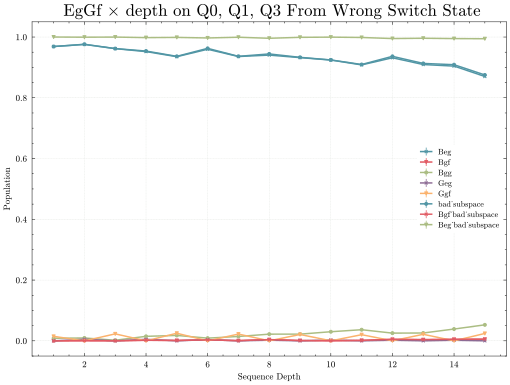

Saving S:\QRAM\qram_4QR2\data\data_250119\00032_leakage_EgGf_qubit31.h5
Starting 3 with len 0.07 gain 15150 freq 5128.0
Will save to S:\QRAM\qram_4QR2\data\data_250119\00033_leakage_EgGf_qubit31.h5
{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-390.00045219204236, 5795.770150727347, 502.42095511476606, -228.8557536534039], 'gain': [0.6, 0.8, 0.5, 0.3], 'readout_length': [4.5, 12, 8.0, 10], 'frequency_ef': [-390.0004521920423, 5795.770150727347, 500.48386902205084, -230.30732892], 'gain_ef': [0.5, 0.5, 0.6, 0.25], 'readout_length_ef': [4.5, 16, 8, 8], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4108.755047003828, 4103.366954082312, 4108.649372291309, 4108.232503550693, 3442.591941352887, 3447.981518133789, 3446.872635941306, 3446.65966586083, 4760.911839134516, 4759.946893523059, 4761.052602755913, 4760.46101643607, 4377.996318964773, 4377.247239665757, 4377.995764386313, 4378.454058265707], 'f_ef': [3882.6760964004225, 0.0, 3882.593

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 0


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.60919891989197 	 angle (deg): -106.38121370422787 	 threshold ge: 167.50604245137936
Qubit (1) ge
ge fidelity (%): 75.5691619161916 	 angle (deg): 79.34150758040032 	 threshold ge: 84.16498075199915
Qubit (3) ge
ge fidelity (%): 77.99000000000001 	 angle (deg): 46.83201557803637 	 threshold ge: 57.84683029990612
thresholds=[167.50604245137936, 84.16498075199915, 0, 57.84683029990612],
angles=[-106.38121370422787, 79.34150758040032, 0, 46.83201557803637],
ge_avgs=[array([ -74.25336158,   94.66880666, -110.42326237,  217.71252323]), array([ 43.1855325 , -54.28900098,  51.57619333, -98.8723302 ]), array([0., 0., 0., 0.]), array([ 27.89676829, -17.90706296,  61.30159036, -53.51944196])],
counts_calib=[[8012, 434, 664, 75, 620, 35, 138, 22], [1389, 6788, 116, 763, 95, 504, 57, 288], [866, 6457, 117, 1191, 83, 605, 81, 600], [1302, 80, 7306, 513, 158, 10, 582, 49], [281, 1147, 1297, 6449, 50, 159, 120, 497], [154, 1174, 842, 6916, 32, 159, 85, 638], [902, 44,

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.39000000000003
Qubit (1) ge
ge fidelity (%): 74.38
Qubit (3) gf
gf fidelity (%): 49.529999999999994
thresholds_f=[140.80576369048808, 42.667879395483205, 0, -58.8469513515188],
angles_f=[-102.17091071228701, 41.02959658655313, 0, 49.97953424043551],
gf_avgs=[array([-72.16539414,  72.78393119, -95.71962815, 181.99498871]), array([ -1.9967544 , -36.35345459,  26.93475101, -61.52947831]), array([0., 0., 0., 0.]), array([-22.59327897,  77.65563694,  -5.70154959,  57.53945464])],
counts_calib_f=[[6921, 1632, 542, 129, 530, 109, 106, 31], [6682, 1384, 870, 162, 558, 103, 192, 49], [2211, 4923, 593, 1272, 200, 371, 171, 259], [1267, 266, 6119, 1389, 195, 37, 589, 138], [1379, 250, 6241, 1163, 171, 33, 640, 123], [513, 946, 2395, 5148, 78, 105, 251, 564], [837, 176, 63, 16, 6737, 1418, 614, 139], [792, 147, 78, 17, 6460, 1257, 1035, 214], [359, 486, 98, 216, 2179, 4855, 440, 1367], [197, 48, 613, 134, 1264, 261, 6154, 1329], [231, 38, 631, 132, 1224, 206, 6385,

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 1


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.65 	 angle (deg): -107.63013256412279 	 threshold ge: 167.76019279143802
Qubit (1) ge
ge fidelity (%): 73.17999999999999 	 angle (deg): 78.93557104667714 	 threshold ge: 83.99962831064364
Qubit (3) ge
ge fidelity (%): 75.46936293629363 	 angle (deg): -99.86843029507028 	 threshold ge: 55.63222534908196
thresholds=[167.76019279143802, 83.99962831064364, 0, 55.63222534908196],
angles=[-107.63013256412279, 78.93557104667714, 0, -99.86843029507028],
ge_avgs=[array([ -77.19015687,   93.84823705, -116.62620478,  217.93994168]), array([ 43.25064916, -55.2079201 ,  51.64914281, -98.15652089]), array([0., 0., 0., 0.]), array([-17.50030348,  29.47973372, -25.50905192,  75.51755016])],
counts_calib=[[7813, 523, 690, 98, 591, 33, 207, 45], [1503, 6794, 156, 855, 103, 469, 18, 102], [862, 6986, 68, 1098, 76, 578, 21, 311], [1354, 97, 7242, 502, 179, 14, 571, 41], [248, 1093, 1243, 6655, 24, 160, 76, 501], [176, 1246, 800, 6864, 23, 167, 63, 661], [857, 37, 63, 7, 78

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 78.97900690069008
Qubit (1) ge
ge fidelity (%): 71.37999999999998
Qubit (3) gf
gf fidelity (%): 50.829999999999984
thresholds_f=[139.1954699209229, 44.39040349429233, 0, -58.83562718545117],
angles_f=[-103.19657689819213, 41.6716676031427, 0, 101.1202407542629],
gf_avgs=[array([ -76.08392475,   72.59723777, -100.74229363,  177.75698965]), array([ -0.11659969, -36.59779314,  27.34713257, -61.04273548]), array([0., 0., 0., 0.]), array([45.19702193, 66.9359762 , 39.99674845, 40.47943609])],
counts_calib_f=[[6770, 1473, 609, 131, 585, 160, 229, 43], [7072, 1424, 642, 133, 541, 89, 86, 13], [2302, 5192, 451, 1035, 208, 407, 154, 251], [1317, 304, 6136, 1438, 193, 44, 478, 90], [1811, 374, 5764, 1094, 196, 41, 605, 115], [574, 948, 2536, 5027, 98, 100, 274, 443], [850, 175, 57, 9, 6857, 1482, 471, 99], [799, 144, 69, 16, 6756, 1282, 792, 142], [319, 556, 59, 139, 2212, 5205, 412, 1098], [226, 47, 548, 116, 1467, 313, 6003, 1280], [221, 41, 566, 112, 1259, 249, 6

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 2


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.70000000000005 	 angle (deg): -109.24081802986281 	 threshold ge: 168.36719617021618
Qubit (1) ge
ge fidelity (%): 70.72898389838984 	 angle (deg): 78.93390968714132 	 threshold ge: 83.10731192776133
Qubit (3) ge
ge fidelity (%): 78.02938993899387 	 angle (deg): 127.27652023219156 	 threshold ge: 58.07458365547538
thresholds=[168.36719617021618, 83.10731192776133, 0, 58.07458365547538],
angles=[-109.24081802986281, 78.93390968714132, 0, 127.27652023219156],
ge_avgs=[array([ -80.83310282,   92.50530384, -123.71450311,  215.3620275 ]), array([ 43.22053809, -55.4686968 ,  51.30990955, -96.83012667]), array([0., 0., 0., 0.]), array([-12.7624431 , -32.42055576, -42.50650283, -71.49842581])],
counts_calib=[[7753, 488, 779, 104, 629, 27, 182, 38], [1284, 6879, 162, 1017, 90, 458, 13, 97], [861, 6696, 112, 1298, 50, 552, 32, 399], [1579, 81, 7088, 506, 180, 7, 525, 34], [288, 1336, 1447, 6213, 36, 136, 85, 459], [157, 1111, 893, 7048, 20, 154, 55, 562], [839, 4

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 80.35917591759177
Qubit (1) ge
ge fidelity (%): 73.79000000000003
Qubit (3) gf
gf fidelity (%): 50.82
thresholds_f=[136.92790171531163, 40.71958138163545, 0, -56.995379019218575],
angles_f=[-104.73051806887699, 39.70974598749852, 0, 69.48328793001181],
gf_avgs=[array([ -77.4156657 ,   69.40858401, -105.02758365,  174.43102012]), array([ -1.81369908, -37.60875591,  27.36835025, -61.84454647]), array([0., 0., 0., 0.]), array([ 4.21736725, 81.44405321, 13.67248084, 56.17767225])],
counts_calib_f=[[7052, 1267, 731, 107, 568, 85, 166, 24], [6672, 1008, 1116, 177, 586, 78, 313, 50], [2346, 4449, 752, 1510, 204, 344, 152, 243], [1200, 208, 6601, 1244, 174, 26, 464, 83], [1305, 221, 6763, 1018, 135, 11, 484, 63], [493, 774, 2683, 5156, 76, 85, 293, 440], [869, 162, 72, 21, 6821, 1204, 705, 146], [799, 119, 110, 19, 6442, 1021, 1295, 195], [365, 528, 95, 167, 2264, 4470, 581, 1530], [210, 54, 626, 104, 1346, 223, 6307, 1130], [253, 30, 629, 89, 1158, 160, 6618, 106

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 3


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.19999999999995 	 angle (deg): -111.22750707364524 	 threshold ge: 164.90800365470113
Qubit (1) ge
ge fidelity (%): 73.58908890889086 	 angle (deg): 80.37568600302554 	 threshold ge: 84.75043796870004
Qubit (3) ge
ge fidelity (%): 77.32000000000001 	 angle (deg): 12.729458628169068 	 threshold ge: 57.01841180502447
thresholds=[164.90800365470113, 84.75043796870004, 0, 57.01841180502447],
angles=[-111.22750707364524, 80.37568600302554, 0, 12.729458628169068],
ge_avgs=[array([ -79.1385063 ,   86.59350818, -126.30342308,  208.01898611]), array([ 44.80148288, -55.54503831,  52.02456905, -98.14055231]), array([0., 0., 0., 0.]), array([33.33824821,  3.66740658, 80.95330107, -7.08883662])],
counts_calib=[[7921, 499, 778, 117, 577, 35, 62, 11], [1377, 6935, 145, 937, 87, 447, 14, 58], [879, 6921, 87, 1311, 61, 537, 30, 174], [1408, 77, 7400, 470, 172, 16, 422, 35], [238, 1089, 1263, 6737, 33, 149, 68, 423], [165, 1127, 864, 7135, 22, 143, 51, 493], [897, 53, 55,

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.28
Qubit (1) ge
ge fidelity (%): 73.92920492049204
Qubit (3) gf
gf fidelity (%): 52.21657565756574
thresholds_f=[134.4407266875731, 41.8378258705473, 0, -57.72839030815487],
angles_f=[-106.79647095238722, 41.74630487149613, 0, 96.33774356218329],
gf_avgs=[array([ -78.59798683,   65.17973061, -111.60708054,  174.53546621]), array([ -0.87572226, -35.04650409,  27.32836114, -60.21634321]), array([0., 0., 0., 0.]), array([38.42041607, 71.88831074, 35.41419687, 44.82180077])],
counts_calib_f=[[7271, 1271, 678, 104, 511, 86, 64, 15], [7133, 1129, 920, 141, 491, 84, 91, 11], [2541, 5171, 527, 1052, 181, 335, 73, 120], [1271, 235, 6605, 1208, 215, 34, 358, 74], [1339, 209, 6606, 1147, 264, 32, 352, 51], [577, 1191, 2669, 4851, 107, 97, 162, 346], [792, 133, 66, 12, 6819, 1259, 766, 153], [793, 118, 94, 8, 6493, 996, 1321, 177], [387, 546, 54, 83, 2349, 4594, 614, 1373], [253, 30, 736, 117, 1843, 288, 5752, 981], [262, 45, 605, 113, 2293, 372, 5430, 880], [95, 1

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 4


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.1 	 angle (deg): -112.34850960257769 	 threshold ge: 165.46185311943609
Qubit (1) ge
ge fidelity (%): 70.60897289728972 	 angle (deg): 79.37325599080432 	 threshold ge: 84.27582664152591
Qubit (3) ge
ge fidelity (%): 77.99839083908392 	 angle (deg): -124.4651020137669 	 threshold ge: 56.77083572495715
thresholds=[165.46185311943609, 84.27582664152591, 0, 56.77083572495715],
angles=[-112.34850960257769, 79.37325599080432, 0, -124.4651020137669],
ge_avgs=[array([ -83.38857627,   83.13829052, -133.45320369,  204.91468893]), array([ 44.08409935, -55.54560724,  51.74685312, -96.38573098]), array([0., 0., 0., 0.]), array([-26.49466117,  20.87630658, -54.36891042,  61.48655846])],
counts_calib=[[7888, 488, 919, 113, 491, 34, 59, 8], [1316, 6804, 172, 1133, 83, 408, 12, 72], [831, 7158, 102, 1254, 47, 493, 7, 108], [1529, 98, 7178, 483, 202, 14, 467, 29], [274, 1306, 1311, 6334, 32, 195, 92, 456], [171, 1515, 829, 6721, 20, 161, 59, 524], [886, 39, 64, 13, 7905

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.85937593759377
Qubit (1) ge
ge fidelity (%): 76.84943694369436
Qubit (3) gf
gf fidelity (%): 53.02999999999998
thresholds_f=[134.76441853791283, 44.76808692014157, 0, -57.2547634537861],
angles_f=[-108.43267743272692, 43.13078387783356, 0, -117.10929394936264],
gf_avgs=[array([ -79.20065615,   62.34471049, -113.80678661,  166.1768225 ]), array([ -0.30105375, -34.101167  ,  28.30345884, -60.89763776]), array([0., 0., 0., 0.]), array([  1.77176408, -81.60060964, -10.77614882, -57.08964284])],
counts_calib_f=[[7309, 1472, 471, 95, 495, 103, 48, 7], [7286, 1251, 731, 129, 447, 76, 64, 16], [2502, 5800, 335, 778, 158, 306, 32, 89], [1242, 264, 6610, 1305, 153, 35, 328, 63], [1629, 291, 6428, 1061, 211, 32, 304, 44], [663, 1362, 2564, 4787, 91, 101, 154, 278], [915, 185, 63, 7, 6910, 1382, 450, 88], [883, 177, 67, 14, 6626, 1212, 846, 175], [331, 588, 54, 80, 2261, 5026, 452, 1208], [236, 50, 680, 124, 1924, 370, 5594, 1022], [259, 47, 596, 87, 2449, 388, 526

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 5


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.43999999999998 	 angle (deg): -114.63318848683285 	 threshold ge: 169.3013149119705
Qubit (1) ge
ge fidelity (%): 75.07912291229124 	 angle (deg): 79.09284277357337 	 threshold ge: 84.69004941892064
Qubit (3) ge
ge fidelity (%): 78.56942894289429 	 angle (deg): -96.06268684120745 	 threshold ge: 56.50217691635289
thresholds=[169.3013149119705, 84.69004941892064, 0, 56.50217691635289],
angles=[-114.63318848683285, 79.09284277357337, 0, -96.06268684120745],
ge_avgs=[array([ -85.25527648,   82.41327793, -140.47984761,  202.84983915]), array([ 43.58250741, -54.81729398,  52.10031107, -99.01988364]), array([0., 0., 0., 0.]), array([-13.95975762,  30.65336123, -19.19231224,  79.91923044])],
counts_calib=[[8024, 484, 807, 94, 512, 38, 35, 6], [1262, 6887, 166, 1022, 99, 474, 8, 82], [910, 7081, 84, 1293, 43, 491, 2, 96], [1301, 75, 7531, 496, 175, 12, 379, 31], [240, 1267, 1130, 6604, 48, 209, 88, 414], [169, 1593, 830, 6696, 33, 188, 45, 446], [820, 49, 87, 1

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.5189718971897
Qubit (1) ge
ge fidelity (%): 75.76000000000002
Qubit (3) gf
gf fidelity (%): 51.619999999999976
thresholds_f=[140.0254781653899, 42.81566018623899, 0, -59.624792787457835],
angles_f=[-109.47473220814652, 45.969729737346626, 0, -47.37513707741152],
gf_avgs=[array([ -82.85417395,   61.17598973, -120.46212308,  167.52659233]), array([  0.98291493, -32.85178956,  27.84839902, -60.64241538]), array([0., 0., 0., 0.]), array([-75.57400464, -32.47399357, -57.20114915, -12.51105667])],
counts_calib_f=[[7003, 1533, 667, 157, 467, 105, 56, 12], [6833, 1421, 959, 176, 405, 89, 100, 17], [2224, 5221, 581, 1289, 159, 321, 76, 129], [1104, 254, 6614, 1378, 142, 33, 385, 90], [1313, 263, 6306, 1256, 247, 36, 470, 109], [410, 973, 2164, 5486, 93, 87, 231, 556], [735, 176, 93, 17, 6614, 1401, 793, 171], [795, 160, 111, 27, 6284, 1219, 1173, 231], [325, 441, 127, 224, 2044, 4365, 698, 1776], [202, 42, 615, 145, 1531, 343, 5796, 1326], [231, 36, 656, 119, 25

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 6


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.78898189818983 	 angle (deg): -115.62211336870651 	 threshold ge: 172.29617895130266
Qubit (1) ge
ge fidelity (%): 72.57897089708972 	 angle (deg): 78.98039393325162 	 threshold ge: 83.65365032787484
Qubit (3) ge
ge fidelity (%): 76.07000000000001 	 angle (deg): -147.59354879202138 	 threshold ge: 57.163963994825224
thresholds=[172.29617895130266, 83.65365032787484, 0, 57.163963994825224],
angles=[-115.62211336870651, 78.98039393325162, 0, -147.59354879202138],
ge_avgs=[array([ -89.98312511,   81.18027294, -146.28929624,  198.58401266]), array([ 43.69375415, -55.06186872,  51.92359015, -97.32349031]), array([0., 0., 0., 0.]), array([-33.39738467,   8.82092842, -73.46689688,  34.2561432 ])],
counts_calib=[[7783, 527, 777, 100, 546, 36, 182, 49], [1378, 6816, 169, 867, 91, 431, 43, 205], [856, 6660, 96, 1294, 59, 530, 47, 458], [1357, 92, 7346, 446, 197, 14, 512, 36], [255, 1256, 1444, 6304, 40, 210, 77, 414], [169, 1461, 781, 6618, 38, 178, 68, 687], [88

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 78.30000000000004
Qubit (1) ge
ge fidelity (%): 71.15892489248921
Qubit (3) gf
gf fidelity (%): 48.27000000000001
thresholds_f=[139.78635403818743, 46.27801648364894, 0, -61.54591684140384],
angles_f=[-110.77910251928017, 45.36281442130382, 0, -74.18023448497368],
gf_avgs=[array([ -85.62127938,   62.24280724, -122.46159884,  159.33229074]), array([  2.07615805, -35.5261484 ,  27.90699898, -61.68621609]), array([0., 0., 0., 0.]), array([-49.42510061, -65.20607974, -42.74924048, -41.6451166 ])],
counts_calib_f=[[6589, 1552, 688, 191, 562, 148, 209, 61], [6929, 1412, 784, 144, 473, 89, 137, 32], [2070, 4387, 813, 1835, 202, 338, 173, 182], [1230, 275, 6279, 1426, 188, 52, 440, 110], [1517, 319, 6246, 1253, 234, 42, 328, 61], [529, 1041, 2401, 5207, 97, 104, 265, 356], [901, 221, 56, 18, 6612, 1656, 434, 102], [807, 183, 77, 19, 6657, 1393, 703, 161], [315, 644, 76, 150, 2143, 5134, 451, 1087], [213, 46, 587, 124, 1926, 431, 5498, 1175], [231, 48, 575, 90, 292

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 7


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.62999999999997 	 angle (deg): -118.12318805915373 	 threshold ge: 169.04899825199433
Qubit (1) ge
ge fidelity (%): 74.8591699169917 	 angle (deg): 78.5615900615533 	 threshold ge: 83.81534281047487
Qubit (3) ge
ge fidelity (%): 76.71935493549354 	 angle (deg): -9.339804069704412 	 threshold ge: 55.595699639659856
thresholds=[169.04899825199433, 83.81534281047487, 0, 55.595699639659856],
angles=[-118.12318805915373, 78.5615900615533, 0, -9.339804069704412],
ge_avgs=[array([ -89.22764465,   75.65451795, -153.02374855,  195.01771317]), array([ 42.71026009, -53.55593972,  51.67373258, -97.856514  ]), array([0., 0., 0., 0.]), array([30.55313125, 13.79503802, 77.40886989, 21.50138743])],
counts_calib=[[8015, 541, 730, 102, 510, 48, 45, 9], [1389, 6740, 138, 833, 85, 535, 33, 247], [798, 6741, 94, 1213, 58, 567, 48, 481], [1300, 114, 7217, 576, 208, 13, 524, 48], [269, 1382, 1296, 6328, 28, 214, 79, 404], [138, 1353, 754, 6912, 23, 178, 48, 594], [806, 45, 69,

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.9993589358936
Qubit (1) ge
ge fidelity (%): 75.51931393139316
Qubit (3) gf
gf fidelity (%): 50.59
thresholds_f=[140.02137422734907, 44.51349178022993, 0, -58.25062918716593],
angles_f=[-114.04466513661659, 43.950483311759115, 0, -34.36964071065526],
gf_avgs=[array([ -84.2040848 ,   56.15801708, -130.40772207,  159.71574732]), array([ -0.38660936, -34.88313569,  27.61003538, -61.87246106]), array([0., 0., 0., 0.]), array([-80.21546501, -15.99156245, -58.32830867,  -1.02214211])],
counts_calib_f=[[7282, 1384, 582, 95, 488, 100, 58, 11], [6999, 1132, 850, 165, 550, 81, 196, 27], [2271, 4793, 670, 1187, 242, 405, 171, 261], [1245, 239, 6538, 1259, 188, 42, 415, 74], [1359, 240, 6518, 1055, 233, 45, 488, 62], [517, 1083, 2358, 4932, 120, 106, 286, 598], [802, 148, 78, 18, 6956, 1321, 584, 93], [822, 158, 86, 15, 6729, 1184, 854, 152], [352, 505, 75, 117, 2279, 4882, 519, 1271], [191, 38, 609, 115, 1623, 253, 6098, 1073], [258, 37, 642, 126, 2441, 390, 5305, 

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 8


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 78.96900790079009 	 angle (deg): -118.99096583751249 	 threshold ge: 174.7531006663522
Qubit (1) ge
ge fidelity (%): 73.79000000000002 	 angle (deg): 79.46364943243786 	 threshold ge: 82.15028842064436
Qubit (3) ge
ge fidelity (%): 75.3682218221822 	 angle (deg): 39.9097685777581 	 threshold ge: 56.06817945945492
thresholds=[174.7531006663522, 82.15028842064436, 0, 56.06817945945492],
angles=[-118.99096583751249, 79.46364943243786, 0, 39.9097685777581],
ge_avgs=[array([ -94.62216411,   77.668772  , -156.655678  ,  189.62182026]), array([ 44.06211997, -54.86497501,  52.1386666 , -98.28835374]), array([0., 0., 0., 0.]), array([ 30.77752712, -13.86565166,  66.94508366, -44.11690166])],
counts_calib=[[7624, 491, 763, 115, 590, 51, 281, 85], [1409, 6519, 181, 1033, 93, 466, 41, 258], [842, 6841, 84, 1234, 54, 546, 41, 358], [1128, 65, 7467, 465, 207, 21, 599, 48], [242, 1285, 1246, 6443, 43, 209, 68, 464], [146, 1501, 755, 6685, 34, 163, 48, 668], [942, 52, 93,

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 80.08999999999999
Qubit (1) ge
ge fidelity (%): 73.98
Qubit (3) gf
gf fidelity (%): 48.63669866986698
thresholds_f=[136.03210031467427, 44.6959683854343, 0, -60.247075167063485],
angles_f=[-114.5521185793169, 43.51186769990011, 0, 73.507600627453],
gf_avgs=[array([ -87.77178502,   55.21990145, -132.84114501,  153.87766563]), array([  0.61294824, -35.61155282,  28.41034635, -62.0012435 ]), array([0., 0., 0., 0.]), array([ 8.01500806, 80.38736684, 15.21270232, 56.07651607])],
counts_calib_f=[[6672, 1690, 631, 132, 572, 125, 144, 34], [6929, 1403, 740, 110, 539, 128, 128, 23], [2074, 4531, 740, 1647, 194, 381, 192, 241], [1164, 241, 6401, 1400, 215, 48, 431, 100], [1452, 296, 6113, 1302, 233, 43, 455, 106], [497, 986, 2296, 5176, 115, 108, 302, 520], [818, 209, 80, 15, 6597, 1626, 516, 139], [874, 191, 84, 17, 6536, 1305, 811, 182], [269, 599, 62, 112, 2086, 4950, 538, 1384], [226, 61, 628, 153, 1662, 396, 5543, 1331], [284, 63, 608, 102, 2329, 471, 5125, 101

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 9


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.09923792379239 	 angle (deg): -120.97498191770777 	 threshold ge: 166.60802392420118
Qubit (1) ge
ge fidelity (%): 72.65999999999997 	 angle (deg): 80.12127437011094 	 threshold ge: 83.50147449212216
Qubit (3) ge
ge fidelity (%): 76.4593689368937 	 angle (deg): -136.031676288142 	 threshold ge: 57.423980449144274
thresholds=[166.60802392420118, 83.50147449212216, 0, 57.423980449144274],
angles=[-120.97498191770777, 80.12127437011094, 0, -136.031676288142],
ge_avgs=[array([ -96.5191869 ,   73.01258886, -162.89945289,  183.59725072]), array([ 44.32080876, -55.05438679,  51.62638907, -97.0054379 ]), array([0., 0., 0., 0.]), array([-30.7638349 ,  16.53172809, -64.50621478,  49.08033366])],
counts_calib=[[7826, 520, 787, 89, 605, 31, 102, 40], [1399, 6839, 154, 827, 104, 492, 27, 158], [798, 6720, 103, 1295, 66, 577, 45, 396], [1363, 76, 7241, 481, 262, 17, 518, 42], [260, 1199, 1273, 6470, 40, 236, 100, 422], [180, 1445, 806, 6543, 36, 223, 56, 711], [882, 

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.19931293129312
Qubit (1) ge
ge fidelity (%): 75.58907690769077
Qubit (3) gf
gf fidelity (%): 48.419999999999995
thresholds_f=[135.67400760488235, 41.562471892810606, 0, -58.48930221156995],
angles_f=[-116.86903453693179, 44.46226082792971, 0, -176.0195082352139],
gf_avgs=[array([ -88.31218611,   50.96778401, -138.60223987,  150.22781447]), array([  0.12564576, -33.98460763,  27.80514049, -61.14935652]), array([0., 0., 0., 0.]), array([ 71.91096843, -37.66855321,  46.93308039, -35.93047506])],
counts_calib_f=[[6909, 1471, 728, 178, 499, 125, 76, 14], [6428, 1166, 1208, 228, 504, 90, 320, 56], [2111, 4101, 902, 1846, 163, 390, 210, 277], [1050, 211, 6643, 1373, 163, 42, 425, 93], [1116, 197, 6436, 1138, 198, 31, 735, 149], [387, 781, 2522, 5259, 95, 105, 290, 561], [714, 168, 70, 22, 6615, 1408, 817, 186], [646, 130, 122, 37, 6243, 1118, 1450, 254], [298, 401, 102, 184, 2181, 4264, 702, 1868], [171, 34, 615, 123, 1245, 234, 6302, 1276], [183, 35, 589, 130

  0%|          | 0/15 [00:00<?, ?it/s]

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Beg 0.8144398546784679
Bgf 0.09327526209194481
Bge 0.02806445269077441
Bgg 0.018247753396689537
Geg -7.449564959982404e-17
Ggf 0.020286763094977015
Ggg -7.070442403723302e-18
ggg 0.018247753396689537
gge 0.02806445269077441
ggf 0.09327526209194481
geg 0.8144398546784679
gee 0.024080277108597278
gef 0.001605636938549159
egg -7.070442403723302e-18
ege 1.2514930350558242e-17
egf 0.020286763094977015
eeg -7.449564959982404e-17
eee -2.7489682467052102e-17
eef 8.983200760499989e-18
bad_subspace 0.9077151167704127
good_subspace 0.020286763094976942
Bgf_bad_subspace 0.1027582997888277
Beg_bad_subspace 0.8972417002111723
Ggf_good_subspace 1.0000000000000036
Geg_good_subspace -3.672130898904683e-15


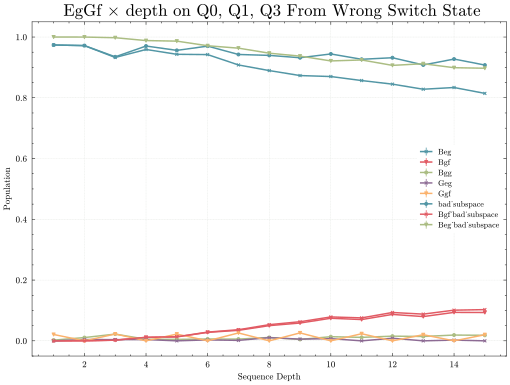

Saving S:\QRAM\qram_4QR2\data\data_250119\00033_leakage_EgGf_qubit31.h5
Starting 4 with len 0.08 gain 13200 freq 5131.4
Will save to S:\QRAM\qram_4QR2\data\data_250119\00034_leakage_EgGf_qubit31.h5
{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-390.00045219204236, 5795.770150727347, 502.42095511476606, -228.8557536534039], 'gain': [0.6, 0.8, 0.5, 0.3], 'readout_length': [4.5, 12, 8.0, 10], 'frequency_ef': [-390.0004521920423, 5795.770150727347, 500.48386902205084, -230.30732892], 'gain_ef': [0.5, 0.5, 0.6, 0.25], 'readout_length_ef': [4.5, 16, 8, 8], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4108.755047003828, 4103.366954082312, 4108.649372291309, 4108.232503550693, 3442.591941352887, 3447.981518133789, 3446.872635941306, 3446.65966586083, 4760.911839134516, 4759.946893523059, 4761.052602755913, 4760.46101643607, 4377.996318964773, 4377.247239665757, 4377.995764386313, 4378.454058265707], 'f_ef': [3882.6760964004225, 0.0, 3882.593

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 0


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.21999999999997 	 angle (deg): -123.33321808265376 	 threshold ge: 168.13933635151474
Qubit (1) ge
ge fidelity (%): 72.83999999999997 	 angle (deg): 79.82923410763813 	 threshold ge: 83.28826276939775
Qubit (3) ge
ge fidelity (%): 77.2383178317832 	 angle (deg): -77.80861187677736 	 threshold ge: 56.193069382974286
thresholds=[168.13933635151474, 83.28826276939775, 0, 56.193069382974286],
angles=[-123.33321808265376, 79.82923410763813, 0, -77.80861187677736],
ge_avgs=[array([ -97.37684776,   71.02543256, -167.70155637,  177.9494259 ]), array([ 43.64406647, -55.14851186,  51.2433704 , -97.50766468]), array([0., 0., 0., 0.]), array([-4.26792705, 33.12447201,  6.03300651, 80.80287054])],
counts_calib=[[7836, 469, 739, 89, 576, 30, 206, 55], [1340, 6753, 165, 858, 97, 506, 35, 246], [837, 6821, 72, 1154, 53, 594, 43, 426], [1345, 88, 7056, 567, 200, 13, 669, 62], [254, 1192, 1341, 6225, 48, 198, 119, 623], [168, 1366, 759, 6706, 32, 206, 72, 691], [890, 51, 

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.71999999999997
Qubit (1) ge
ge fidelity (%): 75.18896789678963
Qubit (3) gf
gf fidelity (%): 47.3064396439644
thresholds_f=[138.85385133334708, 43.684591744364766, 0, -60.46796833346225],
angles_f=[-118.48564742796061, 45.31493273858221, 0, -2.435161583720457],
gf_avgs=[array([ -91.03492815,   49.32993582, -143.72557424,  146.43203205]), array([  1.45330846, -34.79912641,  28.52197373, -62.16701135]), array([0., 0., 0., 0.]), array([-77.18377941,  27.24895077, -52.35025382,  28.30505102])],
counts_calib_f=[[6740, 1539, 760, 179, 511, 108, 132, 31], [6560, 1232, 1071, 233, 491, 92, 260, 61], [2108, 4209, 910, 1777, 191, 333, 225, 247], [944, 233, 6532, 1398, 176, 41, 560, 116], [1422, 272, 6500, 1190, 161, 25, 354, 76], [443, 970, 2275, 5430, 93, 82, 260, 447], [768, 172, 102, 15, 6677, 1445, 663, 158], [784, 133, 97, 24, 6557, 1197, 1015, 193], [292, 473, 110, 202, 2143, 4590, 604, 1586], [211, 39, 587, 138, 1360, 326, 6047, 1292], [212, 47, 651, 121, 1

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 1


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.38934593459344 	 angle (deg): -124.88760677649219 	 threshold ge: 161.24950072120868
Qubit (1) ge
ge fidelity (%): 76.21916091609161 	 angle (deg): 79.11594270507362 	 threshold ge: 85.43988301858704
Qubit (3) ge
ge fidelity (%): 77.29949894989498 	 angle (deg): -33.88255265075097 	 threshold ge: 59.010372482312114
thresholds=[161.24950072120868, 85.43988301858704, 0, 59.010372482312114],
angles=[-124.88760677649219, 79.11594270507362, 0, -33.88255265075097],
ge_avgs=[array([ -99.24672699,   65.74001664, -173.96571809,  172.8965657 ]), array([ 43.73085041, -55.48266506,  52.2115182 , -99.58823844]), array([0., 0., 0., 0.]), array([21.3416903 , 26.31379365, 61.55415765, 53.31767939])],
counts_calib=[[8078, 416, 731, 104, 581, 26, 56, 8], [1458, 6888, 156, 806, 93, 513, 17, 69], [846, 6950, 87, 1376, 63, 570, 4, 104], [1154, 47, 7782, 333, 274, 8, 388, 14], [198, 1094, 1274, 6735, 43, 234, 83, 339], [161, 1752, 813, 6582, 23, 175, 46, 448], [891, 40, 52, 

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.49944494449447
Qubit (1) ge
ge fidelity (%): 78.83999999999999
Qubit (3) gf
gf fidelity (%): 54.130000000000024
thresholds_f=[139.68415267860138, 45.044743774086285, 0, -58.99490672500451],
angles_f=[-120.82580255464421, 42.36821990314928, 0, -16.146045074885055],
gf_avgs=[array([ -91.2527686 ,   44.11888452, -149.85270781,  142.32062055]), array([ -1.23224879, -35.45329241,  29.25324934, -63.25938496]), array([0., 0., 0., 0.]), array([-81.55794113,  10.07627766, -54.72169878,  17.84552978])],
counts_calib_f=[[7356, 1452, 514, 105, 440, 90, 36, 7], [7186, 1375, 720, 130, 449, 80, 48, 12], [2331, 5868, 376, 805, 169, 321, 57, 73], [1001, 222, 6816, 1303, 208, 33, 347, 70], [1303, 241, 6657, 1157, 233, 36, 323, 50], [531, 1335, 2329, 5177, 87, 83, 120, 338], [858, 162, 52, 11, 7008, 1304, 503, 102], [811, 143, 66, 8, 6774, 1238, 828, 132], [344, 675, 47, 79, 2170, 5203, 422, 1060], [209, 48, 700, 120, 2115, 398, 5362, 1048], [246, 55, 600, 139, 3593, 594,

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 2


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.78999999999999 	 angle (deg): -127.06175680257766 	 threshold ge: 168.57405069964534
Qubit (1) ge
ge fidelity (%): 75.42909190919093 	 angle (deg): 78.21410015555774 	 threshold ge: 85.0008497742287
Qubit (3) ge
ge fidelity (%): 78.18000000000004 	 angle (deg): 105.26544136483474 	 threshold ge: 58.971778379226265
thresholds=[168.57405069964534, 85.0008497742287, 0, 58.971778379226265],
angles=[-127.06175680257766, 78.21410015555774, 0, 105.26544136483474],
ge_avgs=[array([ -98.98859551,   60.5239848 , -181.14984103,  169.31147569]), array([ 42.48717214, -54.8419748 ,  51.85999946, -99.76239086]), array([0., 0., 0., 0.]), array([  1.39622233, -34.34322588, -11.60494847, -81.98037389])],
counts_calib=[[8122, 443, 822, 82, 447, 17, 52, 15], [1393, 6883, 156, 959, 72, 454, 12, 71], [872, 6767, 116, 1637, 55, 440, 11, 102], [1173, 58, 7774, 404, 245, 16, 307, 23], [195, 1193, 1410, 6618, 32, 209, 72, 271], [150, 1435, 881, 6864, 33, 164, 38, 435], [883, 42,

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.85000000000001
Qubit (1) ge
ge fidelity (%): 77.84930493049306
Qubit (3) gf
gf fidelity (%): 55.846896689669
thresholds_f=[134.52037182621558, 42.194946215144974, 0, -54.895138965932006],
angles_f=[-121.88163005361754, 40.61040936202796, 0, 177.68438601337937],
gf_avgs=[array([ -92.70086606,   41.40715275, -152.04135897,  136.80980796]), array([ -1.61523589, -35.76379835,  28.57393858, -61.6485657 ]), array([0., 0., 0., 0.]), array([ 74.28537364, -32.76018405,  45.05434117, -33.94220244])],
counts_calib_f=[[7395, 1261, 616, 89, 503, 88, 41, 7], [7320, 982, 841, 122, 558, 70, 92, 15], [2294, 5503, 443, 1003, 196, 370, 68, 123], [1066, 171, 6808, 1195, 205, 37, 434, 84], [1269, 178, 6750, 1056, 269, 30, 392, 56], [465, 1165, 2343, 5345, 97, 89, 139, 357], [756, 149, 63, 9, 7060, 1249, 622, 92], [786, 126, 81, 9, 6772, 995, 1086, 145], [351, 613, 54, 89, 2276, 4805, 506, 1306], [234, 29, 595, 109, 2148, 377, 5569, 939], [216, 35, 578, 74, 3561, 442, 4500, 

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 3


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.86940794079406 	 angle (deg): -128.47214043107903 	 threshold ge: 171.5676062530148
Qubit (1) ge
ge fidelity (%): 77.36 	 angle (deg): 78.90207638245676 	 threshold ge: 84.80783966686698
Qubit (3) ge
ge fidelity (%): 77.30999999999999 	 angle (deg): 174.9471508871176 	 threshold ge: 57.032801437369216
thresholds=[171.5676062530148, 84.80783966686698, 0, 57.032801437369216],
angles=[-128.47214043107903, 78.90207638245676, 0, 174.9471508871176],
ge_avgs=[array([-103.52377084,   59.79002135, -187.00927482,  164.85050072]), array([ 43.02916207, -54.49733448,  51.86965754, -99.56636177]), array([0., 0., 0., 0.]), array([-32.33301865, -12.69685934, -80.86578467, -16.98803867])],
counts_calib=[[8066, 589, 659, 78, 508, 36, 52, 12], [1321, 7052, 127, 885, 93, 439, 19, 64], [841, 7018, 82, 1396, 56, 508, 7, 92], [1155, 60, 7685, 498, 235, 15, 323, 29], [201, 1080, 1255, 6926, 30, 224, 50, 234], [111, 1481, 743, 7044, 25, 167, 40, 389], [860, 65, 77, 7, 7814, 522

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.65936193619363
Qubit (1) ge
ge fidelity (%): 76.8792289228923
Qubit (3) gf
gf fidelity (%): 54.69000000000004
thresholds_f=[135.11434597572392, 42.27130164290312, 0, -55.72044883299375],
angles_f=[-123.16980348526994, 42.404556082815255, 0, -69.8462938584825],
gf_avgs=[array([ -94.10261368,   39.45823054, -154.62517547,  132.05287077]), array([ -0.76040153, -34.87824484,  28.46915841, -61.5727634 ]), array([0., 0., 0., 0.]), array([-58.03986924, -57.96907323, -48.04179052, -30.72718885])],
counts_calib_f=[[7392, 1193, 639, 115, 495, 92, 63, 11], [7197, 977, 1029, 133, 493, 63, 100, 8], [2399, 5488, 473, 949, 204, 344, 45, 98], [1054, 198, 6997, 1128, 194, 47, 312, 70], [1256, 140, 7017, 925, 253, 29, 345, 35], [460, 1051, 2467, 5316, 113, 75, 166, 352], [848, 142, 75, 15, 7052, 1066, 675, 127], [769, 122, 96, 15, 6740, 904, 1191, 163], [347, 539, 45, 100, 2334, 4569, 580, 1486], [215, 36, 603, 124, 2445, 388, 5341, 848], [220, 41, 633, 91, 3292, 398, 47

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 4


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.77943894389438 	 angle (deg): -130.3002773830145 	 threshold ge: 165.52291189936466
Qubit (1) ge
ge fidelity (%): 77.41 	 angle (deg): 78.92301973807628 	 threshold ge: 86.05978856613237
Qubit (3) ge
ge fidelity (%): 78.08999999999999 	 angle (deg): 122.41276708031748 	 threshold ge: 59.42111644477328
thresholds=[165.52291189936466, 86.05978856613237, 0, 59.42111644477328],
angles=[-130.3002773830145, 78.92301973807628, 0, 122.41276708031748],
ge_avgs=[array([-102.95527388,   55.40626795, -192.09977742,  160.52082685]), array([  43.22640334,  -54.43136145,   52.16544552, -100.09113559]), array([0., 0., 0., 0.]), array([ -7.97044303, -33.62888636, -34.20608594, -74.94929007])],
counts_calib=[[8285, 422, 640, 69, 515, 23, 38, 8], [1432, 6927, 146, 873, 82, 470, 11, 59], [879, 7154, 101, 1234, 52, 471, 9, 100], [1161, 59, 7748, 377, 276, 12, 344, 23], [219, 1204, 1313, 6623, 44, 209, 59, 329], [137, 1826, 775, 6595, 24, 145, 42, 456], [831, 52, 66, 5, 7979

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.92000000000003
Qubit (1) ge
ge fidelity (%): 77.00916891689168
Qubit (3) gf
gf fidelity (%): 56.73999999999999
thresholds_f=[132.69479845258454, 43.10450849071887, 0, -57.74315243840422],
angles_f=[-125.40762745125396, 43.88005965959777, 0, -94.35532088888048],
gf_avgs=[array([ -95.36548133,   36.93696129, -159.08102004,  126.56816187]), array([ -0.15855792, -34.89634228,  28.41565615, -62.37477552]), array([0., 0., 0., 0.]), array([-29.0704059 , -76.98570342, -31.31523666, -47.51106652])],
counts_calib_f=[[7085, 1401, 683, 123, 534, 92, 75, 7], [7015, 1264, 892, 133, 500, 84, 92, 20], [2092, 5753, 415, 1013, 179, 371, 55, 122], [980, 198, 6798, 1325, 213, 33, 378, 75], [1234, 211, 6698, 1151, 220, 37, 394, 55], [461, 1321, 2273, 5171, 89, 126, 166, 393], [752, 175, 67, 13, 6828, 1392, 651, 122], [748, 148, 99, 16, 6626, 1049, 1119, 195], [288, 586, 49, 96, 2092, 4801, 596, 1492], [189, 44, 538, 112, 2613, 525, 5000, 979], [224, 34, 606, 96, 2756, 459, 

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 5


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.29999999999998 	 angle (deg): -131.41124025751208 	 threshold ge: 163.669204682543
Qubit (1) ge
ge fidelity (%): 76.53919391939193 	 angle (deg): 79.2328166243962 	 threshold ge: 84.61592810962686
Qubit (3) ge
ge fidelity (%): 76.57000000000002 	 angle (deg): 155.66903624647702 	 threshold ge: 59.003509911969715
thresholds=[163.669204682543, 84.61592810962686, 0, 59.003509911969715],
angles=[-131.41124025751208, 79.2328166243962, 0, 155.66903624647702],
ge_avgs=[array([-106.68909226,   53.46140449, -193.75054023,  152.17418748]), array([ 43.31036283, -54.70472491,  51.77271782, -99.20440062]), array([0., 0., 0., 0.]), array([-26.28814072, -23.42256204, -70.24902458, -43.30026986])],
counts_calib=[[7988, 507, 713, 91, 592, 44, 60, 5], [1433, 7018, 157, 757, 93, 449, 19, 74], [884, 6784, 90, 1565, 52, 494, 11, 120], [1137, 69, 7712, 434, 265, 13, 358, 12], [191, 1026, 1387, 6715, 47, 189, 52, 393], [162, 2286, 799, 6056, 29, 186, 43, 439], [866, 52, 51, 1

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.73
Qubit (1) ge
ge fidelity (%): 76.84000000000002
Qubit (3) gf
gf fidelity (%): 55.03688568856884
thresholds_f=[135.51001921709127, 42.71434310142741, 0, -55.10541172954336],
angles_f=[-127.03641244821719, 43.289650149174875, 0, 66.87905429074858],
gf_avgs=[array([ -96.46855687,   33.63023611, -165.05961324,  124.53338741]), array([ -0.45744812, -34.60548704,  28.37227823, -61.76341605]), array([0., 0., 0., 0.]), array([ 3.13097217, 80.86254129, 14.57003267, 54.07118316])],
counts_calib_f=[[7281, 1279, 639, 111, 510, 108, 65, 7], [7289, 1181, 793, 106, 464, 62, 91, 14], [2336, 5535, 426, 972, 203, 351, 55, 122], [1072, 156, 6930, 1155, 231, 45, 341, 70], [1158, 153, 7032, 981, 206, 33, 391, 46], [527, 1516, 2350, 4910, 91, 112, 137, 357], [832, 141, 62, 13, 7070, 1156, 616, 110], [762, 113, 85, 17, 6679, 1004, 1150, 190], [300, 556, 48, 70, 2267, 4875, 530, 1354], [202, 33, 558, 102, 3444, 559, 4362, 740], [220, 45, 589, 83, 2449, 373, 5420, 821], [66,

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 6


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.17940594059404 	 angle (deg): -133.0998769735834 	 threshold ge: 165.2371907224897
Qubit (1) ge
ge fidelity (%): 78.71000000000001 	 angle (deg): 78.61777072293935 	 threshold ge: 83.66813458554874
Qubit (3) ge
ge fidelity (%): 77.81 	 angle (deg): 87.15081183159229 	 threshold ge: 57.79557997714652
thresholds=[165.2371907224897, 83.66813458554874, 0, 57.79557997714652],
angles=[-133.0998769735834, 78.61777072293935, 0, 87.15081183159229],
ge_avgs=[array([-105.79548748,   48.76833546, -197.4335021 ,  146.69527475]), array([  42.62462526,  -53.32190217,   52.14509872, -100.61388703]), array([0., 0., 0., 0.]), array([ 11.76295342, -31.86736449,  14.21076455, -81.05106689])],
counts_calib=[[8099, 472, 721, 95, 533, 34, 32, 14], [1344, 6851, 171, 1022, 81, 458, 10, 63], [817, 6757, 123, 1597, 51, 495, 7, 153], [987, 38, 7893, 476, 239, 9, 332, 26], [194, 1168, 1276, 6764, 44, 127, 63, 364], [109, 2426, 742, 6040, 26, 173, 42, 442], [870, 36, 60, 10, 7921, 3

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.62936693669367
Qubit (1) ge
ge fidelity (%): 76.43999999999997
Qubit (3) gf
gf fidelity (%): 56.11999999999998
thresholds_f=[132.41811413110665, 40.01606710696395, 0, -56.320518364087846],
angles_f=[-128.66151065810956, 39.48196728606433, 0, -77.86435667380768],
gf_avgs=[array([ -96.53652258,   31.2155152 , -166.5072267 ,  118.67356809]), array([ -1.96855373, -36.54702065,  28.28518521, -61.47029052]), array([0., 0., 0., 0.]), array([-48.9974605 , -66.26494512, -42.7394869 , -37.16244919])],
counts_calib_f=[[7327, 1186, 727, 100, 496, 86, 66, 12], [7096, 999, 1054, 163, 507, 65, 100, 16], [2292, 5294, 482, 1204, 181, 344, 64, 139], [993, 152, 6956, 1138, 267, 52, 370, 72], [1136, 157, 6983, 934, 221, 32, 485, 52], [590, 1508, 2401, 4779, 107, 88, 177, 350], [752, 143, 79, 9, 6898, 1178, 809, 132], [733, 103, 98, 14, 6555, 909, 1393, 195], [324, 551, 48, 81, 2188, 4528, 659, 1621], [215, 36, 621, 76, 3228, 488, 4596, 740], [206, 37, 594, 76, 2329, 284, 5

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 7


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.64938393839384 	 angle (deg): -134.08324486929038 	 threshold ge: 161.77225875657825
Qubit (1) ge
ge fidelity (%): 78.06929192919293 	 angle (deg): 78.50220493735586 	 threshold ge: 85.94942155408451
Qubit (3) ge
ge fidelity (%): 79.01 	 angle (deg): 134.39953560487746 	 threshold ge: 59.58691704568987
thresholds=[161.77225875657825, 85.94942155408451, 0, 59.58691704568987],
angles=[-134.08324486929038, 78.50220493735586, 0, 134.39953560487746],
ge_avgs=[array([-109.2743568 ,   46.78784291, -203.57990789,  144.16058423]), array([ 42.88374132, -54.01899238,  52.2162965 , -99.89900404]), array([0., 0., 0., 0.]), array([-16.60736445, -30.37193805, -51.17106156, -65.66779574])],
counts_calib=[[8349, 431, 543, 46, 431, 28, 126, 46], [1365, 7239, 105, 708, 68, 350, 17, 148], [944, 6886, 109, 1140, 50, 487, 38, 346], [1210, 55, 7601, 444, 157, 14, 482, 37], [233, 1239, 1193, 6667, 21, 138, 70, 439], [110, 1024, 781, 7191, 24, 172, 60, 638], [771, 51, 78, 10, 7

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.82000000000002
Qubit (1) ge
ge fidelity (%): 78.49999999999999
Qubit (3) gf
gf fidelity (%): 53.50669066906687
thresholds_f=[137.7165887639878, 43.2657340852747, 0, -58.35700145494057],
angles_f=[-129.87570030758886, 42.13655503960939, 0, 23.585771024183106],
gf_avgs=[array([ -98.89967142,   29.44489074, -171.32123842,  116.13479942]), array([ -1.32593736, -35.25866531,  28.80307788, -62.51725624]), array([0., 0., 0., 0.]), array([-57.46815989,  58.27729483, -31.85038462,  47.0927395 ])],
counts_calib_f=[[7453, 1280, 567, 109, 466, 72, 43, 10], [7313, 1136, 814, 140, 443, 80, 63, 11], [2235, 5339, 537, 1000, 195, 303, 218, 173], [1068, 189, 6892, 1243, 138, 30, 369, 71], [1238, 200, 6758, 1153, 141, 17, 426, 67], [462, 951, 2413, 5467, 80, 77, 221, 329], [766, 130, 40, 5, 7106, 1234, 612, 107], [799, 125, 66, 10, 6544, 1031, 1227, 198], [330, 556, 59, 94, 2066, 4209, 964, 1722], [188, 28, 598, 100, 1115, 227, 6573, 1171], [190, 44, 630, 95, 1102, 178, 6

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 8


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.38 	 angle (deg): -136.17836190274258 	 threshold ge: 165.9358087666348
Qubit (1) ge
ge fidelity (%): 76.52 	 angle (deg): 78.76746787146169 	 threshold ge: 84.5663930664942
Qubit (3) ge
ge fidelity (%): 78.27 	 angle (deg): 42.87997279472861 	 threshold ge: 58.078708121732745
thresholds=[165.9358087666348, 84.5663930664942, 0, 58.078708121732745],
angles=[-136.17836190274258, 78.76746787146169, 0, 42.87997279472861],
ge_avgs=[array([-111.83460572,   43.43330695, -207.87698603,  135.60428987]), array([ 42.88814642, -54.62528839,  51.71005705, -99.04680228]), array([0., 0., 0., 0.]), array([ 30.52151686, -15.29490479,  66.36637588, -48.5806624 ])],
counts_calib=[[8146, 480, 698, 85, 441, 25, 98, 27], [1358, 7039, 142, 848, 61, 395, 18, 139], [874, 7021, 82, 1217, 38, 457, 18, 293], [1208, 70, 7463, 502, 154, 27, 504, 72], [195, 1079, 1223, 6865, 26, 119, 77, 416], [161, 1175, 770, 7206, 21, 108, 49, 510], [857, 47, 64, 8, 7036, 457, 1236, 295], [133, 700

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.17945794579461
Qubit (1) ge
ge fidelity (%): 76.86000000000006
Qubit (3) gf
gf fidelity (%): 51.66
thresholds_f=[141.89276601394945, 42.956712246964685, 0, -60.13662651151424],
angles_f=[-131.15533681264088, 41.542097537621636, 0, 29.597363863625965],
gf_avgs=[array([-101.76985116,   27.12249486, -174.15150246,  109.93355014]), array([ -0.72008297, -35.81316116,  28.63803544, -61.82551001]), array([0., 0., 0., 0.]), array([-54.04854186,  62.27211086, -30.34268255,  48.8067511 ])],
counts_calib_f=[[7356, 1308, 663, 110, 405, 73, 69, 16], [7291, 1166, 809, 114, 444, 81, 78, 17], [2240, 5125, 620, 1040, 200, 296, 269, 210], [1075, 226, 6803, 1295, 142, 25, 367, 67], [1388, 283, 6577, 1175, 117, 24, 370, 66], [435, 931, 2438, 5318, 85, 84, 320, 389], [770, 176, 63, 13, 6787, 1306, 725, 160], [801, 125, 56, 10, 5747, 898, 2063, 300], [344, 559, 81, 102, 2063, 4464, 820, 1567], [216, 26, 702, 141, 1297, 229, 6236, 1153], [203, 36, 621, 111, 1203, 198, 6588, 1

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 9


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 85.50943594359437 	 angle (deg): -138.32293462010426 	 threshold ge: 164.40411225499165
Qubit (1) ge
ge fidelity (%): 78.18915991599158 	 angle (deg): 78.72028254204616 	 threshold ge: 83.04527901966513
Qubit (3) ge
ge fidelity (%): 79.52999999999999 	 angle (deg): -94.69496771207392 	 threshold ge: 56.190761884922544
thresholds=[164.40411225499165, 83.04527901966513, 0, 56.190761884922544],
angles=[-138.32293462010426, 78.72028254204616, 0, -94.69496771207392],
ge_avgs=[array([-109.05164356,   41.18791592, -212.11781397,  132.94254486]), array([  42.85833766,  -53.14912987,   52.20758785, -100.0239086 ]), array([0., 0., 0., 0.]), array([-14.92519346,  30.25366794, -19.02300348,  80.14996077])],
counts_calib=[[8104, 483, 741, 95, 490, 24, 58, 5], [1215, 7034, 161, 1027, 63, 405, 12, 83], [819, 6695, 87, 1422, 53, 576, 30, 318], [1085, 83, 7724, 589, 100, 15, 371, 33], [227, 1099, 1104, 7023, 29, 104, 57, 357], [142, 1174, 761, 7304, 25, 130, 49, 415], [747

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.80000000000001
Qubit (1) ge
ge fidelity (%): 77.91999999999999
Qubit (3) gf
gf fidelity (%): 53.65999999999998
thresholds_f=[137.80501264945835, 41.47893657308722, 0, -58.026394292354226],
angles_f=[-132.25859899676038, 41.49665617702533, 0, 56.73394298131116],
gf_avgs=[array([-101.43419349,   23.24733046, -176.8478178 ,  106.24622431]), array([ -0.4158646 , -35.06295121,  28.97519703, -61.06290824]), array([0., 0., 0., 0.]), array([-13.60995797,  80.03761668,   1.88421212,  56.41951758])],
counts_calib_f=[[7170, 1397, 658, 144, 452, 107, 57, 15], [6900, 1288, 979, 187, 438, 83, 109, 16], [2156, 5221, 601, 1329, 169, 336, 58, 130], [996, 222, 6755, 1450, 116, 20, 363, 78], [1115, 184, 6864, 1243, 117, 25, 376, 76], [363, 752, 2455, 5719, 72, 64, 208, 367], [724, 175, 80, 13, 6746, 1363, 750, 149], [712, 120, 87, 25, 6338, 1066, 1419, 233], [292, 496, 79, 163, 1925, 4603, 689, 1753], [183, 29, 607, 121, 1138, 229, 6431, 1262], [194, 29, 640, 127, 1101, 1

  0%|          | 0/15 [00:00<?, ?it/s]

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Beg 0.885292031625618
Bgf 0.039424897918493663
Bge 0.018687698923598693
Bgg 0.02064442030527328
Geg -2.5017420103940063e-17
Ggf 0.01784139406631843
Ggg -1.5441175241701366e-17
ggg 0.02064442030527328
gge 0.018687698923598693
ggf 0.039424897918493663
geg 0.885292031625618
gee 0.0175674363611115
gef 0.0005421207995863491
egg -1.5441175241701366e-17
ege 3.635533653103516e-18
egf 0.01784139406631843
eeg -2.5017420103940063e-17
eee -1.2037404669613346e-17
eef -2.701442143275371e-18
bad_subspace 0.9247169295441117
good_subspace 0.017841394066318406
Bgf_bad_subspace 0.04263455838094179
Beg_bad_subspace 0.9573654416190582
Ggf_good_subspace 1.0000000000000013
Geg_good_subspace -1.4022121820160233e-15


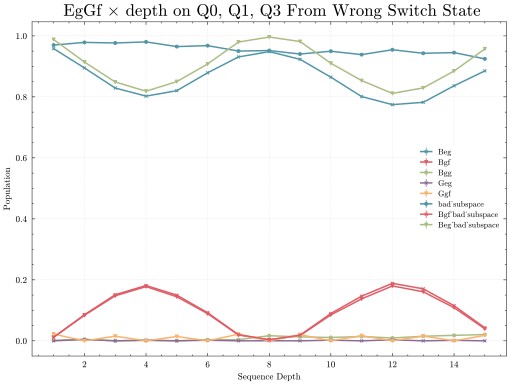

Saving S:\QRAM\qram_4QR2\data\data_250119\00034_leakage_EgGf_qubit31.h5


In [56]:
for i_len in range(len(opt_lens)):
    rbprog = meas.EgGfLeakageExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"leakage_EgGf_qubit{qubits[0]}{qubits[1]}",
        config_file=config_path,
    )

    rbprog.cfg.device.qubit.f_EgGf_Q_half[qDrive] = opt_freqs[i_len]
    rbprog.cfg.device.qubit.pulses.pi_EgGf_Q.half_gain[qDrive] = opt_gains[i_len]
    rbprog.cfg.device.qubit.pulses.pi_EgGf_Q.half_sigma[qDrive] = opt_lens[i_len]

    print("Starting", i_len, "with len", opt_lens[i_len], "gain", opt_gains[i_len], "freq", opt_freqs[i_len])

    gate_char = None
    # gate_char = 'X'

    print("Will save to", rbprog.fname)

    rbprog.cfg.expt = dict(
        depths=depths,
        # reps=4000*10, # number averages per unique sequence need at least 10,000 for a good amount of error per point!!
        # reps_f=10000*10,
        reps=4000, # number averages per unique sequence need at least 10,000 for a good amount of error per point!!
        reps_f=6000,
        loops=10,
        # loops=1,
        gate_char=gate_char, # single qubit clifford gate (str) to characterize. if not None, runs interleaved RB instead of regular RB
        qubits=[0, 1, qDrive],
        qDrive=qDrive,
        singleshot_reps=10000, # reps per state for singleshot calibration
        # singleshot_reps=100, # reps per state for singleshot calibration
        # singleshot_reps_f=15000, # reps per state for singleshot calibration
        # singleshot_reps=20000, # reps per state for singleshot calibration
        post_process='threshold', # 'threshold' (uses single shot binning), 'scale' (scale by ge_avgs), or None

        test_leakage = True, # if true, does pi/pi instead of random sequence
        # wrong_init = False, # if True, starts from wrong state. if False, starts from good state, does pi^N both cases
        wrong_init = True, # if True, starts from wrong state. if False, starts from good state, does pi^N both cases

        measure_f_only=False,
        measure_f=[qDrive],

        add_phase=False,

        # cool_qubits=[0, 1],

        full_mux_expt=full_mux_expt,
        resonator_reset=resonator_reset,
        use_robust_pulses=True,

        validate_variations=False,

    )
    # rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i] = int(0.8*rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i])
    # rbprog.cfg.device.readout.relax_delay = 1
    # rbprog.cfg.device.readout.readout_length = 5

    print(rbprog.cfg)

    import Pyro4.util
    try:
        rbprog.acquire(progress=True, debug=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))

    # rbprog.go(analyze=False, display=False, progress=True, save=False)
    rbprog.analyze(fit=False)
    rbprog.display(fit=False, show_all_vars=False)
    saved_files.append(rbprog.save_data())

In [57]:
print("saved_files", saved_files)

saved_files ['S:\\QRAM\\qram_4QR2\\data\\data_250119\\00030_leakage_EgGf_qubit31.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00031_leakage_EgGf_qubit31.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00032_leakage_EgGf_qubit31.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00033_leakage_EgGf_qubit31.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00034_leakage_EgGf_qubit31.h5']


In [45]:
# # TESTING
# rbprog = meas.EgGfLeakageExperiment(config_file=config_path)
# temp_data, attrs = prev_data("S:\QRAM\qram_4QR2\data\data_250119\\00004_leakage_EgGf_qubit31.h5")
# rbprog.data = temp_data
# rbprog.cfg = AttrDict(attrs['config'])
# rbprog.calib_order = attrs['calib_order']

rbprog.analyze(fit=False)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


  0%|          | 0/15 [00:00<?, ?it/s]

{'xpts': array([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]]),
 'counts_raw': array([[[[[ 4863.,   447., 29698.,  1889.,   539.,  1241.,   627.,
              696.]],
 
          [[ 4920.,   503., 29432.,  1975.,   793.,   127.,  2052.,
              198.]],
 
          [[ 4849.,   689., 28912.,  2141.,   644.,  1464.,   621.,
              680.]],
 
          [[ 5119.,   742., 28635.,  2210.,   761.,   162.,  2157.,
              214.]],
 
          [[ 5768.,   924., 27531.,  2321.,   668.,  1472.,   672.,
              644.]],
 
          [[ 6138.,   985., 27496.,  2320.,   691.,   148.,  2009.,
              213.]],
 
          [[ 5968.,  1152., 27243.,  2421.,   605.,  1338.,   666.,
              607.]],
 
          [[ 6043.,  1209., 27272.,  2461.,   692.,   171.,  1925.,
              227.]],
 
          [[ 5970.,  1367., 27460.,  2489.,   488.,   905.,   484.,
              837.]],
 
          [[ 5951.,  1162., 27362.,  2485.,   681.,   187.,  1961.,
          

#### Wrong init

depths 15
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Starting 0 with len 0.067 gain 15683 freq 5126.940410545285
Will save to S:\QRAM\qram_4QR2\data\data_250119\00028_leakage_EgGf_qubit31.h5
{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-390.00045219204236, 5795.770150727347, 502.42095511476606, -228.8557536534039], 'gain': [0.6, 0.5, 0.5, 0.3], 'readout_length': [4.5, 16, 6.0, 10], 'frequency_ef': [-390.0004521920423, 5795.770150727347, 500.48386902205084, -230.30732892], 'gain_ef': [0.5, 0.5, 0.4, 0.25], 'readout_length_ef': [4.5, 16, 10, 8], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4108.755047003828, 4103.366954082312, 4108.649372291309, 4108.232503550693, 3442.591941352887, 3447.981518133789, 3446.872635941306, 3446.65966586083, 4760.911839134516, 4759.946893523059, 4761.052602755913, 4760.46101643607, 4377.996318964773, 4377.247239665757, 4377.995764386313, 4378.454058265707], 'f_ef': [3882.6760964004225, 0.0, 3882.59302

  0%|          | 0/6 [00:00<?, ?it/s]

Beginning loop 0


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.90978332611084 	 angle (deg): -106.57567492894559 	 threshold ge: 165.78724996280508
Qubit (1) ge
ge fidelity (%): 76.14333333333336 	 angle (deg): 40.46187049126921 	 threshold ge: 42.85232627191613
Qubit (3) ge
ge fidelity (%): 80.61333333333336 	 angle (deg): 105.84558491582828 	 threshold ge: 57.11747007178222
thresholds=[165.78724996280508, 42.85232627191613, 0, 57.11747007178222],
angles=[-106.57567492894559, 40.46187049126921, 0, 105.84558491582828],
ge_avgs=[array([ -70.93813343,   91.27793915, -107.68872685,  214.74679235]), array([ -0.70470347, -35.95276221,  28.98999632, -61.28027476]), array([0., 0., 0., 0.]), array([ -2.95528175, -31.9464922 , -16.88733601, -81.03223349])],
counts_calib=[[24096, 1429, 2263, 233, 1660, 86, 216, 17], [3475, 21071, 323, 3131, 218, 1432, 37, 313], [2773, 19351, 320, 4350, 202, 1603, 89, 1312], [3626, 279, 22424, 1460, 481, 45, 1568, 117], [568, 4008, 3429, 19779, 79, 515, 224, 1398], [446, 4242, 2535, 20559, 89

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.24309788104051
Qubit (1) ge
ge fidelity (%): 77.37333333333335
Qubit (3) gf
gf fidelity (%): 53.09229640988035
thresholds_f=[136.90094938454635, 40.646144140409646, 0, -56.83139225095333],
angles_f=[-104.08846372790983, 37.00888084430671, 0, 159.35913370849437],
gf_avgs=[array([-72.13518316,  69.31194503, -99.02164556, 176.44272716]), array([ -2.65621737, -37.17050361,  29.11692278, -61.12100433]), array([0., 0., 0., 0.]), array([ 79.63767559,  -4.30467392,  53.79599448, -14.03896459])],
counts_calib_f=[[21251, 4373, 1863, 336, 1624, 333, 185, 35], [20993, 3741, 2591, 481, 1558, 290, 293, 53], [6287, 14605, 1818, 4745, 615, 1196, 276, 458], [3117, 672, 19950, 3961, 511, 91, 1412, 286], [3758, 696, 19822, 3522, 433, 89, 1395, 285], [1289, 2756, 7035, 16409, 258, 246, 649, 1358], [2461, 480, 185, 37, 20520, 3882, 2029, 406], [2625, 510, 294, 54, 19253, 3305, 3348, 611], [1057, 1652, 225, 485, 6224, 14324, 1671, 4362], [615, 136, 2090, 377, 2930, 615, 1952

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 1


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.0633333333333 	 angle (deg): -112.31101031720426 	 threshold ge: 160.96657904767568
Qubit (1) ge
ge fidelity (%): 75.46 	 angle (deg): 37.25233927765692 	 threshold ge: 40.06337678921412
Qubit (3) ge
ge fidelity (%): 80.56983821682944 	 angle (deg): -114.57961386407626 	 threshold ge: 57.555570379415414
thresholds=[160.96657904767568, 40.06337678921412, 0, 57.555570379415414],
angles=[-112.31101031720426, 37.25233927765692, 0, -114.57961386407626],
ge_avgs=[array([ -79.56581454,   83.76839467, -128.84481614,  203.85727868]), array([ -1.19622071, -36.65302767,  29.31589254, -59.85694388]), array([0., 0., 0., 0.]), array([-19.52227581,  24.74733543, -40.75617286,  71.16982123])],
counts_calib=[[23939, 1238, 2485, 235, 1760, 82, 233, 28], [3529, 20532, 417, 3319, 281, 1501, 32, 389], [2648, 19270, 369, 4767, 193, 1515, 91, 1147], [3607, 215, 22647, 1296, 552, 26, 1554, 103], [543, 3673, 3580, 20067, 64, 421, 244, 1408], [424, 3484, 2437, 20563, 75, 507, 22

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 80.27333333333327
Qubit (1) ge
ge fidelity (%): 77.70333333333332
Qubit (3) gf
gf fidelity (%): 53.32666666666663
thresholds_f=[132.35801033744374, 41.26915931946209, 0, -55.380154069282725],
angles_f=[-109.99869824356209, 38.229554257395336, 0, 161.4919763135229],
gf_avgs=[array([ -80.73071336,   61.63912728, -117.52179462,  162.72893845]), array([ -2.67968482, -37.06590859,  28.90682619, -61.94843474]), array([0., 0., 0., 0.]), array([ 79.65168347,  -8.18239757,  53.42465522, -16.96192267])],
counts_calib_f=[[21772, 3746, 1792, 290, 1865, 308, 199, 28], [21363, 3102, 2610, 418, 1733, 260, 444, 70], [7069, 15054, 1619, 3753, 668, 1132, 278, 427], [3193, 602, 20386, 3509, 519, 82, 1441, 268], [3644, 562, 20362, 3099, 517, 87, 1501, 228], [1440, 2939, 7193, 16081, 296, 292, 589, 1170], [2828, 460, 223, 23, 20808, 3398, 1972, 288], [2417, 388, 281, 49, 20196, 2821, 3383, 465], [1001, 1540, 159, 420, 6904, 14463, 1530, 3983], [618, 103, 2039, 365, 3296, 544, 

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 2


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.71976821449603 	 angle (deg): -120.08790950132084 	 threshold ge: 165.9559374003488
Qubit (1) ge
ge fidelity (%): 75.01636710112558 	 angle (deg): 39.26010271200218 	 threshold ge: 42.064185816765814
Qubit (3) ge
ge fidelity (%): 80.32000000000001 	 angle (deg): 10.747841391246093 	 threshold ge: 57.292463308969566
thresholds=[165.9559374003488, 42.064185816765814, 0, 57.292463308969566],
angles=[-120.08790950132084, 39.26010271200218, 0, 10.747841391246093],
ge_avgs=[array([ -90.86202287,   73.82515929, -156.38815514,  186.91866551]), array([ -1.25086661, -36.77636565,  28.53998924, -61.1252765 ]), array([0., 0., 0., 0.]), array([31.67432184,  1.565719  , 81.61650307, -7.914151  ])],
counts_calib=[[23872, 1370, 2429, 215, 1790, 92, 213, 19], [3520, 21084, 411, 2873, 255, 1497, 39, 321], [2693, 19447, 335, 4189, 208, 1665, 115, 1348], [3787, 239, 22340, 1341, 558, 40, 1584, 111], [656, 3996, 3847, 19143, 96, 450, 299, 1513], [490, 3934, 2757, 20062, 82,

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.74333333333334
Qubit (1) ge
ge fidelity (%): 75.91666666666669
Qubit (3) gf
gf fidelity (%): 53.76333333333333
thresholds_f=[136.41715723473672, 40.753536260391556, 0, -56.01875112512616],
angles_f=[-117.50191485296695, 37.41303972192722, 0, -39.64723204536378],
gf_avgs=[array([ -87.82360591,   50.78291886, -138.16102769,  147.47231664]), array([ -2.79419054, -37.75683824,  28.21866612, -61.4791434 ]), array([0., 0., 0., 0.]), array([-78.36214017, -21.38209581, -56.56654398,  -3.32092613])],
counts_calib_f=[[21708, 3729, 2023, 325, 1603, 269, 279, 64], [21603, 3012, 2630, 403, 1625, 255, 407, 65], [6802, 16130, 1304, 2786, 777, 1125, 630, 446], [3378, 562, 20202, 3456, 509, 92, 1546, 255], [4148, 569, 20168, 2917, 496, 55, 1466, 181], [1531, 2743, 7500, 15954, 269, 226, 614, 1163], [2607, 433, 203, 40, 21054, 3372, 1955, 336], [2636, 383, 257, 39, 19922, 2767, 3514, 482], [1149, 1737, 181, 308, 6826, 14133, 1599, 4067], [676, 132, 2070, 355, 3287, 572, 

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 3


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.90644432592197 	 angle (deg): -125.91385262438084 	 threshold ge: 164.5864233985207
Qubit (1) ge
ge fidelity (%): 73.58000000000001 	 angle (deg): 39.64669144212906 	 threshold ge: 43.102511704319475
Qubit (3) ge
ge fidelity (%): 80.85 	 angle (deg): 110.83076663740178 	 threshold ge: 58.92140919502855
thresholds=[164.5864233985207, 43.102511704319475, 0, 58.92140919502855],
angles=[-125.91385262438084, 39.64669144212906, 0, 110.83076663740178],
ge_avgs=[array([-100.02425371,   62.05806274, -175.86520974,  166.77492279]), array([ -0.65417497, -37.89592409,  28.36165703, -61.93976286]), array([0., 0., 0., 0.]), array([ -4.78271059, -32.11704635, -23.19349023, -80.50547738])],
counts_calib=[[23599, 1168, 3010, 182, 1759, 93, 173, 16], [3562, 20535, 437, 3304, 262, 1522, 43, 335], [2592, 20631, 282, 4236, 176, 1494, 44, 545], [3779, 192, 22741, 1138, 553, 25, 1486, 86], [578, 3600, 3605, 19920, 96, 495, 233, 1473], [409, 3791, 2337, 21065, 65, 458, 181, 16

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.43000000000004
Qubit (1) ge
ge fidelity (%): 75.79666666666664
Qubit (3) gf
gf fidelity (%): 55.24333333333331
thresholds_f=[140.6651404937677, 41.60540125024894, 0, -54.75452227646619],
angles_f=[-124.09208135835041, 39.38543207245703, 0, 7.2979307902998345],
gf_avgs=[array([ -93.8624232 ,   39.74494896, -156.25964742,  131.93270598]), array([ -1.99052783, -37.46871452,  27.76061617, -61.89391404]), array([0., 0., 0., 0.]), array([-67.53113339,  44.60383923, -39.05565506,  40.95709158])],
counts_calib_f=[[21493, 3653, 2391, 378, 1632, 263, 158, 32], [21665, 3064, 2851, 383, 1475, 229, 292, 41], [7250, 16680, 1169, 2774, 572, 1094, 131, 330], [3199, 554, 20754, 3348, 520, 96, 1337, 192], [3672, 490, 20818, 2827, 511, 67, 1423, 192], [1420, 2754, 7562, 16085, 261, 246, 591, 1081], [2563, 394, 203, 32, 21332, 3297, 1873, 306], [2665, 414, 360, 50, 20209, 2579, 3277, 446], [1142, 1829, 198, 329, 6825, 14288, 1638, 3751], [666, 111, 2189, 373, 3370, 443, 19

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 4


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.53975754747383 	 angle (deg): -133.188623540476 	 threshold ge: 164.72743672616627
Qubit (1) ge
ge fidelity (%): 71.16624354145138 	 angle (deg): 42.47421934057254 	 threshold ge: 45.35514865879232
Qubit (3) ge
ge fidelity (%): 79.95000000000005 	 angle (deg): 4.760341896462929 	 threshold ge: 57.097765883471254
thresholds=[164.72743672616627, 45.35514865879232, 0, 57.097765883471254],
angles=[-133.188623540476, 42.47421934057254, 0, 4.760341896462929],
ge_avgs=[array([-107.35078222,   51.34059896, -196.2253144 ,  146.02002887]), array([  0.91281422, -37.87412508,  27.85886357, -62.54333418]), array([0., 0., 0., 0.]), array([31.23145275,  3.96180028, 82.43628949, -0.30229998])],
counts_calib=[[22662, 1338, 3446, 326, 1888, 92, 228, 20], [3273, 18693, 681, 4918, 261, 1735, 41, 398], [2314, 18695, 606, 5973, 202, 1648, 36, 526], [3736, 254, 22423, 1293, 632, 31, 1527, 104], [577, 3626, 3645, 19629, 80, 518, 256, 1669], [457, 4236, 2520, 20281, 79, 542, 17

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.58977821482938
Qubit (1) ge
ge fidelity (%): 75.10666666666665
Qubit (3) gf
gf fidelity (%): 54.91666666666668
thresholds_f=[141.4521263411961, 39.763198661273364, 0, -56.11824575849752],
angles_f=[-130.86242737565112, 37.62136642529302, 0, -8.149304829928692],
gf_avgs=[array([ -97.60601269,   29.75527156, -170.59728543,  114.1304419 ]), array([ -3.41133624, -38.02475719,  27.40852109, -61.77755706]), array([0., 0., 0., 0.]), array([-77.97323828,  23.67032494, -49.40066215,  27.76189342])],
counts_calib_f=[[21673, 3752, 2131, 388, 1406, 243, 347, 60], [21475, 3099, 2894, 420, 1404, 208, 443, 57], [6556, 16384, 1317, 3019, 679, 1011, 592, 442], [3366, 577, 20323, 3527, 512, 88, 1363, 244], [3800, 615, 20250, 2988, 440, 73, 1574, 260], [1463, 2823, 7086, 16072, 249, 235, 813, 1259], [2520, 416, 219, 32, 20127, 3261, 2939, 486], [2513, 389, 383, 71, 18190, 2754, 4956, 744], [1029, 1765, 239, 366, 5805, 12426, 3241, 5129], [652, 113, 2118, 343, 3013, 482, 1

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning loop 5


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 80.96333333333332 	 angle (deg): -138.2473548846652 	 threshold ge: 166.6277511494644
Qubit (1) ge
ge fidelity (%): 73.41666666666664 	 angle (deg): 40.888624053464774 	 threshold ge: 43.12640787200506
Qubit (3) ge
ge fidelity (%): 80.98333333333333 	 angle (deg): -163.15796752818903 	 threshold ge: 58.71539126926116
thresholds=[166.6277511494644, 43.12640787200506, 0, 58.71539126926116],
angles=[-138.2473548846652, 40.888624053464774, 0, -163.15796752818903],
ge_avgs=[array([-112.8652131 ,   40.34646428, -208.15497865,  125.40373565]), array([ -1.13096972, -37.14655303,  27.62677282, -62.04729866]), array([0., 0., 0., 0.]), array([-32.71102682,  -0.28959337, -82.39864685,  14.75176616])],
counts_calib=[[23668, 1117, 2466, 211, 1912, 92, 504, 30], [3583, 20765, 323, 2667, 230, 1431, 130, 871], [2591, 20545, 319, 3978, 185, 1522, 60, 800], [3872, 225, 22130, 1249, 610, 76, 1723, 115], [606, 3950, 3497, 19467, 92, 593, 272, 1523], [461, 4210, 2564, 19868, 86

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.56000000000002
Qubit (1) ge
ge fidelity (%): 76.58333333333333
Qubit (3) gf
gf fidelity (%): 55.86333333333331
thresholds_f=[135.8744609946391, 39.624296759634646, 0, -56.3385918639364],
angles_f=[-135.87923592574168, 36.180386786156404, 0, -137.28339999781593],
gf_avgs=[array([-101.01399124,   20.69330357, -178.32783256,   95.66997791]), array([ -4.50075186, -39.09079687,  27.43470268, -62.44723266]), array([0., 0., 0., 0.]), array([ 31.74043308, -75.42570049,  10.20292642, -55.53990494])],
counts_calib_f=[[21767, 3674, 1919, 301, 1815, 301, 192, 31], [21495, 3183, 2572, 374, 1691, 269, 366, 50], [6651, 15578, 1498, 3800, 615, 1181, 206, 471], [3395, 578, 20189, 3526, 536, 92, 1450, 234], [3806, 606, 20321, 3031, 478, 87, 1442, 229], [1424, 2448, 7512, 16255, 274, 225, 594, 1268], [2525, 442, 207, 30, 20739, 3599, 2163, 295], [2488, 386, 285, 46, 19697, 2754, 3824, 520], [1064, 1478, 205, 410, 6745, 13670, 1750, 4678], [575, 99, 1962, 336, 3269, 560, 1

  0%|          | 0/15 [00:00<?, ?it/s]

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Beg 0.7847022685184024
Bgf 0.14023786860015
Bge 0.021127813191086368
Bgg 0.0001519748269005389
Geg -7.381082985371799e-17
Ggf 0.019639090874322255
Ggg -1.383035846559142e-17
ggg 0.0001519748269005389
gge 0.021127813191086368
ggf 0.14023786860015
geg 0.7847022685184024
gee 0.03363481032967118
gef 0.0005061736594672286
egg -1.383035846559142e-17
ege 2.9766306577911947e-18
egf 0.019639090874322255
eeg -7.381082985371799e-17
eee -2.842746487714018e-17
eef -1.93822069587304e-17
bad_subspace 0.9249401371185524
Bgf_bad_subspace 0.15161831882118365
Beg_bad_subspace 0.8483816811788164


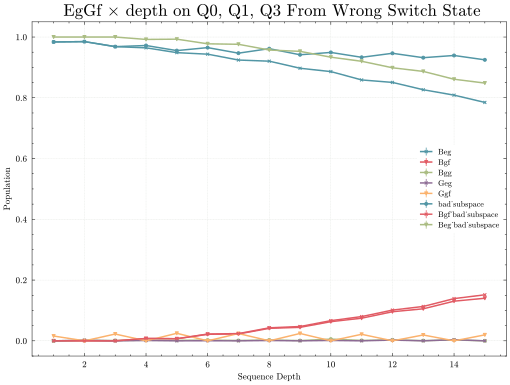

Saving S:\QRAM\qram_4QR2\data\data_250119\00028_leakage_EgGf_qubit31.h5


In [40]:
step_1 = 1
end_1 = 15
range1 = np.arange(1, end_1+step_1, step_1)
depths = range1
print('depths', len(depths))
print(depths)

for i_len in range(len(opt_lens)):
    rbprog = meas.EgGfLeakageExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"leakage_EgGf_qubit{qubits[0]}{qubits[1]}",
        config_file=config_path,
    )

    rbprog.cfg.device.qubit.f_EgGf_Q_half[qDrive] = opt_freqs[i_len]
    rbprog.cfg.device.qubit.pulses.pi_EgGf_Q.half_gain[qDrive] = opt_gains[i_len]
    rbprog.cfg.device.qubit.pulses.pi_EgGf_Q.half_sigma[qDrive] = opt_lens[i_len]

    print("Starting", i_len, "with len", opt_lens[i_len], "gain", opt_gains[i_len], "freq", opt_freqs[i_len])

    gate_char = None
    # gate_char = 'X'

    print("Will save to", rbprog.fname)

    rbprog.cfg.expt = dict(
        depths=depths,
        # reps=4000*10, # number averages per unique sequence need at least 10,000 for a good amount of error per point!!
        # reps_f=10000*10,
        reps=4000*5, # number averages per unique sequence need at least 10,000 for a good amount of error per point!!
        reps_f=6000*5,
        loops=6,
        # loops=1,
        gate_char=gate_char, # single qubit clifford gate (str) to characterize. if not None, runs interleaved RB instead of regular RB
        qubits=[0, 1, qDrive],
        qDrive=qDrive,
        singleshot_reps=30000, # reps per state for singleshot calibration
        # singleshot_reps=100, # reps per state for singleshot calibration
        # singleshot_reps_f=15000, # reps per state for singleshot calibration
        # singleshot_reps=20000, # reps per state for singleshot calibration
        post_process='threshold', # 'threshold' (uses single shot binning), 'scale' (scale by ge_avgs), or None

        test_leakage = True, # if true, does pi/pi instead of random sequence
        wrong_init = True, # if True, starts from wrong state. if False, starts from good state, does pi^N both cases
        # wrong_init = True, # if True, starts from wrong state. if False, starts from good state, does pi^N both cases

        measure_f_only=False,
        measure_f=[qDrive],

        add_phase=False,

        # cool_qubits=[0, 1],

        full_mux_expt=full_mux_expt,
        resonator_reset=resonator_reset,
        use_robust_pulses=True,

        validate_variations=False,

    )
    # rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i] = int(0.8*rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i])
    # rbprog.cfg.device.readout.relax_delay = 1
    # rbprog.cfg.device.readout.readout_length = 5

    print(rbprog.cfg)

    import Pyro4.util
    try:
        rbprog.acquire(progress=True, debug=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))

    # rbprog.go(analyze=False, display=False, progress=True, save=False)
    rbprog.analyze(fit=False)
    rbprog.display(fit=False, show_all_vars=False)
    saved_files.append(rbprog.save_data())

In [41]:
print("saved_files", saved_files)

saved_files ['S:\\QRAM\\qram_4QR2\\data\\data_250119\\00027_leakage_EgGf_qubit31.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00028_leakage_EgGf_qubit31.h5']


#### The longer swap

In [42]:
opt_freq_long = 5139.559416401934
opt_gain_long = 6789
opt_len_long = 0.15357097763287902

depths 30
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Starting 0 with len 0.067 gain 15683 freq 5126.940410545285
Will save to S:\QRAM\qram_4QR2\data\data_250119\00029_leakage_EgGf_qubit31.h5
{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-390.00045219204236, 5795.770150727347, 502.42095511476606, -228.8557536534039], 'gain': [0.6, 0.5, 0.5, 0.3], 'readout_length': [4.5, 16, 6.0, 10], 'frequency_ef': [-390.0004521920423, 5795.770150727347, 500.48386902205084, -230.30732892], 'gain_ef': [0.5, 0.5, 0.4, 0.25], 'readout_length_ef': [4.5, 16, 10, 8], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4108.755047003828, 4103.366954082312, 4108.649372291309, 4108.232503550693, 3442.591941352887, 3447.981518133789, 3446.872635941306, 3446.65966586083, 4760.911839134516, 4759.946893523059, 4761.052602755913, 4760.46101643607, 4377.996318964773, 4377.247239665757, 4377.995764386313, 4378.454058265707]

  0%|          | 0/3 [00:00<?, ?it/s]

Beginning loop 0


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.20300065557743 	 angle (deg): -143.98366452519744 	 threshold ge: 162.1614346810097
Qubit (1) ge
ge fidelity (%): 75.67666666666668 	 angle (deg): 40.7672064044309 	 threshold ge: 42.904714788889095
Qubit (3) ge
ge fidelity (%): 81.57317255019612 	 angle (deg): 4.222895670285841 	 threshold ge: 56.79740045221209
thresholds=[162.1614346810097, 42.904714788889095, 0, 56.79740045221209],
angles=[-143.98366452519744, 40.7672064044309, 0, 4.222895670285841],
ge_avgs=[array([-114.48118702,   28.25906442, -219.37792812,  104.516711  ]), array([ -1.58616321, -36.88736948,  27.9937233 , -62.39051268]), array([0., 0., 0., 0.]), array([30.86997702,  4.86309003, 83.23258638,  0.99678255])],
counts_calib=[[24079, 1278, 2345, 199, 1767, 82, 239, 11], [3382, 21337, 325, 2885, 232, 1508, 36, 295], [2541, 19619, 306, 4524, 170, 1620, 77, 1143], [3746, 195, 22753, 1204, 564, 21, 1447, 70], [588, 3989, 3282, 20024, 93, 453, 209, 1362], [435, 3626, 2478, 21218, 64, 436, 16

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.2833333333333
Qubit (1) ge
ge fidelity (%): 74.48999999999997
Qubit (3) gf
gf fidelity (%): 52.14224574152472
thresholds_f=[136.23413180311638, 39.86627207591286, 0, -56.289287857662515],
angles_f=[-141.47212212253035, 35.5731599149572, 0, 174.5161878231912],
gf_avgs=[array([-100.75367716,    9.91931037, -186.98216635,   78.57707559]), array([ -3.15706717, -39.37569456,  27.87333229, -61.56929929]), array([0., 0., 0., 0.]), array([ 75.79430068, -26.96362625,  48.40824695, -29.59279437])],
counts_calib_f=[[21039, 4193, 2199, 437, 1542, 311, 231, 48], [21242, 3722, 2488, 424, 1508, 252, 313, 51], [6440, 15582, 1456, 3146, 656, 1188, 872, 660], [3477, 627, 19674, 3848, 546, 113, 1412, 303], [3586, 647, 20091, 3350, 470, 86, 1533, 237], [1348, 2864, 6940, 16514, 240, 283, 620, 1191], [2444, 486, 225, 32, 20396, 3815, 2194, 408], [2470, 449, 285, 45, 19260, 3191, 3686, 614], [958, 1674, 209, 299, 6338, 14254, 1723, 4545], [625, 124, 1982, 327, 2989, 519, 198

  0%|          | 0/30 [00:00<?, ?it/s]

Beginning loop 1


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.5633333333333 	 angle (deg): -148.61057833045734 	 threshold ge: 159.61126340106603
Qubit (1) ge
ge fidelity (%): 74.22666666666665 	 angle (deg): 39.27585092005044 	 threshold ge: 42.05497778287503
Qubit (3) ge
ge fidelity (%): 81.0498303276776 	 angle (deg): 98.27510244692228 	 threshold ge: 57.2999949672613
thresholds=[159.61126340106603, 42.05497778287503, 0, 57.2999949672613],
angles=[-148.61057833045734, 39.27585092005044, 0, 98.27510244692228],
ge_avgs=[array([-114.93608985,   18.09892665, -225.58011085,   85.6082896 ]), array([ -0.47068007, -37.5800378 ,  29.05127413, -61.72270569]), array([0., 0., 0., 0.]), array([  3.00520926, -31.97198081,  -4.47493118, -83.40292717])],
counts_calib=[[23285, 1305, 3039, 226, 1815, 108, 207, 15], [3338, 20721, 406, 3259, 284, 1639, 36, 317], [2587, 20520, 346, 4209, 175, 1608, 23, 532], [3470, 215, 22678, 1383, 568, 19, 1577, 90], [568, 3611, 3333, 20157, 89, 472, 213, 1557], [401, 3757, 2479, 20916, 74, 479, 

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.7533333333333
Qubit (1) ge
ge fidelity (%): 78.642621420714
Qubit (3) gf
gf fidelity (%): 55.81233607786926
thresholds_f=[133.8683071145763, 40.58346284238558, 0, -55.83278907940327],
angles_f=[-145.57188081385252, 35.67689909926787, 0, -56.56178069529852],
gf_avgs=[array([-102.0722877 ,    2.23969334, -191.1482527 ,   63.29551266]), array([ -4.12511011, -38.84118154,  28.94803368, -62.58643213]), array([0., 0., 0., 0.]), array([-69.52609791, -41.71423305, -53.45065197, -17.36989044])],
counts_calib_f=[[21884, 3982, 1554, 289, 1772, 299, 179, 41], [21824, 3305, 2182, 340, 1774, 249, 285, 41], [6913, 17242, 1002, 2563, 611, 1187, 151, 331], [3200, 529, 20417, 3506, 525, 101, 1436, 286], [3961, 573, 20148, 2887, 549, 79, 1577, 226], [1365, 3031, 6994, 16214, 285, 294, 588, 1229], [2504, 472, 177, 39, 20964, 3702, 1807, 335], [2612, 389, 236, 39, 20098, 2977, 3184, 465], [1142, 1830, 149, 241, 6520, 14734, 1404, 3980], [663, 91, 2133, 363, 3078, 534, 19796

  0%|          | 0/30 [00:00<?, ?it/s]

Beginning loop 2


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.15311932619977 	 angle (deg): -153.52343906487192 	 threshold ge: 164.3484171659983
Qubit (1) ge
ge fidelity (%): 75.19333333333333 	 angle (deg): 39.0779260088894 	 threshold ge: 42.811038978707714
Qubit (3) ge
ge fidelity (%): 80.21666666666667 	 angle (deg): -82.78099894361569 	 threshold ge: 57.20476368981481
thresholds=[164.3484171659983, 42.811038978707714, 0, 57.20476368981481],
angles=[-153.52343906487192, 39.0779260088894, 0, -82.78099894361569],
ge_avgs=[array([-116.41788526,    9.30755082, -232.48472769,   67.11707103]), array([ -0.75160111, -37.33515502,  29.157213  , -61.62226195]), array([0., 0., 0., 0.]), array([-3.79823193, 31.45074142,  2.60785903, 82.02528371])],
counts_calib=[[23916, 1337, 2571, 220, 1640, 102, 203, 11], [3689, 21311, 287, 2547, 265, 1593, 33, 275], [2623, 21203, 320, 3727, 184, 1452, 31, 460], [3646, 231, 22802, 1231, 543, 27, 1432, 88], [611, 4215, 3600, 19500, 88, 439, 216, 1331], [487, 4182, 2624, 20525, 83, 467, 

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.55333333333334
Qubit (1) ge
ge fidelity (%): 76.8097651032812
Qubit (3) gf
gf fidelity (%): 54.965669855661844
thresholds_f=[135.3795065337281, 39.94396344355447, 0, -56.65717930201045],
angles_f=[-151.08979731081544, 33.97527218003401, 0, -50.87101873362856],
gf_avgs=[array([-101.1246273 ,   -6.04187407, -197.57110055,   47.22184966]), array([ -3.4506107 , -39.06356526,  28.97380299, -60.91375394]), array([0., 0., 0., 0.]), array([-72.8709697 , -34.90976988, -54.75795707, -12.6447327 ])],
counts_calib_f=[[21509, 4211, 1728, 338, 1681, 344, 158, 31], [21662, 3526, 2296, 379, 1591, 250, 258, 38], [6704, 17160, 1170, 2763, 595, 1098, 138, 372], [3458, 712, 19869, 3872, 458, 76, 1330, 225], [4172, 657, 20022, 3201, 418, 76, 1257, 197], [1537, 3158, 7019, 16091, 242, 270, 516, 1167], [2393, 459, 156, 27, 20872, 3778, 1940, 375], [2418, 374, 248, 34, 19837, 3103, 3451, 535], [1103, 2015, 156, 306, 6480, 14024, 1668, 4248], [636, 120, 1976, 379, 3279, 604, 19

  0%|          | 0/30 [00:00<?, ?it/s]

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.]


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Beg 0.08292273155257072
Bgf 0.06096521596885691
Bge 0.018427375805397665
Bgg 0.00660325435526507
Geg 0.6088540969897687
Ggf 0.04667733842677646
Ggg 0.0407335999313003
ggg 0.00660325435526507
gge 0.018427375805397665
ggf 0.06096521596885691
geg 0.08292273155257072
gee 0.0013338146755094771
gef 0.0009500682761672321
egg 0.0407335999313003
ege 0.10975548886758597
egf 0.04667733842677646
eeg 0.6088540969897687
eee 0.0197833536573333
eef 0.002993661493468247
bad_subspace 0.14388794752142764
Bgf_bad_subspace 0.4236992536138444
Beg_bad_subspace 0.5763007463861555


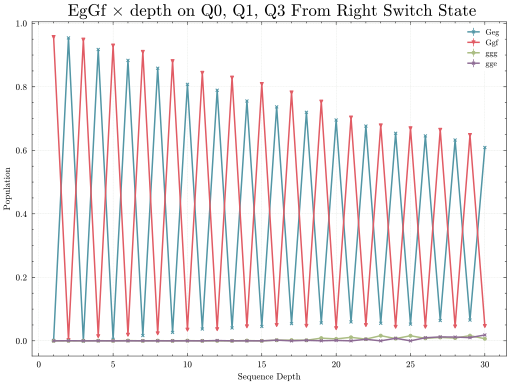

Saving S:\QRAM\qram_4QR2\data\data_250119\00029_leakage_EgGf_qubit31.h5


In [43]:
step_1 = 1
end_1 = 30
range1 = np.arange(1, end_1+step_1, step_1)
depths = range1
print('depths', len(depths))
print(depths)

for i_len in range(len(opt_lens)):
    rbprog = meas.EgGfLeakageExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"leakage_EgGf_qubit{qubits[0]}{qubits[1]}",
        config_file=config_path,
    )

    rbprog.cfg.device.qubit.f_EgGf_Q_half[qDrive] = opt_freq_long
    rbprog.cfg.device.qubit.pulses.pi_EgGf_Q.half_gain[qDrive] = opt_gain_long
    rbprog.cfg.device.qubit.pulses.pi_EgGf_Q.half_sigma[qDrive] = opt_len_long

    print("Starting", i_len, "with len", opt_lens[i_len], "gain", opt_gains[i_len], "freq", opt_freqs[i_len])

    gate_char = None
    # gate_char = 'X'

    print("Will save to", rbprog.fname)

    rbprog.cfg.expt = dict(
        depths=depths,
        # reps=4000*10, # number averages per unique sequence need at least 10,000 for a good amount of error per point!!
        # reps_f=10000*10,
        reps=4000*2, # number averages per unique sequence need at least 10,000 for a good amount of error per point!!
        reps_f=6000*2,
        loops=3,
        # loops=1,
        gate_char=gate_char, # single qubit clifford gate (str) to characterize. if not None, runs interleaved RB instead of regular RB
        qubits=[0, 1, qDrive],
        qDrive=qDrive,
        singleshot_reps=30000, # reps per state for singleshot calibration
        # singleshot_reps=100, # reps per state for singleshot calibration
        # singleshot_reps_f=15000, # reps per state for singleshot calibration
        # singleshot_reps=20000, # reps per state for singleshot calibration
        post_process='threshold', # 'threshold' (uses single shot binning), 'scale' (scale by ge_avgs), or None

        test_leakage = True, # if true, does pi/pi instead of random sequence
        wrong_init = False, # if True, starts from wrong state. if False, starts from good state, does pi^N both cases
        # wrong_init = True, # if True, starts from wrong state. if False, starts from good state, does pi^N both cases

        measure_f_only=False,
        measure_f=[qDrive],

        add_phase=False,

        # cool_qubits=[0, 1],

        full_mux_expt=full_mux_expt,
        resonator_reset=resonator_reset,
        use_robust_pulses=True,

        validate_variations=False,

    )
    # rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i] = int(0.8*rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i])
    # rbprog.cfg.device.readout.relax_delay = 1
    # rbprog.cfg.device.readout.readout_length = 5

    print(rbprog.cfg)

    import Pyro4.util
    try:
        rbprog.acquire(progress=True, debug=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))

    # rbprog.go(analyze=False, display=False, progress=True, save=False)
    rbprog.analyze(fit=False)
    rbprog.display(fit=False, show_all_vars=False)
    saved_files.append(rbprog.save_data())

### Q2/Q1

In [12]:
qubits = [2, 1]
qDrive = 2

# qubits = [3, 1]
# qDrive = 3

full_mux_expt = False
resonator_reset = [0, 2, 3] if full_mux_expt else None
use_robust_pulses = True

depths 5
[ 1  9 17 25 33]


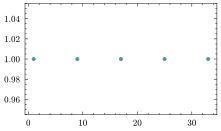

In [19]:
step_1 = 8
end_1 = 32

# step_1 = 1
# end_1 = 30

step_2 = 10
end_2 = 100
range1 = np.arange(1, end_1+step_1, step_1)
range2 = np.arange(range1[-1]+step_2, end_2+step_2, step_2)
# depths = np.concatenate((range1, range2))

depths = range1
# depths = np.arange(0, 50, step=1)

print('depths', len(depths))
print(depths)

plt.figure()
plt.plot(depths, np.ones_like(depths), 'o')
plt.show()

In [15]:
import yaml

print('Using config file', config_path)
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

Using config file s:\Connie\experiments\qram_tprocv1_expts\configs\config_q3diamond_full688and638_reset.yml


In [16]:
# opt_lens = [0.236859238200425, 0.22816247678777374, 0.21303094516365295, 0.20045736351450583, 0.18541736446454135]
# opt_gains =[11084.835919641577, 11642.864791295562, 12447.88429888123, 13171.519750068479, 14384.115652262572]
# opt_freqs =[5884.54545640695, 5884.391972661472, 5884.144471072403, 5883.815357941106, 5883.451086211165]

# opt_lens = [0.105, 0.090, 0.075]
# opt_gains = [16450, 19500, 24950]
# opt_freqs = [5877.45, 5874.5, 5869.3]

# opt_gains = [16450, 18300, 19500, 22000, 24950, 30900, 31500]
# opt_lens = [0.105, 0.095, 0.09, 0.083, 0.075, 0.065, 0.062]
# opt_freqs = [5877.45, 5875.6, 5874.5, 5872.0, 5869.3, 5863.9, 5859.0]

# opt_gains = np.array(opt_gains)[[1, 3, 6]]
# opt_lens = np.array(opt_lens)[[1, 3, 6]]
# opt_freqs = np.array(opt_freqs)[[1, 3, 6]]

# opt_lens =  [opt_lens[2]]
# opt_gains = [opt_gains[2]]
# opt_freqs = [opt_freqs[2]]

# opt_lens=[0.065]
# opt_gains=[30900]
# opt_freqs=[5863.9]

opt_freqs = [yaml_cfg.device.qubit.f_EgGf_Q_half[qDrive]]
opt_gains = [yaml_cfg.device.qubit.pulses.pi_EgGf_Q.half_gain[qDrive]]
opt_lens = [yaml_cfg.device.qubit.pulses.pi_EgGf_Q.half_sigma[qDrive]]

print("opt_lens =", opt_lens)
print("opt_gains =", opt_gains)
print("opt_freqs =", opt_freqs)


saved_files = []

opt_lens = [0.21303094516365295]
opt_gains = [9498]
opt_freqs = [5883.673102317987]


Starting 0 with len 0.21303094516365295 gain 9498 freq 5883.673102317987
Will save to S:\QRAM\qram_4QR2\data\data_250119\00043_leakage_EgGf_qubit21.h5
{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-390.00045219204236, 5795.770150727347, 502.42095511476606, -228.8557536534039], 'gain': [0.6, 0.8, 0.5, 0.3], 'readout_length': [4.5, 12, 8.0, 10], 'frequency_ef': [-390.0004521920423, 5795.770150727347, 500.48386902205084, -230.30732892], 'gain_ef': [0.5, 0.5, 0.6, 0.25], 'readout_length_ef': [4.5, 16, 8, 8], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4108.755047003828, 4103.366954082312, 4108.649372291309, 4108.232503550693, 3442.591941352887, 3447.981518133789, 3446.872635941306, 3446.65966586083, 4760.911839134516, 4759.946893523059, 4761.052602755913, 4760.46101643607, 4377.996318964773, 4377.247239665757, 4377.995764386313, 4378.454058265707], 'f_ef': [3882.6760964004225, 0.0, 3882.593023159515, 3882.5465667921762, 3345.3957364303,

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 0


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.34945494549453 	 angle (deg): -125.6982502799356 	 threshold ge: 154.0505035512139
Qubit (1) ge
ge fidelity (%): 74.37834083408342 	 angle (deg): 77.50436532935501 	 threshold ge: 81.80515723006981
Qubit (2) ge
ge fidelity (%): 80.87 	 angle (deg): -121.47348245872588 	 threshold ge: 29.592125587443846
thresholds=[154.0505035512139, 81.80515723006981, 29.592125587443846, 0],
angles=[-125.6982502799356, 77.50436532935501, -121.47348245872588, 0],
ge_avgs=[array([ -95.48109595,   60.80572164, -169.88455427,  164.35576331]), array([ 42.23947336, -52.33122496,  51.61501666, -94.63682124]), array([-47.45920659, -25.04706208, -76.40427518,  22.23610391]), array([0., 0., 0., 0.])],
counts_calib=[[7858, 641, 855, 78, 479, 36, 49, 4], [990, 7399, 96, 914, 62, 455, 11, 73], [449, 7521, 61, 1383, 24, 442, 5, 115], [1324, 114, 7180, 686, 146, 8, 494, 48], [122, 870, 807, 7504, 18, 105, 47, 527], [69, 847, 463, 8036, 3, 102, 23, 457], [885, 55, 59, 3, 7717, 663, 562

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.18899489948991
Qubit (1) ge
ge fidelity (%): 76.69934693469347
Qubit (2) gf
gf fidelity (%): 72.1476477647765
thresholds_f=[130.09316995271053, 38.629910815962816, -67.49013944942378, 0],
angles_f=[-120.72430139280783, 37.67152032070563, 81.97153191830874, 0],
gf_avgs=[array([ -89.92325579,   41.92487952, -146.90008488,  137.79214913]), array([ -3.99236114, -36.9324621 ,  27.04497477, -60.89620751]), array([-34.15956814,  97.71171221, -25.64085008,  37.31563784]), array([0., 0., 0., 0.])],
counts_calib_f=[[8299, 422, 642, 33, 536, 21, 45, 2], [7996, 417, 959, 57, 452, 28, 82, 9], [1930, 5772, 246, 1419, 105, 345, 32, 151], [1372, 86, 7561, 351, 166, 9, 442, 13], [1100, 68, 7658, 487, 127, 10, 517, 33], [269, 662, 1773, 6656, 29, 63, 116, 432], [859, 56, 68, 7, 7789, 417, 770, 34], [814, 50, 93, 11, 7034, 461, 1453, 84], [186, 656, 36, 164, 1619, 4758, 430, 2151], [232, 20, 622, 38, 947, 48, 7719, 374], [204, 26, 658, 74, 763, 67, 7600, 608], [44, 128, 1

  0%|          | 0/5 [00:00<?, ?it/s]

Beginning loop 1


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 85.24948794879485 	 angle (deg): -126.84710194157175 	 threshold ge: 162.77102344879697
Qubit (1) ge
ge fidelity (%): 75.65924792479251 	 angle (deg): 78.49380676224366 	 threshold ge: 85.86848938445348
Qubit (2) ge
ge fidelity (%): 80.83999999999997 	 angle (deg): -57.921431412385196 	 threshold ge: 29.341283150947902
thresholds=[162.77102344879697, 85.86848938445348, 29.341283150947902, 0],
angles=[-126.84710194157175, 78.49380676224366, -57.921431412385196, 0],
ge_avgs=[array([ -99.59552098,   59.33591158, -179.96188003,  166.57992236]), array([ 42.89240521, -53.94100109,  51.98070241, -98.58670676]), array([-44.56342478,  31.61248214, -14.71528845,  79.23404919]), array([0., 0., 0., 0.])],
counts_calib=[[8049, 669, 662, 87, 439, 43, 39, 12], [1003, 7850, 70, 549, 40, 420, 4, 64], [647, 8022, 36, 802, 35, 390, 4, 64], [1393, 101, 7315, 622, 137, 10, 393, 29], [161, 1233, 868, 7180, 21, 109, 38, 390], [129, 1099, 442, 7805, 12, 127, 19, 367], [815, 60, 7

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.33999999999996
Qubit (1) ge
ge fidelity (%): 72.67946894689467
Qubit (2) gf
gf fidelity (%): 73.54
thresholds_f=[133.8882176228363, 42.08483030544869, -67.37114383901884, 0],
angles_f=[-122.47704222967265, 38.71659335827976, 163.89671077052162, 0],
gf_avgs=[array([ -91.06298806,   39.78017641, -152.46777033,  136.25165796]), array([ -3.50637447, -36.77028714,  25.90542822, -60.34757268]), array([92.33520024, 44.37856595, 32.68547006, 27.1578463 ]), array([0., 0., 0., 0.])],
counts_calib_f=[[8424, 428, 530, 24, 539, 21, 32, 2], [8274, 432, 655, 35, 511, 21, 68, 4], [1852, 6281, 189, 1097, 113, 349, 26, 93], [1902, 74, 7091, 287, 163, 12, 456, 15], [1192, 94, 7596, 537, 112, 13, 422, 34], [324, 891, 1717, 6480, 45, 82, 130, 331], [891, 32, 49, 4, 8236, 265, 507, 16], [928, 79, 57, 1, 7442, 429, 1016, 48], [219, 735, 36, 125, 1781, 5329, 317, 1458], [255, 16, 578, 54, 1130, 91, 7430, 446], [186, 17, 598, 57, 1009, 96, 7546, 491], [59, 149, 149, 578, 256, 9

  0%|          | 0/5 [00:00<?, ?it/s]

Beginning loop 2


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.11999999999999 	 angle (deg): -128.40378598789746 	 threshold ge: 157.91612195696712
Qubit (1) ge
ge fidelity (%): 78.25999999999999 	 angle (deg): 78.20924297027325 	 threshold ge: 84.00085824083928
Qubit (2) ge
ge fidelity (%): 78.94000000000001 	 angle (deg): 155.5679198323023 	 threshold ge: 32.03172393674126
thresholds=[157.91612195696712, 84.00085824083928, 32.03172393674126, 0],
angles=[-128.40378598789746, 78.20924297027325, 155.5679198323023, 0],
ge_avgs=[array([-100.57254233,   57.31648155, -179.77270839,  157.22865912]), array([ 42.92269354, -53.00437122,  52.34735168, -98.15405   ]), array([ 19.14557811, -51.68942917, -30.37116461, -74.18465793]), array([0., 0., 0., 0.])],
counts_calib=[[8119, 616, 619, 76, 487, 26, 51, 6], [1220, 7357, 101, 725, 69, 460, 5, 63], [532, 7684, 69, 1148, 27, 439, 3, 98], [1187, 80, 7591, 542, 149, 8, 408, 35], [156, 1052, 887, 7296, 17, 133, 50, 409], [108, 932, 525, 7790, 12, 145, 27, 461], [896, 63, 59, 5, 78

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.97000000000001
Qubit (1) ge
ge fidelity (%): 73.84931593159315
Qubit (2) gf
gf fidelity (%): 74.84783978397842
thresholds_f=[134.4362679452899, 39.86221313654454, -68.79369627840103, 0],
angles_f=[-123.61016874162281, 39.91707898988369, -165.407314496295, 0],
gf_avgs=[array([ -93.58267931,   37.81209327, -154.51315832,  129.48453473]), array([ -3.11175263, -35.79281711,  26.08104535, -60.21657418]), array([104.42230285,  -7.81105797,  42.47369695,   8.31690041]), array([0., 0., 0., 0.])],
counts_calib_f=[[8344, 356, 660, 34, 527, 19, 60, 0], [7970, 474, 867, 65, 500, 28, 88, 8], [1741, 6082, 230, 1326, 110, 343, 27, 141], [1653, 80, 7208, 444, 131, 10, 450, 24], [1039, 75, 7855, 471, 106, 6, 425, 23], [261, 710, 1761, 6681, 21, 92, 115, 359], [973, 56, 71, 5, 7767, 397, 702, 29], [912, 66, 98, 4, 7084, 435, 1321, 80], [221, 724, 36, 142, 1592, 5037, 348, 1900], [246, 11, 697, 52, 934, 52, 7585, 423], [197, 10, 741, 42, 804, 53, 7714, 439], [56, 122, 184

  0%|          | 0/5 [00:00<?, ?it/s]

Beginning loop 3


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.69 	 angle (deg): -129.3672653725097 	 threshold ge: 160.38610354927582
Qubit (1) ge
ge fidelity (%): 77.53000000000003 	 angle (deg): 77.8278011871537 	 threshold ge: 83.8616146705201
Qubit (2) ge
ge fidelity (%): 80.72999999999999 	 angle (deg): 79.60126473974024 	 threshold ge: 29.965864665906665
thresholds=[160.38610354927582, 83.8616146705201, 29.965864665906665, 0],
angles=[-129.3672653725097, 77.8278011871537, 79.60126473974024, 0],
ge_avgs=[array([-102.43022315,   54.68120065, -183.97138994,  154.06675557]), array([ 42.87715239, -53.52183372,  52.54817805, -98.35741346]), array([ 54.29668356,   6.45636884,  64.37875765, -48.48336294]), array([0., 0., 0., 0.])],
counts_calib=[[7997, 696, 689, 90, 449, 33, 36, 10], [975, 7585, 76, 798, 54, 431, 7, 74], [508, 7572, 57, 1251, 25, 455, 5, 127], [1196, 102, 7488, 648, 127, 14, 390, 35], [217, 1148, 857, 7045, 20, 144, 59, 510], [94, 1022, 504, 7747, 4, 131, 27, 471], [891, 65, 45, 6, 7839, 616, 484, 5

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.60948994899489
Qubit (1) ge
ge fidelity (%): 74.67933293329334
Qubit (2) gf
gf fidelity (%): 72.92999999999999
thresholds_f=[137.23365547308128, 40.33371450048696, -66.6801260133676, 0],
angles_f=[-125.22614898529264, 40.01853681012665, -47.87857786228824, 0],
gf_avgs=[array([ -92.67690275,   35.60898097, -159.4064437 ,  130.11254016]), array([ -2.79416631, -35.70688039,  26.61875054, -60.40346842]), array([-54.44083877, -87.65951823, -13.51700431, -42.40224105]), array([0., 0., 0., 0.])],
counts_calib_f=[[8381, 413, 639, 40, 468, 13, 46, 0], [8253, 299, 907, 28, 412, 16, 79, 6], [1893, 6117, 215, 1237, 112, 288, 23, 115], [1609, 48, 7464, 211, 146, 5, 511, 6], [880, 35, 8242, 273, 97, 5, 444, 24], [282, 747, 1819, 6500, 35, 95, 136, 386], [906, 25, 76, 5, 7997, 190, 780, 21], [888, 43, 74, 6, 7297, 322, 1302, 68], [200, 698, 34, 121, 1681, 4953, 371, 1942], [241, 32, 702, 85, 950, 73, 7474, 443], [197, 14, 714, 39, 888, 39, 7771, 338], [56, 182, 191, 6

  0%|          | 0/5 [00:00<?, ?it/s]

Beginning loop 4


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 85.8 	 angle (deg): -131.2550020795605 	 threshold ge: 168.20228049544556
Qubit (1) ge
ge fidelity (%): 73.67904890489052 	 angle (deg): 78.37007419258987 	 threshold ge: 82.98010334974965
Qubit (2) ge
ge fidelity (%): 79.95 	 angle (deg): -37.63312116840127 	 threshold ge: 27.863962012859446
thresholds=[168.20228049544556, 82.98010334974965, 27.863962012859446, 0],
angles=[-131.2550020795605, 78.37007419258987, -37.63312116840127, 0],
ge_avgs=[array([-103.23185304,   52.441122  , -192.43705781,  154.1422508 ]), array([ 43.28707591, -53.6849006 ,  52.09651251, -96.48761804]), array([-31.12348153,  44.06958535,  12.16638116,  77.44715122]), array([0., 0., 0., 0.])],
counts_calib=[[7810, 699, 833, 102, 436, 37, 73, 10], [995, 7497, 116, 905, 47, 373, 6, 61], [488, 7622, 62, 1376, 26, 334, 3, 89], [1383, 117, 7279, 731, 111, 14, 337, 28], [137, 948, 876, 7222, 20, 125, 61, 611], [82, 890, 393, 7941, 13, 119, 21, 541], [720, 67, 75, 8, 7804, 664, 587, 75], [11

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.46999999999996
Qubit (1) ge
ge fidelity (%): 72.49
Qubit (2) gf
gf fidelity (%): 72.54761476147615
thresholds_f=[134.1349904070231, 39.01865419018081, -66.85432034988256, 0],
angles_f=[-126.01295914960183, 38.62006638969982, -122.4811787261377, 0],
gf_avgs=[array([ -93.3844259 ,   34.07796968, -159.79824124,  125.44527938]), array([ -3.51564553, -36.23541772,  25.44687302, -59.3725046 ]), array([ 70.10495386, -75.84551794,  37.31012522, -24.33061286]), array([0., 0., 0., 0.])],
counts_calib_f=[[8391, 362, 639, 28, 508, 18, 53, 1], [7886, 592, 869, 80, 440, 26, 102, 5], [1912, 5654, 298, 1522, 104, 327, 35, 148], [1781, 93, 7180, 324, 154, 4, 446, 18], [1062, 54, 7815, 368, 113, 5, 557, 26], [336, 795, 2089, 6101, 39, 104, 144, 392], [858, 33, 85, 1, 7902, 309, 785, 27], [871, 30, 100, 5, 7107, 264, 1555, 68], [176, 615, 50, 167, 1690, 4719, 478, 2105], [270, 16, 621, 58, 883, 64, 7706, 382], [197, 11, 689, 46, 888, 48, 7707, 414], [46, 133, 188, 576, 24

  0%|          | 0/5 [00:00<?, ?it/s]

Beginning loop 5


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.28940594059404 	 angle (deg): -132.25917205108934 	 threshold ge: 157.03740334088224
Qubit (1) ge
ge fidelity (%): 75.16916491649164 	 angle (deg): 77.4822440975543 	 threshold ge: 86.38851678556988
Qubit (2) ge
ge fidelity (%): 80.19932393239326 	 angle (deg): -51.941044581437325 	 threshold ge: 30.63521806981646
thresholds=[157.03740334088224, 86.38851678556988, 30.63521806981646, 0],
angles=[-132.25917205108934, 77.4822440975543, -51.941044581437325, 0],
ge_avgs=[array([-102.83631469,   49.21780297, -191.99028813,  147.33710897]), array([ 42.91629894, -54.13133852,  52.69899607, -98.19360893]), array([-40.06484874,  35.74965386,  -6.30326871,  78.87097465]), array([0., 0., 0., 0.])],
counts_calib=[[7931, 613, 755, 77, 523, 32, 55, 14], [1109, 7501, 75, 725, 56, 455, 8, 71], [540, 7591, 50, 1202, 29, 482, 6, 100], [1331, 87, 7120, 584, 168, 16, 629, 65], [167, 1075, 810, 5906, 54, 387, 197, 1404], [93, 1121, 373, 6838, 20, 296, 65, 1194], [828, 56, 73

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.51942794279428
Qubit (1) ge
ge fidelity (%): 74.79935093509353
Qubit (2) gf
gf fidelity (%): 74.21789378937896
thresholds_f=[135.7467261995555, 40.21964173285955, -69.06940499606175, 0],
angles_f=[-127.42581851449896, 37.6812198514956, 87.180802189313, 0],
gf_avgs=[array([ -94.80343126,   32.09305203, -163.91895014,  122.40802315]), array([ -3.19058576, -36.44328958,  27.26993282, -59.96990942]), array([-23.13559451, 100.77284406, -20.02714902,  37.64954984]), array([0., 0., 0., 0.])],
counts_calib_f=[[8301, 454, 605, 47, 512, 24, 54, 3], [7894, 715, 800, 67, 427, 30, 61, 6], [1715, 6249, 236, 1287, 89, 300, 27, 97], [1528, 140, 7214, 502, 147, 11, 431, 27], [1146, 107, 7571, 656, 104, 4, 380, 32], [314, 986, 1843, 6245, 29, 97, 124, 362], [851, 40, 62, 7, 8049, 324, 643, 24], [861, 95, 105, 14, 7099, 504, 1229, 93], [208, 636, 42, 162, 1615, 4966, 392, 1979], [273, 13, 651, 45, 940, 41, 7680, 357], [211, 12, 705, 43, 946, 58, 7607, 418], [45, 147, 166,

  0%|          | 0/5 [00:00<?, ?it/s]

Beginning loop 6


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.66940194019402 	 angle (deg): -133.2041326116997 	 threshold ge: 162.27411404624203
Qubit (1) ge
ge fidelity (%): 70.51999999999998 	 angle (deg): 78.12917243783996 	 threshold ge: 81.10846392554639
Qubit (2) ge
ge fidelity (%): 79.51999999999998 	 angle (deg): -146.78275298351934 	 threshold ge: 31.853002397170634
thresholds=[162.27411404624203, 81.10846392554639, 31.853002397170634, 0],
angles=[-133.2041326116997, 78.12917243783996, -146.78275298351934, 0],
ge_avgs=[array([-105.37060818,   48.51410311, -193.09304754,  141.91551179]), array([ 43.61168616, -52.67143464,  51.82809916, -91.75973375]), array([-33.91316318, -43.19841697, -79.4632    , -13.37172148]), array([0., 0., 0., 0.])],
counts_calib=[[7816, 606, 856, 104, 493, 41, 76, 8], [1082, 7088, 136, 1082, 70, 435, 7, 100], [598, 7258, 85, 1429, 43, 442, 4, 141], [1518, 106, 6366, 524, 269, 17, 1118, 82], [166, 867, 956, 7416, 14, 119, 50, 412], [83, 793, 504, 7997, 4, 116, 25, 478], [866, 59, 9

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.53947394739477
Qubit (1) ge
ge fidelity (%): 74.97935093509346
Qubit (2) gf
gf fidelity (%): 75.1279457945795
thresholds_f=[135.01818915757607, 38.79950660745222, -71.71872793514292, 0],
angles_f=[-128.4349361685269, 36.68941400662136, 53.813562585298115, 0],
gf_avgs=[array([ -95.4879869 ,   29.17970384, -163.64673437,  115.06700695]), array([ -3.66279054, -36.98031272,  26.99832045, -59.82558938]), array([-76.36942665,  72.37508426, -38.55612217,  20.68408645]), array([0., 0., 0., 0.])],
counts_calib_f=[[8349, 436, 622, 45, 478, 21, 48, 1], [7913, 567, 909, 68, 420, 31, 85, 7], [1613, 5983, 245, 1584, 101, 292, 45, 137], [1552, 122, 7232, 545, 125, 10, 378, 36], [1014, 95, 7719, 629, 96, 12, 406, 29], [279, 933, 1561, 6691, 28, 77, 87, 344], [805, 126, 66, 6, 7382, 737, 799, 79], [792, 145, 88, 21, 6630, 852, 1313, 159], [146, 702, 26, 176, 1409, 5080, 336, 2125], [242, 40, 678, 180, 914, 130, 7006, 810], [200, 14, 696, 77, 801, 65, 7509, 638], [55, 16

  0%|          | 0/5 [00:00<?, ?it/s]

Beginning loop 7


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.48936593659364 	 angle (deg): -134.03721214825026 	 threshold ge: 161.28741408220984
Qubit (1) ge
ge fidelity (%): 73.87000000000002 	 angle (deg): 77.35462706675355 	 threshold ge: 82.22567935536775
Qubit (2) ge
ge fidelity (%): 79.52 	 angle (deg): 113.23889626071438 	 threshold ge: 29.407007651758093
thresholds=[161.28741408220984, 82.22567935536775, 29.407007651758093, 0],
angles=[-134.03721214825026, 77.35462706675355, 113.23889626071438, 0],
ge_avgs=[array([-108.39158256,   46.19480311, -198.20278712,  139.07623039]), array([ 43.47191544, -52.93875646,  52.65422013, -93.86575895]), array([ 48.36933108, -24.47501054,  27.05696098, -74.10741363]), array([0., 0., 0., 0.])],
counts_calib=[[7819, 672, 776, 80, 491, 53, 90, 19], [1036, 7299, 113, 906, 69, 485, 13, 79], [514, 7429, 56, 1405, 31, 438, 5, 122], [1349, 121, 6973, 620, 173, 12, 687, 65], [156, 999, 875, 7064, 24, 127, 96, 659], [65, 990, 451, 7617, 13, 168, 33, 663], [758, 60, 77, 14, 7796, 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.16999999999999
Qubit (1) ge
ge fidelity (%): 70.06921192119214
Qubit (2) gf
gf fidelity (%): 72.27759975997601
thresholds_f=[137.4460104184512, 39.91701261425515, -65.21563593682954, 0],
angles_f=[-130.55408929212788, 39.136912880319734, 7.868871909243562, 0],
gf_avgs=[array([ -95.93205904,   28.66701932, -168.12211852,  113.02932135]), array([ -1.46352106, -34.91989845,  25.66271721, -56.99382765]), array([-102.62707722,   -4.79864089,  -42.81601237,  -13.06499418]), array([0., 0., 0., 0.])],
counts_calib_f=[[8240, 363, 755, 30, 508, 32, 69, 3], [8016, 327, 1011, 44, 470, 16, 107, 9], [1941, 5753, 264, 1484, 114, 284, 35, 125], [1814, 170, 6995, 445, 147, 8, 404, 17], [1169, 64, 7819, 412, 116, 5, 397, 18], [339, 712, 2266, 6021, 38, 99, 176, 349], [837, 40, 91, 5, 7959, 254, 784, 30], [805, 60, 104, 10, 7148, 346, 1447, 80], [194, 700, 40, 157, 1682, 5001, 403, 1823], [310, 25, 647, 81, 1131, 64, 7416, 326], [214, 15, 743, 43, 1047, 64, 7539, 335], [5

  0%|          | 0/5 [00:00<?, ?it/s]

Beginning loop 8


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 85.49000000000001 	 angle (deg): -135.88202087877872 	 threshold ge: 162.64896503327446
Qubit (1) ge
ge fidelity (%): 73.58919891989198 	 angle (deg): 77.7888094908311 	 threshold ge: 83.00709354570475
Qubit (2) ge
ge fidelity (%): 81.50928792879286 	 angle (deg): 37.100717674670534 	 threshold ge: 30.397432965372424
thresholds=[162.64896503327446, 83.00709354570475, 30.397432965372424, 0],
angles=[-135.88202087877872, 77.7888094908311, 37.100717674670534, 0],
ge_avgs=[array([-107.28799674,   41.92440456, -201.90592938,  133.67315051]), array([ 43.22744666, -52.54512287,  52.36936736, -94.78823489]), array([34.58027726, 39.34174406, 78.91889203,  5.80784003]), array([0., 0., 0., 0.])],
counts_calib=[[7990, 632, 736, 82, 468, 30, 50, 12], [941, 7532, 94, 868, 51, 432, 10, 72], [514, 7524, 64, 1333, 23, 420, 1, 121], [1501, 108, 7041, 609, 154, 18, 521, 48], [222, 1235, 897, 6673, 18, 172, 88, 695], [92, 1017, 457, 7650, 13, 131, 28, 612], [760, 61, 71, 6, 7

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.89947594759474
Qubit (1) ge
ge fidelity (%): 68.77999999999997
Qubit (2) gf
gf fidelity (%): 75.05999999999999
thresholds_f=[139.0193558129852, 37.06786449066758, -68.85806743389759, 0],
angles_f=[-131.54372406994435, 36.13651824587074, -44.12834404044227, 0],
gf_avgs=[array([ -96.31282352,   25.81438292, -170.7339364 ,  109.80291093]), array([ -3.64966633, -37.91804262,  24.63421622, -58.57063042]), array([-61.72400749, -85.19213039, -16.13581957, -40.97035085]), array([0., 0., 0., 0.])],
counts_calib_f=[[8242, 335, 853, 33, 452, 23, 58, 4], [7804, 461, 1088, 79, 420, 26, 114, 8], [1680, 5730, 318, 1745, 99, 258, 24, 146], [1969, 89, 7060, 339, 135, 8, 382, 18], [1185, 95, 7675, 511, 101, 5, 400, 28], [257, 639, 1815, 6702, 23, 73, 123, 368], [817, 57, 95, 5, 7560, 367, 1046, 53], [786, 52, 109, 5, 6818, 323, 1795, 112], [170, 592, 45, 175, 1621, 4344, 562, 2491], [278, 26, 652, 67, 914, 63, 7567, 433], [195, 18, 755, 64, 811, 51, 7581, 525], [48, 171,

  0%|          | 0/5 [00:00<?, ?it/s]

Beginning loop 9


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.28945594559454 	 angle (deg): -137.70179226261862 	 threshold ge: 165.74138107839718
Qubit (1) ge
ge fidelity (%): 72.80897489748973 	 angle (deg): 77.38151829127479 	 threshold ge: 83.5799399213637
Qubit (2) ge
ge fidelity (%): 80.54000000000002 	 angle (deg): -117.25040744527062 	 threshold ge: 33.14088549832957
thresholds=[165.74138107839718, 83.5799399213637, 33.14088549832957, 0],
angles=[-137.70179226261862, 77.38151829127479, -117.25040744527062, 0],
ge_avgs=[array([-108.94084038,   41.46166071, -204.05724783,  128.00549356]), array([ 43.33473494, -53.96184476,  52.74412075, -95.9933271 ]), array([-50.91094748, -20.37953295, -76.71058247,  29.71267868]), array([0., 0., 0., 0.])],
counts_calib=[[7803, 594, 956, 93, 470, 34, 45, 5], [1071, 7440, 78, 851, 65, 434, 8, 53], [630, 7532, 66, 1244, 27, 420, 5, 76], [1407, 91, 7441, 535, 120, 12, 368, 26], [254, 1157, 1016, 7031, 15, 110, 58, 359], [117, 1021, 537, 7762, 11, 141, 23, 388], [873, 65, 72, 8

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.35946894689471
Qubit (1) ge
ge fidelity (%): 69.34
Qubit (2) gf
gf fidelity (%): 74.71802080208023
thresholds_f=[131.34885979721136, 39.802512049015235, -70.35268922338157, 0],
angles_f=[-133.36746263736526, 38.093851641900834, 66.23706645134156, 0],
gf_avgs=[array([ -94.70977135,   22.89134595, -171.34244674,  104.02036621]), array([ -3.07297967, -36.376232  ,  24.69721416, -58.14603365]), array([-57.9413893 ,  84.98103902, -32.76359357,  27.79516631]), array([0., 0., 0., 0.])],
counts_calib_f=[[8260, 529, 611, 46, 467, 32, 54, 1], [7853, 796, 709, 68, 456, 42, 69, 7], [1612, 6314, 199, 1334, 84, 319, 32, 106], [2035, 170, 6641, 549, 145, 8, 427, 25], [1154, 102, 7507, 629, 121, 12, 442, 33], [270, 753, 1633, 6711, 33, 90, 117, 393], [888, 77, 54, 5, 7712, 512, 712, 40], [925, 86, 81, 4, 7051, 482, 1276, 95], [205, 692, 52, 168, 1570, 4802, 446, 2065], [277, 28, 622, 66, 987, 107, 7298, 615], [177, 28, 657, 116, 796, 115, 7366, 745], [49, 171, 172, 608

  0%|          | 0/5 [00:00<?, ?it/s]

[ 1.  9. 17. 25. 33.]


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[ 1  9 17 25 33]
Beg 0.013490320457032195
Bgf -7.244680719721702e-17
Bge -7.444088975720626e-17
Bgg 1.4699399571867692e-05
Geg 0.09487897959156162
Ggf 0.45478191296830117
Ggg 0.12633910127030867
ggg 0.12633910127030867
gge 0.28937492327583
ggf 0.45478191296830117
geg 0.09487897959156162
gee 0.021120063037394797
gef -8.374450413364947e-18
egg 1.4699399571867692e-05
ege -7.444088975720626e-17
egf -7.244680719721702e-17
eeg 0.013490320457032195
eee 1.781765549722279e-17
eef 1.9294878520377072e-17
bad_subspace 0.013490320457032122
Bgf_bad_subspace -5.370280671090549e-15
Beg_bad_subspace 1.0000000000000053


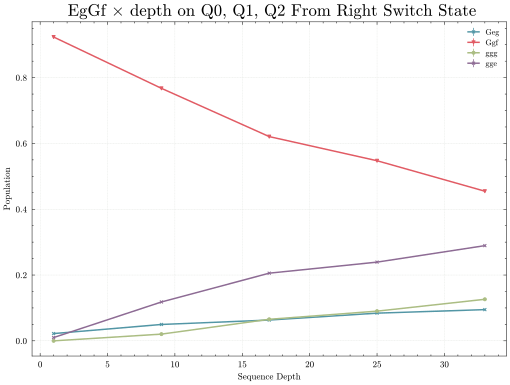

Saving S:\QRAM\qram_4QR2\data\data_250119\00043_leakage_EgGf_qubit21.h5


In [18]:
for i_len in range(len(opt_lens)):
    rbprog = meas.EgGfLeakageExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"leakage_EgGf_qubit{qubits[0]}{qubits[1]}",
        config_file=config_path,
    )

    rbprog.cfg.device.qubit.f_EgGf_Q_half[qDrive] = opt_freqs[i_len]
    rbprog.cfg.device.qubit.pulses.pi_EgGf_Q.half_gain[qDrive] = opt_gains[i_len]
    rbprog.cfg.device.qubit.pulses.pi_EgGf_Q.half_sigma[qDrive] = opt_lens[i_len]

    print("Starting", i_len, "with len", opt_lens[i_len], "gain", opt_gains[i_len], "freq", opt_freqs[i_len])

    gate_char = None
    # gate_char = 'X'

    print("Will save to", rbprog.fname)

    rbprog.cfg.expt = dict(
        depths=depths,
        # reps=4000*10, # number averages per unique sequence need at least 10,000 for a good amount of error per point!!
        # reps_f=10000*10,
        # loops=5,
        reps=4000*2, # number averages per unique sequence need at least 10,000 for a good amount of error per point!!
        reps_f=6000*2,
        loops=10,
        # reps=4000, # number averages per unique sequence need at least 10,000 for a good amount of error per point!!
        # reps_f=6000,
        # loops=1,
        gate_char=gate_char, # single qubit clifford gate (str) to characterize. if not None, runs interleaved RB instead of regular RB
        qubits=[0, 1, qDrive],
        qDrive=qDrive,
        # singleshot_reps=30000, # reps per state for singleshot calibration
        # singleshot_reps_f=15000, # reps per state for singleshot calibration
        singleshot_reps=10000, # reps per state for singleshot calibration
        post_process='threshold', # 'threshold' (uses single shot binning), 'scale' (scale by ge_avgs), or None

        test_leakage = True, # if true, does pi/pi instead of random sequence
        # wrong_init = False, # if True, starts from wrong state. if False, starts from good state, does pi^N both cases
        wrong_init = False, # if True, starts from wrong switch state. if False, starts from good switch state, does pi^N both cases
        # ground_state_init = True, # if True, in/out are initialized in gg

        measure_f_only=False,
        measure_f=[qDrive],

        add_phase=False,

        # cool_qubits=[0, 1],

        full_mux_expt=full_mux_expt,
        resonator_reset=resonator_reset,
        use_robust_pulses=True,

        validate_variations=False,

    )
    # rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i] = int(0.8*rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i])
    # rbprog.cfg.device.readout.relax_delay = 1
    # rbprog.cfg.device.readout.readout_length = 5

    print(rbprog.cfg)

    import Pyro4.util
    try:
        rbprog.acquire(progress=True, debug=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))

    # rbprog.go(analyze=False, display=False, progress=True, save=False)
    rbprog.analyze(fit=False)
    rbprog.display(fit=False, show_all_vars=False)
    saved_files.append(rbprog.save_data())

In [ ]:
print("saved_files", saved_files)

In [42]:
# TESTING
rbprog = meas.EgGfLeakageExperiment(config_file=config_path)
temp_data, attrs = prev_data("S:\QRAM\qram_4QR2\data\data_250119\\00041_leakage_EgGf_qubit21.h5")
rbprog.data = temp_data
rbprog.cfg = AttrDict(attrs['config'])
print(rbprog.cfg.device.qubit.pulses.pi_EgGf_Q.half_sigma)
rbprog.calib_order = attrs['calib_order']

rbprog.analyze(fit=False)

S:\QRAM\qram_4QR2\data\data_250119\00041_leakage_EgGf_qubit21.h5
Extracted data and attrs ['calib_order', 'config']
[0, 0, 0.21303094516365295, 0.067]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.]


 C:\Users\slab\AppData\Local\Temp\ipykernel_3992\1939458940.py: 13

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

{'angles_f_loops': array([[-11.08922906,  38.53340697, -77.01682601,   0.        ],
        [-16.84139021,  38.40128895, -19.75322452,   0.        ],
        [-21.70102181,  35.88260683, 174.78963094,   0.        ],
        [-26.83707463,  36.37104671, -79.50667781,   0.        ],
        [-32.76945001,  36.52217343, -19.14212975,   0.        ]]),
 'angles_loops': array([[-13.29824725,  38.777144  , -35.02498193,   0.        ],
        [-20.34023624,  38.9680576 , -13.96629106,   0.        ],
        [-24.44221096,  41.98206516, 160.12341463,   0.        ],
        [-29.49316006,  39.50065448,  59.39376045,   0.        ],
        [-34.65949525,  39.60309696, 123.74822726,   0.        ]]),
 'counts_calib_f_loops': array([[[19812,  5871,  1773,   510,  1349,   425,   198,    62],
         [17388,  7553,  2229,   922,  1043,   433,   308,   124],
         [ 9167, 14683,  1436,  2703,   582,   863,   211,   355],
         [ 4127,  1526, 16627,  5632,   371,   123,  1219,   375],
         [

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Beg 0.0022756220204122137
Bgf -5.202553586327966e-17
Bge -8.417018989969417e-18
Bgg 2.5859958067007913e-18
Geg 0.2893867404596126
Ggf 0.295555348577961
Ggg 0.20334457727964397
ggg 0.20334457727964397
gge 0.1986431943399941
ggf 0.295555348577961
geg 0.2893867404596126
gee 0.010025504849140771
gef 0.0007690124732353774
egg 2.5859958067007913e-18
ege -8.417018989969417e-18
egf -5.202553586327966e-17
eeg 0.0022756220204122137
eee -3.4196594482063686e-18
eef -1.7000132560084493e-17
bad_subspace 0.0022756220204121617
good_subspace 0.5849420890375736
Bgf_bad_subspace -2.2862116553897985e-14
Beg_bad_subspace 1.0000000000000229
Ggf_good_subspace 0.5052728366054987
Geg_good_subspace 0.4947271633945013


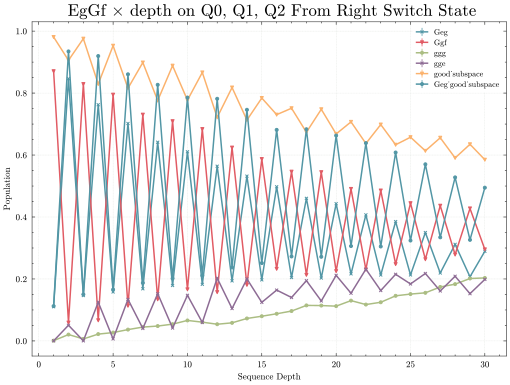

In [43]:
rbprog.display(fit=False, show_all_vars=False)

#### The shorter swap

In [20]:
opt_freq_short = 5875.6955689259175
opt_gain_short = 23435
opt_len_short = 0.095

depths 5
[ 1  9 17 25 33]
Starting 0 with len 0.21303094516365295 gain 9498 freq 5883.673102317987
Will save to S:\QRAM\qram_4QR2\data\data_250119\00044_leakage_EgGf_qubit21.h5
{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-390.00045219204236, 5795.770150727347, 502.42095511476606, -228.8557536534039], 'gain': [0.6, 0.8, 0.5, 0.3], 'readout_length': [4.5, 12, 8.0, 10], 'frequency_ef': [-390.0004521920423, 5795.770150727347, 500.48386902205084, -230.30732892], 'gain_ef': [0.5, 0.5, 0.6, 0.25], 'readout_length_ef': [4.5, 16, 8, 8], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4108.755047003828, 4103.366954082312, 4108.649372291309, 4108.232503550693, 3442.591941352887, 3447.981518133789, 3446.872635941306, 3446.65966586083, 4760.911839134516, 4759.946893523059, 4761.052602755913, 4760.46101643607, 4377.996318964773, 4377.247239665757, 4377.995764386313, 4378.454058265707], 'f_ef': [3882.6760964004225, 0.0, 3882.593023159515, 3882.54656

  0%|          | 0/10 [00:00<?, ?it/s]

Beginning loop 0


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.22999999999998 	 angle (deg): -146.9002074289878 	 threshold ge: 167.8280717572239
Qubit (1) ge
ge fidelity (%): 76.08919591959202 	 angle (deg): 75.740930046252 	 threshold ge: 82.1712463522501
Qubit (2) ge
ge fidelity (%): 80.25927492749277 	 angle (deg): -136.10230079214685 	 threshold ge: 32.41081554642344
thresholds=[167.8280717572239, 82.1712463522501, 32.41081554642344, 0],
angles=[-146.9002074289878, 75.740930046252, -136.10230079214685, 0],
ge_avgs=[array([-113.13261795,   20.67038813, -223.00934378,   92.29755774]), array([ 42.74698996, -50.33269835,  53.92716687, -94.32555922]), array([-39.63818458, -32.22759276, -78.88946526,   5.5417229 ]), array([0., 0., 0., 0.])],
counts_calib=[[7945, 631, 629, 88, 517, 43, 119, 28], [1026, 7453, 88, 777, 69, 431, 14, 142], [463, 7532, 54, 1351, 20, 428, 9, 143], [1247, 111, 7298, 598, 161, 13, 525, 47], [178, 979, 881, 7312, 19, 111, 62, 458], [172, 1034, 538, 7620, 16, 139, 29, 452], [919, 77, 79, 7, 70

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.74936293629362
Qubit (1) ge
ge fidelity (%): 72.53938493849384
Qubit (2) gf
gf fidelity (%): 72.23768276827684
thresholds_f=[135.91245454112448, 41.515506114835375, -66.40348888232046, 0],
angles_f=[-142.80863705205758, 38.82499805709341, 63.49463492958547, 0],
gf_avgs=[array([-100.35367894,    6.3343267 , -187.82442113,   72.7074534 ]), array([ -2.01681235, -35.74755436,  27.15664698, -59.22458179]), array([-63.75275639,  78.72104605, -36.94557514,  24.96676424]), array([0., 0., 0., 0.])],
counts_calib_f=[[8293, 485, 538, 22, 534, 17, 106, 5], [7951, 661, 732, 38, 414, 37, 154, 13], [1885, 5943, 234, 1341, 84, 265, 70, 178], [1859, 66, 7227, 268, 146, 5, 413, 16], [1162, 142, 7387, 753, 98, 11, 411, 36], [348, 841, 1845, 6352, 36, 87, 142, 349], [969, 46, 59, 1, 7497, 307, 1086, 35], [880, 66, 90, 12, 5973, 446, 2347, 186], [185, 724, 30, 126, 1627, 5031, 413, 1864], [285, 26, 693, 70, 1014, 63, 7418, 431], [232, 24, 934, 93, 795, 70, 7358, 494], [69, 

  0%|          | 0/5 [00:00<?, ?it/s]

Beginning loop 1


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 85.13999999999999 	 angle (deg): -148.0066064660024 	 threshold ge: 163.11760178018503
Qubit (1) ge
ge fidelity (%): 73.89999999999999 	 angle (deg): 76.14231964792164 	 threshold ge: 83.20505842034152
Qubit (2) ge
ge fidelity (%): 79.57000000000001 	 angle (deg): -162.2860436273233 	 threshold ge: 34.260892666438
thresholds=[163.11760178018503, 83.20505842034152, 34.260892666438, 0],
angles=[-148.0066064660024, 76.14231964792164, -162.2860436273233, 0],
ge_avgs=[array([-114.07408271,   15.31482192, -225.37293307,   84.84421954]), array([ 42.96122309, -51.21814148,  53.4728487 , -93.82858966]), array([-21.59106184, -48.51805325, -73.33053792, -31.99199251]), array([0., 0., 0., 0.])],
counts_calib=[[8148, 509, 740, 69, 443, 32, 54, 5], [1254, 7254, 101, 819, 61, 408, 14, 89], [661, 7455, 76, 1264, 29, 410, 9, 96], [1474, 101, 7268, 483, 157, 17, 464, 36], [148, 923, 969, 7276, 24, 116, 64, 480], [114, 901, 584, 7898, 8, 96, 23, 376], [819, 52, 79, 7, 7284, 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.55948394839481
Qubit (1) ge
ge fidelity (%): 74.25821482148214
Qubit (2) gf
gf fidelity (%): 74.79
thresholds_f=[132.66613923962987, 39.20563654663283, -71.88380186183618, 0],
angles_f=[-142.8639215980282, 36.84044437881849, -85.75112721529356, 0],
gf_avgs=[array([-100.68082366,    1.47678538, -189.42637041,   68.68240239]), array([ -2.65875534, -37.2979579 ,  27.71658962, -60.05507815]), array([   9.41286737, -103.56374081,   14.07565793,  -40.80160789]), array([0., 0., 0., 0.])],
counts_calib_f=[[8211, 475, 745, 37, 435, 29, 65, 3], [7743, 745, 906, 74, 414, 35, 73, 10], [1663, 6315, 223, 1263, 83, 316, 26, 111], [1465, 134, 7253, 594, 126, 6, 397, 25], [1028, 86, 7487, 637, 108, 11, 603, 40], [260, 773, 1796, 6223, 50, 106, 212, 580], [844, 83, 83, 7, 7661, 498, 781, 43], [853, 105, 123, 14, 6749, 665, 1386, 105], [210, 818, 51, 213, 1467, 5129, 370, 1742], [207, 38, 653, 89, 913, 72, 7396, 632], [192, 22, 725, 89, 814, 94, 7395, 669], [56, 144, 176,

  0%|          | 0/5 [00:00<?, ?it/s]

Beginning loop 2


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 79.0 	 angle (deg): -148.7476968216937 	 threshold ge: 167.60556256558957
Qubit (1) ge
ge fidelity (%): 73.97999999999998 	 angle (deg): 76.07651255561053 	 threshold ge: 82.60669616939158
Qubit (2) ge
ge fidelity (%): 79.43 	 angle (deg): -83.56383513844833 	 threshold ge: 29.60288543614658
thresholds=[167.60556256558957, 82.60669616939158, 29.60288543614658, 0],
angles=[-148.7476968216937, 76.07651255561053, -83.56383513844833, 0],
ge_avgs=[array([-120.82547721,   15.990361  , -225.62896346,   79.59244197]), array([ 43.28262965, -52.0110306 ,  53.81091373, -94.47918985]), array([-54.02977189,  10.2517797 , -47.98065386,  63.87531123]), array([0., 0., 0., 0.])],
counts_calib=[[7575, 641, 660, 98, 675, 66, 228, 57], [1062, 7339, 76, 820, 66, 433, 15, 189], [484, 7429, 53, 1251, 32, 494, 13, 244], [1302, 111, 7293, 628, 135, 17, 456, 58], [188, 1126, 874, 7203, 23, 106, 41, 439], [70, 941, 476, 7711, 8, 140, 27, 627], [951, 51, 66, 10, 7720, 548, 597, 57], 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 78.7890499049905
Qubit (1) ge
ge fidelity (%): 65.14999999999998
Qubit (2) gf
gf fidelity (%): 73.08999999999999
thresholds_f=[136.61521701987095, 41.25906562916558, -70.84184756603048, 0],
angles_f=[-143.3077299428508, 37.43637580156853, -159.46776751993875, 0],
gf_avgs=[array([-106.40835644,    2.51773329, -187.410889  ,   62.87816208]), array([  0.69457856, -39.75032039,  27.09285683, -59.95989754]), array([101.63088328, -19.94355382,  44.45551615,   1.47010875]), array([0., 0., 0., 0.])],
counts_calib_f=[[7445, 446, 1071, 55, 596, 33, 336, 18], [7143, 842, 1086, 123, 478, 52, 253, 23], [1731, 5985, 259, 1242, 96, 423, 69, 195], [1748, 105, 6928, 403, 154, 10, 621, 31], [1026, 78, 7250, 602, 176, 10, 806, 52], [337, 826, 2026, 5902, 46, 127, 231, 505], [842, 208, 81, 12, 7418, 858, 531, 50], [751, 84, 133, 14, 7296, 516, 1106, 100], [190, 662, 48, 136, 1650, 5375, 346, 1593], [280, 29, 743, 69, 1037, 79, 7198, 565], [256, 17, 800, 100, 960, 89, 7162, 61

  0%|          | 0/5 [00:00<?, ?it/s]

Beginning loop 3


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.81940594059408 	 angle (deg): -150.4622560744646 	 threshold ge: 162.04752580750878
Qubit (1) ge
ge fidelity (%): 76.85922092209219 	 angle (deg): 77.0397603474339 	 threshold ge: 80.86259112399637
Qubit (2) ge
ge fidelity (%): 80.32999999999998 	 angle (deg): 7.067189306728888 	 threshold ge: 29.230024534087747
thresholds=[162.04752580750878, 80.86259112399637, 29.230024534087747, 0],
angles=[-150.4622560744646, 77.0397603474339, 7.067189306728888, 0],
ge_avgs=[array([-115.17180434,   10.89925861, -230.34614559,   76.16196122]), array([ 43.5205663 , -50.19625309,  53.6611869 , -94.25959023]), array([10.60816151, 52.10906351, 64.44364048, 45.43480533]), array([0., 0., 0., 0.])],
counts_calib=[[7962, 675, 678, 76, 473, 33, 78, 25], [971, 7102, 75, 777, 70, 587, 56, 362], [535, 7288, 61, 1136, 51, 580, 16, 333], [1233, 104, 7229, 686, 124, 22, 553, 49], [162, 990, 829, 7183, 14, 150, 78, 594], [79, 813, 434, 7827, 7, 140, 43, 657], [771, 64, 65, 13, 7655,

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.43944694469451
Qubit (1) ge
ge fidelity (%): 71.88
Qubit (2) gf
gf fidelity (%): 71.29
thresholds_f=[133.47278626156233, 38.67165767585796, -67.39779557859885, 0],
angles_f=[-146.30822820151587, 34.75742954382002, -70.26262740178979, 0],
gf_avgs=[array([ -99.33673292,   -3.13679957, -194.14331541,   60.07166223]), array([ -3.75364771, -38.42167339,  26.06409139, -59.11270277]), array([ -16.13289215, -100.99656701,    3.86712514,  -45.2532799 ]), array([0., 0., 0., 0.])],
counts_calib_f=[[8316, 482, 603, 29, 497, 22, 47, 4], [7621, 544, 1028, 74, 446, 33, 241, 13], [1716, 5393, 357, 1538, 132, 369, 139, 356], [1875, 78, 6682, 278, 182, 7, 872, 26], [1243, 53, 7678, 294, 151, 7, 555, 19], [370, 676, 2313, 5596, 65, 109, 288, 583], [815, 30, 137, 4, 7877, 305, 796, 36], [817, 91, 178, 16, 6977, 468, 1356, 97], [223, 660, 52, 173, 1794, 4862, 423, 1813], [276, 11, 701, 26, 1006, 37, 7649, 294], [164, 27, 730, 78, 840, 70, 7539, 552], [73, 156, 213, 618, 263

  0%|          | 0/5 [00:00<?, ?it/s]

Beginning loop 4


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.79917491749174 	 angle (deg): -152.86913351214568 	 threshold ge: 161.92282926188795
Qubit (1) ge
ge fidelity (%): 76.13999999999996 	 angle (deg): 76.33115542309936 	 threshold ge: 83.8167139496147
Qubit (2) ge
ge fidelity (%): 80.10999999999994 	 angle (deg): -176.33691588919592 	 threshold ge: 28.396050318836345
thresholds=[161.92282926188795, 83.8167139496147, 28.396050318836345, 0],
angles=[-152.86913351214568, 76.33115542309936, -176.33691588919592, 0],
ge_avgs=[array([-117.9306474 ,   11.09890767, -231.37255355,   69.22720224]), array([ 43.36204932, -52.06763304,  54.0522092 , -96.02429444]), array([ -7.05019711, -54.38962368, -61.19760098, -50.92309996]), array([0., 0., 0., 0.])],
counts_calib=[[7771, 717, 581, 85, 580, 50, 166, 50], [969, 7723, 63, 653, 65, 448, 8, 71], [443, 7476, 41, 1113, 41, 601, 11, 274], [1217, 121, 6887, 706, 155, 14, 816, 84], [175, 1127, 838, 6765, 31, 158, 105, 801], [116, 1094, 456, 7323, 13, 184, 49, 765], [825, 98,

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.70930493049309
Qubit (1) ge
ge fidelity (%): 71.19888788878885
Qubit (2) gf
gf fidelity (%): 71.82000000000002
thresholds_f=[139.56072069723658, 38.26687014843781, -67.29871085312226, 0],
angles_f=[-147.34232554844127, 33.93808915542765, 84.71434509135484, 0],
gf_avgs=[array([-103.75171346,   -4.11473509, -194.19329197,   53.85342395]), array([ -1.82738639, -39.99676319,  28.40554014, -60.34163335]), array([-28.88748426,  99.4840201 , -23.31329268,  39.23204996]), array([0., 0., 0., 0.])],
counts_calib_f=[[7909, 393, 931, 45, 504, 19, 189, 10], [7336, 493, 1331, 79, 442, 26, 282, 11], [1607, 5154, 485, 1781, 118, 355, 148, 352], [1495, 58, 7377, 352, 151, 6, 534, 27], [1074, 90, 7576, 537, 114, 11, 561, 37], [358, 806, 2233, 5704, 37, 88, 247, 527], [898, 48, 166, 6, 7684, 333, 842, 23], [944, 84, 147, 11, 6968, 456, 1287, 103], [219, 727, 43, 182, 1761, 4863, 384, 1821], [256, 17, 759, 68, 1031, 46, 7477, 346], [243, 38, 786, 98, 931, 74, 7259, 571], [

  0%|          | 0/5 [00:00<?, ?it/s]

Beginning loop 5


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.99936593659365 	 angle (deg): -154.71406147962475 	 threshold ge: 160.0104874176467
Qubit (1) ge
ge fidelity (%): 76.70925492549254 	 angle (deg): 76.03441695247875 	 threshold ge: 82.34412938259632
Qubit (2) ge
ge fidelity (%): 80.90926592659267 	 angle (deg): -40.23378356861043 	 threshold ge: 29.69183424542947
thresholds=[160.0104874176467, 82.34412938259632, 29.69183424542947, 0],
angles=[-154.71406147962475, 76.03441695247875, -40.23378356861043, 0],
ge_avgs=[array([-116.50230774,    7.25240912, -229.66320109,   60.70934501]), array([ 43.10574186, -51.12398763,  53.85298926, -94.33941435]), array([-31.42777238,  42.60203137,  11.27502075,  78.73187124]), array([0., 0., 0., 0.])],
counts_calib=[[7958, 660, 644, 86, 530, 47, 58, 17], [983, 7550, 74, 740, 55, 516, 5, 77], [481, 7650, 59, 1175, 35, 473, 4, 123], [1244, 115, 7396, 652, 154, 12, 390, 37], [195, 1170, 913, 7112, 20, 118, 48, 424], [128, 950, 489, 7808, 15, 125, 35, 450], [906, 75, 72, 4, 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.9594269426943
Qubit (1) ge
ge fidelity (%): 76.37
Qubit (2) gf
gf fidelity (%): 74.32000000000004
thresholds_f=[131.40190010328507, 40.50425295159137, -72.16194065193969, 0],
angles_f=[-149.821835808177, 34.67432599289465, -129.55165403759923, 0],
gf_avgs=[array([ -99.57758915,   -6.69232677, -191.44230412,   46.72735485]), array([ -3.55192977, -38.36564649,  28.36819829, -60.44703642]), array([ 79.72519817, -67.67820484,  39.41068474, -18.8625214 ]), array([0., 0., 0., 0.])],
counts_calib_f=[[8386, 507, 486, 23, 509, 33, 54, 2], [7850, 776, 665, 68, 488, 49, 94, 10], [1610, 6118, 237, 1274, 118, 414, 44, 185], [1415, 178, 7138, 530, 198, 9, 493, 39], [1125, 91, 7386, 585, 185, 11, 576, 41], [263, 871, 1491, 6519, 39, 136, 147, 534], [867, 175, 44, 20, 7223, 873, 714, 84], [812, 100, 82, 13, 6858, 693, 1310, 132], [182, 703, 29, 146, 1536, 4927, 423, 2054], [213, 25, 731, 66, 1044, 97, 7238, 586], [231, 52, 665, 143, 944, 162, 6962, 841], [51, 166, 153,

  0%|          | 0/5 [00:00<?, ?it/s]

Beginning loop 6


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.08 	 angle (deg): -156.26494968711597 	 threshold ge: 168.1471467011222
Qubit (1) ge
ge fidelity (%): 76.19840784078409 	 angle (deg): 77.34166333734147 	 threshold ge: 81.19282053976329
Qubit (2) ge
ge fidelity (%): 79.11999999999999 	 angle (deg): -33.700707848828706 	 threshold ge: 30.24701326815729
thresholds=[168.1471467011222, 81.19282053976329, 30.24701326815729, 0],
angles=[-156.26494968711597, 77.34166333734147, -33.700707848828706, 0],
ge_avgs=[array([-117.58963343,    1.75569682, -236.06746281,   53.85029515]), array([ 44.01708527, -51.05579756,  53.74715952, -94.37840537]), array([-26.97762144,  46.93234288,  17.78396867,  76.78541155]), array([0., 0., 0., 0.])],
counts_calib=[[7935, 676, 629, 57, 507, 33, 143, 20], [1126, 7335, 97, 726, 69, 430, 23, 194], [579, 7358, 66, 1234, 43, 457, 16, 247], [1291, 94, 7434, 514, 149, 12, 470, 36], [189, 905, 1155, 6948, 15, 140, 89, 559], [102, 741, 475, 7980, 10, 155, 26, 511], [865, 61, 62, 6, 7292, 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 81.69999999999999
Qubit (1) ge
ge fidelity (%): 72.51918991899188
Qubit (2) gf
gf fidelity (%): 72.39770977097713
thresholds_f=[135.32925053934085, 41.83867113168772, -67.96900143302304, 0],
angles_f=[-150.58189344808216, 36.66124171283045, -60.57436239915543, 0],
gf_avgs=[array([-101.94945043,  -11.04580412, -196.46683329,   42.25136382]), array([ -1.44025278, -37.61819898,  28.20903007, -59.68690934]), array([-31.58648942, -98.56597685,  -1.45988308, -45.15575822]), array([0., 0., 0., 0.])],
counts_calib_f=[[8064, 465, 729, 30, 569, 26, 112, 5], [8232, 503, 596, 34, 511, 36, 82, 6], [1844, 6053, 226, 1181, 117, 373, 55, 151], [1570, 99, 7175, 385, 201, 9, 540, 21], [1342, 64, 7468, 355, 161, 4, 573, 33], [361, 920, 1678, 6293, 44, 113, 139, 452], [990, 65, 61, 3, 7934, 407, 510, 30], [889, 72, 88, 8, 6925, 410, 1524, 84], [219, 741, 25, 130, 1728, 5184, 372, 1601], [245, 42, 635, 85, 999, 100, 7327, 567], [226, 22, 730, 43, 940, 68, 7491, 480], [64, 202,

  0%|          | 0/5 [00:00<?, ?it/s]

Beginning loop 7


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.13941994199416 	 angle (deg): -158.52731163025413 	 threshold ge: 167.36214052138695
Qubit (1) ge
ge fidelity (%): 75.41 	 angle (deg): 76.7089343528099 	 threshold ge: 82.4986238824774
Qubit (2) ge
ge fidelity (%): 78.8292329232923 	 angle (deg): 131.06879211666677 	 threshold ge: 32.05344551110518
thresholds=[167.36214052138695, 82.4986238824774, 32.05344551110518, 0],
angles=[-158.52731163025413, 76.7089343528099, 131.06879211666677, 0],
ge_avgs=[array([-1.15535234e+02,  1.62641100e-02, -2.35474036e+02,  4.71953838e+01]), array([ 42.63771937, -52.13753741,  53.03246731, -96.14106332]), array([ 34.04701412, -37.9713426 ,  -0.73213072, -77.88328853]), array([0., 0., 0., 0.])],
counts_calib=[[7929, 656, 717, 103, 421, 41, 112, 21], [1144, 7426, 99, 882, 50, 333, 5, 61], [561, 7502, 68, 1389, 19, 363, 3, 95], [1251, 105, 7395, 652, 150, 16, 399, 32], [191, 1027, 982, 7133, 20, 105, 60, 482], [71, 855, 449, 7931, 11, 111, 30, 542], [925, 81, 81, 10, 7453,

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.77000000000001
Qubit (1) ge
ge fidelity (%): 72.82924092409243
Qubit (2) gf
gf fidelity (%): 69.84770777077708
thresholds_f=[131.9805774768036, 38.732165121408556, -68.70591646466124, 0],
angles_f=[-153.75758553404185, 36.08370192484602, 27.693911603444512, 0],
gf_avgs=[array([ -97.34385391,  -12.66582004, -193.93716874,   34.95283415]), array([ -2.99629101, -37.4548868 ,  26.79556765, -59.16650574]), array([-95.97630069,  28.16657583, -44.74295033,   1.27540997]), array([0., 0., 0., 0.])],
counts_calib_f=[[7939, 702, 705, 53, 498, 33, 69, 1], [7752, 827, 792, 75, 421, 39, 86, 8], [1856, 5936, 236, 1361, 105, 331, 35, 140], [1584, 181, 7100, 592, 117, 8, 399, 19], [1237, 110, 7449, 567, 144, 14, 443, 36], [317, 796, 1725, 6482, 42, 86, 146, 406], [886, 133, 94, 14, 7300, 698, 808, 67], [823, 44, 101, 6, 7024, 396, 1516, 90], [193, 658, 37, 160, 1622, 5115, 362, 1853], [240, 19, 603, 49, 899, 50, 7725, 415], [200, 19, 614, 61, 850, 66, 7670, 520], [55, 1

  0%|          | 0/5 [00:00<?, ?it/s]

Beginning loop 8


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 85.99000000000002 	 angle (deg): -160.42893462174362 	 threshold ge: 162.94354567932274
Qubit (1) ge
ge fidelity (%): 78.18920692069207 	 angle (deg): 75.84535568812987 	 threshold ge: 82.72109938475585
Qubit (2) ge
ge fidelity (%): 79.73000000000003 	 angle (deg): 93.58333133799773 	 threshold ge: 30.212928735221894
thresholds=[162.94354567932274, 82.72109938475585, 30.212928735221894, 0],
angles=[-160.42893462174362, 75.84535568812987, 93.58333133799773, 0],
ge_avgs=[array([-114.06434117,   -4.50214233, -239.62592858,   40.13689146]), array([ 41.93371612, -52.04470814,  53.27763074, -97.02511875]), array([ 53.7442502 ,  -7.91740822,  50.38121932, -61.62055989]), array([0., 0., 0., 0.])],
counts_calib=[[8046, 695, 676, 84, 365, 40, 81, 13], [1044, 7479, 100, 893, 62, 352, 0, 70], [508, 7463, 52, 1280, 37, 444, 10, 206], [1105, 111, 7472, 704, 115, 7, 449, 37], [184, 1101, 964, 7103, 18, 108, 60, 462], [84, 830, 503, 7954, 11, 132, 23, 463], [756, 85, 63, 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.79
Qubit (1) ge
ge fidelity (%): 75.72
Qubit (2) gf
gf fidelity (%): 73.82800080007999
thresholds_f=[136.47561473506738, 38.037899050147374, -71.72104502370745, 0],
angles_f=[-155.91879059436144, 35.10703486561486, 23.328253290064172, 0],
gf_avgs=[array([ -99.06468567,  -15.61230043, -201.24842844,   30.05648495]), array([ -4.18242252, -38.36737756,  27.2579942 , -60.4698401 ]), array([-100.28346184,   23.67934154,  -43.13545976,   -0.96589076]), array([0., 0., 0., 0.])],
counts_calib_f=[[8153, 602, 627, 48, 473, 35, 59, 3], [7558, 981, 818, 91, 394, 48, 91, 19], [1596, 6096, 241, 1533, 72, 278, 37, 147], [1444, 108, 7362, 504, 133, 8, 409, 32], [1305, 176, 7104, 765, 125, 19, 464, 42], [293, 731, 1625, 6649, 30, 107, 132, 433], [891, 73, 82, 7, 6856, 361, 1643, 87], [882, 136, 97, 24, 5780, 679, 2173, 229], [190, 705, 35, 150, 1444, 4339, 606, 2531], [256, 15, 659, 36, 880, 43, 7679, 432], [189, 22, 694, 74, 754, 86, 7496, 685], [48, 155, 202, 673, 252

  0%|          | 0/5 [00:00<?, ?it/s]

Beginning loop 9


  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 84.10935493549351 	 angle (deg): -161.89336490381964 	 threshold ge: 170.35953257994922
Qubit (1) ge
ge fidelity (%): 77.72999999999996 	 angle (deg): 77.29684496480454 	 threshold ge: 84.88449574244733
Qubit (2) ge
ge fidelity (%): 78.95999999999994 	 angle (deg): 105.42086056716307 	 threshold ge: 31.991840781812137
thresholds=[170.35953257994922, 84.88449574244733, 31.991840781812137, 0],
angles=[-161.89336490381964, 77.29684496480454, 105.42086056716307, 0],
ge_avgs=[array([-115.74811838,   -7.3371241 , -243.23474269,   34.34826903]), array([ 42.31465163, -51.4230898 ,  52.69867284, -97.48879805]), array([ 48.94439801, -19.00625313,  34.77927876, -70.35935814]), array([0., 0., 0., 0.])],
counts_calib=[[8080, 676, 506, 78, 512, 48, 82, 18], [1168, 7687, 68, 612, 47, 356, 5, 57], [563, 7703, 45, 1066, 34, 438, 6, 145], [1295, 100, 7211, 609, 149, 11, 562, 63], [151, 1034, 1022, 7126, 18, 110, 52, 487], [124, 1125, 512, 7510, 8, 151, 30, 540], [812, 59, 5

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.91
Qubit (1) ge
ge fidelity (%): 64.44872787278726
Qubit (2) gf
gf fidelity (%): 72.27787478747877
thresholds_f=[141.33077586045403, 40.935385452140494, -71.56279868719913, 0],
angles_f=[-156.88700848902914, 38.7160138433883, 73.65538833475452, 0],
gf_avgs=[array([ -99.70743864,  -17.58015014, -200.67164638,   25.51179465]), array([ -0.19374995, -38.80709868,  25.07824899, -59.06538724]), array([-46.01886859,  91.78846823, -28.84119292,  33.21473633]), array([0., 0., 0., 0.])],
counts_calib_f=[[7484, 602, 1154, 70, 526, 33, 126, 5], [7257, 742, 1108, 125, 517, 51, 175, 25], [1750, 6298, 199, 1164, 113, 349, 16, 111], [1850, 206, 6713, 565, 131, 18, 477, 40], [1122, 137, 7022, 844, 135, 18, 640, 82], [270, 772, 1657, 6566, 39, 97, 133, 466], [770, 110, 131, 11, 7573, 675, 655, 75], [860, 101, 107, 16, 6994, 655, 1160, 107], [206, 718, 40, 132, 1616, 5340, 307, 1641], [236, 20, 741, 53, 979, 55, 7507, 409], [232, 21, 756, 57, 854, 59, 7477, 544], [55, 162

  0%|          | 0/5 [00:00<?, ?it/s]

[ 1.  9. 17. 25. 33.]


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[ 1  9 17 25 33]
Beg 0.011703961934924467
Bgf -4.58702326794655e-17
Bge -4.8181175444956327e-17
Bgg 5.6983800462284834e-05
Geg 0.15147453253103732
Ggf 0.6323859337854596
Ggg 0.05971144606097014
ggg 0.05971144606097014
gge 0.1257301958544152
ggf 0.6323859337854596
geg 0.15147453253103732
gee 0.015694898600884674
gef 0.003133079768220902
egg 5.6983800462284834e-05
ege -4.8181175444956327e-17
egf -4.58702326794655e-17
eeg 0.011703961934924467
eee 5.600254053674746e-19
eef 0.00010896766362544423
bad_subspace 0.011703961934924421
Bgf_bad_subspace -3.9192055591525394e-15
Beg_bad_subspace 1.0000000000000038


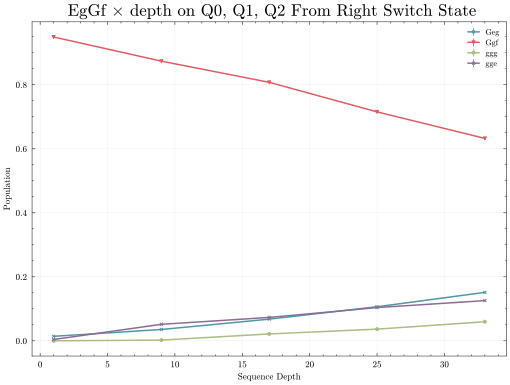

Saving S:\QRAM\qram_4QR2\data\data_250119\00044_leakage_EgGf_qubit21.h5


In [21]:
# step_1 = 1
# end_1 = 30
# range1 = np.arange(1, end_1+step_1, step_1)
depths = range1
print('depths', len(depths))
print(depths)

for i_len in range(len(opt_lens)):
    rbprog = meas.EgGfLeakageExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"leakage_EgGf_qubit{qubits[0]}{qubits[1]}",
        config_file=config_path,
    )

    rbprog.cfg.device.qubit.f_EgGf_Q_half[qDrive] = opt_freq_short
    rbprog.cfg.device.qubit.pulses.pi_EgGf_Q.half_gain[qDrive] = opt_gain_short
    rbprog.cfg.device.qubit.pulses.pi_EgGf_Q.half_sigma[qDrive] = opt_len_short

    print("Starting", i_len, "with len", opt_lens[i_len], "gain", opt_gains[i_len], "freq", opt_freqs[i_len])

    gate_char = None
    # gate_char = 'X'

    print("Will save to", rbprog.fname)

    rbprog.cfg.expt = dict(
        depths=depths,
        # reps=4000*10, # number averages per unique sequence need at least 10,000 for a good amount of error per point!!
        # reps_f=10000*10,
        reps=4000*2, # number averages per unique sequence need at least 10,000 for a good amount of error per point!!
        reps_f=6000*2,
        loops=10,
        # loops=1,
        gate_char=gate_char, # single qubit clifford gate (str) to characterize. if not None, runs interleaved RB instead of regular RB
        qubits=[0, 1, qDrive],
        qDrive=qDrive,
        singleshot_reps=10000, # reps per state for singleshot calibration
        # singleshot_reps=100, # reps per state for singleshot calibration
        # singleshot_reps_f=15000, # reps per state for singleshot calibration
        # singleshot_reps=20000, # reps per state for singleshot calibration
        post_process='threshold', # 'threshold' (uses single shot binning), 'scale' (scale by ge_avgs), or None

        test_leakage = True, # if true, does pi/pi instead of random sequence
        wrong_init = False, # if True, starts from wrong state. if False, starts from good state, does pi^N both cases
        # wrong_init = True, # if True, starts from wrong state. if False, starts from good state, does pi^N both cases

        measure_f_only=False,
        measure_f=[qDrive],

        add_phase=False,

        # cool_qubits=[0, 1],

        full_mux_expt=full_mux_expt,
        resonator_reset=resonator_reset,
        use_robust_pulses=True,

        validate_variations=False,

    )
    
    print(rbprog.cfg)

    import Pyro4.util
    try:
        rbprog.acquire(progress=True, debug=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))

    # rbprog.go(analyze=False, display=False, progress=True, save=False)
    rbprog.analyze(fit=False)
    rbprog.display(fit=False, show_all_vars=False)
    saved_files.append(rbprog.save_data())